In [1]:
import os
#os.environ["OMP_NUM_THREADS"]="1"
import random
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchvision.transforms import transforms
import numpy as np
import toml
from time import time
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.base import SegmentationHead
from segmentation_models_pytorch.encoders import get_encoder
from src.multi_head_unet import UnetDecoder, MultiHeadModel
from src.embedding_loss import SpatialEmbLoss
from src.focal_loss import FocalCE
from src.unet import UNet
from src.spatial_augmenter import SpatialAugmenter
from src.train_utils import supervised_train_step, validation, save_snapshot, save_model, make_cpvs
from src.data_utils import SliceDataset, CropDataset, color_augmentations, center_crop, add_3c_gt
from tqdm.auto import tqdm

torch.backends.cudnn.benchmark = True
#
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))


In [123]:
%load_ext tensorboard
%tensorboard --logdir test/train/summary

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [79]:
params = {
    'data_path': 'tiles',
    'experiment' : 'test',
    'batch_size': 4,
    'training_steps':300000,
    'in_channels': 3,
    'num_fmaps': 32,
    'fmap_inc_factors': 2,
    'downsample_factors': [ [ 2, 2,], [ 2, 2,], [ 2, 2,], [ 2, 2,],],
    'num_fmaps_out': 12,
    'constant_upsample': False,
    'padding': 'same',
    'activation': 'ReLU',
    'weight_decay': 1e-5,
    'learning_rate': 1e-4,
    'seed': 42,
    'num_validation': 500,
    'cutout_prob':0.0,
    'checkpoint_path': 'exp_0_dsb/best_model',
    'cutout_or_RandomErasing': 'RandomErasing',
    'pretrained_model': True,
    'multi_head': True,
    'uniform_class_sampling': True,
    'optimizer' : 'AdamW',
    'instance_seg': 'cpv_3c',
    'validation_step' : 500,
    'snapshot_step' : 5000,
    'checkpoint_step': 20000,
    }

aug_params_fast = {
    'mirror': {'prob_x': 0.5, 'prob_y': 0.5, 'prob': 0.5},
    'translate': {'max_percent':0.05, 'prob': 0.2},
    'scale': {'min': 0.8, 'max':1.2, 'prob': 0.2},
    'zoom': {'min': 0.8, 'max':1.2, 'prob': 0.2},
    'rotate': {'rot90': True, 'prob': 0.75},
    'shear': {'max_percent': 0.1, 'prob': 0.2},
    'elastic': {'alpha': [120,120], 'sigma': 8, 'prob': 0.5}
}

log_dir = os.path.join(params['experiment'],'train')
snap_dir = os.path.join(log_dir,'snaps')
os.makedirs(snap_dir,exist_ok=True)
writer_dir = os.path.join(log_dir,'summary',str(time()))
os.makedirs(writer_dir,exist_ok=True)
writer = SummaryWriter(writer_dir)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
params['device'] = device
params['aug_params_fast'] = aug_params_fast
with open(os.path.join(params['experiment'], 'params.toml'), 'w') as f:
    toml.dump(params, f)

if 'tiles' in params['data_path']:
    img_data =  np.load(os.path.join(params['data_path'], 'images.npy')) # N x H x W x C
    lab_dat = np.load(os.path.join(params['data_path'], 'labels.npy')) # N x H x W x 2
    np.random.seed(params['seed'])
    seed_ind = np.random.permutation(img_data.shape[0])
    img_data = img_data[seed_ind]
    lab_dat = lab_dat[seed_ind]
    X_train = img_data[:-params['num_validation']]
    Y_train = lab_dat[:-params['num_validation']]
    X_val = img_data[-params['num_validation']:]
    Y_val = lab_dat[-params['num_validation']:]
    # add gt_3c
    Y_train = add_3c_gt(Y_train)
    Y_val = add_3c_gt(Y_val)
    labeled_dataset = SliceDataset(raw=X_train, labels=Y_train)
    validation_dataset = SliceDataset(raw=X_val, labels=Y_val)
else:
    file_paths = [os.path.join(params['data_path'], file) for file in os.listdir(params['data_path'])]
    random.Random(params['seed']).shuffle(file_paths)
    val_paths = [file_paths.pop(0) for _ in range(params['num_validation'])]
    labeled_paths = file_paths
    labeled_dataset = CropDataset(labeled_paths, raw_keys=['raw'], label_keys=['gt_labels', 'gt_instances'], crop_size=[256,256])
    validation_dataset = CropDataset(val_paths, raw_keys=['raw'], label_keys=['gt_labels', 'gt_instances'], crop_size=[256,256])

if params['uniform_class_sampling']:
    # uniform class sampling
    labeled_dataloader = DataLoader(labeled_dataset,
                        batch_size=1,
                        shuffle=False,
                        prefetch_factor=4,
                        num_workers=6)
    classes = [0,1,2,3,4,5,6]
    count_list = []

    for raw, gt in tqdm(labeled_dataloader):
        gt_classes = gt[...,1].squeeze()
        tmp_list = []
        for c in classes:
            tmp_list.append(torch.sum(gt_classes==c))
        count_list.append(torch.stack(tmp_list))
        
    counts = torch.stack(count_list) # n samples x classes
    sampling_weights = counts/counts.sum(0).unsqueeze(0)
    sampling_weights = sampling_weights.sum(1)
    sampler = torch.utils.data.WeightedRandomSampler(sampling_weights, num_samples=len(sampling_weights), replacement=True)

    labeled_dataloader = DataLoader(labeled_dataset,
                        batch_size=1,
                        prefetch_factor=4,
                        sampler= sampler,
                        num_workers=6)
else:
    labeled_dataloader = DataLoader(labeled_dataset,
                        batch_size=params['batch_size'],
                        shuffle=True,
                        prefetch_factor=4,
                        num_workers=6)

validation_dataloader = DataLoader(validation_dataset,
                    batch_size=1,
                    shuffle=True,
                    prefetch_factor=4,
                    num_workers=1)

  0%|          | 0/4481 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/4481 [00:39<?, ?it/s]

In [217]:
if params['pretrained_model']:
    if params['multi_head']:
        encoder = smp.encoders.get_encoder(
            name= "timm-efficientnet-b5",
            in_channels=3,
            depth=5,
            weights=None).to(device)
        decoder_channels = (256, 128, 64, 32, 16)
        decoder_inst = UnetDecoder(
                    encoder_channels=encoder.out_channels,
                    decoder_channels=decoder_channels,
                    n_blocks=5,
                    use_batchnorm=True,
                    center=False,
                    attention_type=None).to(device)
        decoder_ct = UnetDecoder(
                    encoder_channels=encoder.out_channels,
                    decoder_channels=decoder_channels,
                    n_blocks=5,
                    use_batchnorm=True,
                    center=False,
                    attention_type=None).to(device)
        head_inst = smp.base.SegmentationHead(
                    in_channels=decoder_channels[-1],
                    out_channels=5,
                    activation=None,
                    kernel_size=1).to(device)
        head_ct = smp.base.SegmentationHead(
                    in_channels=decoder_channels[-1],
                    out_channels=7,
                    activation=None,
                    kernel_size=1).to(device)

        decoders = [decoder_inst, decoder_ct]
        heads = [head_inst, head_ct]
        model = MultiHeadModel(encoder, decoders, heads)
    else:
        model = smp.Unet(
            encoder_name= "timm-efficientnet-b5", # "timm-efficientnet-b5", # choose encoder
            encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
            in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
            classes=params['num_fmaps_out'],                      # model output channels (number of classes in your dataset)
            ).to(params['device'])
#preprocess_input = smp.encoders.get_preprocessing_fn('efficientnet-b5', pretrained='imagenet')
else:
    model = UNet(in_channels = params['in_channels'],
                num_fmaps = params['num_fmaps'],
                fmap_inc_factor = params['fmap_inc_factors'],
                downsample_factors = params['downsample_factors'],
                activation = params['activation'],
                padding = params['padding'],
                num_fmaps_out = params['num_fmaps_out'],
                constant_upsample = params['constant_upsample'],
            ).to(params['device'])

if 'checkpoint_path' in params.keys() and params['checkpoint_path']:
    model.load_state_dict(torch.load(params['checkpoint_path'])['model_state_dict'])
model = model.train()

if 'cutout_or_RandomErasing' in params.keys() and params['cutout_or_RandomErasing'] == 'RandomErasing':
    eraser = torch.nn.Sequential(
        *[transforms.RandomErasing(p=1., scale=(0.001, 0.001), ratio=(0.3,1.3), inplace=False) for _ in range(200)])
    def cutout(img):
        B,C,_,_ = img.shape
        device = img.device
        img_list = []
        mask_list = []
        for b in range(B):
            mask = eraser(torch.ones_like(img[b:b+1,...]).to(device))
            img_masked = img[b:b+1,...] * mask.float()
            mask = -1 * (mask-1)
            img_list.append(img_masked) 
            mask_list.append(mask)
        return torch.cat(img_list, axis=0), torch.cat(mask_list, axis=0)

# initialize optimizer, augmentations and summary writer
if params['optimizer'] == 'SGD':
    optimizer = torch.optim.SGD(model.parameters(),
                                lr=params['learning_rate'],
                                momentum=0.9,
                                weight_decay=params['weight_decay'],
                                nesterov=True)
elif params['optimizer'] == 'AdamW':
    optimizer = torch.optim.AdamW(model.parameters(),
                                  lr=params['learning_rate'],
                                  weight_decay=params['weight_decay'])

elif params['optimizer'] == 'AdaBound':
    optimizer = optim.AdaBound(model.parameters(),
                               lr=params['learning_rate'],
                               final_lr = 1e-5,
                               weight_decay=params['weight_decay'])

#lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=params['training_steps'], eta_min=1e-5)
fast_aug = SpatialAugmenter(aug_params_fast)#, padding_mode='reflection')
if params['instance_seg'] == 'embedding':
    inst_loss_fn = SpatialEmbLoss(n_sigma=2, to_center=False, foreground_weight=10, H=256,W=256).to(device)
elif params['instance_seg'] == 'cpv_3c':
    def inst_loss_fn(input, gt_inst, gt_3c):
        gt_cpv_list = []
        gt_inst = gt_inst.squeeze(0)
        for b in range(gt_inst.shape[0]):
            gt_cpv_list.append(make_cpvs(gt_inst.to(device)[b], device))
        gt_cpv = torch.cat(gt_cpv_list, axis=0)
        loss_cpv = F.mse_loss(input = input[:,:2],target = gt_cpv.float())
        loss_3c =  F.cross_entropy(input = input[:,2:],
                        target = gt_3c.long().squeeze(0).to(device),
                        weight=torch.tensor([1,1,4]).float().to(device))
        return loss_cpv + loss_3c

ce_loss_fn = FocalCE(num_classes=7)

In [8]:
from src.color_conversion import Rgb2Hed, Hed2Rgb, LinearContrast
from torchvision.transforms.transforms import RandomApply, RandomChoice, GaussianBlur, ColorJitter
from src.data_utils import GaussianNoise

def color_augmentations(size, s=0.2):
    # taken from https://github.com/sthalles/SimCLR/blob/master/data_aug/contrastive_learning_dataset.py
    """Return a set of data augmentation transformations as described in the SimCLR paper."""
    color_jitter = ColorJitter(0.8 * s, 0.0 * s, 0.8 * s, 0.2 * s) # brightness, contrast, saturation, hue
    HED_contrast = torch.nn.Sequential(
                Rgb2Hed(),
                LinearContrast(alpha=(0.75,1.25)),
                Hed2Rgb())
    data_transforms = torch.nn.Sequential(
        RandomApply([
            HED_contrast,
            color_jitter,
            GaussianNoise(0.005), 
            GaussianBlur(kernel_size=3, sigma=(0.1,0.1))], p=0.5),
        )
    return data_transforms

color_aug_fn = color_augmentations(200, s=0.5)


In [9]:
from scipy.ndimage import measurements

def fix_mirror_padding(ann):
    """Deal with duplicated instances due to mirroring in interpolation
    during shape augmentation (scale, rotation etc.).
    """
    current_max_id = np.amax(ann)
    inst_list = list(np.unique(ann))
    inst_list.remove(0)  # 0 is background
    for inst_id in inst_list:
        inst_map = np.array(ann == inst_id, np.uint8)
        remapped_ids = measurements.label(inst_map)[0]
        remapped_ids[remapped_ids > 1] += current_max_id
        ann[remapped_ids > 1] = remapped_ids[remapped_ids > 1]
        current_max_id = np.amax(ann)
    return ann

In [14]:
def supervised_train_step(model, raw, gt, fast_aug, color_aug_fn, cutout_fn, cutout_prob, inst_lossfn, class_lossfn, writer, device, step):
    raw = raw.to(device).float()
    raw = raw + raw.min() *-1
    raw /= raw.max()
    gt = gt.to(device).float()
    B,_,_,_ = raw.shape
    if gt.shape[-1]>2:
        cpv_3c_model = True
        gt_3c_list = []
    else:
        cpv_3c_model = False
    raw_list = []
    gt_inst_list = []
    gt_ct_list = []
    cutout_maps = []
    for b in range(B):
        img = raw[b].permute(2,0,1).unsqueeze(0) # BHWC -> BCHW
        gt_ = gt[b].permute(2,0,1).unsqueeze(0) # BHW2 -> B2HW
        img_saug, gt_saug = fast_aug.forward_transform(img, gt_)                
        #gt_inst = fix_mirror_padding(gt_saug[0,0].cpu().detach().numpy().astype(np.int32)) # slow af
        #gt_inst = torch.tensor(gt_inst, device=device).float().unsqueeze(0)
        gt_inst = gt_saug[:,0]
        gt_ct = gt_saug[:,1]
        if cpv_3c_model:
            gt_3c = gt_saug[:,2]
            gt_3c_list.append(gt_3c)
        img_caug = color_aug_fn(img_saug)
        if torch.rand(1)<cutout_prob:
            img_caug, cutout_map = cutout_fn(img_caug)
            no_cutout=False
        else:
            no_cutout = True
            cutout_map = torch.zeros_like(img_caug)
        raw_list.append(img_caug)
        gt_inst_list.append(gt_inst)
        gt_ct_list.append(gt_ct)
        cutout_maps.append(cutout_map)
    img_caug = torch.cat(raw_list, axis = 0)
    gt_inst  = torch.cat(gt_inst_list, axis = 0)
    gt_ct = torch.cat(gt_ct_list, axis = 0)
    cutout_maps = torch.cat(cutout_maps, axis = 0)
    out_fast = model(img_caug)
    _,_,H,W = out_fast.shape
    gt_inst = center_crop(gt_inst.unsqueeze(0), H, W)
    gt_ct = center_crop(gt_ct.unsqueeze(0), H, W)
    pred_inst = out_fast[:,:5]
    pred_class = out_fast[:,5:]
    if cpv_3c_model:
        gt_3c = torch.cat(gt_3c_list, axis = 0)
        gt_3c = center_crop(gt_3c.unsqueeze(0), H, W)
        instance_loss = inst_lossfn(pred_inst, gt_inst, gt_3c)
    else:
        instance_loss = inst_lossfn(pred_inst, gt_inst.squeeze(0).float(), (gt_inst.squeeze(0)>0).float())
    class_loss = class_lossfn(pred_class, gt_ct.long())
    if torch.isnan(instance_loss) or not torch.isfinite(instance_loss):
        instance_loss = torch.tensor(0.0)
    if torch.isnan(class_loss) or not torch.isfinite(class_loss):
        class_loss = torch.tensor(0.0)
    loss = instance_loss + class_loss
    writer.add_scalar('instance_loss', instance_loss, step)
    writer.add_scalar('class_loss', class_loss, step)
    writer.add_scalar('loss', loss, step)
    print('loss', loss.item())
#     if not no_cutout:
#         inpaint_loss = torch.masked_select(loss_img, cutout_maps.any(1).bool()).mean()
#         writer.add_scalar('sup_inpainting_loss', inpaint_loss.item(), step)
#         print('emb inpaint_loss', inpaint_loss.item())
#         loss += inpaint_loss
    return loss, pred_inst, pred_class.softmax(1),img_caug, gt_inst, gt_ct, cutout_maps

In [218]:
model.load_state_dict(torch.load(os.path.join(log_dir,"best_model"))['model_state_dict'])
model = model.train()

In [80]:
import matplotlib.pyplot as plt

step = 0
validation_loss = []

while step < params['training_steps']:
    tmp_loader = iter(labeled_dataloader)
    for raw, gt in tmp_loader:
        step += 1
        optimizer.zero_grad()
        loss, pred_inst, pred_class ,img_caug, gt_inst, gt_ct, cutout_maps = supervised_train_step(model,
                                                            raw,
                                                            gt,
                                                            fast_aug,
                                                            color_aug_fn,
                                                            cutout,
                                                            params['cutout_prob'],
                                                            inst_loss_fn,
                                                            ce_loss_fn,
                                                            writer,
                                                            device,
                                                            step)
        loss.backward()
        optimizer.step()
        #lr_scheduler.step()
#         if step % 50 == 0:
#             fig, ax = plt.subplots(1,4,figsize=(34,34))
#             ax[0].imshow(img_caug[0].permute(1,2,0).detach().cpu().numpy(), vmin=0, vmax=1)
#             ax[1].imshow(gt_ct[0,:1].permute(1,2,0).detach().cpu().numpy(), cmap='tab20c', vmin=0, vmax=7)
#             ax[2].imshow(pred_class[0].permute(1,2,0).argmax(-1).detach().cpu().numpy(), cmap='tab20c', vmin=0, vmax=7)
#             ax[3].imshow(pred_inst[0,2:].softmax(0).permute(1,2,0).detach().cpu().numpy())       
#             plt.show()
        if step % params['validation_step'] == 0:
            val_new = validation(model,
                    validation_dataloader,
                    inst_loss_fn,
                    ce_loss_fn,
                    device,
                    step,
                    writer)
            validation_loss.append(val_new)
            if val_new <= np.min(validation_loss):
                print('Save best model')
                save_model(step, model, optimizer, loss, os.path.join(log_dir,"best_model"))
        #
        if step % params['snapshot_step'] == 0:
            print('Save snapshot')
            tmp_dic = {
                    'pred_ct': pred_class[0].cpu().detach().numpy(),
                    'img_caug': img_caug[0].squeeze(0).cpu().detach().numpy(),
                    'gt_inst': gt_inst.squeeze(0).cpu().detach().numpy()[:1],
                    'gt_ct': gt_ct.squeeze(0).cpu().detach().numpy()[:1]}
            if params['instance_seg'] == 'embedding':
                _,_,h,w = pred_inst.shape
                xym_s = inst_loss_fn.xym[:, 0:h, 0:w].contiguous()
                spatial_emb = pred_inst[0, 0:2] + xym_s  # 2 x h x w
                sigma = pred_inst[0, 2:2+inst_loss_fn.n_sigma]  # n_sigma x h x w
                seed_map = torch.sigmoid(
                    pred_inst[0, 2+inst_loss_fn.n_sigma:2+inst_loss_fn.n_sigma + 1])  # 1 x h x w
                tmp_dic['embedding'] = spatial_emb.cpu().detach().numpy()
                tmp_dic['sigma'] = sigma.cpu().detach().numpy()
                tmp_dic['seed_map'] = seed_map.cpu().detach().numpy()
            elif params['instance_seg'] == 'cpv_3c':
                tmp_dic['pred_cpv'] = pred_inst[0,:2].cpu().detach().numpy()
                tmp_dic['pred_3c'] = pred_inst[0,2:].softmax(0).cpu().detach().numpy()
            save_snapshot(snap_dir, tmp_dic, step)
        if step % params['checkpoint_step'] == 0:
            save_model(step, model, optimizer, loss, os.path.join(log_dir,"checkpoint_step_"+str(step)))    

C:\Users\Lorenz\.conda\envs\torch\lib\site-packages\torch\nn\functional.py:4065: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
C:\Users\Lorenz\.conda\envs\torch\lib\site-packages\torch\nn\functional.py:4003: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


loss 2.803441286087036
loss 0.015900373458862305
loss 1.8278676271438599
loss 2.150129795074463
loss 1.7752103805541992
loss 1.9232251644134521
loss 4.46529483795166
loss 1.8656055927276611
loss 3.07781982421875
loss 1.9909073114395142
loss 2.2162649631500244
loss 2.440211296081543
loss 2.2866671085357666
loss 1.6373405456542969
loss 2.26714825630188
loss 1.8792027235031128
loss 1.7601101398468018
loss 2.5318241119384766
loss 2.2675557136535645
loss 1.7588385343551636
loss 3.52300763130188
loss 1.7480050325393677
loss 2.5354413986206055
loss 2.0329489707946777
loss 3.0812768936157227
loss 1.5704602003097534
loss 2.231688976287842
loss 2.0412325859069824
loss 2.4404654502868652
loss 3.971585750579834
loss 1.8685213327407837
loss 3.030271530151367
loss 2.304520606994629
loss 2.8299272060394287
loss 2.8209123611450195
loss 2.1900634765625
loss 1.7695300579071045
loss 1.7882018089294434
loss 2.6532368659973145
loss 2.2809247970581055
loss 2.0571117401123047
loss 2.7951109409332275
loss 2.0

loss 1.915039300918579
loss 2.7713587284088135
loss 2.2283284664154053
loss 2.0097246170043945
loss 2.007824420928955
loss 3.3527326583862305
loss 1.788136601448059
loss 2.2195775508880615
loss 2.313708782196045
loss 1.686840295791626
loss 0.03270917385816574
loss 3.482379913330078
loss 1.8112835884094238
loss 1.9253710508346558
loss 1.999119758605957
loss 1.7702720165252686
loss 2.827854633331299
loss 2.5693793296813965
loss 3.605259418487549
loss 1.9890522956848145
loss 1.7823753356933594
loss 2.096653699874878
loss 1.8609180450439453
loss 2.0983870029449463
loss 2.3249309062957764
loss 3.3416311740875244
loss 2.668234348297119
loss 2.2636842727661133
loss 3.94887113571167
loss 1.7902987003326416
loss 1.7604222297668457
loss 1.8852355480194092
loss 1.6798490285873413
loss 1.9365640878677368
loss 2.0678250789642334
loss 2.1828958988189697
loss 4.094717025756836
loss 1.934908151626587
loss 2.0101709365844727
loss 1.763904094696045
loss 5.326551914215088
loss 1.9801421165466309
loss 2.3

loss 2.336650848388672
loss 1.866199016571045
loss 7.4370036125183105
loss 1.9657697677612305
loss 1.9589495658874512
loss 2.1488866806030273
loss 2.420271635055542
loss 2.242173433303833
loss 2.5714545249938965
loss 7.479597091674805
loss 2.1098392009735107
loss 2.7316555976867676
loss 2.0325069427490234
loss 2.714931011199951
loss 2.1864702701568604
loss 2.4501421451568604
loss 2.759807586669922
loss 2.329927921295166
loss 1.8540478944778442
loss 1.6460318565368652
loss 2.2350285053253174
loss 1.8164353370666504
loss 2.010929822921753
loss 2.80859112739563
loss 2.205380916595459
loss 2.0025475025177
loss 2.177006244659424
loss 2.444363594055176
loss 6.283036231994629
loss 2.1820297241210938
loss 2.2839386463165283
loss 1.831467628479004
loss 1.7564319372177124
loss 1.929447889328003
loss 2.803130626678467
loss 1.9732699394226074
loss 2.3201637268066406
loss 2.2306647300720215
loss 3.8429205417633057
loss 2.3085107803344727
loss 2.3204421997070312
loss 2.4289839267730713
loss 2.907440

loss 2.9892048835754395
loss 1.8435695171356201
loss 3.520577907562256
loss 4.101235866546631
loss 2.878814697265625
loss 1.810210943222046
loss 2.2754106521606445
loss 3.6357412338256836
loss 2.8875608444213867
loss 1.9558453559875488
loss 1.988606572151184
loss 1.8769758939743042
loss 2.28836727142334
loss 2.772400379180908
loss 2.411498546600342
loss 3.8973379135131836
loss 2.646366596221924
loss 3.5984020233154297
loss 1.661224603652954
loss 1.9751136302947998
loss 2.4655981063842773
loss 2.8340530395507812
loss 1.7536399364471436
loss 2.0519580841064453
loss 2.577449083328247
loss 1.9749858379364014
loss 2.0279293060302734
loss 2.4648311138153076
loss 1.8159266710281372
loss 1.69744074344635
loss 5.503828525543213
loss 1.8020520210266113
loss 2.9912402629852295
loss 3.8944272994995117
loss 2.334578037261963
loss 2.1676244735717773
loss 3.1814160346984863
loss 3.4802775382995605
loss 34.7734260559082
loss 4.772584438323975
loss 2.1749744415283203
loss 1.7821979522705078
loss 3.9201

loss 2.825531244277954
loss 3.0613884925842285
loss 2.6370410919189453
loss 3.160799980163574
loss 1.9108517169952393
loss 1.930919885635376
loss 6.392611026763916
loss 2.0117902755737305
loss 2.078261613845825
loss 2.720428943634033
loss 0.013106437399983406
loss 2.1249866485595703
loss 1.623336672782898
loss 2.419248104095459
loss 1.9285147190093994
loss 11.060041427612305
loss 3.7084362506866455
loss 2.4387426376342773
loss 2.1710875034332275
loss 3.9045822620391846
loss 1.7066848278045654
loss 1.946729063987732
loss 4.036532402038574
loss 1.6875494718551636
loss 2.3742785453796387
loss 3.1115031242370605
loss 3.0112709999084473
loss 2.556523323059082
loss 1.9060497283935547
loss 1.9701894521713257
loss 2.3853759765625
loss 2.387542724609375
loss 1.667048454284668
loss 2.1957316398620605
loss 1.6992675065994263
loss 2.2041940689086914
loss 0.017650017514824867
loss 1.8371621370315552
loss 1.8927525281906128
loss 2.0275187492370605
loss 3.121117115020752
loss 2.0380778312683105
loss 

loss 5.60828161239624
loss 2.209834575653076
loss 3.251418113708496
loss 3.0438475608825684
loss 2.218440055847168
loss 2.7082934379577637
loss 1.8397077322006226
loss 1.90627121925354
loss 1.995879888534546
loss 4.506264686584473
loss 3.324204921722412
loss 3.548506021499634
loss 1.993346095085144
loss 1.6767044067382812
loss 2.5062079429626465
loss 2.2834181785583496
loss 3.3242831230163574
loss 1.6883177757263184
loss 2.3827085494995117
loss 2.875174045562744
loss 2.902137279510498
loss 1.919267177581787
loss 1.8772666454315186
loss 2.130817413330078
loss 2.152351140975952
loss 2.709373712539673
loss 1.7343395948410034
loss 1.712686538696289
loss 1.8376736640930176
loss 2.5293734073638916
loss 2.579871654510498
loss 15.873878479003906
loss 1.9819073677062988
loss 2.8621513843536377
loss 4.2813496589660645
loss 1.9642504453659058
loss 1.678485631942749
loss 5.383290767669678
loss 2.5191149711608887
loss 2.010590076446533
loss 2.015707492828369
loss 2.204667329788208
loss 2.2966709136

loss 2.1658225059509277
loss 2.3331117630004883
loss 2.5353567600250244
loss 2.4466230869293213
loss 2.3267250061035156
loss 3.016247034072876
loss 1.9981176853179932
loss 1.9629342555999756
loss 1.7127549648284912
loss 1.9854347705841064
loss 2.1108322143554688
loss 3.781547784805298
loss 2.35612416267395
loss 2.410642623901367
loss 2.51944637298584
loss 1.838176965713501
loss 1.9242171049118042
loss 2.0151474475860596
loss 2.121539354324341
loss 2.536400079727173
loss 2.343766212463379
loss 7.5279340744018555
loss 1.8616044521331787
loss 1.970086932182312
loss 2.3096742630004883
loss 2.311359405517578
loss 2.508873224258423
loss 2.4467759132385254
loss 2.16103458404541
loss 2.1751248836517334
loss 2.07890248298645
loss 1.6988751888275146
loss 1.8484246730804443
loss 1.786516547203064
loss 3.972447633743286
loss 1.9551541805267334
loss 1.953454852104187
loss 5.921874523162842
loss 2.109931707382202
loss 1.5819218158721924
loss 2.843886375427246
loss 1.9043933153152466
loss 1.838751792

loss 2.4378573894500732
loss 2.662795066833496
loss 2.484442710876465
loss 1.8657352924346924
loss 2.065171957015991
loss 3.12632155418396
loss 2.9373481273651123
loss 2.312641143798828
loss 2.4433398246765137
loss 2.816455602645874
loss 2.8438949584960938
loss 2.310756206512451
loss 3.742068290710449
loss 2.9490246772766113
loss 2.3888700008392334
loss 3.278116464614868
loss 3.378983974456787
loss 3.8273253440856934
loss 1.904662847518921
loss 3.330717086791992
loss 2.6840968132019043
loss 2.479764938354492
loss 1.7414849996566772
loss 1.737423300743103
loss 2.3497540950775146
loss 2.05507755279541
loss 2.1639060974121094
loss 2.1058902740478516
loss 1.9766470193862915
loss 2.316936492919922
loss 1.9430757761001587
loss 3.1864118576049805
loss 2.1874680519104004
loss 2.1053130626678467
loss 1.6933529376983643
loss 1.9975374937057495
loss 2.245539665222168
loss 1.8921527862548828
loss 2.647733211517334
loss 1.8881492614746094
loss 3.836982250213623
loss 2.561178207397461
loss 2.0137267

loss 1.7358875274658203
loss 2.232543468475342
loss 2.0991992950439453
loss 1.9549808502197266
loss 1.8136091232299805
loss 3.466071605682373
loss 1.7768254280090332
loss 2.0237717628479004
loss 2.26882266998291
loss 3.5319247245788574
loss 2.1618964672088623
loss 1.727837085723877
loss 2.541651487350464
loss 2.1190953254699707
loss 1.946136236190796
loss 2.0743019580841064
loss 1.6468796730041504
loss 2.049499988555908
loss 2.051804304122925
loss 2.2884628772735596
loss 2.9126598834991455
loss 1.7943267822265625
loss 4.330235481262207
loss 2.3173866271972656
loss 2.5502963066101074
loss 1.8042713403701782
loss 3.0055899620056152
loss 2.0469861030578613
loss 2.7726187705993652
loss 6.844488620758057
loss 2.1892812252044678
loss 1.9150686264038086
loss 4.711403846740723
loss 24.572362899780273
loss 1.9774317741394043
loss 1.908389925956726
loss 7.420650005340576
loss 1.9542573690414429
loss 2.5016427040100098
loss 2.940518856048584
loss 2.6806654930114746
loss 2.067211627960205
loss 2.2

loss 1.7996699810028076
loss 2.1362533569335938
loss 1.6307415962219238
loss 2.112549066543579
loss 2.120857000350952
loss 2.3659512996673584
loss 2.1079635620117188
loss 2.1275389194488525
loss 3.433701992034912
loss 2.444401741027832
loss 2.300574541091919
loss 2.2393035888671875
loss 2.1209120750427246
loss 2.093010425567627
loss 2.2218987941741943
loss 2.068215847015381
loss 2.0606706142425537
loss 2.4022202491760254
loss 2.841282367706299
loss 2.2849817276000977
loss 2.1679959297180176
loss 2.0497686862945557
loss 2.124300718307495
loss 2.5349574089050293
loss 2.482302188873291
loss 0.025277981534600258
loss 1.6531046628952026
loss 2.2517032623291016
loss 1.7382371425628662
loss 3.1908657550811768
loss 2.3902320861816406
loss 4.294600963592529
loss 3.812936305999756
loss 1.821714162826538
loss 2.8684754371643066
loss 1.937908411026001
loss 2.581441879272461
loss 1.736188292503357
loss 2.1696534156799316
loss 2.5441513061523438
loss 3.4846620559692383
loss 1.7821128368377686
loss 2

loss 2.890631675720215
loss 1.9685697555541992
loss 2.3867413997650146
loss 1.8466174602508545
loss 2.9507834911346436
loss 1.9278146028518677
loss 2.166196584701538
loss 2.0009143352508545
loss 2.3772330284118652
loss 2.4945693016052246
loss 1.7996214628219604
loss 2.4787073135375977
loss 1.8041924238204956
loss 2.020824909210205
loss 1.9632080793380737
loss 2.0640177726745605
loss 1.9660730361938477
loss 2.443518877029419
loss 1.9821468591690063
loss 2.192124843597412
loss 2.4304661750793457
loss 2.7151167392730713
loss 2.1433777809143066
loss 2.174704074859619
loss 2.6488254070281982
loss 3.419442892074585
loss 2.784579038619995
loss 2.1595957279205322
loss 1.914394497871399
loss 3.0867600440979004
Validation loss:  2.1845479011535645
loss 2.2040016651153564
loss 2.120621681213379
loss 1.5921958684921265
loss 2.449583053588867
loss 2.996346950531006
loss 6.194530487060547
loss 2.355875253677368
loss 2.6456892490386963
loss 4.461262226104736
loss 1.7758092880249023
loss 2.97355246543

loss 2.4233195781707764
loss 2.937040090560913
loss 2.5922560691833496
loss 2.4835102558135986
loss 3.2342777252197266
loss 2.438307762145996
loss 6.323369026184082
loss 3.4432854652404785
loss 2.2349066734313965
loss 1.7892086505889893
loss 3.2477946281433105
loss 2.95277738571167
loss 2.053898334503174
loss 7.722350120544434
loss 2.4324123859405518
loss 2.770519971847534
loss 1.5185201168060303
loss 2.658219814300537
loss 2.4524550437927246
loss 2.2431721687316895
loss 2.046083927154541
loss 2.6183245182037354
loss 2.4840900897979736
loss 9.047196388244629
loss 2.811699390411377
loss 1.4405039548873901
loss 2.1341552734375
loss 1.7403252124786377
loss 2.03057861328125
loss 1.8688606023788452
loss 1.7845447063446045
loss 1.819683313369751
loss 2.347776412963867
loss 1.59169340133667
loss 2.2814621925354004
loss 1.84818434715271
loss 2.064676284790039
loss 2.0836713314056396
loss 2.6588194370269775
loss 1.937190294265747
loss 2.24202823638916
loss 2.1630520820617676
loss 2.175721883773

loss 2.4737343788146973
loss 2.9993696212768555
loss 1.7069400548934937
loss 2.269113540649414
loss 2.390626907348633
loss 2.13735032081604
loss 2.0673975944519043
loss 2.295039176940918
loss 4.9390130043029785
loss 1.6087121963500977
loss 2.387747287750244
loss 2.4694437980651855
loss 2.2035326957702637
loss 2.158547878265381
loss 2.1897873878479004
loss 2.627380132675171
loss 2.736001968383789
loss 2.515986442565918
loss 2.160355806350708
loss 2.1500725746154785
loss 2.0348048210144043
loss 2.642871379852295
loss 2.240173816680908
loss 2.3044629096984863
loss 3.1713318824768066
loss 2.690761089324951
loss 1.6951748132705688
loss 2.2504730224609375
loss 2.030276298522949
loss 3.3435781002044678
loss 1.7211904525756836
loss 2.7679224014282227
loss 2.020616054534912
loss 2.1099586486816406
loss 2.3656201362609863
loss 4.53181266784668
loss 2.092325210571289
loss 1.877418041229248
loss 2.198300838470459
loss 2.8493492603302
loss 2.347829818725586
loss 3.713494062423706
loss 3.49283409118

loss 1.872822642326355
loss 3.9329817295074463
loss 1.877408742904663
loss 1.7805590629577637
loss 1.8103365898132324
loss 1.9938843250274658
loss 2.534040927886963
loss 2.6005501747131348
loss 2.0658040046691895
loss 2.0729591846466064
loss 2.2305171489715576
loss 4.447491645812988
loss 2.750260353088379
loss 1.9641615152359009
loss 2.294321298599243
loss 1.689087152481079
loss 2.1469719409942627
loss 1.9371161460876465
loss 2.845822811126709
loss 1.6787835359573364
loss 2.7130167484283447
loss 1.6041815280914307
loss 2.138159990310669
loss 1.9227617979049683
loss 1.9252092838287354
loss 2.030085325241089
loss 2.436872720718384
loss 1.6199431419372559
loss 1.655893087387085
loss 2.5184969902038574
loss 3.4080638885498047
loss 2.4446966648101807
loss 1.5956538915634155
loss 1.8622360229492188
loss 2.683910608291626
loss 2.7672715187072754
loss 1.8122038841247559
loss 2.3796744346618652
loss 2.199221611022949
loss 2.642308235168457
loss 2.066739082336426
loss 1.540927529335022
loss 2.21

loss 2.0133752822875977
loss 2.962946891784668
loss 1.712619662284851
loss 2.1894943714141846
loss 1.925096035003662
loss 1.9136936664581299
loss 7.814254283905029
loss 5.141141891479492
loss 2.311703681945801
loss 2.304114818572998
loss 2.127772331237793
loss 1.8315863609313965
loss 1.9893816709518433
loss 2.2151267528533936
loss 3.6069984436035156
loss 1.751075267791748
loss 2.316558361053467
loss 2.1102371215820312
loss 2.040356159210205
loss 2.139162302017212
loss 2.0105764865875244
loss 1.9210405349731445
loss 2.63038969039917
loss 2.9751343727111816
loss 2.8728203773498535
loss 2.36714768409729
loss 2.860591411590576
loss 1.7971371412277222
loss 2.7053117752075195
loss 2.480001449584961
loss 2.9100682735443115
loss 2.097285032272339
loss 3.4401421546936035
loss 1.9551942348480225
loss 2.928978443145752
loss 1.975873589515686
loss 2.1072168350219727
loss 2.8399219512939453
loss 1.8510019779205322
loss 2.710346221923828
loss 1.9694697856903076
loss 2.4051685333251953
loss 2.7079157

loss 2.6113383769989014
loss 2.5636467933654785
loss 3.744503974914551
loss 2.2093405723571777
loss 2.2594985961914062
loss 2.2235491275787354
loss 2.1848673820495605
loss 2.069575786590576
loss 2.084084987640381
loss 1.8478307723999023
loss 1.8496654033660889
loss 1.8414644002914429
loss 2.2582650184631348
loss 1.8040037155151367
loss 2.6565253734588623
loss 2.6795759201049805
loss 3.256603717803955
loss 7.499131679534912
loss 1.8796098232269287
loss 3.870903968811035
loss 4.457499980926514
loss 32.15440368652344
loss 2.071154832839966
loss 2.2911438941955566
loss 5.245344161987305
loss 2.344160795211792
loss 2.028439521789551
loss 2.149909496307373
loss 1.785412073135376
loss 2.092597246170044
loss 2.5052618980407715
loss 2.249269485473633
loss 2.108833074569702
loss 2.583080291748047
loss 0.0334189310669899
loss 3.4342498779296875
loss 2.089460849761963
loss 3.2864503860473633
loss 2.5559844970703125
loss 2.093155860900879
loss 2.6369965076446533
loss 2.9055423736572266
loss 1.61010

loss 2.0387651920318604
loss 12.918874740600586
loss 2.609598159790039
loss 3.529071569442749
loss 6.399825572967529
loss 1.7494096755981445
loss 2.3337440490722656
loss 3.868239402770996
loss 1.594679594039917
loss 1.6939523220062256
loss 2.2771010398864746
loss 1.9588998556137085
loss 2.267005443572998
loss 1.7673598527908325
loss 2.7859036922454834
loss 1.7198576927185059
loss 2.5293335914611816
loss 3.912264823913574
loss 2.5159268379211426
loss 1.8833892345428467
loss 2.324873447418213
loss 1.9216620922088623
loss 5.210846900939941
loss 2.3256802558898926
loss 3.022153377532959
loss 2.116645336151123
loss 2.0950167179107666
loss 1.7747119665145874
loss 1.8089855909347534
loss 2.7404699325561523
loss 2.8804972171783447
loss 2.733760356903076
loss 2.0993576049804688
loss 1.8947243690490723
loss 2.068206310272217
loss 2.1300253868103027
loss 2.148231029510498
loss 1.9721896648406982
loss 2.2550361156463623
loss 2.193058967590332
loss 1.7132840156555176
loss 2.090141534805298
loss 5.7

loss 3.6457107067108154
loss 1.938799500465393
loss 1.7715210914611816
loss 2.6215925216674805
loss 2.2274155616760254
loss 4.323463439941406
loss 2.261941909790039
loss 2.7703418731689453
loss 2.2578558921813965
loss 3.487112045288086
loss 2.8744468688964844
loss 2.445617198944092
loss 2.58434796333313
loss 1.6612954139709473
loss 7.805219650268555
loss 6.304324626922607
loss 1.8177740573883057
loss 2.017740249633789
loss 1.9118512868881226
loss 3.734020233154297
loss 2.574951410293579
loss 1.7926170825958252
loss 1.7934677600860596
loss 2.3176112174987793
loss 2.167781114578247
loss 1.7072951793670654
loss 2.113278865814209
loss 1.9694362878799438
loss 2.2341411113739014
loss 2.3283419609069824
loss 1.9582895040512085
loss 1.8472812175750732
loss 2.804456949234009
loss 1.795353651046753
loss 7.223310470581055
loss 1.4543142318725586
loss 3.1354963779449463
loss 4.375140190124512
loss 2.151811122894287
loss 6.024440288543701
loss 2.091156005859375
loss 2.3312795162200928
loss 7.924712

loss 2.981900930404663
loss 1.7228763103485107
loss 1.920227289199829
loss 2.453479766845703
loss 2.121654510498047
loss 1.8312441110610962
loss 2.0844717025756836
loss 2.0102717876434326
loss 2.0392565727233887
loss 1.927345633506775
loss 1.7726571559906006
loss 4.854434013366699
loss 1.7521440982818604
loss 2.8952603340148926
loss 6.841111660003662
loss 1.7247740030288696
loss 1.9962245225906372
loss 2.3486170768737793
loss 2.269819736480713
loss 2.056990385055542
loss 2.763413906097412
loss 2.5165560245513916
loss 2.471872091293335
loss 1.9098656177520752
loss 1.9772217273712158
loss 2.6805973052978516
loss 1.990030288696289
loss 3.80349063873291
loss 2.4780378341674805
loss 1.684639811515808
loss 1.9924073219299316
loss 2.0448689460754395
loss 1.8114335536956787
loss 1.940199613571167
loss 1.7453584671020508
loss 2.5755605697631836
loss 1.8311400413513184
loss 1.691354751586914
loss 6.508045196533203
loss 1.778173565864563
loss 3.97124981880188
loss 1.6911835670471191
loss 3.044465

loss 1.987161636352539
loss 2.0954031944274902
loss 2.075568199157715
loss 2.2962348461151123
loss 2.7285289764404297
loss 32.3635368347168
loss 3.413635015487671
loss 2.6837544441223145
loss 2.0495657920837402
loss 2.1193275451660156
loss 2.3564858436584473
loss 2.309565544128418
loss 2.9518585205078125
loss 3.2924787998199463
loss 2.0701353549957275
loss 1.9622886180877686
loss 2.2022533416748047
loss 2.230506420135498
loss 2.54643177986145
loss 3.20400333404541
loss 2.2099626064300537
loss 3.5979361534118652
loss 3.7789931297302246
loss 1.8246862888336182
loss 2.5924072265625
loss 1.9427950382232666
loss 1.9316753149032593
loss 1.8471930027008057
loss 1.9296367168426514
loss 2.0716521739959717
loss 2.1359710693359375
loss 2.136472463607788
loss 2.1662633419036865
loss 2.0584709644317627
loss 2.0885887145996094
loss 2.2318599224090576
loss 1.9581958055496216
loss 5.033980846405029
loss 2.7293388843536377
loss 1.7746148109436035
loss 1.9928587675094604
loss 2.1424143314361572
loss 2.4

loss 2.249676465988159
loss 1.9638153314590454
loss 2.3810834884643555
loss 3.218418598175049
loss 2.3355846405029297
loss 2.475475788116455
loss 1.8134353160858154
loss 2.1148719787597656
loss 3.009402275085449
loss 1.8104963302612305
loss 1.776768445968628
loss 2.404885768890381
loss 2.3126633167266846
loss 2.0428991317749023
loss 4.823061943054199
loss 3.4088385105133057
loss 1.530725359916687
loss 2.196521759033203
loss 3.6979763507843018
loss 1.8912112712860107
loss 3.314401626586914
loss 2.164828300476074
loss 4.1005635261535645
loss 26.21338653564453
loss 2.317157745361328
loss 1.6733181476593018
loss 2.3084988594055176
loss 2.2063682079315186
loss 2.6834447383880615
loss 2.170555591583252
loss 2.387756824493408
loss 1.6009807586669922
loss 1.7846041917800903
loss 1.971508264541626
loss 4.562532424926758
loss 1.8551065921783447
loss 2.0892601013183594
loss 2.181398391723633
loss 1.8415535688400269
loss 2.1775453090667725
loss 1.7112538814544678
loss 1.890735387802124
loss 25.200

loss 2.394484519958496
loss 2.600576162338257
loss 2.6851534843444824
loss 2.744518756866455
loss 1.7778103351593018
loss 1.9097830057144165
loss 3.5732932090759277
loss 2.381824016571045
loss 2.567598342895508
loss 1.9938440322875977
loss 3.4477171897888184
loss 1.9516775608062744
loss 2.422079086303711
loss 1.932647705078125
loss 2.1019740104675293
loss 1.5521329641342163
loss 2.6048271656036377
loss 5.711954593658447
loss 1.7505708932876587
loss 2.3871853351593018
loss 2.3984172344207764
loss 2.1433496475219727
loss 2.504920721054077
loss 2.9062297344207764
loss 2.294252395629883
loss 2.1522650718688965
loss 2.1664071083068848
loss 1.6902482509613037
loss 2.068495750427246
loss 1.830848217010498
loss 2.063109874725342
loss 2.3011951446533203
loss 1.791628122329712
loss 2.4814975261688232
loss 1.9489585161209106
loss 0.0174324419349432
loss 1.6897872686386108
loss 1.6652274131774902
loss 1.7576029300689697
loss 3.4186840057373047
loss 2.099644184112549
loss 1.725761890411377
loss 3.4

loss 2.943645477294922
loss 2.087158679962158
loss 1.8172470331192017
loss 3.749932289123535
loss 2.122610569000244
loss 2.1661689281463623
loss 1.95193612575531
loss 2.4429078102111816
loss 2.0781426429748535
loss 2.8456954956054688
loss 2.4640488624572754
loss 1.7913572788238525
loss 2.028921127319336
loss 2.9598231315612793
loss 2.222869873046875
loss 2.0181002616882324
loss 1.7320637702941895
loss 1.8661123514175415
loss 5.788390159606934
loss 1.6835179328918457
loss 3.126311779022217
loss 2.114577293395996
loss 3.172365188598633
loss 2.9000887870788574
loss 1.785606861114502
loss 2.3226048946380615
loss 1.7218501567840576
loss 2.6944289207458496
loss 2.203413724899292
loss 1.6266729831695557
loss 2.0774002075195312
loss 2.1218302249908447
loss 2.685730218887329
loss 2.361459255218506
loss 4.463493347167969
loss 2.839517831802368
loss 1.7171015739440918
loss 2.004368543624878
loss 2.930344820022583
loss 2.07901668548584
loss 1.9601173400878906
loss 1.8234328031539917
loss 2.6795072

loss 1.6855738162994385
loss 2.1811740398406982
loss 2.015712261199951
loss 2.1219210624694824
loss 2.169229030609131
loss 2.7684144973754883
loss 2.3710498809814453
loss 1.9719760417938232
loss 2.6500115394592285
loss 1.9032689332962036
loss 2.0136919021606445
loss 1.7841987609863281
loss 3.2813539505004883
loss 2.725717544555664
loss 2.058725357055664
loss 2.2859926223754883
loss 2.0837926864624023
loss 1.9348913431167603
Validation loss:  1.6840053796768188
loss 2.3444621562957764
loss 3.1026737689971924
loss 2.1062657833099365
loss 2.0646719932556152
loss 1.883131980895996
loss 3.6514668464660645
loss 4.190661907196045
loss 2.5315403938293457
loss 3.8967247009277344
loss 1.842888355255127
loss 1.679682731628418
loss 2.262746810913086
loss 2.454495906829834
loss 1.9635553359985352
loss 2.1319892406463623
loss 1.9114831686019897
loss 1.6508631706237793
loss 2.191833257675171
loss 2.5076446533203125
loss 1.7685920000076294
loss 1.7074627876281738
loss 1.8455641269683838
loss 2.0385432

loss 2.364504337310791
loss 1.7201931476593018
loss 2.1745591163635254
loss 2.763213634490967
loss 5.5304059982299805
loss 2.4960834980010986
loss 1.881291151046753
loss 2.2507147789001465
loss 2.9377949237823486
loss 1.8410773277282715
loss 1.8046549558639526
loss 2.0499582290649414
loss 1.915820598602295
loss 2.159804105758667
loss 2.2499728202819824
loss 2.3378963470458984
loss 2.8575966358184814
loss 2.222991943359375
loss 1.646537184715271
loss 2.648158073425293
loss 2.6091856956481934
loss 3.5557315349578857
loss 2.6735613346099854
loss 1.968191146850586
loss 2.0345287322998047
loss 2.556988000869751
loss 2.1552987098693848
loss 1.55642831325531
loss 2.732414722442627
loss 2.6263113021850586
loss 2.1198527812957764
loss 1.9374213218688965
loss 1.8499027490615845
loss 2.280430793762207
loss 1.777557134628296
loss 2.0590660572052
loss 2.2815051078796387
loss 2.619946002960205
loss 2.0408411026000977
loss 2.043192148208618
loss 2.2531564235687256
loss 2.953953504562378
loss 2.376760

loss 2.1812124252319336
loss 2.3890957832336426
loss 1.9617981910705566
loss 1.9364763498306274
loss 2.7933504581451416
loss 1.7121732234954834
loss 3.0850303173065186
loss 2.166473388671875
loss 2.5185184478759766
loss 2.1122641563415527
loss 2.369234561920166
loss 2.003232479095459
loss 2.0683789253234863
loss 1.804987907409668
loss 2.064727783203125
loss 2.0803909301757812
loss 1.925655722618103
loss 2.1316113471984863
loss 2.0310964584350586
loss 2.7159652709960938
loss 3.266757011413574
loss 2.02053165435791
loss 2.7458841800689697
loss 2.1529247760772705
loss 3.0412678718566895
loss 1.8699086904525757
loss 2.099482536315918
loss 2.5437417030334473
loss 2.056229829788208
loss 4.048863887786865
loss 1.7551205158233643
loss 2.525322198867798
loss 2.0047030448913574
loss 1.4837006330490112
loss 1.9147216081619263
loss 2.350466012954712
loss 2.161252498626709
loss 1.982908010482788
loss 2.4306206703186035
loss 2.5536270141601562
loss 1.8242368698120117
loss 2.3887789249420166
loss 9.3

loss 1.840389609336853
loss 1.7847672700881958
loss 2.5245065689086914
loss 2.055492401123047
loss 2.595551013946533
loss 2.02668833732605
loss 1.869411587715149
loss 1.8746058940887451
loss 2.0879666805267334
loss 2.0218729972839355
loss 3.656125783920288
loss 5.663666725158691
loss 3.094301223754883
loss 1.8263169527053833
loss 2.3354361057281494
loss 1.8205057382583618
loss 2.117779493331909
loss 1.9815512895584106
loss 2.1389853954315186
loss 1.8202648162841797
loss 1.6525486707687378
loss 2.2516603469848633
loss 1.8026106357574463
loss 1.677170753479004
loss 1.8523885011672974
loss 1.7375311851501465
loss 2.2347545623779297
loss 2.325956106185913
loss 2.458637237548828
loss 2.2936501502990723
loss 1.9549611806869507
loss 2.1415631771087646
loss 2.973313331604004
loss 2.2281947135925293
loss 1.7171790599822998
loss 1.900571584701538
loss 1.9614803791046143
loss 2.605715274810791
loss 1.9557619094848633
loss 1.493732213973999
loss 4.335651874542236
loss 2.122745990753174
loss 1.9472

loss 3.448678970336914
loss 2.2772281169891357
loss 2.3560948371887207
loss 2.458123207092285
loss 3.19718599319458
loss 1.8484269380569458
loss 2.948115348815918
loss 2.1163158416748047
loss 2.112752914428711
loss 1.9971797466278076
loss 4.484987735748291
loss 4.924232006072998
loss 2.4695467948913574
loss 1.8476532697677612
loss 2.3278982639312744
loss 1.7393763065338135
loss 69.46073150634766
loss 2.3848793506622314
loss 6.99609375
loss 2.3702054023742676
loss 1.6835328340530396
loss 3.277632713317871
loss 2.0230326652526855
loss 1.8968571424484253
loss 2.517186164855957
loss 2.1283514499664307
loss 2.3704798221588135
loss 2.2032084465026855
loss 2.354085922241211
loss 1.6480671167373657
loss 1.8148200511932373
loss 1.799606204032898
loss 1.7310116291046143
loss 2.199759006500244
loss 2.7365055084228516
loss 2.948265552520752
loss 1.825451135635376
loss 1.996775507926941
loss 1.8753936290740967
loss 2.919750213623047
loss 2.106250047683716
loss 2.494205951690674
loss 1.8520725965499

loss 1.9761102199554443
loss 1.9527170658111572
loss 2.1701393127441406
loss 2.724372386932373
loss 1.7828402519226074
loss 1.8906656503677368
loss 3.665412425994873
loss 1.8238192796707153
loss 2.390690803527832
loss 1.9501241445541382
loss 2.1001217365264893
loss 3.1033387184143066
loss 2.6841025352478027
loss 3.2986879348754883
loss 6.985876560211182
loss 2.1246955394744873
loss 2.051517963409424
loss 2.702845335006714
loss 1.6770188808441162
loss 2.024639129638672
loss 1.6772239208221436
loss 2.376649856567383
loss 4.932487487792969
loss 2.0532357692718506
loss 2.5092785358428955
loss 2.0941009521484375
loss 1.7618052959442139
loss 1.7280887365341187
loss 2.209306478500366
loss 2.112971782684326
loss 2.2152061462402344
loss 1.9784233570098877
loss 1.7605969905853271
loss 1.8787412643432617
loss 2.2959532737731934
loss 1.6914145946502686
loss 1.6756553649902344
loss 2.1563501358032227
loss 2.812960624694824
loss 2.3276584148406982
loss 1.8691153526306152
loss 1.7440195083618164
loss

loss 1.8445664644241333
loss 2.6440775394439697
loss 2.435929775238037
loss 2.446638345718384
loss 2.000143527984619
loss 1.8252975940704346
loss 3.5781126022338867
loss 3.323021173477173
loss 2.4961097240448
loss 1.9374369382858276
loss 1.9562382698059082
loss 1.8286182880401611
loss 2.587367057800293
loss 2.1168079376220703
loss 2.295595169067383
loss 1.7701455354690552
loss 2.4358999729156494
loss 1.843543529510498
loss 2.052950382232666
loss 1.9963181018829346
loss 2.4273252487182617
loss 2.4228110313415527
loss 5.552727222442627
loss 2.526279926300049
loss 1.891653060913086
loss 3.163466691970825
loss 2.214963912963867
loss 2.124936819076538
loss 1.7630733251571655
loss 1.5410656929016113
loss 2.4896116256713867
loss 6.441072940826416
loss 4.586830139160156
loss 2.41428804397583
loss 2.6436867713928223
loss 2.2369625568389893
loss 2.4686179161071777
loss 2.640317916870117
loss 2.4564895629882812
loss 2.8996870517730713
loss 3.398122549057007
loss 5.073466777801514
loss 2.935989856

loss 2.116764545440674
loss 2.3430683612823486
loss 2.190812110900879
loss 1.8884750604629517
loss 1.8608863353729248
loss 2.1083805561065674
loss 5.9546217918396
loss 3.2330355644226074
loss 4.8560662269592285
loss 2.709918260574341
loss 2.6929616928100586
loss 1.8423144817352295
loss 1.5894379615783691
loss 2.115962028503418
loss 1.6051828861236572
loss 4.8788018226623535
loss 2.1375536918640137
loss 1.8237860202789307
loss 1.9482415914535522
loss 2.100098133087158
loss 2.589625120162964
loss 3.04868483543396
loss 3.835883140563965
loss 1.5711822509765625
loss 1.9036645889282227
loss 2.006904125213623
loss 1.7608368396759033
loss 1.7656558752059937
loss 2.0525012016296387
loss 1.9512025117874146
loss 1.8856213092803955
loss 4.454586505889893
loss 2.2731151580810547
loss 1.5309066772460938
loss 4.154687404632568
loss 3.929629325866699
loss 3.187938928604126
loss 3.298898220062256
loss 2.1704368591308594
loss 4.286495685577393
loss 1.5578182935714722
loss 1.995131254196167
loss 2.36906

loss 1.9725837707519531
loss 1.9878151416778564
loss 2.879157543182373
loss 2.098550796508789
loss 2.622265577316284
loss 2.2366485595703125
loss 1.7975324392318726
loss 1.8254976272583008
loss 2.4477055072784424
loss 1.775275707244873
loss 2.3830580711364746
loss 2.8199357986450195
loss 2.5481457710266113
loss 2.6302990913391113
loss 1.923393964767456
loss 3.019564151763916
loss 1.7395873069763184
loss 1.6854138374328613
loss 1.765237808227539
loss 1.9222021102905273
loss 2.44002628326416
loss 2.11008620262146
loss 2.234194040298462
loss 1.7378625869750977
loss 1.750594139099121
loss 3.9535319805145264
loss 4.427056312561035
loss 24.188934326171875
loss 3.2966840267181396
loss 0.02701466903090477
loss 3.0767698287963867
loss 2.310274362564087
loss 2.095604419708252
loss 2.1711602210998535
loss 0.07906176149845123
loss 2.40118408203125
loss 5.310015678405762
loss 2.409433364868164
loss 2.3065876960754395
loss 3.9797706604003906
loss 2.0216026306152344
loss 1.8995683193206787
loss 1.841

loss 1.9670424461364746
loss 1.8970234394073486
loss 2.4030845165252686
loss 1.6964426040649414
loss 2.075103282928467
loss 2.1985485553741455
loss 2.369318962097168
loss 1.8880939483642578
loss 3.39554500579834
loss 2.8446757793426514
loss 1.9296174049377441
loss 3.2733547687530518
loss 1.9049068689346313
loss 5.84522819519043
loss 1.895973563194275
loss 2.805457592010498
loss 2.1274704933166504
loss 2.744781255722046
loss 2.959059238433838
loss 2.3099846839904785
loss 3.1320536136627197
loss 2.910928249359131
loss 1.886832356452942
loss 2.2811436653137207
loss 11.99303913116455
loss 2.039119243621826
loss 2.2549924850463867
loss 2.639493942260742
loss 1.773642659187317
loss 2.061880588531494
loss 1.8633348941802979
loss 2.007822275161743
loss 2.412705898284912
loss 1.7783992290496826
loss 4.3284502029418945
loss 2.1052498817443848
loss 2.0567195415496826
loss 1.825100064277649
loss 1.9567034244537354
loss 2.0375919342041016
loss 2.0617105960845947
loss 5.823311805725098
loss 1.838434

loss 2.548534393310547
loss 2.0676229000091553
loss 2.9066569805145264
loss 3.7419369220733643
loss 2.2649707794189453
loss 2.116076946258545
loss 2.8595879077911377
loss 3.1557745933532715
loss 2.12625789642334
loss 1.9348224401474
loss 2.1191322803497314
loss 1.5399550199508667
loss 2.5423731803894043
loss 1.8204421997070312
loss 5.707533836364746
loss 3.4901845455169678
loss 1.7694997787475586
loss 3.4158923625946045
loss 1.9559413194656372
loss 2.9975948333740234
loss 2.077465534210205
loss 3.5354418754577637
loss 1.8309810161590576
loss 5.64084529876709
loss 2.3672776222229004
loss 2.453263282775879
loss 1.959688663482666
loss 2.2997095584869385
loss 1.9097955226898193
loss 4.20571231842041
loss 4.017658233642578
loss 4.815186977386475
loss 1.9436156749725342
loss 2.539126396179199
loss 2.4729104042053223
loss 6.570790767669678
loss 2.2195727825164795
loss 3.2447421550750732
loss 2.003119707107544
loss 1.9035065174102783
loss 2.7797303199768066
loss 2.7390875816345215
loss 1.89614

loss 1.8444199562072754
loss 1.7766096591949463
loss 1.9578975439071655
loss 2.9564085006713867
loss 2.9491629600524902
loss 7.773585796356201
loss 2.7983288764953613
loss 1.8843532800674438
loss 2.0765209197998047
loss 3.360189437866211
loss 2.029873847961426
loss 4.17640495300293
loss 1.6369510889053345
loss 2.1619925498962402
loss 1.7762014865875244
loss 2.0362720489501953
loss 2.1864988803863525
loss 1.8885176181793213
loss 1.7972115278244019
loss 3.5180773735046387
loss 3.0283169746398926
loss 3.068053960800171
loss 1.8682056665420532
loss 1.9621355533599854
loss 1.5303966999053955
loss 1.8680729866027832
loss 1.7240816354751587
loss 4.451723575592041
loss 1.9213106632232666
loss 4.227808952331543
loss 2.4006881713867188
loss 2.1911697387695312
loss 4.3919501304626465
loss 3.9401192665100098
loss 2.0255141258239746
loss 2.44801664352417
loss 2.882859706878662
loss 1.8878846168518066
loss 2.0066871643066406
loss 1.981735348701477
loss 2.5577783584594727
loss 4.066032409667969
loss 

loss 2.6891796588897705
loss 1.9051085710525513
loss 1.7751116752624512
loss 3.452542781829834
loss 1.805100917816162
loss 2.397367000579834
loss 2.1390247344970703
loss 2.18294620513916
loss 3.433928966522217
loss 2.1775810718536377
loss 3.655992269515991
loss 2.3544087409973145
loss 2.585371494293213
loss 1.8415071964263916
loss 2.309351682662964
loss 2.8652071952819824
loss 2.2958765029907227
loss 1.8825970888137817
loss 1.8297119140625
loss 3.429041624069214
loss 1.8368794918060303
loss 2.5385494232177734
loss 1.886298656463623
loss 1.8143147230148315
loss 2.3323557376861572
loss 1.9126813411712646
loss 1.7385958433151245
loss 2.5217623710632324
loss 2.2096939086914062
loss 2.1502418518066406
loss 2.8228487968444824
loss 2.237778902053833
loss 4.984411239624023
loss 3.6097252368927
loss 1.5926337242126465
loss 2.5784969329833984
loss 2.96437931060791
loss 2.0103671550750732
loss 3.307697296142578
loss 3.157235622406006
loss 3.302901268005371
loss 2.386442184448242
loss 1.7863194942

loss 1.8316895961761475
loss 1.8615920543670654
loss 1.8544576168060303
loss 4.289660453796387
loss 1.9409841299057007
loss 0.029577966779470444
loss 2.352267265319824
loss 1.7741107940673828
loss 1.8655760288238525
loss 1.8326380252838135
Validation loss:  1.7101444005966187
loss 2.3807921409606934
loss 1.8585487604141235
loss 1.9324049949645996
loss 1.9657783508300781
loss 2.9723241329193115
loss 5.687923431396484
loss 1.88642418384552
loss 1.862952470779419
loss 2.766681671142578
loss 2.8584203720092773
loss 1.8295093774795532
loss 2.2131361961364746
loss 2.9875283241271973
loss 1.9969061613082886
loss 2.2300527095794678
loss 2.014324426651001
loss 2.28902268409729
loss 2.221637487411499
loss 2.0491819381713867
loss 3.730851650238037
loss 2.082886219024658
loss 2.016939640045166
loss 1.725222110748291
loss 2.0101966857910156
loss 2.2349846363067627
loss 2.114783763885498
loss 1.9754177331924438
loss 1.9286749362945557
loss 3.5071213245391846
loss 2.223735809326172
loss 3.14593148231

loss 2.02649188041687
loss 2.3351898193359375
loss 3.2420177459716797
loss 2.5960841178894043
loss 4.7632155418396
loss 3.10982608795166
loss 2.3760266304016113
loss 2.1454076766967773
loss 2.1313154697418213
loss 3.6625733375549316
loss 6.683060169219971
loss 1.9048131704330444
loss 2.01619553565979
loss 4.148431777954102
loss 1.948073387145996
loss 2.924715757369995
loss 2.899651527404785
loss 4.070071697235107
loss 2.2032532691955566
loss 1.9105902910232544
loss 3.485363483428955
loss 1.8243604898452759
loss 2.649661064147949
loss 1.8263733386993408
loss 1.8908244371414185
loss 2.3805925846099854
loss 2.236128091812134
loss 2.024657964706421
loss 2.790135383605957
loss 1.9338935613632202
loss 2.358306884765625
loss 2.417818546295166
loss 2.0139219760894775
loss 2.6937901973724365
loss 1.8682489395141602
loss 2.99364972114563
loss 7.60567569732666
loss 2.593560218811035
loss 2.6306042671203613
loss 1.7468775510787964
loss 2.2215018272399902
loss 2.617140293121338
loss 3.4828982353210

loss 2.016291856765747
loss 1.8612630367279053
loss 2.1427016258239746
loss 1.762740135192871
loss 2.5189578533172607
loss 2.38163423538208
loss 2.403149366378784
loss 1.9333765506744385
loss 2.2804055213928223
loss 3.774245262145996
loss 2.3154051303863525
loss 2.0939764976501465
loss 1.764204740524292
loss 2.330636978149414
loss 2.39836049079895
loss 2.509427070617676
loss 2.278838634490967
loss 1.9847917556762695
loss 2.2257823944091797
loss 1.8080103397369385
loss 3.0523598194122314
loss 2.4667317867279053
loss 2.1041574478149414
loss 2.0713322162628174
loss 2.3466954231262207
loss 2.104078769683838
loss 4.398242473602295
loss 2.0763468742370605
loss 1.796303391456604
loss 2.2031266689300537
loss 1.5857735872268677
loss 1.791801929473877
loss 5.318366527557373
loss 1.873861312866211
loss 1.753001093864441
loss 3.2221105098724365
loss 1.8762037754058838
loss 2.103563070297241
loss 2.8365015983581543
loss 3.531595230102539
loss 1.7958647012710571
loss 3.228304862976074
loss 3.9578022

loss 2.4812583923339844
loss 2.262789011001587
loss 5.032970428466797
loss 3.9970414638519287
loss 2.011732578277588
loss 2.034714937210083
loss 2.5591089725494385
loss 1.5258702039718628
loss 1.8249377012252808
loss 2.107637882232666
loss 1.9092885255813599
loss 1.5908585786819458
loss 3.4139626026153564
loss 2.5265493392944336
loss 6.829763412475586
loss 2.017268419265747
loss 2.2753043174743652
loss 2.077855110168457
loss 2.2686421871185303
loss 2.489068031311035
loss 2.353550910949707
loss 1.9991081953048706
loss 4.5769267082214355
loss 3.5020499229431152
loss 5.830110549926758
loss 1.7899080514907837
loss 2.5420684814453125
loss 2.090869426727295
loss 2.049384117126465
loss 1.8603262901306152
loss 1.9085214138031006
loss 3.1119024753570557
loss 2.037278652191162
loss 2.704627513885498
loss 2.362828254699707
loss 2.4731011390686035
loss 2.0625009536743164
loss 1.8955986499786377
loss 3.531254291534424
loss 3.8809287548065186
loss 1.8919909000396729
loss 2.9714174270629883
loss 1.88

loss 2.0366201400756836
loss 1.9526727199554443
loss 2.154003381729126
loss 1.747281551361084
loss 1.8867244720458984
loss 1.7921637296676636
loss 1.7703574895858765
loss 2.426997661590576
loss 1.9996850490570068
loss 1.7653658390045166
loss 2.0635030269622803
loss 2.1970059871673584
loss 4.108299732208252
loss 1.7355656623840332
loss 1.7374964952468872
loss 2.5797958374023438
loss 1.839916706085205
loss 2.1412782669067383
loss 2.231513023376465
loss 3.383110761642456
loss 2.51657772064209
loss 2.3337655067443848
loss 1.7476160526275635
loss 2.071546792984009
loss 2.1226892471313477
loss 2.116981267929077
loss 2.7033562660217285
loss 1.827397346496582
loss 1.7171285152435303
loss 1.8522762060165405
loss 2.664370536804199
loss 2.572935104370117
loss 2.2867202758789062
loss 1.7524259090423584
loss 3.359180450439453
loss 1.975154995918274
loss 2.6147232055664062
loss 2.130284309387207
loss 1.5872198343276978
loss 1.881277322769165
loss 1.8887300491333008
loss 2.3541173934936523
loss 2.991

loss 3.6017167568206787
loss 1.836457371711731
loss 2.1941208839416504
loss 1.9335335493087769
loss 2.958108901977539
loss 2.2637534141540527
loss 2.0280098915100098
loss 2.4183237552642822
loss 2.4433393478393555
loss 5.295224189758301
loss 2.136160135269165
loss 1.5532851219177246
loss 1.862936019897461
loss 2.9618780612945557
loss 2.5315303802490234
loss 2.7489466667175293
loss 2.5005836486816406
loss 3.004359006881714
loss 1.8100638389587402
loss 1.706181526184082
loss 3.494433641433716
loss 2.7983484268188477
loss 2.2621192932128906
loss 1.8687313795089722
loss 2.371736526489258
loss 2.3210349082946777
loss 1.618155837059021
loss 1.763532042503357
loss 4.623395919799805
loss 1.7946265935897827
loss 2.91113543510437
loss 2.061645984649658
loss 2.0848889350891113
loss 2.3955907821655273
loss 1.8361737728118896
loss 2.373656988143921
loss 2.2692794799804688
loss 2.379897356033325
loss 3.2320556640625
loss 2.1261768341064453
loss 1.955328106880188
loss 1.6271640062332153
loss 2.226172

loss 3.874191999435425
loss 1.8287408351898193
loss 2.2645645141601562
loss 1.825914978981018
loss 2.322758674621582
loss 0.023290015757083893
loss 1.639143943786621
loss 4.58176326751709
loss 2.158764362335205
loss 2.8684122562408447
loss 2.4331140518188477
loss 2.240156650543213
loss 4.349557399749756
loss 2.0389959812164307
loss 2.5711536407470703
loss 2.0915613174438477
loss 1.9309771060943604
loss 2.4767894744873047
loss 2.031245231628418
loss 3.6862826347351074
loss 2.119260787963867
loss 1.9998458623886108
loss 2.049860954284668
loss 4.6090521812438965
loss 3.6030845642089844
loss 2.603616714477539
loss 7.039870262145996
loss 1.995389461517334
loss 1.8827662467956543
loss 4.037450790405273
loss 1.7918977737426758
loss 2.0555150508880615
loss 1.9511101245880127
loss 2.373358726501465
loss 2.422687530517578
loss 1.8978279829025269
loss 1.8263864517211914
loss 2.3213229179382324
loss 1.9573664665222168
loss 3.590493679046631
loss 1.9933913946151733
loss 2.59995174407959
loss 1.8093

loss 3.487431049346924
loss 1.77168869972229
loss 2.1745269298553467
loss 2.0448484420776367
loss 2.3836677074432373
loss 2.566683769226074
loss 1.7079133987426758
loss 2.220393657684326
loss 2.4369077682495117
loss 2.1287403106689453
loss 2.350879192352295
loss 1.7620303630828857
loss 2.76652193069458
loss 2.326516628265381
loss 2.170029640197754
loss 1.7790412902832031
loss 1.8728023767471313
loss 1.7065846920013428
loss 1.8197392225265503
loss 4.497550010681152
loss 1.9517054557800293
loss 3.7308926582336426
loss 1.8587173223495483
loss 1.696937084197998
loss 2.997110366821289
loss 1.9719593524932861
loss 1.6502504348754883
loss 2.772958755493164
loss 1.9477351903915405
loss 2.2539186477661133
loss 1.877823829650879
loss 1.977831244468689
loss 2.1196787357330322
loss 1.6596969366073608
loss 3.5030112266540527
loss 2.081845283508301
loss 3.3002970218658447
loss 2.74857234954834
loss 1.7006441354751587
loss 1.9609036445617676
loss 2.623170852661133
loss 1.6488533020019531
loss 4.21452

loss 1.8471834659576416
loss 2.1822240352630615
loss 4.702707290649414
loss 2.2367758750915527
loss 2.346505641937256
loss 1.6501789093017578
loss 3.185549736022949
loss 2.0719187259674072
loss 1.909706711769104
loss 1.9144847393035889
loss 3.275142192840576
loss 2.0791635513305664
loss 2.1439528465270996
loss 1.9656720161437988
loss 2.592489719390869
loss 2.274695873260498
loss 2.679725170135498
loss 2.4811649322509766
loss 2.984797716140747
loss 3.5000720024108887
loss 2.1857903003692627
loss 2.1906471252441406
loss 2.056931972503662
loss 1.9858418703079224
loss 2.1202869415283203
loss 2.1797375679016113
loss 2.0737056732177734
loss 1.8406511545181274
loss 2.2683680057525635
loss 1.835493803024292
loss 3.2138233184814453
loss 2.3361802101135254
loss 1.9408535957336426
loss 2.144597291946411
loss 2.156360626220703
loss 1.9692206382751465
loss 2.0475001335144043
loss 2.0831356048583984
loss 1.8915045261383057
loss 2.063434362411499
loss 2.1143226623535156
loss 2.186225652694702
loss 1.

loss 3.5016424655914307
loss 1.8657146692276
loss 2.120746612548828
loss 9.389742851257324
loss 3.0397238731384277
loss 2.0284712314605713
loss 2.673020601272583
loss 2.0572471618652344
loss 2.898576259613037
loss 1.8029043674468994
loss 2.291714668273926
loss 2.309915065765381
loss 1.9274487495422363
loss 1.6577720642089844
loss 2.877737522125244
loss 1.9968901872634888
loss 3.065410614013672
loss 2.276700496673584
loss 1.8485651016235352
loss 3.9639952182769775
loss 2.289015769958496
loss 2.2311787605285645
loss 2.0991718769073486
loss 1.7953431606292725
loss 2.9609594345092773
loss 2.8937039375305176
loss 1.9529629945755005
loss 2.0106124877929688
loss 2.0016026496887207
loss 3.806398391723633
loss 2.2703726291656494
loss 1.5815589427947998
loss 3.3985848426818848
loss 1.973344087600708
loss 2.918613910675049
loss 9.595507621765137
loss 2.2982873916625977
loss 2.1522159576416016
loss 2.2433977127075195
loss 2.0283472537994385
loss 2.345801830291748
loss 2.4265899658203125
loss 1.879

loss 2.600745677947998
loss 1.7391247749328613
loss 2.0838937759399414
loss 2.0206756591796875
loss 2.5254065990448
loss 2.5058600902557373
loss 1.8609018325805664
loss 1.7246801853179932
loss 1.8385076522827148
loss 2.0795609951019287
loss 2.3034753799438477
loss 0.03576567396521568
loss 2.1183905601501465
loss 1.9447637796401978
loss 2.2364883422851562
loss 1.9773035049438477
loss 2.289679527282715
loss 3.8221325874328613
loss 3.936708927154541
loss 1.604215145111084
loss 3.91916561126709
loss 1.8808174133300781
loss 2.284315586090088
loss 2.8599281311035156
loss 1.9360017776489258
loss 2.0147132873535156
loss 1.8193862438201904
loss 2.754075527191162
loss 2.2549798488616943
loss 1.7261886596679688
loss 1.5729809999465942
loss 3.715177536010742
loss 1.8952184915542603
loss 1.7862021923065186
loss 2.3177649974823
loss 1.8780100345611572
loss 2.5761685371398926
loss 3.844902753829956
loss 2.4655954837799072
loss 2.2497074604034424
loss 2.39957857131958
Validation loss:  3.6036217212677

loss 4.245654582977295
loss 1.9600012302398682
loss 2.0803258419036865
loss 2.816899299621582
loss 2.59199857711792
loss 3.0242533683776855
loss 2.1584553718566895
loss 1.8822197914123535
loss 2.543347120285034
loss 1.858168125152588
loss 1.7696374654769897
loss 1.9257304668426514
loss 2.3315086364746094
loss 2.1530003547668457
loss 1.900068759918213
loss 3.729666233062744
loss 1.9046733379364014
loss 2.1559760570526123
loss 15.557514190673828
loss 1.9089995622634888
loss 2.0498647689819336
loss 0.024344362318515778
loss 2.6721553802490234
loss 4.365431785583496
loss 2.561603307723999
loss 1.8782421350479126
loss 2.30057430267334
loss 2.193183660507202
loss 1.9643239974975586
loss 2.3904597759246826
loss 2.2529850006103516
loss 1.9320279359817505
loss 1.9134470224380493
loss 2.3593056201934814
loss 2.8593382835388184
loss 1.6599371433258057
loss 5.541515350341797
loss 2.666314125061035
loss 3.39336895942688
loss 3.1454391479492188
loss 2.134528160095215
loss 2.2079710960388184
loss 2.5

loss 1.735503077507019
loss 2.1303658485412598
loss 2.1078805923461914
loss 2.1201252937316895
loss 2.370391368865967
loss 2.3832485675811768
loss 6.70912504196167
loss 1.9990200996398926
loss 2.7507243156433105
loss 1.9224430322647095
loss 2.4951319694519043
loss 2.087904930114746
loss 2.5671210289001465
loss 2.3194732666015625
loss 2.301618814468384
loss 2.0271029472351074
loss 1.5479992628097534
loss 2.604325294494629
loss 2.4161059856414795
loss 1.9810419082641602
loss 5.07658576965332
loss 1.7281668186187744
loss 3.6946167945861816
loss 3.785149097442627
loss 2.1281864643096924
loss 2.2582454681396484
loss 1.9611856937408447
loss 1.6776134967803955
loss 3.325415849685669
loss 5.661090850830078
loss 1.936296820640564
loss 1.9998362064361572
loss 1.7613658905029297
loss 5.73076057434082
loss 2.376248359680176
loss 2.7190396785736084
loss 2.9129319190979004
loss 2.363983154296875
loss 1.829681634902954
loss 2.0581541061401367
loss 1.7506240606307983
loss 2.327578544616699
loss 1.9523

loss 1.9149668216705322
loss 1.5963177680969238
loss 1.8721468448638916
loss 2.089557647705078
loss 1.9253450632095337
loss 1.6978813409805298
loss 2.0497183799743652
loss 1.8270273208618164
loss 4.667335510253906
loss 2.224517583847046
loss 2.5686850547790527
loss 2.466567277908325
loss 2.023932933807373
loss 2.2098002433776855
loss 1.7269260883331299
loss 1.917305588722229
loss 3.6858131885528564
loss 2.0994908809661865
loss 2.666532039642334
loss 1.9963595867156982
loss 3.307366371154785
loss 1.8791887760162354
loss 2.0454444885253906
loss 3.1447436809539795
loss 2.7691712379455566
loss 2.03419828414917
loss 2.101012706756592
loss 2.4954261779785156
loss 1.6020804643630981
loss 2.756762742996216
loss 3.1310782432556152
loss 2.9340033531188965
loss 2.3157947063446045
loss 2.0892515182495117
loss 2.1542859077453613
loss 2.4958877563476562
loss 2.9288439750671387
loss 5.376280784606934
loss 1.8816438913345337
loss 2.0623059272766113
loss 1.6595369577407837
loss 2.2213387489318848
loss 

loss 2.3292365074157715
loss 2.0125396251678467
loss 4.035202503204346
loss 2.351198196411133
loss 1.814948558807373
loss 1.7725564241409302
loss 2.2985787391662598
loss 1.7312124967575073
loss 3.0192933082580566
loss 1.8508986234664917
loss 1.4610929489135742
loss 1.9878071546554565
loss 2.8863039016723633
loss 2.5343987941741943
loss 2.4655189514160156
loss 1.6836938858032227
loss 2.354825258255005
loss 4.4518327713012695
loss 96.23637390136719
loss 2.4838602542877197
loss 2.0276641845703125
loss 1.9023503065109253
loss 4.361019611358643
loss 6.734829902648926
loss 3.2629342079162598
loss 1.9446663856506348
loss 26.821611404418945
loss 3.331991672515869
loss 2.344339609146118
loss 1.8749022483825684
loss 2.9997172355651855
loss 7.415564060211182
loss 7.93448543548584
loss 1.876420259475708
loss 1.928579330444336
loss 2.04858660697937
loss 1.7067490816116333
loss 1.5492905378341675
loss 1.840738296508789
loss 1.5861790180206299
loss 2.0080831050872803
loss 2.2083168029785156
loss 2.60

loss 1.9355902671813965
loss 1.6442716121673584
loss 2.0042693614959717
loss 2.781977415084839
loss 2.863027811050415
loss 2.337263822555542
loss 2.0143182277679443
loss 2.187445640563965
loss 2.4056479930877686
loss 2.306335926055908
loss 1.9419288635253906
loss 2.3002102375030518
loss 1.8193005323410034
loss 1.9069912433624268
loss 2.1627349853515625
loss 1.997757911682129
loss 2.4361572265625
loss 1.835614800453186
loss 1.8994958400726318
loss 2.281005382537842
loss 2.0685648918151855
loss 1.6897895336151123
loss 2.051593780517578
loss 2.128244400024414
loss 1.8484429121017456
loss 3.226262092590332
loss 3.928860664367676
loss 4.066188812255859
loss 3.697665214538574
loss 3.2911183834075928
loss 1.8137295246124268
loss 1.8232487440109253
loss 3.225949287414551
loss 3.0338125228881836
loss 1.9858592748641968
loss 2.4993834495544434
loss 1.9111477136611938
loss 1.9345980882644653
loss 2.0625553131103516
loss 2.255899429321289
loss 2.1223325729370117
loss 2.9543251991271973
loss 2.2175

loss 1.6606111526489258
loss 1.7619242668151855
loss 1.8999460935592651
loss 2.1052002906799316
loss 2.6690309047698975
loss 1.7673100233078003
loss 2.123201370239258
loss 2.1702213287353516
loss 1.7998075485229492
loss 1.6182281970977783
loss 3.4877843856811523
loss 2.786433219909668
loss 2.1372170448303223
loss 2.1400198936462402
loss 2.4017043113708496
loss 1.9791969060897827
loss 2.0384533405303955
loss 1.8900867700576782
loss 1.8274476528167725
loss 2.4239742755889893
loss 1.8705863952636719
loss 2.23736834526062
loss 2.2539172172546387
loss 1.6641120910644531
loss 1.9535176753997803
loss 2.6436548233032227
loss 2.5792922973632812
loss 1.874952793121338
loss 3.6901438236236572
loss 2.1698594093322754
loss 2.042510986328125
loss 8.043268203735352
loss 2.1094517707824707
loss 3.453108310699463
loss 2.104109287261963
loss 2.1081247329711914
loss 1.9564250707626343
loss 1.5651094913482666
loss 1.912827968597412
loss 1.787397861480713
loss 2.117814064025879
loss 3.293915271759033
loss 

loss 2.6291236877441406
loss 2.370527982711792
loss 1.801651954650879
loss 2.92386794090271
loss 2.716247320175171
loss 2.591104030609131
loss 3.0809130668640137
loss 1.896937370300293
loss 2.682061195373535
loss 2.662842035293579
loss 2.215968608856201
loss 4.624269485473633
loss 2.2624049186706543
loss 2.399247169494629
loss 2.6258652210235596
loss 2.7378573417663574
loss 4.081004619598389
loss 2.972080945968628
loss 2.173405170440674
loss 2.2505085468292236
loss 1.8457072973251343
loss 1.7738717794418335
loss 1.8723710775375366
loss 3.358901023864746
loss 1.9616495370864868
loss 1.7820892333984375
loss 2.2152509689331055
loss 2.3036231994628906
loss 2.2782726287841797
loss 2.5362813472747803
loss 1.79800546169281
loss 2.715181350708008
loss 2.3340282440185547
loss 3.059309959411621
loss 2.1945176124572754
loss 1.6289684772491455
loss 2.1334025859832764
loss 1.7324857711791992
loss 2.8826303482055664
loss 3.3676514625549316
loss 1.8298101425170898
loss 2.330782890319824
loss 1.792333

loss 1.8068441152572632
loss 2.3044610023498535
loss 1.7065263986587524
loss 2.685737133026123
loss 1.7367810010910034
loss 2.194725513458252
loss 5.051743984222412
loss 2.4988975524902344
loss 3.3289053440093994
loss 2.3466529846191406
loss 2.2563397884368896
loss 1.8212813138961792
loss 2.9391582012176514
loss 4.617201805114746
loss 4.559112548828125
loss 2.271064519882202
loss 3.0685601234436035
loss 1.907984972000122
loss 2.1864798069000244
loss 1.672252893447876
loss 2.0976402759552
loss 2.0494627952575684
loss 2.1428117752075195
loss 2.0497493743896484
loss 1.9836194515228271
loss 2.3982014656066895
loss 1.79075026512146
loss 2.066936492919922
loss 2.7200939655303955
loss 2.0092227458953857
loss 1.9804468154907227
loss 2.8028945922851562
loss 2.3599629402160645
loss 3.115579605102539
loss 1.6033949851989746
loss 4.145551681518555
loss 15.359399795532227
loss 2.2403173446655273
loss 2.142922878265381
loss 1.7587554454803467
loss 2.1590700149536133
loss 2.120070695877075
loss 1.655

loss 1.874091386795044
loss 2.681273937225342
loss 1.774705410003662
loss 2.044282913208008
loss 2.278179407119751
loss 2.097075939178467
loss 2.9704439640045166
loss 2.156582832336426
loss 1.826528549194336
loss 2.9477312564849854
loss 1.7546629905700684
loss 2.403748035430908
loss 2.8244519233703613
loss 2.2053985595703125
loss 2.797504425048828
loss 2.699474811553955
loss 2.660560131072998
loss 3.098539352416992
loss 2.8782312870025635
loss 4.347890853881836
loss 1.8661423921585083
loss 2.076457977294922
loss 1.9685914516448975
loss 2.055816173553467
loss 6.17210578918457
loss 2.1976215839385986
loss 3.2811527252197266
loss 2.080402374267578
loss 2.26881742477417
loss 1.9422528743743896
loss 4.541947364807129
loss 1.8985569477081299
loss 2.5958590507507324
loss 4.806793689727783
loss 2.9777214527130127
loss 2.8064961433410645
loss 2.3679637908935547
loss 4.126721382141113
loss 3.01094651222229
loss 2.0475900173187256
loss 1.8743482828140259
loss 2.7007241249084473
loss 1.69247257709

loss 2.324700117111206
loss 1.8666810989379883
loss 2.140380859375
loss 2.6632466316223145
loss 2.189950942993164
loss 1.792182445526123
loss 1.8312740325927734
loss 2.247097969055176
loss 1.852427363395691
loss 1.657996416091919
loss 2.35711932182312
loss 2.4710006713867188
loss 1.5053277015686035
loss 1.7205846309661865
loss 1.98159921169281
loss 2.439213752746582
loss 1.7112314701080322
loss 5.216107368469238
loss 2.2002487182617188
loss 2.1309332847595215
loss 1.6441892385482788
loss 2.6622657775878906
loss 2.0845961570739746
loss 2.19869327545166
loss 1.9601739645004272
loss 3.957458972930908
loss 3.7070531845092773
loss 2.7474424839019775
loss 1.955696702003479
loss 2.0907061100006104
loss 4.838205814361572
loss 1.9136855602264404
loss 2.514188766479492
loss 2.4098639488220215
loss 2.064700126647949
loss 2.0168049335479736
loss 1.726693868637085
loss 2.63144850730896
loss 1.848929762840271
loss 2.4681289196014404
loss 4.060934543609619
loss 2.2474069595336914
loss 2.0999553203582

loss 2.4725232124328613
loss 2.301954746246338
loss 4.172056198120117
loss 2.672441244125366
loss 1.7637207508087158
loss 2.2716097831726074
loss 2.438744068145752
loss 2.1908304691314697
loss 2.761697292327881
loss 1.8626405000686646
loss 2.2681798934936523
loss 1.449730396270752
loss 3.6728687286376953
loss 4.021929740905762
loss 1.9287716150283813
loss 2.5486462116241455
loss 3.3313241004943848
loss 3.1881611347198486
loss 1.9147249460220337
loss 2.343552589416504
loss 3.526038646697998
loss 3.4102869033813477
loss 1.9122143983840942
loss 2.533388376235962
loss 1.9673513174057007
loss 1.8310871124267578
loss 3.310945749282837
loss 1.7939739227294922
loss 2.1502480506896973
loss 2.992867946624756
loss 1.9746075868606567
loss 2.011406898498535
loss 1.9604958295822144
loss 3.8393430709838867
loss 2.7413461208343506
loss 2.1326098442077637
loss 3.2823128700256348
loss 3.0879924297332764
loss 2.33282470703125
loss 3.7193727493286133
loss 2.166569232940674
loss 2.213679790496826
loss 2.04

loss 2.0967540740966797
loss 2.105008602142334
loss 2.6455376148223877
loss 1.6704926490783691
loss 2.266551971435547
loss 2.3225345611572266
loss 2.5835185050964355
loss 2.2574033737182617
loss 2.0175039768218994
loss 2.109642505645752
loss 1.8759407997131348
loss 2.8471264839172363
loss 2.7685961723327637
loss 1.7381157875061035
loss 2.11841082572937
loss 1.7227991819381714
loss 1.821603536605835
loss 3.3726887702941895
loss 4.96552848815918
loss 2.9623007774353027
loss 2.3055169582366943
loss 1.9617236852645874
loss 2.2148642539978027
loss 5.016751766204834
loss 2.050816059112549
loss 1.8905346393585205
loss 1.8662896156311035
loss 2.0176563262939453
loss 1.8203449249267578
loss 2.2582802772521973
loss 1.691239595413208
loss 1.9528772830963135
loss 2.385378360748291
loss 1.7753735780715942
loss 1.912609577178955
loss 2.0052056312561035
loss 1.9709901809692383
loss 4.521300792694092
loss 1.9974775314331055
loss 2.446505546569824
loss 3.0780467987060547
loss 2.042329788208008
loss 2.7

loss 1.8709322214126587
loss 2.863140106201172
loss 2.7927708625793457
loss 1.5693886280059814
loss 2.0238423347473145
loss 1.962921142578125
loss 2.0524709224700928
loss 1.9725642204284668
loss 2.038445472717285
loss 1.77750563621521
loss 1.5899690389633179
loss 1.641165018081665
loss 2.07643461227417
loss 2.595928430557251
loss 1.6539582014083862
loss 2.7667410373687744
loss 2.5708136558532715
loss 2.1641790866851807
loss 2.568843364715576
loss 2.2361388206481934
loss 2.4071121215820312
loss 2.0688555240631104
loss 2.088005781173706
loss 1.8943694829940796
loss 3.462681770324707
loss 3.071687698364258
loss 2.1862502098083496
loss 2.8193001747131348
loss 2.152081251144409
loss 1.9412169456481934
Validation loss:  3.231905698776245
loss 2.2657625675201416
loss 1.928844928741455
loss 2.394988536834717
loss 1.9410574436187744
loss 3.397217273712158
loss 6.290252685546875
loss 2.71048641204834
loss 3.1687405109405518
loss 1.6728979349136353
loss 1.7566633224487305
loss 2.2227416038513184


loss 1.7757551670074463
loss 1.6951780319213867
loss 1.842538833618164
loss 2.2726149559020996
loss 2.031154155731201
loss 1.9642976522445679
loss 1.8409274816513062
loss 1.5772514343261719
loss 1.7312380075454712
loss 2.5317835807800293
loss 5.511233329772949
loss 2.1534206867218018
loss 1.8598843812942505
loss 2.0782721042633057
loss 2.1448800563812256
loss 2.0353317260742188
loss 8.629402160644531
loss 1.9784404039382935
loss 2.4363160133361816
loss 1.7078797817230225
loss 2.3157529830932617
loss 1.9870011806488037
loss 1.7900350093841553
loss 1.665679931640625
loss 2.2153432369232178
loss 2.067707061767578
loss 1.8687666654586792
loss 2.590614080429077
loss 2.8367176055908203
loss 3.175518035888672
loss 3.7908899784088135
loss 2.7340805530548096
loss 1.9001226425170898
loss 2.1219215393066406
loss 1.9740939140319824
loss 3.34435772895813
loss 2.7527341842651367
loss 2.075167655944824
loss 2.218806743621826
loss 2.210606575012207
loss 2.081655740737915
loss 2.331587791442871
loss 1.

loss 5.128282070159912
loss 2.038090705871582
loss 1.932583212852478
loss 2.128408670425415
loss 2.0219669342041016
loss 3.2986032962799072
loss 1.7804102897644043
loss 2.3377957344055176
loss 1.9852994680404663
loss 2.5162465572357178
loss 2.183720827102661
loss 2.2226552963256836
loss 2.0168275833129883
loss 2.0854344367980957
loss 2.186997890472412
loss 1.6633024215698242
loss 1.805587649345398
loss 1.8345586061477661
loss 1.7127420902252197
loss 1.917724847793579
loss 1.676523208618164
loss 3.4148967266082764
loss 1.6200439929962158
loss 2.267430305480957
loss 1.8273273706436157
loss 2.1697981357574463
loss 3.0456087589263916
loss 3.453670024871826
loss 2.0858898162841797
loss 1.6775749921798706
loss 2.04744029045105
loss 1.4853453636169434
loss 1.9341903924942017
loss 1.7402743101119995
loss 2.1501550674438477
loss 2.0915257930755615
loss 1.9060488939285278
loss 1.910428762435913
loss 2.2787351608276367
loss 3.3220927715301514
loss 3.667252540588379
loss 2.115464925765991
loss 2.3

loss 3.2024011611938477
loss 1.9813227653503418
loss 3.5633091926574707
loss 1.984104871749878
loss 2.799973249435425
loss 2.322962999343872
loss 3.8762712478637695
loss 2.1741127967834473
loss 2.0190486907958984
loss 4.427066802978516
loss 1.6980268955230713
loss 2.13277530670166
loss 1.9740878343582153
loss 3.0308730602264404
loss 1.721437692642212
loss 1.868091344833374
loss 1.7874150276184082
loss 2.0439133644104004
loss 1.8003312349319458
loss 2.9776737689971924
loss 3.055428981781006
loss 2.724561929702759
loss 1.9044476747512817
loss 2.285966396331787
loss 1.8016822338104248
loss 1.880704402923584
loss 2.212465286254883
loss 2.702943801879883
loss 1.9646403789520264
loss 2.030397653579712
loss 2.3171939849853516
loss 2.9391024112701416
loss 2.5530056953430176
loss 2.1645586490631104
loss 2.2446556091308594
loss 121.29695129394531
loss 1.9765197038650513
loss 3.665017604827881
loss 2.17421817779541
loss 2.095524787902832
loss 3.092477798461914
loss 1.6597083806991577
loss 2.05569

loss 1.7866766452789307
loss 2.0392649173736572
loss 2.6117959022521973
loss 1.723686933517456
loss 3.0833399295806885
loss 2.189389228820801
loss 2.751117706298828
loss 3.093146324157715
loss 1.654001235961914
loss 3.534620761871338
loss 1.7708171606063843
loss 3.011427879333496
loss 1.7126235961914062
loss 3.0765886306762695
loss 2.0411128997802734
loss 2.442441701889038
loss 2.0376882553100586
loss 2.02186918258667
loss 2.532032012939453
loss 3.3941152095794678
loss 2.613987922668457
loss 6.523848533630371
loss 1.650052785873413
loss 2.5356476306915283
loss 1.8308109045028687
loss 3.1787853240966797
loss 2.034679889678955
loss 1.9780195951461792
loss 3.5127556324005127
loss 2.3473198413848877
loss 1.9277416467666626
loss 1.9480491876602173
loss 2.4461848735809326
loss 3.5430426597595215
loss 2.744393825531006
loss 1.9065535068511963
loss 3.8017220497131348
loss 1.740193247795105
loss 1.9420758485794067
loss 2.0963330268859863
loss 2.2000579833984375
loss 1.6140086650848389
loss 2.10

loss 4.96724796295166
loss 1.9271891117095947
loss 2.3197994232177734
loss 6.713452339172363
loss 1.8233915567398071
loss 2.6603071689605713
loss 2.1194629669189453
loss 2.2585368156433105
loss 2.269369602203369
loss 4.14870023727417
loss 2.539435863494873
loss 1.8442199230194092
loss 3.738452672958374
loss 3.6203413009643555
loss 1.6160016059875488
loss 2.5550546646118164
loss 2.4407310485839844
loss 1.9766929149627686
loss 2.369565010070801
loss 2.386159896850586
loss 2.2678205966949463
loss 3.818404197692871
loss 2.024508476257324
loss 2.177647590637207
loss 2.3931119441986084
loss 2.2697196006774902
loss 1.9476665258407593
loss 2.554779529571533
loss 1.9606653451919556
loss 1.913975477218628
loss 2.3195443153381348
loss 1.9944236278533936
loss 4.602996826171875
loss 3.1590285301208496
loss 2.1118569374084473
loss 2.519894599914551
loss 2.412792205810547
loss 3.875121593475342
loss 2.0607686042785645
loss 2.0338099002838135
loss 2.056663751602173
loss 2.334860324859619
loss 1.958870

loss 2.686901092529297
loss 2.1565260887145996
loss 2.113507032394409
loss 1.6546924114227295
loss 2.1279144287109375
loss 2.3612821102142334
loss 3.89397931098938
loss 2.8709819316864014
loss 2.326173782348633
loss 1.6954165697097778
loss 1.9116714000701904
loss 2.1445980072021484
loss 2.4696664810180664
loss 2.2148313522338867
loss 9.123529434204102
loss 2.0523006916046143
loss 1.833414912223816
loss 2.678191661834717
loss 4.055639266967773
loss 2.2215957641601562
loss 2.4860363006591797
loss 1.9768059253692627
loss 3.319956064224243
loss 2.2365550994873047
loss 2.598567247390747
loss 1.9145704507827759
loss 2.6474366188049316
loss 6.591452598571777
loss 1.98799729347229
loss 2.803385019302368
loss 3.6560568809509277
loss 2.031656503677368
loss 2.5540289878845215
loss 2.4962997436523438
loss 2.1195766925811768
loss 2.0746941566467285
loss 1.7696430683135986
loss 1.7445507049560547
loss 2.1350741386413574
loss 1.77824068069458
loss 2.6366896629333496
loss 2.4592666625976562
loss 1.846

loss 2.8662776947021484
loss 1.6074141263961792
loss 1.9377522468566895
loss 62.51893615722656
loss 3.7383322715759277
loss 2.1548571586608887
loss 2.801809787750244
loss 1.9526816606521606
loss 2.464970588684082
loss 6.198586940765381
loss 2.56253981590271
loss 2.048449993133545
loss 1.9741697311401367
loss 2.066354274749756
loss 3.7063746452331543
loss 2.254793405532837
loss 2.0815982818603516
loss 1.775378942489624
loss 3.5471556186676025
loss 2.8326761722564697
loss 3.9646499156951904
loss 2.249713659286499
loss 1.9808366298675537
loss 1.7266939878463745
loss 2.865969181060791
loss 6.268641471862793
loss 3.816368341445923
loss 3.4929094314575195
loss 1.6370489597320557
loss 3.0649309158325195
loss 1.5816823244094849
loss 1.9056214094161987
loss 1.7377532720565796
loss 2.707563877105713
loss 3.2273406982421875
loss 2.5778136253356934
loss 1.5025243759155273
loss 1.582690954208374
loss 2.4529900550842285
loss 1.60231614112854
loss 2.9333372116088867
loss 1.881909966468811
loss 1.6131

loss 2.0050671100616455
loss 1.8232462406158447
loss 2.3163657188415527
loss 5.094344615936279
loss 2.342007637023926
loss 1.6866421699523926
loss 2.9653401374816895
loss 1.7463918924331665
loss 3.8822507858276367
loss 1.9998140335083008
loss 2.5265626907348633
loss 2.1616170406341553
loss 2.199995517730713
loss 2.465053081512451
loss 3.391540050506592
loss 3.498061180114746
loss 2.772359848022461
loss 2.1627774238586426
loss 2.346303939819336
loss 2.2255141735076904
loss 2.2493021488189697
loss 1.9166653156280518
loss 3.3017945289611816
loss 2.269942045211792
loss 1.838517665863037
loss 2.5171988010406494
loss 2.9702930450439453
loss 2.0801734924316406
loss 1.7480297088623047
loss 1.8709404468536377
loss 2.091071844100952
loss 2.849519729614258
loss 1.7060797214508057
loss 1.8015687465667725
loss 6.396573066711426
loss 1.9798569679260254
loss 3.2840163707733154
loss 5.485378265380859
loss 1.810007095336914
loss 2.6052541732788086
loss 1.897689938545227
loss 2.0018930435180664
loss 2.0

loss 0.02785228192806244
loss 2.249791383743286
loss 2.785153865814209
loss 5.330269813537598
loss 4.1257243156433105
loss 2.114280939102173
loss 2.3215293884277344
loss 3.090456008911133
loss 2.2504844665527344
loss 2.7381556034088135
loss 2.323113441467285
loss 1.8129934072494507
loss 2.5016560554504395
loss 1.6701102256774902
loss 2.2495224475860596
loss 3.314202070236206
loss 1.9846062660217285
loss 2.3810853958129883
loss 2.1637630462646484
loss 2.220201015472412
loss 2.256833553314209
loss 1.871631145477295
loss 2.235079288482666
loss 2.3483707904815674
loss 2.336574077606201
loss 1.7817957401275635
loss 1.6966042518615723
loss 1.7440928220748901
loss 2.7216265201568604
loss 2.6494393348693848
loss 1.9040591716766357
loss 1.9073439836502075
loss 2.268242359161377
loss 2.1102118492126465
loss 6.998871803283691
loss 2.211399793624878
loss 2.4305825233459473
loss 2.402548313140869
loss 2.4678380489349365
loss 1.807157039642334
loss 1.8586297035217285
loss 2.330667495727539
loss 2.06

loss 1.685462474822998
loss 2.4077701568603516
loss 0.017663555219769478
loss 1.9697439670562744
loss 2.9357471466064453
loss 2.198715925216675
loss 1.790367841720581
loss 1.6609985828399658
loss 2.0624608993530273
loss 2.298682689666748
loss 2.3117570877075195
loss 2.4495716094970703
loss 3.247971296310425
loss 2.4682891368865967
loss 1.8398207426071167
loss 1.9507337808609009
loss 2.0125222206115723
loss 2.0069947242736816
loss 1.928229570388794
loss 1.9310694932937622
loss 2.7311854362487793
loss 2.580803394317627
loss 1.9660449028015137
loss 1.9105956554412842
loss 2.877296209335327
loss 6.726609230041504
loss 1.727365493774414
loss 1.9849079847335815
loss 1.9961516857147217
loss 4.840054512023926
loss 1.72689950466156
loss 1.8003604412078857
loss 2.020571231842041
loss 2.2600104808807373
loss 2.6032567024230957
loss 1.9737783670425415
loss 2.570970058441162
loss 2.943100929260254
loss 1.8259570598602295
loss 2.3478987216949463
loss 2.225416898727417
loss 1.4687960147857666
loss 1.

loss 2.316331386566162
loss 1.7435157299041748
loss 3.268688440322876
loss 2.606525182723999
loss 1.5594595670700073
loss 1.8473412990570068
loss 3.4027578830718994
loss 2.3947134017944336
loss 1.9884545803070068
loss 1.937108039855957
loss 2.0504512786865234
loss 2.144657850265503
loss 1.8061109781265259
loss 3.544647693634033
loss 1.8460707664489746
loss 4.451028347015381
loss 1.8871458768844604
loss 4.8019914627075195
loss 1.6566553115844727
loss 2.2599663734436035
loss 2.190173625946045
loss 1.6527518033981323
loss 2.488353729248047
loss 2.6735613346099854
loss 3.0993027687072754
loss 2.937901020050049
loss 2.3863332271575928
loss 1.6534671783447266
loss 2.2978515625
loss 2.016148805618286
loss 1.6221909523010254
loss 2.6468734741210938
loss 2.1938180923461914
loss 5.160732746124268
loss 1.947082281112671
loss 2.923658847808838
loss 1.873597502708435
loss 2.3312606811523438
loss 2.7987101078033447
loss 2.5322206020355225
loss 2.2580976486206055
loss 1.7003920078277588
loss 6.162315

loss 1.802649974822998
loss 1.9176968336105347
loss 2.4876763820648193
loss 3.0150070190429688
loss 2.8422117233276367
loss 2.518326759338379
loss 1.9101265668869019
loss 2.7667789459228516
loss 2.116661548614502
loss 1.9392656087875366
loss 2.212155818939209
loss 0.014371761120855808
loss 1.7537834644317627
loss 1.9330759048461914
loss 2.105556011199951
loss 1.6742665767669678
loss 2.148209571838379
loss 1.8741626739501953
loss 2.136906147003174
loss 1.7218385934829712
loss 2.1092026233673096
loss 2.4157323837280273
loss 2.0888254642486572
loss 2.2622556686401367
loss 2.198111057281494
loss 2.188443183898926
loss 3.471083879470825
loss 3.2597999572753906
loss 2.2629506587982178
loss 2.166950225830078
loss 3.7527313232421875
loss 2.3440499305725098
loss 1.7361940145492554
loss 2.1368494033813477
loss 1.873988151550293
loss 1.7373090982437134
loss 2.325672149658203
loss 3.785611152648926
loss 2.0095605850219727
loss 1.7345857620239258
loss 2.763472557067871
loss 1.8612840175628662
loss 

loss 2.032733201980591
loss 4.296053409576416
loss 2.9658501148223877
loss 3.206941604614258
loss 1.9907116889953613
loss 4.544971466064453
loss 1.9410181045532227
loss 1.922311544418335
loss 2.48897385597229
loss 2.5548884868621826
loss 1.8717777729034424
loss 1.7277990579605103
loss 1.9938781261444092
loss 3.5631189346313477
loss 2.0164153575897217
loss 2.9830124378204346
loss 3.375920534133911
loss 1.6964054107666016
loss 2.28515362739563
loss 1.933454155921936
Validation loss:  2.0107271671295166
Save snapshot
Save training snapshot
loss 1.6814041137695312
loss 4.232563018798828
loss 2.3000311851501465
loss 1.7853901386260986
loss 2.0482521057128906
loss 2.1608078479766846
loss 1.6856967210769653
loss 2.3253273963928223
loss 1.7097445726394653
loss 6.067119121551514
loss 2.0140390396118164
loss 2.758307456970215
loss 2.044999122619629
loss 1.877591848373413
loss 1.8571836948394775
loss 1.9172024726867676
loss 2.1416878700256348
loss 2.3707189559936523
loss 2.7442338466644287
loss 2

loss 2.336644172668457
loss 2.1226093769073486
loss 2.4906508922576904
loss 1.8188281059265137
loss 2.5415656566619873
loss 0.01961192861199379
loss 2.414935350418091
loss 3.088901996612549
loss 6.81766414642334
loss 1.5375645160675049
loss 7.275634288787842
loss 2.0791049003601074
loss 2.606795310974121
loss 1.9779294729232788
loss 2.554636240005493
loss 4.22641134262085
loss 1.680248498916626
loss 2.109755277633667
loss 3.0029795169830322
loss 1.7868698835372925
loss 3.0276412963867188
loss 4.126873016357422
loss 1.9044055938720703
loss 2.181272029876709
loss 2.1455087661743164
loss 1.8915903568267822
loss 2.0631532669067383
loss 3.204709768295288
loss 2.9166228771209717
loss 1.7774608135223389
loss 3.612593173980713
loss 3.2730047702789307
loss 2.5017752647399902
loss 2.0011887550354004
loss 2.314833164215088
loss 2.5216264724731445
loss 1.944903016090393
loss 2.189826488494873
loss 3.020684003829956
loss 1.9746441841125488
loss 2.2041523456573486
loss 2.140754222869873
loss 2.61928

loss 5.654580116271973
loss 2.0866341590881348
loss 3.8596699237823486
loss 2.2134625911712646
loss 1.8790228366851807
loss 1.9611676931381226
loss 1.7671407461166382
loss 3.4859983921051025
loss 2.64664888381958
loss 3.4133617877960205
loss 1.8472189903259277
loss 2.659823417663574
loss 2.528921127319336
loss 2.362949848175049
loss 2.1369752883911133
loss 2.8477511405944824
loss 3.7393062114715576
loss 2.5973310470581055
loss 2.1751151084899902
loss 2.7354118824005127
loss 1.9027817249298096
loss 1.5714919567108154
loss 1.8245007991790771
loss 2.2904696464538574
loss 1.6860156059265137
loss 2.1940369606018066
loss 2.12089204788208
loss 2.3254032135009766
loss 2.397019386291504
loss 2.1676084995269775
loss 1.7111485004425049
loss 1.944333791732788
loss 3.8226611614227295
loss 2.2102155685424805
loss 2.296067237854004
loss 1.746941328048706
loss 2.520509719848633
loss 2.1814517974853516
loss 1.9267303943634033
loss 2.012782096862793
loss 1.9115519523620605
loss 2.1756985187530518
loss 2

loss 2.5305237770080566
loss 1.945844292640686
loss 2.6729087829589844
loss 1.6412023305892944
loss 2.077702760696411
loss 3.824551582336426
loss 2.4105846881866455
loss 3.255490303039551
loss 2.0164172649383545
loss 3.923814058303833
loss 2.8353471755981445
loss 2.8410732746124268
loss 2.7619402408599854
loss 1.8404972553253174
loss 3.4002420902252197
loss 3.296370506286621
loss 2.4879117012023926
loss 1.931235432624817
loss 2.3954453468322754
loss 2.155172348022461
loss 2.474186897277832
loss 2.1894068717956543
loss 2.7273101806640625
loss 2.03031849861145
loss 2.028242826461792
loss 1.9413719177246094
loss 2.6155877113342285
loss 1.765352725982666
loss 2.3876523971557617
loss 5.135011672973633
loss 2.5578362941741943
loss 3.1395950317382812
loss 2.051300048828125
loss 2.2119762897491455
loss 1.8734078407287598
loss 2.4105143547058105
loss 2.1631574630737305
loss 2.3211419582366943
loss 2.3311915397644043
loss 3.5112767219543457
loss 2.168445110321045
loss 1.7810921669006348
loss 2.1

loss 4.953317642211914
loss 1.6625689268112183
loss 2.0999302864074707
loss 1.8257733583450317
loss 7.040030479431152
loss 1.4915060997009277
loss 1.9122629165649414
loss 2.507934808731079
loss 2.030608654022217
loss 2.878455400466919
loss 2.6219215393066406
loss 4.822354316711426
loss 4.058995246887207
loss 2.2290070056915283
loss 2.002803087234497
loss 1.6988515853881836
loss 2.6490392684936523
loss 2.279849052429199
loss 2.7859878540039062
loss 4.350128173828125
loss 1.8316493034362793
loss 2.3219218254089355
loss 2.340318202972412
loss 1.9564729928970337
loss 2.7417733669281006
loss 2.679656982421875
loss 2.0576930046081543
loss 2.1327149868011475
loss 3.1543850898742676
loss 1.9209927320480347
loss 2.0256025791168213
loss 1.8203575611114502
loss 2.13244891166687
loss 1.7374846935272217
loss 1.828009843826294
loss 1.8619853258132935
loss 1.7387553453445435
loss 2.3221869468688965
loss 2.0820112228393555
loss 1.8435544967651367
loss 2.76096773147583
loss 1.9008830785751343
loss 2.37

loss 2.1138598918914795
loss 1.9212021827697754
loss 3.8944151401519775
loss 2.188363552093506
loss 2.0933079719543457
loss 1.953114628791809
loss 3.5598669052124023
loss 2.4812467098236084
loss 1.7717865705490112
loss 1.9580473899841309
loss 2.163874864578247
loss 2.166421413421631
loss 3.4182822704315186
loss 3.9245738983154297
loss 2.3883719444274902
loss 2.9750823974609375
loss 1.8520172834396362
loss 3.0191452503204346
loss 2.440014362335205
loss 8.227263450622559
loss 2.4168925285339355
loss 2.35260009765625
loss 1.8607844114303589
loss 1.8699679374694824
loss 3.5885682106018066
loss 2.085391044616699
loss 2.0871286392211914
loss 4.144887447357178
loss 2.7206897735595703
loss 2.0204355716705322
loss 1.7622345685958862
loss 3.677473545074463
loss 2.029149293899536
loss 1.9695498943328857
loss 5.747700214385986
loss 3.9203908443450928
loss 3.137308359146118
loss 2.042844295501709
loss 1.7784287929534912
loss 3.3361458778381348
loss 4.001711845397949
loss 2.1773719787597656
loss 2.1

loss 1.818058729171753
loss 3.2674217224121094
loss 1.932811975479126
loss 2.4784274101257324
loss 5.985260009765625
loss 3.7092649936676025
loss 2.0095696449279785
loss 2.446681499481201
loss 2.17753267288208
loss 2.2263612747192383
loss 1.9249281883239746
loss 1.8758213520050049
loss 1.8698374032974243
loss 1.810172438621521
loss 2.487347364425659
loss 1.956512689590454
loss 2.0450634956359863
loss 3.5969619750976562
loss 1.70986008644104
loss 2.469635486602783
loss 2.8733115196228027
loss 4.7970709800720215
loss 2.295700788497925
loss 1.8314818143844604
loss 2.157775402069092
loss 2.1290552616119385
loss 2.0279855728149414
loss 2.2743515968322754
loss 2.7641801834106445
loss 2.4028480052948
loss 1.77821683883667
loss 1.9157605171203613
loss 2.0255885124206543
loss 2.3894057273864746
loss 1.720306396484375
loss 1.9616293907165527
loss 3.4249324798583984
loss 1.836268663406372
loss 2.1099748611450195
loss 2.5259387493133545
loss 2.634547710418701
loss 1.6888127326965332
loss 2.2163519

loss 3.015770435333252
loss 1.8194482326507568
loss 6.799005508422852
loss 3.039689779281616
loss 2.2703914642333984
loss 2.708733558654785
loss 34.8144645690918
loss 1.768772006034851
loss 1.8300899267196655
loss 2.1696903705596924
loss 2.0033152103424072
loss 4.251363754272461
loss 2.009032964706421
loss 2.522402763366699
loss 2.0586535930633545
loss 2.2484984397888184
loss 1.551283359527588
loss 2.0225319862365723
loss 3.844804286956787
loss 1.7838644981384277
loss 2.4363765716552734
loss 3.0993716716766357
loss 2.086209774017334
loss 1.8433343172073364
loss 2.1181817054748535
loss 2.0976531505584717
loss 2.2700517177581787
loss 1.5947972536087036
loss 3.805820941925049
loss 2.5253233909606934
loss 3.171867847442627
loss 2.8986077308654785
loss 1.7951788902282715
loss 1.660146951675415
loss 3.25795841217041
loss 1.6891517639160156
loss 2.7003655433654785
loss 1.9153614044189453
loss 2.1082582473754883
loss 2.0537397861480713
loss 0.016914423555135727
loss 1.7825627326965332
loss 2.5

loss 2.4482975006103516
loss 197.879150390625
loss 2.075557231903076
loss 1.9532444477081299
loss 2.5632741451263428
loss 1.8116366863250732
loss 2.2082772254943848
loss 2.033626079559326
loss 2.0307464599609375
loss 1.8556995391845703
loss 2.2301199436187744
loss 2.359016180038452
loss 1.9217841625213623
loss 1.7817018032073975
loss 2.0791268348693848
loss 1.8801705837249756
loss 1.7476675510406494
loss 1.7988407611846924
loss 1.9213188886642456
loss 1.7380990982055664
loss 3.0197389125823975
loss 16.373661041259766
loss 2.3802945613861084
loss 2.1335883140563965
loss 2.20515775680542
loss 1.7835454940795898
loss 2.0600037574768066
loss 2.2570316791534424
loss 2.4642367362976074
loss 1.8262922763824463
loss 2.158188581466675
loss 3.4119954109191895
loss 3.1497058868408203
loss 2.5562758445739746
loss 2.9743449687957764
loss 3.929342269897461
loss 3.2022252082824707
loss 2.0078957080841064
loss 1.8042068481445312
loss 1.8766759634017944
loss 2.227069139480591
loss 2.2120487689971924
lo

loss 2.4027726650238037
loss 2.2029263973236084
loss 2.0020833015441895
loss 2.0398707389831543
loss 2.2086730003356934
loss 1.8569544553756714
loss 1.8642561435699463
loss 1.82322359085083
loss 1.8783448934555054
loss 2.4233944416046143
loss 3.269071578979492
loss 2.6239209175109863
loss 2.4031996726989746
loss 2.0469119548797607
loss 2.340604066848755
loss 1.6640169620513916
loss 2.1567537784576416
loss 4.408862590789795
loss 2.1908516883850098
loss 1.8019804954528809
loss 1.969936490058899
loss 1.5916509628295898
loss 11.092731475830078
loss 3.8740592002868652
loss 2.7859039306640625
loss 1.7349886894226074
loss 1.737152099609375
loss 2.0446040630340576
loss 3.5177481174468994
loss 2.4232354164123535
loss 1.964151382446289
loss 2.0844194889068604
loss 2.112398862838745
loss 2.064985513687134
loss 3.118502616882324
loss 1.8884477615356445
loss 1.68668794631958
loss 4.775670528411865
loss 2.257204532623291
loss 1.7995693683624268
loss 2.4021944999694824
loss 2.7414820194244385
loss 3.

loss 1.6278529167175293
loss 2.8506345748901367
loss 1.6931159496307373
loss 2.2312722206115723
loss 2.741806745529175
loss 27.39010238647461
loss 2.4231631755828857
loss 2.67449951171875
loss 2.4691760540008545
loss 2.767427444458008
loss 3.0193710327148438
loss 2.0288772583007812
loss 1.9595870971679688
loss 2.5200257301330566
loss 2.3560867309570312
loss 2.2689144611358643
loss 2.282853126525879
loss 1.9250237941741943
loss 2.1562817096710205
loss 2.378720283508301
loss 2.517820119857788
loss 2.4842450618743896
loss 2.1309094429016113
loss 2.385449171066284
loss 2.514913558959961
loss 1.960142970085144
loss 5.28016471862793
loss 2.625835418701172
loss 1.8083173036575317
loss 2.259201765060425
loss 1.840524673461914
loss 2.9730634689331055
loss 1.7407087087631226
loss 1.876320481300354
loss 2.478524684906006
loss 1.7847846746444702
loss 4.445427417755127
loss 1.840972661972046
loss 2.5003933906555176
loss 2.985703945159912
loss 2.7499005794525146
loss 2.005704164505005
loss 2.8170404

loss 2.672431230545044
loss 2.807878017425537
loss 3.9531781673431396
loss 2.5363526344299316
loss 1.9513249397277832
loss 4.260749816894531
loss 2.4660000801086426
loss 2.3284268379211426
loss 2.0759212970733643
loss 2.3346474170684814
loss 1.9855101108551025
loss 2.3730874061584473
loss 1.5345909595489502
loss 1.6497585773468018
loss 2.0798251628875732
loss 1.944103717803955
loss 1.9385360479354858
loss 2.7840383052825928
loss 1.8018100261688232
loss 1.8809914588928223
loss 1.7516231536865234
loss 2.4160032272338867
loss 1.647161602973938
loss 2.0849969387054443
loss 3.1604366302490234
loss 2.3163719177246094
loss 3.4387385845184326
loss 2.3109211921691895
loss 2.569387674331665
loss 1.7679640054702759
loss 5.260607719421387
loss 2.389603614807129
loss 1.863078236579895
loss 1.8194416761398315
loss 3.094569683074951
loss 2.3033065795898438
loss 2.382178783416748
loss 1.806898593902588
loss 2.089474678039551
loss 2.1913089752197266
loss 6.527127265930176
loss 1.922722578048706
loss 1.

loss 1.9388046264648438
loss 2.097346782684326
loss 2.96759033203125
loss 2.559007167816162
loss 2.1146063804626465
loss 2.0605978965759277
loss 1.7777241468429565
loss 3.5823781490325928
loss 3.6810457706451416
loss 1.7933789491653442
loss 7.385997295379639
loss 2.3635919094085693
loss 1.7417311668395996
loss 1.7435674667358398
loss 2.513956069946289
loss 2.5061097145080566
loss 1.9272518157958984
loss 2.158889055252075
loss 1.7395055294036865
loss 5.441082000732422
loss 2.5722875595092773
loss 1.7322993278503418
loss 2.0205140113830566
loss 4.921535968780518
loss 2.156525135040283
loss 2.158201217651367
loss 2.402359962463379
loss 2.227123260498047
loss 1.9900691509246826
loss 2.1464624404907227
loss 2.0063138008117676
loss 2.1340231895446777
loss 1.9971312284469604
loss 1.9974654912948608
loss 2.164001941680908
loss 1.931097149848938
loss 4.463024616241455
loss 1.9785447120666504
loss 2.5133979320526123
loss 1.8830715417861938
loss 2.4414985179901123
loss 1.6522513628005981
loss 2.7

loss 2.4544787406921387
loss 2.356943130493164
loss 2.07427978515625
loss 2.1968891620635986
loss 2.2542428970336914
loss 1.900911569595337
loss 6.455061435699463
loss 1.9444968700408936
Validation loss:  4.110861301422119
loss 1.706639289855957
loss 2.2942161560058594
loss 2.3486390113830566
loss 1.9255166053771973
loss 1.9763286113739014
loss 3.769542694091797
loss 2.593043327331543
loss 1.9799160957336426
loss 2.344484329223633
loss 2.2608182430267334
loss 1.874812364578247
loss 1.96030592918396
loss 2.5511136054992676
loss 2.6933836936950684
loss 5.061025142669678
loss 1.9723399877548218
loss 1.9173388481140137
loss 3.2031874656677246
loss 1.9285318851470947
loss 2.0219054222106934
loss 5.590761184692383
loss 1.5427051782608032
loss 3.6699235439300537
loss 1.9824984073638916
loss 1.8835995197296143
loss 2.310446262359619
loss 1.9877839088439941
loss 2.0012383460998535
loss 2.1032872200012207
loss 1.723914623260498
loss 1.8558701276779175
loss 1.9678858518600464
loss 1.7611875534057

loss 2.8388054370880127
loss 2.304802894592285
loss 1.982194423675537
loss 2.0552313327789307
loss 2.599564790725708
loss 2.4304921627044678
loss 2.1460623741149902
loss 2.746107339859009
loss 2.9828763008117676
loss 2.112431526184082
loss 2.247607469558716
loss 3.4658548831939697
loss 1.9385778903961182
loss 3.2892098426818848
loss 2.296226978302002
loss 2.2364940643310547
loss 1.7454087734222412
loss 3.648625612258911
loss 4.355245113372803
loss 1.7740321159362793
loss 1.6481430530548096
loss 7.827759742736816
loss 2.3821630477905273
loss 2.357178211212158
loss 1.7955892086029053
loss 1.7391785383224487
loss 1.5740267038345337
loss 2.5873470306396484
loss 3.092851400375366
loss 1.8751671314239502
loss 1.9031840562820435
loss 1.8879776000976562
loss 4.240044593811035
loss 1.496224045753479
loss 1.9606380462646484
loss 1.7926769256591797
loss 1.629041314125061
loss 2.9102957248687744
loss 2.591604471206665
loss 3.3887736797332764
loss 1.8722742795944214
loss 2.3043596744537354
loss 3.1

loss 1.7207365036010742
loss 1.8162496089935303
loss 2.2403180599212646
loss 2.178417682647705
loss 0.018872415646910667
loss 4.589367866516113
loss 6.2520365715026855
loss 2.272711753845215
loss 2.827025890350342
loss 2.1798787117004395
loss 3.448072910308838
loss 2.0094475746154785
loss 2.014820098876953
loss 2.218417167663574
loss 2.8075289726257324
loss 1.8207030296325684
loss 2.1388185024261475
loss 2.328994035720825
loss 2.1798954010009766
loss 2.076345920562744
loss 5.117314338684082
loss 1.770505666732788
loss 2.0112905502319336
loss 4.1519646644592285
loss 1.7867169380187988
loss 1.6749407052993774
loss 3.0953612327575684
loss 3.9492177963256836
loss 3.818157196044922
loss 2.2291903495788574
loss 1.8381468057632446
loss 1.8586711883544922
loss 2.4431381225585938
loss 2.336406707763672
loss 2.0580098628997803
loss 2.9208998680114746
loss 1.7113341093063354
loss 2.253926992416382
loss 1.7624894380569458
loss 3.093891143798828
loss 2.600461959838867
loss 2.0312957763671875
loss 4

loss 2.659174680709839
loss 1.725614070892334
loss 1.9657304286956787
loss 3.348080635070801
loss 1.8822927474975586
loss 2.9031858444213867
loss 2.3205337524414062
loss 2.746685028076172
loss 2.496710777282715
loss 3.082099199295044
loss 2.104105234146118
loss 2.138002634048462
loss 2.019207239151001
loss 2.279620885848999
loss 2.2821526527404785
loss 1.5511198043823242
loss 2.053040027618408
loss 1.85493004322052
loss 3.253343105316162
loss 2.0884084701538086
loss 2.4575109481811523
loss 1.674222707748413
loss 1.9130778312683105
loss 1.663329839706421
loss 2.8602347373962402
loss 2.2844152450561523
loss 1.8021905422210693
loss 1.8949916362762451
loss 2.2598867416381836
loss 3.159911632537842
loss 2.1879849433898926
loss 2.1713879108428955
loss 2.403704881668091
loss 5.336469650268555
loss 1.668103575706482
loss 3.059370517730713
loss 2.037623882293701
loss 2.112400531768799
loss 1.8600777387619019
loss 14.590950965881348
loss 2.1949901580810547
loss 2.2604196071624756
loss 2.24831485

loss 1.7984721660614014
loss 2.186041831970215
loss 2.0775351524353027
loss 2.6483187675476074
loss 2.152695417404175
loss 1.8174954652786255
loss 2.416853666305542
loss 1.6819534301757812
loss 2.4738316535949707
loss 2.487558364868164
loss 1.5441834926605225
loss 2.221907615661621
loss 2.014054536819458
loss 2.078418254852295
loss 4.131867408752441
loss 2.9370968341827393
loss 1.8406386375427246
loss 3.230985403060913
loss 1.7082750797271729
loss 2.034226417541504
loss 3.80393123626709
loss 3.021348476409912
loss 1.8696202039718628
loss 1.8513658046722412
loss 2.145559787750244
loss 2.592428684234619
loss 2.154982805252075
loss 5.855090618133545
loss 2.4960224628448486
loss 1.758986473083496
loss 1.9838342666625977
loss 1.8039952516555786
loss 2.317831039428711
loss 2.086987018585205
loss 1.683546781539917
loss 3.2861170768737793
loss 2.303971290588379
loss 2.1595025062561035
loss 2.130801200866699
loss 2.192516803741455
loss 1.8640841245651245
loss 1.8154387474060059
loss 2.023417472

loss 3.985137939453125
loss 1.9193751811981201
loss 3.53092360496521
loss 2.127617835998535
loss 1.6608434915542603
loss 2.620030403137207
loss 2.3022544384002686
loss 8.092638969421387
loss 1.7408356666564941
loss 2.4210128784179688
loss 1.837489366531372
loss 1.6336146593093872
loss 2.4171481132507324
loss 1.7722537517547607
loss 2.089242935180664
loss 1.7599701881408691
loss 3.0851216316223145
loss 2.896153450012207
loss 2.228321075439453
loss 2.1426873207092285
loss 1.9966267347335815
loss 1.9717353582382202
loss 2.5247151851654053
loss 5.32102632522583
loss 2.67390513420105
loss 2.061283588409424
loss 1.8445578813552856
loss 2.1239521503448486
loss 3.7146103382110596
loss 1.9799377918243408
loss 2.067002534866333
loss 2.2446582317352295
loss 4.515735149383545
loss 1.9780693054199219
loss 2.1364803314208984
loss 1.6296935081481934
loss 2.4639463424682617
loss 2.6134049892425537
loss 2.536184787750244
loss 2.142796516418457
loss 1.9694650173187256
loss 2.661754608154297
loss 2.71586

loss 4.476533889770508
loss 2.2300381660461426
loss 2.0919952392578125
loss 2.0004334449768066
loss 2.178194522857666
loss 3.0440914630889893
loss 2.2215285301208496
loss 2.6429286003112793
loss 2.156994581222534
loss 2.191206932067871
loss 2.439882755279541
loss 2.9025661945343018
loss 6.200590133666992
loss 2.98805570602417
loss 1.703324794769287
loss 2.079766035079956
loss 4.77819299697876
loss 1.812913417816162
loss 2.133410930633545
loss 4.139684677124023
loss 2.774914264678955
loss 2.2796547412872314
loss 2.7292795181274414
loss 2.5030155181884766
loss 1.9262926578521729
loss 1.715494990348816
loss 2.074838638305664
loss 3.045992851257324
loss 1.9582322835922241
loss 2.2999792098999023
loss 1.9759535789489746
loss 2.2501626014709473
loss 2.593784809112549
loss 1.8094595670700073
loss 1.9670876264572144
loss 2.0875113010406494
loss 2.0980615615844727
loss 1.9385607242584229
loss 2.215987205505371
loss 2.0959739685058594
loss 5.588184356689453
loss 4.295541763305664
loss 3.17127609

loss 1.9195294380187988
loss 1.6094905138015747
loss 3.7237844467163086
loss 2.2195026874542236
loss 2.3231186866760254
loss 2.358682632446289
loss 4.05245304107666
loss 2.640848398208618
loss 3.7171201705932617
loss 2.2404351234436035
loss 2.827381134033203
loss 1.781942367553711
loss 2.025434970855713
loss 1.9255402088165283
loss 4.536080360412598
loss 2.547653913497925
loss 1.8868052959442139
loss 1.731099247932434
loss 1.8625621795654297
loss 2.051421642303467
loss 5.478426456451416
loss 1.688455581665039
loss 2.8168420791625977
loss 2.073131561279297
loss 2.0157454013824463
loss 1.7456493377685547
loss 2.252281665802002
loss 2.072730541229248
loss 2.1425111293792725
loss 2.4704017639160156
loss 2.6101160049438477
loss 1.7427031993865967
loss 3.6029109954833984
loss 2.3784384727478027
loss 3.4531054496765137
loss 2.2364323139190674
loss 1.757357120513916
loss 1.8776419162750244
loss 2.285238265991211
loss 3.328737258911133
loss 2.3370351791381836
loss 2.3256096839904785
loss 2.0217

loss 2.160921573638916
loss 2.375187873840332
loss 2.3462235927581787
loss 3.4267380237579346
loss 2.03952693939209
loss 1.7655055522918701
loss 2.30057692527771
loss 1.757193922996521
loss 3.202052593231201
loss 2.3495898246765137
loss 1.8234715461730957
loss 2.447165012359619
loss 1.5799872875213623
loss 2.3973870277404785
loss 6.9035820960998535
loss 1.800713062286377
loss 2.9107584953308105
loss 2.1145925521850586
loss 3.013784885406494
loss 2.416621208190918
loss 4.303966522216797
loss 1.9357057809829712
loss 2.528362989425659
loss 4.1032633781433105
loss 2.280656337738037
loss 1.5471491813659668
loss 2.2999792098999023
loss 1.8415892124176025
loss 4.159597873687744
loss 3.6142067909240723
loss 1.6658855676651
loss 2.1290817260742188
loss 2.0054407119750977
loss 4.6750383377075195
loss 1.743865728378296
loss 2.575730800628662
loss 6.515274524688721
loss 2.3274471759796143
loss 1.518136739730835
loss 2.5644867420196533
loss 4.866745471954346
loss 1.935340166091919
loss 2.5147285461

loss 2.664790153503418
loss 2.305044651031494
loss 2.882061004638672
loss 1.889899492263794
loss 1.721710443496704
loss 2.212350368499756
loss 2.457667350769043
loss 1.6219518184661865
loss 2.845280170440674
loss 2.085916519165039
loss 1.770045280456543
loss 2.147493362426758
loss 2.0468649864196777
loss 2.016021966934204
loss 1.8674027919769287
loss 1.5950517654418945
loss 3.3435137271881104
loss 2.216339588165283
loss 1.7592544555664062
loss 2.5345959663391113
loss 1.5871851444244385
loss 3.0341219902038574
loss 2.040825605392456
loss 9.154952049255371
loss 2.245790958404541
loss 1.9296650886535645
loss 2.396092414855957
loss 3.121859312057495
loss 3.7412679195404053
loss 1.7892271280288696
loss 2.5173416137695312
loss 1.964818000793457
loss 3.0004024505615234
loss 5.152099609375
loss 1.717085838317871
loss 2.0681543350219727
loss 2.004635810852051
loss 2.729952812194824
loss 1.8083624839782715
loss 2.3085691928863525
loss 5.643169403076172
loss 2.7925961017608643
loss 2.084358215332

loss 3.9036014080047607
loss 1.6611474752426147
loss 0.028747450560331345
loss 2.259246349334717
loss 3.4877524375915527
loss 1.7258198261260986
loss 2.457760810852051
loss 2.158392906188965
loss 2.205483913421631
loss 2.6343283653259277
loss 1.8816477060317993
loss 2.96016526222229
loss 2.1617817878723145
loss 1.7453795671463013
loss 3.3064279556274414
loss 1.822299599647522
loss 2.039580821990967
loss 9.622901916503906
loss 3.4488625526428223
loss 2.2724990844726562
loss 1.8872785568237305
loss 2.914731025695801
loss 1.890020728111267
loss 4.27158260345459
loss 2.3013129234313965
loss 2.7536234855651855
loss 2.1182034015655518
loss 1.7588765621185303
loss 2.406032085418701
loss 1.9844436645507812
loss 2.0998682975769043
loss 1.9567699432373047
loss 2.657576084136963
loss 1.9326838254928589
loss 2.4941892623901367
loss 3.9489312171936035
loss 1.7589704990386963
Validation loss:  1.6864540576934814
loss 2.4752464294433594
loss 2.6185288429260254
loss 1.8534348011016846
loss 2.180887937

loss 5.020364284515381
loss 2.7550430297851562
loss 1.8338098526000977
loss 2.320383071899414
loss 1.7008353471755981
loss 1.790980339050293
loss 1.6000617742538452
loss 2.1097021102905273
loss 3.0074198246002197
loss 3.3261165618896484
loss 1.9190006256103516
loss 2.5928168296813965
loss 1.7467501163482666
loss 2.5508432388305664
loss 2.063154935836792
loss 1.7183003425598145
loss 1.9148533344268799
loss 2.311117172241211
loss 5.145512104034424
loss 1.6619491577148438
loss 2.179225206375122
loss 1.6433086395263672
loss 2.1096129417419434
loss 2.1677944660186768
loss 1.8472373485565186
loss 3.1494946479797363
loss 1.7725225687026978
loss 4.111739635467529
loss 1.9401772022247314
loss 4.331151008605957
loss 2.065880537033081
loss 2.250000238418579
loss 1.8805221319198608
loss 2.0442042350769043
loss 1.7943036556243896
loss 2.1075339317321777
loss 2.3591206073760986
loss 1.7308963537216187
loss 2.3747618198394775
loss 2.471306800842285
loss 1.7603005170822144
loss 2.155320405960083
loss 

loss 1.9721133708953857
loss 1.894540548324585
loss 2.7080624103546143
loss 2.7804622650146484
loss 3.0511434078216553
loss 2.6012187004089355
loss 2.299531936645508
loss 1.8947434425354004
loss 2.471798896789551
loss 1.7942789793014526
loss 2.5797526836395264
loss 1.8292975425720215
loss 1.9911472797393799
loss 3.433465003967285
loss 2.124441146850586
loss 2.1237082481384277
loss 2.679373025894165
loss 2.0057790279388428
loss 2.220961809158325
loss 1.7429070472717285
loss 3.4381496906280518
loss 1.5768420696258545
loss 2.675400733947754
loss 2.64218807220459
loss 1.9358584880828857
loss 5.437562942504883
loss 2.903421401977539
loss 1.8789021968841553
loss 2.1676297187805176
loss 3.5699234008789062
loss 2.552107334136963
loss 1.8812049627304077
loss 2.5117087364196777
loss 4.176400661468506
loss 2.2840423583984375
loss 2.911574363708496
loss 1.6689926385879517
loss 3.1278889179229736
loss 0.027109835296869278
loss 1.9277064800262451
loss 2.3393430709838867
loss 1.9985955953598022
loss 

loss 2.6756560802459717
loss 2.6877830028533936
loss 2.038365364074707
loss 2.4853522777557373
loss 1.8249812126159668
loss 1.941234827041626
loss 1.8860723972320557
loss 3.73823881149292
loss 4.42712926864624
loss 2.4835925102233887
loss 1.8396968841552734
loss 2.096883535385132
loss 2.080089569091797
loss 1.7805678844451904
loss 1.9018135070800781
loss 3.4257383346557617
loss 2.3722400665283203
loss 2.059427499771118
loss 2.5603227615356445
loss 2.5207769870758057
loss 3.0342910289764404
loss 1.795597791671753
loss 2.0316147804260254
loss 1.7222201824188232
loss 4.792275428771973
loss 2.0354111194610596
loss 2.251314640045166
loss 3.2955570220947266
loss 6.761159896850586
loss 2.023749589920044
loss 2.4750547409057617
loss 2.2795090675354004
loss 1.7781721353530884
loss 2.084982395172119
loss 1.9090917110443115
loss 1.9518083333969116
loss 2.9735164642333984
loss 2.040320634841919
loss 2.177393674850464
loss 1.8631271123886108
loss 2.1568164825439453
loss 2.250471591949463
loss 2.735

loss 6.875476837158203
loss 2.46012544631958
loss 7.0808539390563965
loss 3.6835978031158447
loss 3.8481130599975586
loss 1.9534740447998047
loss 1.8547612428665161
loss 2.0468971729278564
loss 1.7796850204467773
loss 2.367884874343872
loss 1.9757344722747803
loss 2.0112061500549316
loss 2.6909589767456055
loss 3.4257984161376953
loss 2.0517420768737793
loss 2.074871063232422
loss 1.740525484085083
loss 2.4167990684509277
loss 2.142508029937744
loss 2.124450206756592
loss 2.684067726135254
loss 2.3467204570770264
loss 2.6016769409179688
loss 2.4223599433898926
loss 2.602989673614502
loss 2.107966899871826
loss 2.013838768005371
loss 2.2001395225524902
loss 1.890296459197998
loss 1.815328598022461
loss 1.614269733428955
loss 1.8568534851074219
loss 2.4517550468444824
loss 2.317817449569702
loss 2.0358104705810547
loss 1.8275220394134521
loss 2.3974878787994385
loss 2.4176721572875977
loss 2.954716205596924
loss 2.1850364208221436
loss 1.9532666206359863
loss 1.7183960676193237
loss 1.44

loss 1.716118335723877
loss 2.5307135581970215
loss 2.202901840209961
loss 1.9509257078170776
loss 3.083172559738159
loss 2.186657667160034
loss 2.1666903495788574
loss 2.2414493560791016
loss 2.9175100326538086
loss 2.3584866523742676
loss 1.989957332611084
loss 1.6945488452911377
loss 1.7977876663208008
loss 1.7774568796157837
loss 2.311082363128662
loss 1.8579444885253906
loss 1.93559992313385
loss 2.937720775604248
loss 1.8197985887527466
loss 1.9890128374099731
loss 2.2956490516662598
loss 2.863341808319092
loss 2.0370404720306396
loss 2.076784133911133
loss 2.031569719314575
loss 2.239218235015869
loss 2.191262722015381
loss 2.8854124546051025
loss 2.02899169921875
loss 2.877805709838867
loss 3.136540412902832
loss 2.092212677001953
loss 1.7600023746490479
loss 3.034048080444336
loss 2.2081809043884277
loss 1.718273639678955
loss 5.454135894775391
loss 3.6241796016693115
loss 1.7033621072769165
loss 2.0008230209350586
loss 1.6768593788146973
loss 1.8215551376342773
loss 1.7884657

loss 5.401297569274902
loss 1.7334907054901123
loss 1.9521634578704834
loss 3.2006916999816895
loss 2.75358247756958
loss 2.1116228103637695
loss 2.118450164794922
loss 3.871156692504883
loss 2.1522765159606934
loss 2.409821033477783
loss 2.1172523498535156
loss 1.6935970783233643
loss 3.1953201293945312
loss 1.829636812210083
loss 2.258436679840088
loss 3.021951913833618
loss 2.054699182510376
loss 2.458252191543579
loss 5.52113151550293
loss 2.156386375427246
loss 3.4889755249023438
loss 2.7202281951904297
loss 1.7285268306732178
loss 1.6939700841903687
loss 2.547635078430176
loss 1.9563894271850586
loss 1.8284457921981812
loss 3.0265953540802
loss 3.3468029499053955
loss 2.5552878379821777
loss 2.181173086166382
loss 2.1314709186553955
loss 3.3668408393859863
loss 2.5334267616271973
loss 2.031503200531006
loss 2.247648000717163
loss 3.101722240447998
loss 3.2195518016815186
loss 2.389214515686035
loss 2.4911155700683594
loss 2.0033469200134277
loss 1.6486940383911133
loss 2.35495400

loss 2.5044987201690674
loss 1.663710594177246
loss 3.519618034362793
loss 1.697151780128479
loss 1.777752161026001
loss 2.0698113441467285
loss 2.5747270584106445
loss 2.0035481452941895
loss 1.7846962213516235
loss 5.121016502380371
loss 2.608097553253174
loss 2.529473304748535
loss 2.4992055892944336
loss 2.201162815093994
loss 2.799492835998535
loss 1.727870225906372
loss 2.49149227142334
loss 2.6634230613708496
loss 2.6960129737854004
loss 2.0168261528015137
loss 4.042355537414551
loss 1.7586982250213623
loss 2.667747735977173
loss 2.155451774597168
loss 3.729323387145996
loss 1.7037222385406494
loss 4.031137466430664
loss 4.716962814331055
loss 2.657365083694458
loss 2.044057846069336
loss 2.2207083702087402
loss 2.494668960571289
loss 1.8449569940567017
loss 1.7765028476715088
loss 1.800671935081482
loss 2.3041629791259766
loss 2.0104475021362305
loss 1.6746336221694946
loss 2.648347854614258
loss 2.356419563293457
loss 1.928194284439087
loss 2.425663948059082
loss 1.97560644149

loss 1.9734034538269043
loss 2.995180130004883
loss 2.136514663696289
loss 3.2463231086730957
loss 4.168476104736328
loss 1.78778076171875
loss 1.8045228719711304
loss 1.9889581203460693
loss 2.874234676361084
loss 2.1427955627441406
loss 2.338226318359375
loss 1.9669716358184814
loss 2.109528064727783
loss 2.261894702911377
loss 4.389476776123047
loss 1.8022716045379639
loss 1.9155609607696533
loss 2.628462791442871
loss 2.008570432662964
loss 2.9430465698242188
loss 2.572781562805176
loss 2.478567123413086
loss 1.9055702686309814
loss 3.6588239669799805
loss 2.2165422439575195
loss 3.226578950881958
loss 2.55837082862854
loss 2.702249526977539
loss 1.5570313930511475
loss 3.981290102005005
loss 3.1904568672180176
loss 2.017714500427246
loss 1.9019783735275269
loss 1.5998108386993408
loss 2.1764976978302
loss 1.971886157989502
loss 2.1898293495178223
loss 2.2395684719085693
loss 2.0162580013275146
loss 1.994012713432312
loss 1.8323135375976562
loss 2.229398488998413
loss 1.69574809074

loss 2.621880531311035
loss 3.061051845550537
loss 3.6253767013549805
loss 3.2987685203552246
loss 2.0463359355926514
loss 1.7312709093093872
loss 2.4829964637756348
loss 1.6695210933685303
loss 4.242711544036865
loss 1.7268505096435547
loss 2.3538808822631836
loss 1.8810124397277832
loss 1.8793773651123047
loss 2.4928157329559326
loss 2.2875254154205322
loss 2.9810967445373535
loss 2.1500234603881836
loss 2.6598308086395264
loss 2.1503190994262695
loss 3.6783864498138428
loss 1.9903662204742432
loss 2.099266290664673
loss 2.4372458457946777
loss 2.0552966594696045
loss 1.650203824043274
loss 2.40071439743042
loss 2.84628963470459
loss 2.9821314811706543
loss 1.8177385330200195
loss 2.37312650680542
loss 1.9763872623443604
loss 2.172727584838867
loss 1.660733699798584
loss 1.962829351425171
loss 2.3567328453063965
loss 2.644597291946411
loss 1.9955302476882935
loss 1.836503267288208
loss 2.29715895652771
loss 2.0333399772644043
loss 2.3985512256622314
loss 2.350168228149414
loss 1.8321

loss 1.7612786293029785
loss 2.137453556060791
loss 2.0290377140045166
loss 2.223463296890259
loss 2.3897218704223633
loss 2.1814968585968018
loss 2.848454475402832
loss 2.356135845184326
loss 2.4179024696350098
loss 2.1700596809387207
loss 2.433211088180542
loss 1.5196969509124756
loss 3.479499101638794
loss 2.2155773639678955
loss 2.8242342472076416
loss 2.5723352432250977
loss 2.728510856628418
loss 1.8798760175704956
loss 1.9693503379821777
loss 1.9728704690933228
loss 1.9087555408477783
loss 3.5592117309570312
loss 2.3740735054016113
loss 2.261441230773926
loss 3.577440023422241
loss 2.1426024436950684
loss 3.822295665740967
loss 2.6055126190185547
loss 1.8739603757858276
loss 2.23616623878479
loss 2.0309786796569824
loss 1.9052197933197021
loss 2.219226360321045
loss 3.5354559421539307
loss 1.9913111925125122
loss 1.6965645551681519
loss 2.481898307800293
loss 2.817471742630005
loss 6.980718612670898
loss 1.4985148906707764
loss 2.7782320976257324
loss 1.9967774152755737
loss 2.3

loss 1.674806833267212
loss 1.7900723218917847
loss 2.0146594047546387
loss 1.9559905529022217
loss 3.9513039588928223
loss 2.017979145050049
loss 2.1707468032836914
loss 2.110172986984253
loss 1.7983675003051758
loss 1.7849302291870117
loss 1.9563682079315186
loss 3.3437633514404297
loss 1.8855117559432983
loss 2.1979057788848877
loss 1.9350426197052002
loss 1.7852375507354736
loss 1.7645814418792725
loss 7.077998638153076
loss 2.609128713607788
loss 2.3253395557403564
loss 2.031444549560547
loss 1.578739881515503
loss 1.8504269123077393
loss 1.7866296768188477
loss 1.9918135404586792
loss 1.6228551864624023
loss 1.9471409320831299
loss 2.0663719177246094
loss 1.654644250869751
loss 1.8366317749023438
loss 2.0585217475891113
loss 1.9990293979644775
loss 1.6504179239273071
loss 1.9507617950439453
loss 2.214846611022949
loss 2.166231393814087
loss 3.0502800941467285
loss 2.2895259857177734
loss 3.160435676574707
loss 2.1389951705932617
loss 1.8306279182434082
loss 2.097973346710205
loss

loss 1.9080984592437744
loss 1.980981469154358
loss 2.3687005043029785
loss 1.871200442314148
loss 1.8347355127334595
loss 2.2239298820495605
loss 2.195852279663086
loss 2.131972312927246
loss 2.3910717964172363
loss 2.593487501144409
loss 2.623026132583618
loss 1.952172875404358
loss 7.327393531799316
loss 1.9613195657730103
loss 1.8472158908843994
loss 2.2999112606048584
loss 2.736863613128662
loss 2.264885187149048
loss 2.551177740097046
loss 1.904584527015686
loss 4.370882987976074
loss 2.30348539352417
loss 2.331747055053711
loss 2.2185120582580566
loss 1.7423293590545654
loss 2.8281688690185547
loss 2.2623276710510254
loss 3.2939703464508057
loss 2.5740609169006348
loss 2.098593235015869
loss 1.8173166513442993
loss 2.5702226161956787
loss 1.679527759552002
loss 2.258725166320801
loss 1.7356758117675781
loss 2.127268075942993
loss 6.318655967712402
loss 1.8243107795715332
loss 2.5376222133636475
loss 2.329592227935791
loss 1.4979424476623535
loss 1.9950878620147705
loss 2.2819688

loss 2.5185723304748535
loss 2.6373000144958496
loss 1.9887595176696777
loss 3.9251770973205566
loss 3.317685604095459
loss 1.6692214012145996
loss 2.525217056274414
loss 4.012976169586182
loss 2.1969776153564453
loss 2.06809663772583
loss 3.1784985065460205
loss 2.086707353591919
loss 2.3067803382873535
loss 3.7339305877685547
loss 2.006917953491211
loss 1.984173059463501
loss 3.8987417221069336
loss 1.8129379749298096
loss 2.180480718612671
loss 3.1046242713928223
loss 2.274604320526123
loss 1.608222484588623
loss 2.377317428588867
loss 1.9835917949676514
loss 2.871958017349243
loss 3.4792497158050537
loss 2.0508360862731934
loss 2.7578587532043457
Validation loss:  3.023503303527832
loss 2.02891206741333
loss 2.2939279079437256
loss 1.7932026386260986
loss 1.9020856618881226
loss 3.10463809967041
loss 3.0205001831054688
loss 1.8898495435714722
loss 1.4974995851516724
loss 1.8584303855895996
loss 2.074525833129883
loss 5.9629387855529785
loss 2.0569186210632324
loss 2.173322677612304

loss 2.893047571182251
loss 3.389169454574585
loss 1.9583542346954346
loss 1.7339802980422974
loss 3.3475961685180664
loss 1.8205687999725342
loss 1.866512656211853
loss 1.928579330444336
loss 2.381516933441162
loss 2.06870698928833
loss 3.513643264770508
loss 7.5856099128723145
loss 2.56467342376709
loss 2.771575927734375
loss 2.170421600341797
loss 2.077023506164551
loss 2.73964786529541
loss 1.9764862060546875
loss 1.8796358108520508
loss 2.4268059730529785
loss 2.2607522010803223
loss 2.6074705123901367
loss 1.95438551902771
loss 1.8628332614898682
loss 2.4175775051116943
loss 1.9260056018829346
loss 1.8049471378326416
loss 1.6227059364318848
loss 2.4088025093078613
loss 2.0872786045074463
loss 2.542473793029785
loss 1.934854507446289
loss 23.39677619934082
loss 5.808422088623047
loss 1.8730146884918213
loss 2.4717702865600586
loss 1.5910663604736328
loss 2.286133289337158
loss 1.9160182476043701
loss 2.0673515796661377
loss 2.3187389373779297
loss 1.9581570625305176
loss 1.9133641

loss 2.2093281745910645
loss 3.26841139793396
loss 1.8545795679092407
loss 3.696357011795044
loss 1.725966453552246
loss 3.623079776763916
loss 1.75534987449646
loss 1.8160701990127563
loss 1.8771936893463135
loss 2.2196011543273926
loss 2.0964925289154053
loss 1.9296773672103882
loss 2.0163047313690186
loss 1.6929636001586914
loss 1.7588770389556885
loss 2.3016016483306885
loss 2.5517680644989014
loss 3.288938522338867
loss 2.1737382411956787
loss 2.44059157371521
loss 2.6421940326690674
loss 3.9366326332092285
loss 2.2811176776885986
loss 2.0465450286865234
loss 1.845156192779541
loss 2.8686683177948
loss 3.5035133361816406
loss 1.8113834857940674
loss 4.058011531829834
loss 3.1820554733276367
loss 6.3660197257995605
loss 2.2784366607666016
loss 2.0553770065307617
loss 1.5992152690887451
loss 2.5963363647460938
loss 1.6021156311035156
loss 2.7455568313598633
loss 1.6831464767456055
loss 1.7407432794570923
loss 2.0024712085723877
loss 2.2008538246154785
loss 4.486092567443848
loss 2.0

loss 1.8185889720916748
loss 2.033123731613159
loss 2.1545114517211914
loss 1.9218523502349854
loss 2.9157633781433105
loss 2.2858476638793945
loss 1.6073970794677734
loss 1.8663734197616577
loss 2.7452280521392822
loss 6.454206466674805
loss 2.0253429412841797
loss 1.6750613451004028
loss 1.9919393062591553
loss 1.754076600074768
loss 1.992726445198059
loss 2.282196044921875
loss 1.5629380941390991
loss 1.907810926437378
loss 1.7943321466445923
loss 2.8720879554748535
loss 1.9639760255813599
loss 3.0051772594451904
loss 1.9649759531021118
loss 1.7634600400924683
loss 1.9241676330566406
loss 1.926363468170166
loss 4.8628129959106445
loss 2.873530626296997
loss 2.2187440395355225
loss 2.923233985900879
loss 3.136767864227295
loss 4.24854040145874
loss 88.68101501464844
loss 2.941746234893799
loss 2.2067408561706543
loss 0.07463068515062332
loss 2.144773006439209
loss 2.844087600708008
loss 2.078094720840454
loss 1.9300481081008911
loss 2.085421562194824
loss 1.8549774885177612
loss 2.68

loss 2.54240345954895
loss 2.466981887817383
loss 2.1890125274658203
loss 3.419590950012207
loss 2.352586030960083
loss 1.9151926040649414
loss 3.007927417755127
loss 1.632013201713562
loss 1.6839900016784668
loss 2.1268928050994873
loss 2.619188070297241
loss 2.0648610591888428
loss 2.8217830657958984
loss 1.7197339534759521
loss 2.8803296089172363
loss 2.141127347946167
loss 1.8739575147628784
loss 2.158386468887329
loss 2.120417833328247
loss 1.8314552307128906
loss 2.250847816467285
loss 2.0642199516296387
loss 8.912605285644531
loss 2.6033241748809814
loss 1.8704204559326172
loss 1.8320436477661133
loss 2.3157835006713867
loss 2.164793014526367
loss 1.8346624374389648
loss 1.7560722827911377
loss 1.9324069023132324
loss 2.1813137531280518
loss 9.001727104187012
loss 1.7820674180984497
loss 2.6729793548583984
loss 2.3385262489318848
loss 1.6978490352630615
loss 2.0418076515197754
loss 2.8067753314971924
loss 2.2451062202453613
loss 2.51436185836792
loss 1.6863157749176025
loss 2.30

loss 1.8672511577606201
loss 1.8047714233398438
loss 2.035928964614868
loss 2.0892508029937744
loss 1.9986985921859741
loss 1.9850597381591797
loss 2.7685394287109375
loss 2.6072769165039062
loss 2.2453041076660156
loss 2.0606675148010254
loss 2.80497670173645
loss 1.7320468425750732
loss 2.4748549461364746
loss 6.622888565063477
loss 2.6506175994873047
loss 4.100949287414551
loss 11.293710708618164
loss 3.019461154937744
loss 0.015643317252397537
loss 2.7806854248046875
loss 2.196321487426758
loss 1.8144707679748535
loss 2.2734692096710205
loss 2.277583122253418
loss 2.4213297367095947
loss 3.460761785507202
loss 1.9912067651748657
loss 3.552211284637451
loss 3.051217555999756
loss 1.716983437538147
loss 1.7545297145843506
loss 1.9271454811096191
loss 2.4298503398895264
loss 1.940905213356018
loss 1.6311583518981934
loss 1.7719258069992065
loss 2.7295587062835693
loss 2.9331798553466797
loss 2.592629909515381
loss 3.151308536529541
loss 3.1882567405700684
loss 4.662391185760498
loss 1

loss 1.9276902675628662
loss 3.6362662315368652
loss 1.788982629776001
loss 7.2719221115112305
loss 1.8903504610061646
loss 2.385357618331909
loss 2.4041247367858887
loss 1.7727935314178467
loss 2.4917659759521484
loss 2.1220550537109375
loss 2.9398460388183594
loss 1.6242274045944214
loss 2.3926050662994385
loss 1.9863793849945068
loss 2.5219786167144775
loss 2.61228609085083
loss 2.2087810039520264
loss 3.472261428833008
loss 2.142003059387207
loss 1.8910906314849854
loss 2.2453439235687256
loss 2.8043766021728516
loss 2.305159568786621
loss 1.8019366264343262
loss 2.3486225605010986
loss 5.011120796203613
loss 4.751528739929199
loss 1.764642357826233
loss 2.400942802429199
loss 3.0500001907348633
loss 1.9931515455245972
loss 3.3700013160705566
loss 2.3135762214660645
loss 1.8672107458114624
loss 4.371412754058838
loss 2.4813923835754395
loss 1.933168888092041
loss 8.372851371765137
loss 2.0338339805603027
loss 2.7374138832092285
loss 2.429102897644043
loss 1.906935214996338
loss 2.1

loss 1.6258890628814697
loss 4.606175422668457
loss 3.294297933578491
loss 1.9946398735046387
loss 1.7843016386032104
loss 2.805316925048828
loss 2.8100767135620117
loss 1.7125779390335083
loss 2.367976188659668
loss 2.200331687927246
loss 2.342862606048584
loss 2.6776270866394043
loss 2.436833620071411
loss 1.9569554328918457
loss 2.2228920459747314
loss 2.436788558959961
loss 2.820624351501465
loss 3.193387031555176
loss 1.504692792892456
loss 2.411026954650879
loss 2.0515637397766113
loss 1.4803788661956787
loss 3.7136292457580566
loss 3.0881853103637695
loss 2.140493392944336
loss 2.117692708969116
loss 1.9961678981781006
loss 2.9666783809661865
loss 2.1941206455230713
loss 2.8853161334991455
loss 2.6086933612823486
loss 2.057851552963257
loss 2.0972542762756348
loss 2.8380322456359863
loss 3.148841381072998
loss 2.429816961288452
loss 3.3633546829223633
loss 2.192517042160034
loss 2.65037202835083
loss 5.4018235206604
loss 1.8758279085159302
loss 3.2991433143615723
loss 2.92223691

loss 1.8370254039764404
loss 3.936694622039795
loss 2.037844181060791
loss 1.9118669033050537
loss 1.766097068786621
loss 2.095027208328247
loss 2.3771049976348877
loss 1.92274808883667
loss 2.319411039352417
loss 3.3410120010375977
loss 3.420736312866211
loss 2.0709590911865234
loss 1.8996260166168213
loss 1.8393852710723877
loss 1.847008228302002
loss 2.5461153984069824
loss 2.6013150215148926
loss 4.3460001945495605
loss 1.7143518924713135
loss 1.8972197771072388
loss 2.2995963096618652
loss 2.375998020172119
loss 2.4048380851745605
loss 2.2541251182556152
loss 1.7234816551208496
loss 1.833158016204834
loss 2.1368303298950195
loss 1.7946038246154785
loss 2.58406400680542
loss 2.9343199729919434
loss 1.9710280895233154
loss 1.8544602394104004
loss 2.1135876178741455
loss 2.671008586883545
loss 2.5293502807617188
loss 1.9786667823791504
loss 3.535567283630371
loss 2.2385497093200684
loss 2.408216714859009
loss 2.3746814727783203
loss 1.990441083908081
loss 2.2754054069519043
loss 2.69

loss 3.3500053882598877
loss 2.3771378993988037
loss 4.426850318908691
loss 1.8789161443710327
loss 1.8374674320220947
loss 2.4201090335845947
loss 2.624896764755249
loss 2.6026391983032227
loss 2.0856924057006836
loss 2.0023858547210693
loss 2.54556941986084
loss 1.861673355102539
loss 3.030762195587158
loss 2.703301429748535
loss 2.000257968902588
loss 1.6433664560317993
loss 2.115103244781494
loss 1.6581645011901855
loss 1.9864624738693237
loss 2.0248146057128906
loss 2.2557973861694336
loss 1.8535903692245483
loss 2.3164010047912598
loss 2.1504197120666504
loss 2.311680316925049
loss 2.1107399463653564
loss 1.635617971420288
loss 1.9379363059997559
loss 1.539668321609497
loss 2.319727897644043
loss 2.0111660957336426
loss 2.0622570514678955
loss 1.963226318359375
loss 2.2332026958465576
loss 1.7856090068817139
loss 1.9146243333816528
loss 1.9700857400894165
loss 2.1659135818481445
loss 1.7766516208648682
loss 4.451822280883789
loss 2.0223169326782227
loss 1.6080799102783203
loss 2.

loss 2.038299322128296
loss 3.1225290298461914
loss 1.606065273284912
loss 4.2124481201171875
loss 6.863650321960449
loss 1.9451467990875244
loss 1.8940412998199463
loss 1.797530174255371
loss 1.8979339599609375
loss 2.513293743133545
loss 2.209956169128418
loss 2.353874683380127
loss 2.3370814323425293
loss 2.5542147159576416
loss 1.896820068359375
loss 1.8654752969741821
loss 1.519451379776001
loss 2.1425633430480957
loss 2.7714192867279053
loss 2.3622961044311523
loss 0.01587209664285183
loss 1.9590270519256592
loss 2.8164196014404297
loss 2.1246912479400635
loss 2.554727554321289
loss 4.866141319274902
loss 2.2086288928985596
loss 1.671241283416748
loss 1.8911747932434082
loss 2.844642400741577
loss 2.4589574337005615
loss 2.8145828247070312
loss 2.6955440044403076
loss 2.356438636779785
loss 3.0197768211364746
loss 1.808455467224121
loss 2.225121259689331
loss 2.384334087371826
loss 1.9594742059707642
loss 2.9568047523498535
loss 1.918749213218689
loss 2.183682441711426
loss 2.243

loss 2.362963914871216
loss 1.914870262145996
loss 2.0502543449401855
loss 1.6329323053359985
loss 2.3188798427581787
loss 7.106547832489014
loss 2.816892147064209
loss 1.9693143367767334
loss 3.0808982849121094
loss 1.8434772491455078
loss 1.7040621042251587
loss 1.8930368423461914
loss 2.0408313274383545
loss 1.7685072422027588
loss 2.3548972606658936
loss 3.0932278633117676
loss 17.13128089904785
loss 2.2179293632507324
loss 1.6128244400024414
loss 1.724921464920044
loss 1.8593116998672485
loss 1.8574693202972412
loss 1.8065392971038818
loss 4.13071346282959
loss 6.280853271484375
loss 2.1368229389190674
loss 2.161665916442871
loss 3.174856662750244
loss 1.7373977899551392
loss 1.9684317111968994
loss 1.8393272161483765
loss 2.2851414680480957
loss 2.0055928230285645
loss 6.495171070098877
loss 2.1933887004852295
loss 1.9786027669906616
loss 1.7905683517456055
loss 1.8196237087249756
loss 4.999014854431152
loss 2.484304904937744
loss 3.1768951416015625
loss 1.9129719734191895
loss 1

loss 2.7429099082946777
loss 1.755371332168579
loss 2.5981667041778564
loss 2.445347785949707
loss 1.7356514930725098
loss 1.7583043575286865
loss 2.802755355834961
loss 1.8028980493545532
loss 2.272801160812378
loss 1.6581953763961792
loss 2.434434652328491
loss 1.9880931377410889
loss 3.6598522663116455
loss 3.776907205581665
loss 2.767810821533203
loss 3.9219460487365723
loss 1.8042477369308472
loss 2.143185615539551
loss 1.893075704574585
loss 2.5174171924591064
loss 2.9082822799682617
loss 2.0866637229919434
loss 5.431909561157227
loss 1.7193841934204102
loss 2.058725118637085
loss 2.15046763420105
loss 2.7292394638061523
loss 3.016148567199707
loss 4.129072189331055
loss 2.0052568912506104
loss 2.3832011222839355
loss 2.1388802528381348
loss 2.0941033363342285
loss 2.0716562271118164
loss 1.8517813682556152
loss 1.7694201469421387
loss 2.776555061340332
loss 3.543675422668457
loss 4.978219032287598
loss 1.7883967161178589
loss 3.1630427837371826
loss 1.8439316749572754
loss 1.830

loss 2.2937498092651367
loss 1.7621731758117676
loss 2.3591370582580566
loss 2.7895936965942383
loss 2.130418062210083
loss 2.1937382221221924
loss 2.1590912342071533
loss 1.9551777839660645
loss 2.20023512840271
loss 1.7425906658172607
loss 2.324714183807373
loss 3.657489538192749
loss 1.9348210096359253
loss 3.142819881439209
loss 2.2624027729034424
loss 2.0979695320129395
loss 2.000575065612793
Validation loss:  3.436044216156006
loss 2.4758219718933105
loss 1.7973183393478394
loss 2.0405666828155518
loss 1.7743242979049683
loss 1.8960988521575928
loss 2.7751972675323486
loss 1.7973034381866455
loss 1.795698881149292
loss 2.592883348464966
loss 1.7153778076171875
loss 2.2272725105285645
loss 2.102231502532959
loss 2.247896671295166
loss 4.813203811645508
loss 2.480069637298584
loss 1.8708415031433105
loss 2.027306318283081
loss 2.0935916900634766
loss 2.0849714279174805
loss 2.463700294494629
loss 1.8565731048583984
loss 1.8032135963439941
loss 1.8929226398468018
loss 1.780226111412

loss 1.9636931419372559
loss 1.6679232120513916
loss 4.766054153442383
loss 2.0287184715270996
loss 2.520705223083496
loss 2.1673052310943604
loss 1.7352757453918457
loss 2.418879985809326
loss 2.5882723331451416
loss 2.1285572052001953
loss 2.027446985244751
loss 2.5295486450195312
loss 1.947853922843933
loss 1.8090288639068604
loss 1.8497856855392456
loss 2.917895793914795
loss 1.8118383884429932
loss 2.072585344314575
loss 2.0513739585876465
loss 1.8444786071777344
loss 2.456651449203491
loss 2.2778682708740234
loss 2.0300421714782715
loss 3.3004422187805176
loss 2.2722578048706055
loss 3.1351537704467773
loss 1.864078164100647
loss 1.7776070833206177
loss 2.284395217895508
loss 2.0043721199035645
loss 1.9728741645812988
loss 1.984919786453247
loss 1.9380546808242798
loss 2.0508782863616943
loss 2.064828395843506
loss 2.3029873371124268
loss 2.054300308227539
loss 2.5134453773498535
loss 2.484649658203125
loss 2.0779435634613037
loss 2.568901538848877
loss 3.055985450744629
loss 2.0

loss 1.901963233947754
loss 3.175804615020752
loss 1.7369868755340576
loss 2.1948680877685547
loss 3.9219577312469482
loss 1.8967089653015137
loss 3.399441719055176
loss 1.7302429676055908
loss 2.8455355167388916
loss 2.221064567565918
loss 2.347625494003296
loss 2.3787498474121094
loss 3.1027612686157227
loss 1.7626700401306152
loss 1.9507557153701782
loss 1.8197407722473145
loss 1.8456461429595947
loss 2.6798930168151855
loss 2.016005516052246
loss 2.0135574340820312
loss 2.114842653274536
loss 2.296461582183838
loss 3.095519781112671
loss 2.278748035430908
loss 3.275585651397705
loss 2.071671485900879
loss 1.7988547086715698
loss 2.9451699256896973
loss 2.2894608974456787
loss 1.79920494556427
loss 2.6002774238586426
loss 1.8354499340057373
loss 2.0470705032348633
loss 1.8780444860458374
loss 4.256878852844238
loss 2.6098270416259766
loss 1.8724350929260254
loss 2.7160840034484863
loss 2.730604648590088
loss 1.7691247463226318
loss 1.8482370376586914
loss 2.0005369186401367
loss 2.0

loss 2.607656240463257
loss 2.0085129737854004
loss 6.2303786277771
loss 1.907361626625061
loss 1.7513351440429688
loss 2.028754711151123
loss 4.335494518280029
loss 1.9113366603851318
loss 2.178182601928711
loss 2.120887517929077
loss 1.6395628452301025
loss 2.733084201812744
loss 1.964828610420227
loss 2.4420034885406494
loss 2.1344127655029297
loss 2.5205588340759277
loss 1.7386507987976074
loss 3.2058348655700684
loss 2.181209087371826
loss 2.4612948894500732
loss 1.8713352680206299
loss 2.3620872497558594
loss 2.388093948364258
loss 3.417527198791504
loss 0.05850333720445633
loss 2.2966513633728027
loss 2.9718236923217773
loss 1.769016981124878
loss 4.510274887084961
loss 2.677133560180664
loss 2.2234413623809814
loss 1.9317498207092285
loss 1.631908893585205
loss 2.4650373458862305
loss 2.284473419189453
loss 2.443995952606201
loss 2.6729798316955566
loss 1.7243762016296387
loss 1.746764898300171
loss 4.837064266204834
loss 1.9644733667373657
loss 1.6520471572875977
loss 3.320809

loss 2.655982255935669
loss 4.692748069763184
loss 2.9699482917785645
loss 1.8943606615066528
loss 2.226344585418701
loss 2.7788639068603516
loss 2.419130802154541
loss 2.459413766860962
loss 2.0823330879211426
loss 1.9967745542526245
loss 1.7425280809402466
loss 2.137049436569214
loss 4.015912055969238
loss 1.8888105154037476
loss 3.515989065170288
loss 3.497502088546753
loss 1.9709362983703613
loss 2.2561497688293457
loss 2.6173882484436035
loss 2.4945671558380127
loss 2.141852617263794
loss 2.0331411361694336
loss 1.8314673900604248
loss 3.3192248344421387
loss 1.9796090126037598
loss 2.362842082977295
loss 2.076788902282715
loss 2.0452067852020264
loss 2.3163676261901855
loss 3.7543230056762695
loss 1.9429727792739868
loss 2.480229139328003
loss 2.4916906356811523
loss 3.0796022415161133
loss 1.9210445880889893
loss 3.5698318481445312
loss 1.7155625820159912
loss 1.6056320667266846
loss 3.7466278076171875
loss 1.6823413372039795
loss 2.089813232421875
loss 1.8859221935272217
loss 2

loss 2.7440061569213867
loss 2.349473714828491
loss 1.8608559370040894
loss 2.10418438911438
loss 2.8280868530273438
loss 1.8432583808898926
loss 1.8057022094726562
loss 2.74169659614563
loss 1.9313139915466309
loss 1.7042090892791748
loss 2.158933639526367
loss 3.6610116958618164
loss 4.144383430480957
loss 2.202378273010254
loss 2.4527173042297363
loss 2.0937230587005615
loss 2.1131911277770996
loss 2.5803098678588867
loss 2.338508129119873
loss 1.9995462894439697
loss 2.0348551273345947
loss 2.7097361087799072
loss 2.1744632720947266
loss 1.8442622423171997
loss 2.3932666778564453
loss 2.000269651412964
loss 2.0238516330718994
loss 1.66959810256958
loss 2.12040114402771
loss 2.0314793586730957
loss 2.1430115699768066
loss 3.8676390647888184
loss 2.9011640548706055
loss 1.8546037673950195
loss 1.9478543996810913
loss 2.3535027503967285
loss 1.9815086126327515
loss 1.945652961730957
loss 2.56904935836792
loss 2.3379673957824707
loss 69.49507904052734
loss 2.221341371536255
loss 1.8857

loss 1.7555897235870361
loss 2.620607852935791
loss 5.074660301208496
loss 2.45685076713562
loss 2.7798750400543213
loss 2.257375717163086
loss 2.1644299030303955
loss 1.7086436748504639
loss 2.1458325386047363
loss 1.8431906700134277
loss 1.6966087818145752
loss 2.362154245376587
loss 2.8961410522460938
loss 1.869152307510376
loss 4.087924003601074
loss 2.587906837463379
loss 2.798462152481079
loss 1.8391845226287842
loss 1.8890372514724731
loss 1.8489747047424316
loss 1.7157089710235596
loss 1.4999678134918213
loss 2.9886932373046875
loss 1.83341383934021
loss 2.4919373989105225
loss 2.4353909492492676
loss 3.52123761177063
loss 2.4409141540527344
loss 2.7581911087036133
loss 1.775982141494751
loss 1.7352516651153564
loss 2.569373607635498
loss 2.3148202896118164
loss 2.0456619262695312
loss 2.571829319000244
loss 1.933281660079956
loss 1.6942381858825684
loss 2.306140422821045
loss 2.027444362640381
loss 1.7210437059402466
loss 4.584583282470703
loss 2.9468092918395996
loss 3.001170

loss 2.055884838104248
loss 2.2347071170806885
loss 2.3042850494384766
loss 2.7314090728759766
loss 2.1362853050231934
loss 2.0773839950561523
loss 1.816572666168213
loss 2.027460813522339
loss 2.530240058898926
loss 2.6679468154907227
loss 4.599350452423096
loss 2.4765853881835938
loss 4.00839376449585
loss 2.4669270515441895
loss 2.565333366394043
loss 2.27510404586792
loss 1.758207082748413
loss 2.9796524047851562
loss 2.1092700958251953
loss 1.7691229581832886
loss 4.085559844970703
loss 3.27535343170166
loss 7.810826778411865
loss 1.803755521774292
loss 1.6194961071014404
loss 1.8598462343215942
loss 2.3680474758148193
loss 1.673063039779663
loss 2.7014644145965576
loss 2.054614543914795
loss 3.5422589778900146
loss 1.9905990362167358
loss 2.3307130336761475
loss 1.9126306772232056
loss 3.146643877029419
loss 1.898044466972351
loss 2.7103981971740723
loss 2.3246023654937744
loss 2.0266189575195312
loss 2.8950891494750977
loss 2.135481119155884
loss 3.8663434982299805
loss 1.543100

loss 1.922393798828125
loss 1.7901651859283447
loss 2.4383397102355957
loss 2.0928120613098145
loss 3.7416839599609375
loss 4.904751300811768
loss 3.458686351776123
loss 2.5720162391662598
loss 1.8535175323486328
loss 1.7535686492919922
loss 3.2495064735412598
loss 1.907827377319336
loss 2.2748024463653564
loss 2.3761403560638428
loss 1.5344897508621216
loss 2.4655661582946777
loss 2.908179759979248
loss 2.3430371284484863
loss 2.2806105613708496
loss 4.645411968231201
loss 1.8275368213653564
loss 2.0546951293945312
loss 3.3399393558502197
loss 2.144258499145508
loss 1.788055181503296
loss 1.9978222846984863
loss 3.911299228668213
loss 1.8972301483154297
loss 1.6989660263061523
loss 1.7262516021728516
loss 5.176348686218262
loss 1.8478584289550781
loss 1.920671820640564
loss 1.921636939048767
loss 2.7109837532043457
loss 2.8587560653686523
loss 1.5637192726135254
loss 2.251370906829834
loss 2.258330821990967
loss 1.978778600692749
loss 2.4234533309936523
loss 2.1642284393310547
loss 1.

loss 1.8904292583465576
loss 3.234145164489746
loss 2.4975175857543945
loss 3.9560554027557373
loss 2.038313388824463
loss 1.7795580625534058
loss 1.8652012348175049
loss 1.812874674797058
loss 3.649409770965576
loss 1.6595804691314697
loss 29.49160385131836
loss 2.03987979888916
loss 1.5236059427261353
loss 6.370821952819824
loss 2.507061719894409
loss 2.3837015628814697
loss 6.167906761169434
loss 2.034630298614502
loss 4.787367343902588
loss 1.993414044380188
loss 2.9206199645996094
loss 2.277825117111206
loss 4.793628692626953
loss 3.7913546562194824
loss 3.6066088676452637
loss 3.6112258434295654
loss 1.7194753885269165
loss 2.4809818267822266
loss 2.239954948425293
loss 1.9062271118164062
loss 1.8754370212554932
loss 1.9023656845092773
loss 2.5663890838623047
loss 1.934011459350586
loss 1.7153151035308838
loss 2.9932515621185303
loss 3.137599468231201
loss 1.7390820980072021
loss 6.645205974578857
loss 2.266166925430298
loss 2.2296247482299805
loss 1.8763303756713867
loss 1.93944

loss 3.0544729232788086
loss 2.7726550102233887
loss 2.315443992614746
loss 0.14993667602539062
loss 2.5091896057128906
loss 4.692780494689941
loss 1.8850176334381104
loss 2.037156820297241
loss 1.843095064163208
loss 1.9203567504882812
loss 2.396649122238159
loss 1.8228572607040405
loss 1.8075190782546997
loss 2.374976396560669
loss 1.6333891153335571
loss 2.0156683921813965
loss 4.334012985229492
loss 2.1613645553588867
loss 2.674046277999878
loss 2.124039649963379
loss 1.8727165460586548
loss 1.7345385551452637
loss 2.626532793045044
loss 2.3559317588806152
loss 2.9914751052856445
loss 1.8214457035064697
loss 2.1276962757110596
loss 2.119982957839966
loss 2.4970219135284424
loss 1.8792001008987427
loss 2.6489925384521484
loss 1.9173414707183838
loss 2.0302574634552
loss 2.010617971420288
loss 1.8402045965194702
loss 1.9500333070755005
loss 1.9778378009796143
loss 4.3196845054626465
loss 1.9992421865463257
loss 2.1609463691711426
loss 2.0258734226226807
loss 1.6828804016113281
loss 1

loss 2.2592787742614746
loss 3.5440187454223633
loss 3.1930558681488037
loss 1.7435781955718994
loss 1.837803840637207
loss 1.9727699756622314
loss 1.9228143692016602
loss 1.894620418548584
loss 1.8751416206359863
loss 2.1638503074645996
loss 2.1573832035064697
loss 2.0709686279296875
loss 2.321303606033325
loss 2.2404870986938477
loss 2.563526153564453
loss 2.7141828536987305
loss 1.7623977661132812
loss 2.180706024169922
loss 1.8750660419464111
loss 2.1110620498657227
loss 2.345297336578369
loss 2.2242066860198975
loss 2.287836790084839
loss 1.8968082666397095
loss 1.9294524192810059
loss 1.9369882345199585
loss 1.7571942806243896
loss 2.6250481605529785
loss 1.9119035005569458
loss 1.9746909141540527
loss 2.2143945693969727
loss 1.7554712295532227
loss 2.074880361557007
loss 2.6583478450775146
loss 16.207969665527344
loss 2.0151891708374023
loss 2.25856876373291
loss 3.5229580402374268
loss 3.3084726333618164
loss 1.7310327291488647
loss 1.8896753787994385
loss 3.1773412227630615
lo

loss 2.702422618865967
loss 2.001038074493408
loss 2.1516408920288086
loss 1.8413125276565552
loss 2.3149449825286865
loss 2.4079959392547607
loss 1.7561029195785522
loss 3.5246973037719727
loss 2.0373620986938477
loss 2.0578579902648926
loss 3.935131549835205
loss 2.0463438034057617
loss 1.6896202564239502
loss 1.922001600265503
loss 3.3478479385375977
loss 2.389528512954712
loss 2.3359713554382324
loss 2.583815097808838
loss 1.5778193473815918
loss 2.8518190383911133
loss 2.1522817611694336
loss 2.666933536529541
loss 2.055288314819336
loss 2.272472620010376
loss 1.7466390132904053
loss 1.8709847927093506
loss 2.6867308616638184
loss 3.2067413330078125
loss 1.844718337059021
loss 3.658785343170166
loss 2.0145492553710938
loss 2.2091541290283203
loss 2.0678727626800537
loss 2.168539524078369
loss 8.975399017333984
loss 1.8475561141967773
loss 2.3464505672454834
loss 1.8548915386199951
loss 1.6406283378601074
loss 1.8650307655334473
loss 2.8905158042907715
loss 2.1663711071014404
loss 

loss 2.266993999481201
loss 3.391505479812622
loss 2.177060604095459
loss 2.6190381050109863
loss 1.6813300848007202
Validation loss:  2.185638904571533
loss 3.244081974029541
loss 1.5974853038787842
loss 1.9580837488174438
loss 1.7751343250274658
loss 2.7729151248931885
loss 3.4542055130004883
loss 1.9129421710968018
loss 4.055121421813965
loss 3.423394203186035
loss 1.7878761291503906
loss 2.315645217895508
loss 1.7425353527069092
loss 4.115917205810547
loss 2.727161407470703
loss 4.180187702178955
loss 1.9825291633605957
loss 1.9698817729949951
loss 2.0774824619293213
loss 2.307152271270752
loss 2.9346742630004883
loss 2.439439058303833
loss 1.7613835334777832
loss 1.8689945936203003
loss 2.1061835289001465
loss 1.9914636611938477
loss 3.790412425994873
loss 1.8329936265945435
loss 3.300978660583496
loss 2.5282318592071533
loss 2.036430597305298
loss 1.6945652961730957
loss 1.909066915512085
loss 1.7917834520339966
loss 2.0614798069000244
loss 3.1759424209594727
loss 1.7211363315582

loss 1.8488860130310059
loss 6.184052467346191
loss 2.1663694381713867
loss 2.7013297080993652
loss 2.4823837280273438
loss 2.2279582023620605
loss 2.68615460395813
loss 2.726627826690674
loss 1.9626284837722778
loss 4.184326171875
loss 3.3156681060791016
loss 2.0295002460479736
loss 2.534027099609375
loss 1.8808261156082153
loss 1.8843014240264893
loss 2.129009246826172
loss 1.673680305480957
loss 1.721916913986206
loss 2.21208119392395
loss 1.7425893545150757
loss 2.757417678833008
loss 2.6281955242156982
loss 1.6742297410964966
loss 2.745241641998291
loss 1.9241862297058105
loss 3.5006704330444336
loss 2.524231195449829
loss 2.472623825073242
loss 1.794771671295166
loss 5.515087604522705
loss 3.1519525051116943
loss 2.2855923175811768
loss 2.4293200969696045
loss 2.1783604621887207
loss 1.7856898307800293
loss 1.8673315048217773
loss 2.6122307777404785
loss 2.321702480316162
loss 1.7000267505645752
loss 3.0195279121398926
loss 1.8104304075241089
loss 3.114940643310547
loss 1.6831810

loss 2.5404655933380127
loss 1.8908004760742188
loss 1.9511817693710327
loss 5.573712348937988
loss 2.097407102584839
loss 1.6946685314178467
loss 2.7423152923583984
loss 2.420823335647583
loss 3.4479942321777344
loss 4.1043548583984375
loss 1.873302936553955
loss 2.0465035438537598
loss 2.065556049346924
loss 1.8568295240402222
loss 2.4463939666748047
loss 2.128807783126831
loss 2.442540407180786
loss 3.122847557067871
loss 2.251997947692871
loss 2.0622925758361816
loss 2.825380802154541
loss 2.4135804176330566
loss 3.4842066764831543
loss 2.1061763763427734
loss 2.010776996612549
loss 2.5817933082580566
loss 2.14689040184021
loss 6.488042831420898
loss 1.9827940464019775
loss 2.3478970527648926
loss 1.980987548828125
loss 2.6115798950195312
loss 2.120393991470337
loss 2.129370927810669
loss 2.112617015838623
loss 2.3547263145446777
loss 2.0746750831604004
loss 4.778720855712891
loss 2.15567684173584
loss 2.335423231124878
loss 3.1167149543762207
loss 2.2049431800842285
loss 2.1833558

loss 1.9688341617584229
loss 2.0077335834503174
loss 1.6910786628723145
loss 2.5671472549438477
loss 4.029653549194336
loss 2.6048073768615723
loss 2.386211633682251
loss 2.31658935546875
loss 2.019744634628296
loss 4.899073600769043
loss 2.037750005722046
loss 2.668314218521118
loss 2.6816554069519043
loss 1.6996915340423584
loss 1.9471431970596313
loss 2.024747133255005
loss 1.8301386833190918
loss 2.533870220184326
loss 1.8227723836898804
loss 3.2688112258911133
loss 6.815738677978516
loss 2.3920817375183105
loss 1.9545869827270508
loss 2.6503477096557617
loss 2.0241148471832275
loss 1.834861159324646
loss 2.5346426963806152
loss 2.6662933826446533
loss 2.281064033508301
loss 1.9383732080459595
loss 2.328671455383301
loss 3.0632896423339844
loss 3.535846471786499
loss 1.829638123512268
loss 3.9011266231536865
loss 2.043816089630127
loss 1.7955102920532227
loss 2.0111148357391357
loss 2.2411131858825684
loss 2.820377826690674
loss 2.787248134613037
loss 0.04890257865190506
loss 1.830

loss 2.131197929382324
loss 4.907444953918457
loss 2.3873977661132812
loss 2.1002979278564453
loss 2.5681509971618652
loss 1.8039034605026245
loss 2.1910574436187744
loss 2.011253833770752
loss 2.870102882385254
loss 3.2882766723632812
loss 2.078460216522217
loss 2.414093494415283
loss 2.123633623123169
loss 4.125164985656738
loss 2.815781593322754
loss 3.6290640830993652
loss 2.186497926712036
loss 1.9448049068450928
loss 1.900456428527832
loss 1.8156578540802002
loss 4.355790138244629
loss 2.2795748710632324
loss 3.7780656814575195
loss 1.8101651668548584
loss 1.7076771259307861
loss 1.8614840507507324
loss 2.542698621749878
loss 2.128814697265625
loss 2.2415261268615723
loss 3.0214362144470215
loss 7.105340957641602
loss 1.9063372611999512
loss 2.3480892181396484
loss 3.030435800552368
loss 3.5358190536499023
loss 2.212350368499756
loss 3.11885666847229
loss 2.030611038208008
loss 2.9465534687042236
loss 7.166674613952637
loss 2.0886423587799072
loss 1.9650485515594482
loss 3.587024

loss 2.193800449371338
loss 1.8011667728424072
loss 2.319751739501953
loss 1.9827271699905396
loss 6.58742094039917
loss 1.9327483177185059
loss 1.778275489807129
loss 2.500108242034912
loss 2.7187492847442627
loss 2.9543120861053467
loss 2.1777548789978027
loss 23.16683578491211
loss 1.897080421447754
loss 2.5655531883239746
loss 2.1438114643096924
loss 2.3969483375549316
loss 1.8992080688476562
loss 2.298719644546509
loss 2.1316494941711426
loss 1.923055648803711
loss 2.4641830921173096
loss 2.2647786140441895
loss 2.485046863555908
loss 2.5976877212524414
loss 3.014218807220459
loss 2.150876045227051
loss 2.174628734588623
loss 1.903207540512085
loss 2.785618782043457
loss 1.9061378240585327
loss 2.4346303939819336
loss 2.1223936080932617
loss 2.1414718627929688
loss 2.7117557525634766
loss 2.232574462890625
loss 3.7884960174560547
loss 1.5571321249008179
loss 1.7883557081222534
loss 3.0207021236419678
loss 3.8258938789367676
loss 2.137160062789917
loss 6.466971397399902
loss 1.7637

loss 1.7391626834869385
loss 1.8372693061828613
loss 3.1721279621124268
loss 2.06550669670105
loss 2.7445836067199707
loss 2.231961488723755
loss 1.7089035511016846
loss 2.395609140396118
loss 2.1792452335357666
loss 2.2152419090270996
loss 2.2653579711914062
loss 2.101924419403076
loss 1.984864354133606
loss 1.8301403522491455
loss 2.566425085067749
loss 2.635613441467285
loss 2.16560697555542
loss 3.1302247047424316
loss 1.7972290515899658
loss 3.8093409538269043
loss 2.2716054916381836
loss 2.7611513137817383
loss 2.4992356300354004
loss 2.919570207595825
loss 2.2386393547058105
loss 1.9706109762191772
loss 2.0238187313079834
loss 2.2642018795013428
loss 1.9254040718078613
loss 1.6599241495132446
loss 1.8641283512115479
loss 2.1126139163970947
loss 2.6059532165527344
loss 2.5432238578796387
loss 2.925457000732422
loss 2.2540063858032227
loss 4.756754398345947
loss 1.8583203554153442
loss 1.8771148920059204
loss 1.6678657531738281
loss 2.9322962760925293
loss 1.7678086757659912
loss 

loss 2.9167823791503906
loss 2.2925472259521484
loss 2.4317924976348877
loss 5.272392749786377
loss 2.3109562397003174
loss 6.507175922393799
loss 2.53170108795166
loss 3.0296401977539062
loss 2.1175386905670166
loss 2.2578284740448
loss 2.5171799659729004
loss 1.7413866519927979
loss 1.917310118675232
loss 1.6563845872879028
loss 2.3745665550231934
loss 2.068617582321167
loss 1.996624231338501
loss 7.276053428649902
loss 2.8514065742492676
loss 3.9753024578094482
loss 2.559418201446533
loss 1.8556571006774902
loss 2.0945916175842285
loss 1.9921795129776
loss 2.3328518867492676
loss 3.134523868560791
loss 2.687382459640503
loss 1.9377063512802124
loss 1.8274269104003906
loss 2.1677660942077637
loss 2.5038766860961914
loss 1.7312076091766357
loss 1.908960223197937
loss 2.136502981185913
loss 2.1221461296081543
loss 2.6950743198394775
loss 2.3512368202209473
loss 2.293447971343994
loss 2.987133264541626
loss 1.973879337310791
loss 1.7210896015167236
loss 2.15585994720459
loss 1.692495346

loss 1.8971093893051147
loss 2.7830989360809326
loss 1.7527351379394531
loss 1.9784760475158691
loss 4.978292465209961
loss 3.968656539916992
loss 4.115717887878418
loss 2.023174285888672
loss 1.713911771774292
loss 2.1536948680877686
loss 1.56153404712677
loss 3.6115119457244873
loss 1.8975839614868164
loss 1.5979645252227783
loss 2.2757225036621094
loss 1.807950735092163
loss 1.7878155708312988
loss 2.6626572608947754
loss 3.118244171142578
loss 2.662957191467285
loss 2.188685894012451
loss 1.6744024753570557
loss 2.5424227714538574
loss 2.8057398796081543
loss 2.7518470287323
loss 1.894443154335022
loss 1.6327036619186401
loss 1.9627127647399902
loss 2.051218032836914
loss 1.7619071006774902
loss 2.237581729888916
loss 3.006409168243408
loss 1.8254971504211426
loss 2.3349831104278564
loss 2.2225358486175537
loss 2.203704357147217
loss 1.9134427309036255
loss 1.9434270858764648
loss 4.486783504486084
loss 2.111250400543213
loss 2.3275680541992188
loss 2.1340737342834473
loss 3.109360

loss 2.097140073776245
loss 2.0378150939941406
loss 3.1506810188293457
loss 1.7087868452072144
loss 1.7139945030212402
loss 3.2871241569519043
loss 1.8814284801483154
loss 2.2902026176452637
loss 2.642320156097412
loss 1.9238872528076172
loss 2.1854352951049805
loss 2.6850571632385254
loss 2.6416144371032715
loss 2.398841381072998
loss 2.474231481552124
loss 1.9413654804229736
loss 2.3434019088745117
loss 1.9171435832977295
loss 1.8931535482406616
loss 1.808279037475586
loss 3.8632450103759766
loss 4.301943778991699
loss 2.168189525604248
loss 3.0251097679138184
loss 1.7964586019515991
loss 4.583241939544678
loss 2.1436357498168945
loss 1.9829623699188232
loss 1.6813805103302002
loss 1.7719998359680176
loss 2.53493070602417
loss 2.423468589782715
loss 2.2358498573303223
loss 1.8102285861968994
loss 1.8084721565246582
loss 1.9491407871246338
loss 3.0873894691467285
loss 2.2216246128082275
loss 2.1733717918395996
loss 5.960216522216797
loss 4.904488563537598
loss 2.090437412261963
loss 2

loss 2.0738954544067383
loss 2.159595489501953
loss 1.7649458646774292
loss 2.1551685333251953
loss 1.983453631401062
loss 2.746677875518799
loss 3.6345419883728027
loss 3.3436532020568848
loss 2.09358286857605
loss 3.3898749351501465
loss 3.094477891921997
loss 1.578870415687561
loss 2.9590516090393066
loss 1.9493515491485596
loss 11.965670585632324
loss 2.0492653846740723
loss 1.7573705911636353
loss 4.331064701080322
loss 4.152652740478516
loss 2.0264174938201904
loss 2.5996036529541016
loss 1.9011456966400146
loss 1.888248085975647
loss 1.9970288276672363
loss 1.7937381267547607
loss 2.3744990825653076
loss 4.476466178894043
loss 2.427292823791504
loss 2.6256966590881348
loss 3.784156084060669
loss 2.9540560245513916
loss 1.8495538234710693
Validation loss:  2.1981048583984375
Save snapshot
Save training snapshot
loss 2.2040510177612305
loss 5.729694843292236
loss 2.1971378326416016
loss 1.8086081743240356
loss 2.8847055435180664
loss 3.035088300704956
loss 1.5873048305511475
loss 

loss 2.0613045692443848
loss 5.702433109283447
loss 1.6152265071868896
loss 3.156651258468628
loss 2.2789361476898193
loss 1.8780754804611206
loss 2.3038792610168457
loss 4.200244903564453
loss 2.317023277282715
loss 1.7074469327926636
loss 2.440865993499756
loss 2.202061653137207
loss 2.3302767276763916
loss 2.3975911140441895
loss 2.449629545211792
loss 1.8745989799499512
loss 2.6283116340637207
loss 5.1906280517578125
loss 5.432523250579834
loss 2.2335822582244873
loss 2.3162214756011963
loss 1.6579539775848389
loss 1.739149570465088
loss 2.578887462615967
loss 2.408331871032715
loss 2.1122989654541016
loss 4.545074462890625
loss 3.416942834854126
loss 2.0515198707580566
loss 3.0937857627868652
loss 1.9717750549316406
loss 3.0612075328826904
loss 1.6007729768753052
loss 2.0054335594177246
loss 2.198570966720581
loss 1.961337924003601
loss 2.084132194519043
loss 1.8799104690551758
loss 1.7332642078399658
loss 3.8291993141174316
loss 3.1131162643432617
loss 3.7900800704956055
loss 1.8

loss 2.8949849605560303
loss 3.8562302589416504
loss 2.2656304836273193
loss 2.7698817253112793
loss 2.3925540447235107
loss 1.5596885681152344
loss 1.9211794137954712
loss 1.9848840236663818
loss 4.730818271636963
loss 2.282613754272461
loss 2.374225616455078
loss 2.531521797180176
loss 1.7735342979431152
loss 2.1550307273864746
loss 1.7186874151229858
loss 2.709933042526245
loss 2.7170395851135254
loss 7.108094215393066
loss 2.645333766937256
loss 2.9835927486419678
loss 2.0791282653808594
loss 1.873870849609375
loss 2.079197883605957
loss 2.7772955894470215
loss 1.8047714233398438
loss 1.7285561561584473
loss 2.0808959007263184
loss 2.01043701171875
loss 3.833505630493164
loss 3.0615830421447754
loss 2.7362935543060303
loss 2.438952684402466
loss 3.591437816619873
loss 2.456303834915161
loss 2.2062788009643555
loss 3.7967543601989746
loss 1.5501532554626465
loss 1.7236334085464478
loss 1.9807898998260498
loss 2.082427978515625
loss 1.7649726867675781
loss 1.7066289186477661
loss 3.5

loss 1.8219220638275146
loss 2.9961562156677246
loss 2.4764413833618164
loss 1.955376386642456
loss 4.964291572570801
loss 4.361674785614014
loss 2.709306240081787
loss 4.038634777069092
loss 2.3731305599212646
loss 2.371293544769287
loss 2.0496745109558105
loss 2.6477863788604736
loss 2.111997127532959
loss 3.3216757774353027
loss 2.026785373687744
loss 1.940967321395874
loss 2.238741874694824
loss 1.5625507831573486
loss 2.553159475326538
loss 3.188528060913086
loss 2.3268983364105225
loss 2.274623155593872
loss 1.9197907447814941
loss 2.7924702167510986
loss 1.886673927307129
loss 1.909695029258728
loss 1.8001141548156738
loss 2.413419723510742
loss 2.0832369327545166
loss 2.6638832092285156
loss 2.241887092590332
loss 1.8172985315322876
loss 1.8013347387313843
loss 2.251302719116211
loss 2.483452320098877
loss 2.892995834350586
loss 1.9304838180541992
loss 2.0286965370178223
loss 1.6307353973388672
loss 3.1104493141174316
loss 1.6249901056289673
loss 2.127601385116577
loss 3.309276

loss 1.9127812385559082
loss 2.425814151763916
loss 2.342360019683838
loss 2.4890780448913574
loss 1.7987138032913208
loss 1.9613808393478394
loss 3.563443183898926
loss 2.06714129447937
loss 2.6839256286621094
loss 1.9096977710723877
loss 2.473395824432373
loss 2.7036497592926025
loss 1.810606837272644
loss 2.431973695755005
loss 2.690875291824341
loss 1.7734359502792358
loss 1.9580304622650146
loss 2.479954719543457
loss 2.4942667484283447
loss 1.8778095245361328
loss 2.6492767333984375
loss 1.9156091213226318
loss 4.710199356079102
loss 2.684429168701172
loss 2.3907854557037354
loss 3.799708604812622
loss 7.969297885894775
loss 1.8113889694213867
loss 1.7252776622772217
loss 1.9947474002838135
loss 1.979738712310791
loss 2.407445192337036
loss 2.2709507942199707
loss 1.8611167669296265
loss 1.624255895614624
loss 1.6993316411972046
loss 5.023848056793213
loss 2.8666858673095703
loss 2.4074153900146484
loss 2.0693774223327637
loss 3.2928128242492676
loss 4.745518684387207
loss 1.8723

loss 3.1043334007263184
loss 2.0051755905151367
loss 2.8376033306121826
loss 5.694664478302002
loss 3.0726654529571533
loss 1.478750228881836
loss 2.2152061462402344
loss 2.9806556701660156
loss 1.8218046426773071
loss 1.944908857345581
loss 2.0058040618896484
loss 2.416271448135376
loss 1.9870232343673706
loss 2.406796455383301
loss 2.2947373390197754
loss 1.8094854354858398
loss 1.6642718315124512
loss 1.9392764568328857
loss 2.519648790359497
loss 2.0166192054748535
loss 2.816458225250244
loss 2.2944483757019043
loss 1.9782606363296509
loss 2.8103866577148438
loss 3.3857245445251465
loss 2.6851882934570312
loss 2.066319465637207
loss 1.9946937561035156
loss 2.222461223602295
loss 2.1167478561401367
loss 2.638223886489868
loss 3.422880172729492
loss 1.7076364755630493
loss 112.3664321899414
loss 3.888706922531128
loss 2.2914812564849854
loss 1.6140347719192505
loss 1.6476160287857056
loss 1.8960776329040527
loss 1.9311822652816772
loss 2.0747621059417725
loss 2.0840678215026855
loss 

loss 2.943325996398926
loss 6.374641418457031
loss 2.474557399749756
loss 1.59882390499115
loss 1.9991140365600586
loss 1.8573894500732422
loss 2.3031539916992188
loss 2.915395975112915
loss 1.8731685876846313
loss 2.075634479522705
loss 4.964682579040527
loss 1.8478707075119019
loss 2.304041624069214
loss 1.7293716669082642
loss 1.8318727016448975
loss 1.8052191734313965
loss 2.0422778129577637
loss 2.244274377822876
loss 2.5187788009643555
loss 2.0621376037597656
loss 1.769425868988037
loss 3.26096773147583
loss 2.8066091537475586
loss 2.5840189456939697
loss 1.856383204460144
loss 2.6020538806915283
loss 2.1648826599121094
loss 1.8023887872695923
loss 1.9558730125427246
loss 3.2113072872161865
loss 4.488410949707031
loss 1.8522402048110962
loss 2.727510929107666
loss 2.5771307945251465
loss 1.8239631652832031
loss 1.6054408550262451
loss 1.8463846445083618
loss 1.6599187850952148
loss 2.1136116981506348
loss 2.844071388244629
loss 2.3291783332824707
loss 1.8792881965637207
loss 2.03

loss 2.0684242248535156
loss 2.378009796142578
loss 2.5087735652923584
loss 1.779043197631836
loss 1.587483525276184
loss 1.8069853782653809
loss 2.448920249938965
loss 2.793172836303711
loss 2.1010050773620605
loss 1.9151331186294556
loss 1.9614386558532715
loss 1.991805076599121
loss 2.043609142303467
loss 2.783475637435913
loss 2.5970849990844727
loss 2.084415912628174
loss 2.2004194259643555
loss 1.9809056520462036
loss 3.118557929992676
loss 1.9292960166931152
loss 1.852632761001587
loss 3.6530346870422363
loss 2.826310157775879
loss 2.2469046115875244
loss 2.50506591796875
loss 2.170264720916748
loss 2.4763948917388916
loss 2.1452105045318604
loss 2.0385096073150635
loss 2.183244228363037
loss 2.1658496856689453
loss 1.8560516834259033
loss 1.8611676692962646
loss 2.49092698097229
loss 2.092604875564575
loss 1.9413326978683472
loss 2.3076565265655518
loss 1.7972989082336426
loss 1.7664408683776855
loss 2.288691520690918
loss 2.3369858264923096
loss 2.338038206100464
loss 3.699711

loss 3.105311155319214
loss 1.511800765991211
loss 1.9068422317504883
loss 2.1270437240600586
loss 2.6275076866149902
loss 1.8614544868469238
loss 5.247045040130615
loss 2.344508171081543
loss 2.957448959350586
loss 2.506781816482544
loss 2.9673051834106445
loss 2.3411343097686768
loss 1.9995052814483643
loss 2.6513843536376953
loss 3.1170167922973633
loss 1.8731977939605713
loss 1.7124274969100952
loss 2.3730692863464355
loss 3.1771464347839355
loss 2.1101255416870117
loss 1.8904136419296265
loss 4.0080366134643555
loss 2.0702319145202637
loss 2.6024763584136963
loss 3.4196691513061523
loss 1.7198100090026855
loss 1.9397116899490356
loss 2.790834903717041
loss 1.8046889305114746
loss 1.6566288471221924
loss 2.3969545364379883
loss 3.2247915267944336
loss 2.161156177520752
loss 3.121410369873047
loss 2.103487491607666
loss 1.936502456665039
loss 2.1812222003936768
loss 1.8306940793991089
loss 1.6932754516601562
loss 3.7139925956726074
loss 2.266937732696533
loss 2.671534538269043
loss 

loss 2.238858461380005
loss 2.0078437328338623
loss 2.8868722915649414
loss 1.86355721950531
loss 2.563966751098633
loss 3.0403285026550293
loss 1.5725131034851074
loss 1.772226333618164
loss 1.734632134437561
loss 4.900700092315674
loss 2.1846189498901367
loss 4.33351469039917
loss 1.9128241539001465
loss 3.334139347076416
loss 2.5775601863861084
loss 1.6232342720031738
loss 2.047390937805176
loss 3.4115943908691406
loss 2.3405585289001465
loss 2.757674217224121
loss 2.859354019165039
loss 1.884418249130249
loss 2.0538878440856934
loss 1.9318010807037354
loss 1.674778938293457
loss 2.9453792572021484
loss 1.6109228134155273
loss 1.8383398056030273
loss 2.532869338989258
loss 1.8192014694213867
loss 2.0783395767211914
loss 1.6981170177459717
loss 1.96034574508667
loss 5.007833480834961
loss 1.72872793674469
loss 2.7092297077178955
loss 2.2541391849517822
loss 2.316298007965088
loss 2.028721332550049
loss 2.002668619155884
loss 2.0158841609954834
loss 3.42547607421875
loss 2.05914878845

loss 2.3482604026794434
loss 3.4512736797332764
loss 3.4126429557800293
loss 2.148451328277588
loss 2.055032253265381
loss 2.021970272064209
loss 1.8211485147476196
loss 2.608271598815918
loss 3.9058308601379395
loss 2.9264092445373535
loss 1.7228302955627441
loss 2.253912925720215
loss 3.2426772117614746
loss 2.234915256500244
loss 2.396433115005493
loss 2.6421399116516113
loss 1.9140536785125732
loss 1.8329960107803345
loss 2.152690887451172
loss 2.182488203048706
loss 7.269935131072998
loss 3.3688461780548096
loss 1.98041832447052
loss 2.414703369140625
loss 2.1241142749786377
loss 3.5901505947113037
loss 2.714925765991211
loss 2.32961368560791
loss 3.061427593231201
loss 8.286148071289062
loss 3.2728383541107178
loss 2.047269821166992
loss 1.908161997795105
loss 1.9519097805023193
loss 2.543738842010498
loss 4.473533630371094
loss 5.773565292358398
loss 2.2946133613586426
loss 2.2690324783325195
loss 3.3278822898864746
loss 2.317887306213379
loss 1.7285449504852295
loss 4.092731475

loss 3.5455641746520996
loss 2.9874114990234375
loss 2.209993362426758
loss 2.15179705619812
loss 1.6283531188964844
loss 1.891570806503296
loss 2.2059783935546875
loss 1.8904446363449097
loss 2.105752468109131
loss 1.956223964691162
loss 2.1904311180114746
loss 2.1106135845184326
loss 2.2561914920806885
loss 2.210362672805786
loss 2.098158121109009
loss 2.1314175128936768
loss 2.0813257694244385
loss 1.886888027191162
loss 2.0728683471679688
loss 3.824784278869629
loss 1.6578903198242188
loss 1.9905736446380615
loss 2.220891237258911
loss 3.2118563652038574
loss 1.7403850555419922
loss 2.1883814334869385
loss 3.1350598335266113
loss 1.5783729553222656
loss 1.9520063400268555
loss 5.809944152832031
loss 2.045621871948242
loss 1.909102201461792
loss 1.789052963256836
loss 0.01928563229739666
loss 3.5884313583374023
loss 2.0545716285705566
loss 2.9839515686035156
loss 1.8400599956512451
loss 2.0719258785247803
loss 1.753291368484497
loss 2.022953987121582
loss 2.470181941986084
loss 1.67

loss 2.2187299728393555
loss 2.555262565612793
loss 1.8906514644622803
loss 2.0597782135009766
loss 5.44425630569458
loss 2.4483652114868164
loss 2.384484052658081
loss 2.064765214920044
loss 2.551274061203003
loss 1.7255668640136719
loss 3.92020583152771
loss 2.222221851348877
loss 1.7788407802581787
loss 2.242344856262207
loss 3.7199974060058594
loss 1.6956077814102173
loss 1.7876601219177246
loss 1.855559229850769
loss 2.3466765880584717
loss 1.8557876348495483
loss 2.0930352210998535
loss 2.471065044403076
loss 2.7088093757629395
loss 3.9000046253204346
loss 2.5482258796691895
loss 1.8632023334503174
loss 1.8034791946411133
loss 2.078418254852295
loss 2.1674299240112305
loss 1.9407519102096558
loss 2.300724983215332
loss 1.921246886253357
loss 1.9071625471115112
loss 2.5574254989624023
loss 2.9918465614318848
loss 1.9647085666656494
loss 2.010563373565674
loss 1.6712735891342163
loss 2.5686159133911133
loss 1.666293740272522
loss 1.7047855854034424
loss 3.379741668701172
loss 2.617

loss 2.7780518531799316
loss 1.6261506080627441
loss 1.6539191007614136
loss 1.8770638704299927
loss 1.9462640285491943
loss 2.024888038635254
loss 1.967808723449707
loss 3.4757790565490723
loss 4.4402899742126465
loss 2.1735095977783203
loss 2.4437994956970215
loss 2.017068862915039
loss 2.056182384490967
loss 1.8248987197875977
loss 2.1933798789978027
loss 2.013237476348877
loss 1.798177719116211
loss 1.7625876665115356
loss 1.5984673500061035
loss 1.8237582445144653
loss 1.8338992595672607
loss 3.127333164215088
loss 1.7433750629425049
Validation loss:  2.8853859901428223
loss 1.946000576019287
loss 3.868131637573242
loss 2.5671393871307373
loss 2.666616916656494
loss 2.041879653930664
loss 4.146542549133301
loss 2.2024521827697754
loss 2.7243270874023438
loss 3.397606134414673
loss 2.432349920272827
loss 2.732638120651245
loss 1.7927117347717285
loss 1.918671727180481
loss 2.158421039581299
loss 1.8454643487930298
loss 1.9615988731384277
loss 2.5951924324035645
loss 1.9477068185806

loss 3.404390811920166
loss 2.490262508392334
loss 1.8359384536743164
loss 1.8707711696624756
loss 2.5204546451568604
loss 2.552696943283081
loss 2.3290114402770996
loss 2.4416725635528564
loss 2.0270822048187256
loss 2.259575605392456
loss 2.4604289531707764
loss 1.907387375831604
loss 4.823352336883545
loss 1.8670825958251953
loss 1.6969256401062012
loss 4.302037239074707
loss 2.0521068572998047
loss 1.5800089836120605
loss 2.4495739936828613
loss 1.7138171195983887
loss 2.196251392364502
loss 3.4600937366485596
loss 2.421522617340088
loss 2.074587821960449
loss 1.6630113124847412
loss 1.6515531539916992
loss 1.760737419128418
loss 2.4852476119995117
loss 2.9000492095947266
loss 1.6874750852584839
loss 2.5087201595306396
loss 1.593576431274414
loss 3.8901915550231934
loss 2.336573362350464
loss 6.123075485229492
loss 1.7109463214874268
loss 2.8989346027374268
loss 2.1495673656463623
loss 1.9031388759613037
loss 1.6164335012435913
loss 1.6826329231262207
loss 2.3985018730163574
loss 1

loss 1.8537472486495972
loss 3.5977258682250977
loss 1.6403534412384033
loss 2.3890345096588135
loss 1.9573032855987549
loss 1.9807530641555786
loss 2.2491562366485596
loss 1.4669175148010254
loss 2.7323427200317383
loss 2.453700065612793
loss 2.8810667991638184
loss 2.582042932510376
loss 2.1191208362579346
loss 2.4698486328125
loss 2.2457778453826904
loss 4.811892986297607
loss 4.290580749511719
loss 2.168112277984619
loss 2.06528377532959
loss 2.941722869873047
loss 6.690441131591797
loss 2.2124321460723877
loss 1.8933358192443848
loss 1.7854803800582886
loss 1.9437439441680908
loss 2.335697650909424
loss 2.195584535598755
loss 2.1614468097686768
loss 1.6281754970550537
loss 3.3809216022491455
loss 2.0511634349823
loss 2.072079658508301
loss 2.3283562660217285
loss 1.7522666454315186
loss 1.970350742340088
loss 1.795927882194519
loss 2.046639919281006
loss 2.2784252166748047
loss 4.669230937957764
loss 1.5815749168395996
loss 4.036011695861816
loss 1.6519566774368286
loss 2.10020136

loss 2.249051332473755
loss 2.7289085388183594
loss 2.6108174324035645
loss 1.5435870885849
loss 2.4032905101776123
loss 2.4397144317626953
loss 2.00732421875
loss 2.1325297355651855
loss 1.7200515270233154
loss 5.176985740661621
loss 1.7931194305419922
loss 2.2986068725585938
loss 2.0001871585845947
loss 4.878469467163086
loss 5.687516212463379
loss 1.7913386821746826
loss 1.878840684890747
loss 2.0028674602508545
loss 4.329441547393799
loss 2.328500270843506
loss 1.6544826030731201
loss 1.869798183441162
loss 4.403301239013672
loss 3.6397042274475098
loss 1.8549537658691406
loss 1.6491167545318604
loss 2.4031736850738525
loss 1.9003068208694458
loss 2.1063241958618164
loss 2.3741044998168945
loss 3.3094162940979004
loss 2.1396005153656006
loss 1.8774396181106567
loss 3.3623480796813965
loss 1.8771857023239136
loss 2.320216655731201
loss 4.009282112121582
loss 2.453667402267456
loss 2.1076574325561523
loss 1.803965449333191
loss 1.6216884851455688
loss 3.3688337802886963
loss 2.630434

loss 4.383444786071777
loss 2.5782670974731445
loss 4.785429000854492
loss 2.2047224044799805
loss 2.119845390319824
loss 2.116759777069092
loss 2.9481117725372314
loss 2.5119073390960693
loss 2.1456515789031982
loss 2.4297678470611572
loss 2.7190351486206055
loss 4.343994617462158
loss 2.1473464965820312
loss 3.390760898590088
loss 2.233107089996338
loss 2.3665716648101807
loss 2.730990409851074
loss 6.324806213378906
loss 1.9914262294769287
loss 1.6889954805374146
loss 2.1787400245666504
loss 2.314115047454834
loss 2.4224424362182617
loss 1.9981439113616943
loss 1.8466463088989258
loss 3.3078598976135254
loss 4.629695892333984
loss 3.1407904624938965
loss 2.345518112182617
loss 1.9452967643737793
loss 2.3775596618652344
loss 2.0484964847564697
loss 2.4532768726348877
loss 2.7241220474243164
loss 3.8475542068481445
loss 2.5878281593322754
loss 1.9234188795089722
loss 2.6922621726989746
loss 3.8167076110839844
loss 1.8320600986480713
loss 1.9039279222488403
loss 3.4968903064727783
loss

loss 5.436557769775391
loss 2.1886096000671387
loss 1.9765688180923462
loss 2.496769666671753
loss 1.7808363437652588
loss 2.162992000579834
loss 2.07354736328125
loss 1.7213561534881592
loss 2.3131656646728516
loss 2.1307172775268555
loss 3.065462112426758
loss 2.472724199295044
loss 1.8367412090301514
loss 1.881648063659668
loss 2.1904690265655518
loss 2.451787233352661
loss 1.7689956426620483
loss 4.441086292266846
loss 2.7974636554718018
loss 2.106955051422119
loss 1.9114813804626465
loss 3.1131396293640137
loss 1.836491584777832
loss 3.0716443061828613
loss 2.2050414085388184
loss 2.56634521484375
loss 1.9597798585891724
loss 2.493469715118408
loss 2.6103928089141846
loss 2.585392475128174
loss 2.0408496856689453
loss 1.9975429773330688
loss 2.0329272747039795
loss 1.9990055561065674
loss 2.0165555477142334
loss 1.9562126398086548
loss 2.2440032958984375
loss 1.6868839263916016
loss 2.637718677520752
loss 2.241485118865967
loss 2.4830517768859863
loss 1.8167723417282104
loss 2.026

loss 2.0310890674591064
loss 2.857800006866455
loss 2.095625877380371
loss 4.672290325164795
loss 2.262434959411621
loss 2.121776580810547
loss 1.91763436794281
loss 2.1944780349731445
loss 5.540162086486816
loss 1.8059356212615967
loss 2.552347421646118
loss 2.156607151031494
loss 1.8422527313232422
loss 2.0135488510131836
loss 1.937791347503662
loss 1.83343505859375
loss 1.7332181930541992
loss 2.018028974533081
loss 2.873870849609375
loss 2.1642508506774902
loss 2.222663640975952
loss 2.097179412841797
loss 1.8321248292922974
loss 2.325540542602539
loss 2.013942003250122
loss 1.8961191177368164
loss 1.9546163082122803
loss 1.79025137424469
loss 1.9548354148864746
loss 4.986013412475586
loss 2.3455443382263184
loss 0.03406590223312378
loss 3.1799678802490234
loss 2.0088343620300293
loss 1.7691900730133057
loss 2.1749188899993896
loss 1.9785277843475342
loss 2.602972984313965
loss 2.6943511962890625
loss 2.58737850189209
loss 1.9419437646865845
loss 1.9564167261123657
loss 1.825688600

loss 1.81508207321167
loss 2.6306300163269043
loss 2.0102791786193848
loss 2.6802453994750977
loss 2.3178369998931885
loss 2.1986770629882812
loss 1.6643086671829224
loss 2.49338436126709
loss 2.5576908588409424
loss 2.3325319290161133
loss 1.9290456771850586
loss 1.806450366973877
loss 3.8086414337158203
loss 3.148851156234741
loss 3.231231451034546
loss 1.844921588897705
loss 2.2502284049987793
loss 1.9423739910125732
loss 2.1720776557922363
loss 2.0411298274993896
loss 7.992164611816406
loss 2.476499557495117
loss 2.6644692420959473
loss 1.8216402530670166
loss 2.4884939193725586
loss 1.8212518692016602
loss 2.505972385406494
loss 2.6391823291778564
loss 2.0323688983917236
loss 2.377591371536255
loss 1.7111352682113647
loss 2.2587332725524902
loss 1.9298595190048218
loss 2.091458797454834
loss 2.0758605003356934
loss 2.3305606842041016
loss 1.8105449676513672
loss 5.289945602416992
loss 1.880230188369751
loss 3.9275524616241455
loss 3.3012256622314453
loss 1.993733525276184
loss 2.2

loss 1.8419861793518066
loss 1.5539836883544922
loss 2.403567314147949
loss 3.9985547065734863
loss 2.1613564491271973
loss 1.7224254608154297
loss 2.2878146171569824
loss 4.275825500488281
loss 1.845576524734497
loss 2.140533208847046
loss 1.8475673198699951
loss 2.267949342727661
loss 1.7982804775238037
loss 1.9298866987228394
loss 2.176011085510254
loss 2.4497127532958984
loss 1.805041790008545
loss 1.984081745147705
loss 8.344715118408203
loss 1.9697585105895996
loss 3.3269176483154297
loss 1.5207127332687378
loss 3.5455565452575684
loss 1.604269027709961
loss 1.9605772495269775
loss 2.008016586303711
loss 2.2191669940948486
loss 1.9061421155929565
loss 5.624227046966553
loss 1.737149953842163
loss 2.4094438552856445
loss 1.7279582023620605
loss 1.9353358745574951
loss 2.7928266525268555
loss 3.202446937561035
loss 2.552941083908081
loss 2.9643936157226562
loss 2.2051143646240234
loss 2.1427059173583984
loss 2.1519036293029785
loss 2.0156795978546143
loss 2.500962257385254
loss 2.0

loss 3.1993930339813232
loss 2.0686960220336914
loss 1.8385794162750244
loss 2.0615575313568115
loss 2.388617992401123
loss 1.6119179725646973
loss 2.2280755043029785
loss 1.7449413537979126
loss 1.7692166566848755
loss 1.9939254522323608
loss 4.692765235900879
loss 3.755570888519287
loss 1.7908875942230225
loss 2.174804210662842
loss 3.058638095855713
loss 2.9111204147338867
loss 2.6295957565307617
loss 3.451831340789795
loss 1.9111499786376953
loss 1.626265048980713
loss 2.162055492401123
loss 2.001946449279785
loss 1.866734504699707
loss 2.5896310806274414
loss 6.104225158691406
loss 2.9566195011138916
loss 2.12985897064209
loss 2.8809986114501953
loss 2.3046517372131348
loss 2.175520420074463
loss 1.867879867553711
loss 2.32919979095459
loss 2.541100025177002
loss 1.8408749103546143
loss 2.066885232925415
loss 2.055020809173584
loss 2.4405717849731445
loss 2.200329303741455
loss 2.5675363540649414
loss 2.239192008972168
loss 1.7467414140701294
loss 1.9313803911209106
loss 2.2921762

loss 2.240046501159668
loss 1.9406070709228516
loss 1.6012158393859863
loss 3.7778658866882324
loss 2.0244832038879395
loss 2.779658555984497
loss 1.6927340030670166
loss 1.8374439477920532
loss 3.575550079345703
loss 1.9918797016143799
loss 2.1739797592163086
loss 2.081279754638672
loss 1.8641321659088135
loss 2.193486213684082
loss 2.0699052810668945
loss 2.299384117126465
loss 1.8002140522003174
loss 2.9346866607666016
loss 2.1762146949768066
loss 2.375490188598633
loss 3.4299449920654297
loss 3.0466437339782715
loss 1.9195504188537598
loss 2.56559419631958
loss 1.8665720224380493
loss 2.625882863998413
loss 2.0833425521850586
loss 2.026494264602661
loss 1.830329179763794
loss 2.2091948986053467
loss 1.85543954372406
loss 2.062148094177246
loss 2.850069284439087
loss 3.690871238708496
loss 1.5842413902282715
loss 2.6831870079040527
loss 10.371027946472168
loss 2.038400173187256
loss 1.908313274383545
loss 2.309965133666992
loss 2.1990952491760254
loss 2.8855233192443848
loss 3.12590

loss 1.6619693040847778
loss 3.9176197052001953
loss 3.2922539710998535
loss 2.1163318157196045
loss 1.8087623119354248
loss 1.770456314086914
loss 1.8938558101654053
loss 1.8916136026382446
loss 2.124528408050537
loss 2.079341173171997
loss 2.4378774166107178
loss 2.626265048980713
loss 2.012816905975342
loss 0.07094988226890564
loss 1.9947352409362793
loss 4.330653667449951
loss 2.6449203491210938
loss 1.8419166803359985
loss 2.928645133972168
loss 3.291797637939453
loss 2.0248260498046875
loss 2.159480571746826
loss 1.629723072052002
loss 1.9564850330352783
loss 2.3717286586761475
loss 4.1283674240112305
loss 2.3476505279541016
loss 2.3710849285125732
loss 2.2855842113494873
loss 2.0356154441833496
loss 1.8705036640167236
loss 2.2273221015930176
loss 1.8954793214797974
loss 2.697493553161621
loss 3.0252833366394043
loss 2.9499144554138184
loss 2.0756239891052246
loss 1.6028207540512085
loss 3.2804927825927734
loss 2.785741090774536
loss 1.731935739517212
loss 3.0429890155792236
loss

loss 2.3397879600524902
loss 2.6941819190979004
loss 2.707904815673828
loss 2.3478970527648926
loss 1.9784572124481201
loss 2.023703098297119
loss 2.002581834793091
loss 3.0125060081481934
loss 2.094947099685669
loss 2.347445011138916
loss 2.041161060333252
loss 1.9870045185089111
loss 2.1462221145629883
loss 1.8333443403244019
loss 1.8303885459899902
loss 3.4017744064331055
loss 3.032773971557617
loss 2.7938268184661865
loss 1.8922396898269653
loss 1.8757107257843018
loss 2.7602407932281494
loss 4.306423187255859
loss 2.014859676361084
loss 88.94695281982422
loss 2.6245932579040527
loss 1.8669182062149048
loss 3.250875949859619
loss 2.332820415496826
loss 1.697028636932373
loss 2.295633316040039
loss 1.7838985919952393
loss 1.951240062713623
loss 2.2508087158203125
loss 1.933781623840332
loss 2.3601644039154053
loss 1.9153521060943604
loss 1.8844285011291504
loss 4.557946681976318
loss 1.8186628818511963
loss 2.3132901191711426
loss 3.365771770477295
loss 1.9770170450210571
loss 2.279

loss 2.0543136596679688
loss 2.036249876022339
loss 3.1012396812438965
loss 2.2840328216552734
loss 2.0700159072875977
loss 2.1117119789123535
loss 2.7423887252807617
loss 2.2545433044433594
loss 1.84675931930542
loss 2.1278014183044434
loss 1.6415014266967773
loss 2.282501459121704
loss 2.5598795413970947
Validation loss:  1.6521470546722412
loss 1.975734829902649
loss 1.9782392978668213
loss 4.107497215270996
loss 1.8112983703613281
loss 4.189358234405518
loss 3.32177472114563
loss 2.070364475250244
loss 2.324357032775879
loss 1.919542908668518
loss 2.1670076847076416
loss 2.014755964279175
loss 2.0904176235198975
loss 3.0763261318206787
loss 1.769171118736267
loss 1.7028191089630127
loss 2.177645444869995
loss 2.188485860824585
loss 2.201920986175537
loss 1.928231954574585
loss 1.6160037517547607
loss 2.065427780151367
loss 3.420912027359009
loss 2.706747055053711
loss 2.1913340091705322
loss 5.725725173950195
loss 1.9307560920715332
loss 1.9902465343475342
loss 1.8894097805023193
l

loss 1.6464788913726807
loss 3.0292210578918457
loss 2.0664825439453125
loss 1.7870993614196777
loss 4.417186737060547
loss 1.9707467555999756
loss 2.105123996734619
loss 2.6453161239624023
loss 2.298025131225586
loss 5.72446870803833
loss 3.3044323921203613
loss 1.9276783466339111
loss 2.9190993309020996
loss 4.529078483581543
loss 1.792588233947754
loss 2.2385268211364746
loss 1.8622466325759888
loss 2.4053008556365967
loss 3.308521032333374
loss 2.8215458393096924
loss 1.7870296239852905
loss 2.2624568939208984
loss 2.1856961250305176
loss 3.200119972229004
loss 2.0539536476135254
loss 3.6033451557159424
loss 1.818274736404419
loss 2.238697052001953
loss 2.0656046867370605
loss 1.7716808319091797
loss 4.69692850112915
loss 1.7978546619415283
loss 2.51103138923645
loss 2.406489849090576
loss 2.3841795921325684
loss 2.2311527729034424
loss 2.0310187339782715
loss 3.855447769165039
loss 1.979490041732788
loss 2.0318148136138916
loss 2.8676207065582275
loss 2.5735464096069336
loss 2.118

loss 1.7383933067321777
loss 2.376101016998291
loss 2.110609531402588
loss 2.530101776123047
loss 1.8178542852401733
loss 2.1507654190063477
loss 5.259609222412109
loss 2.2351298332214355
loss 3.4970874786376953
loss 4.800488471984863
loss 2.9933841228485107
loss 2.2112467288970947
loss 2.1442127227783203
loss 2.1119751930236816
loss 2.3534064292907715
loss 2.17374849319458
loss 1.8685033321380615
loss 3.2673068046569824
loss 2.3265368938446045
loss 2.6542911529541016
loss 2.1245555877685547
loss 1.8394767045974731
loss 2.1319141387939453
loss 2.235503673553467
loss 2.8854753971099854
loss 2.0638036727905273
loss 1.7635173797607422
loss 2.381174087524414
loss 2.6146111488342285
loss 2.5043106079101562
loss 3.9005541801452637
loss 2.4946517944335938
loss 2.04010272026062
loss 1.9218676090240479
loss 2.019653558731079
loss 1.8495961427688599
loss 2.503880262374878
loss 1.86636221408844
loss 1.871530294418335
loss 1.777057409286499
loss 3.208631753921509
loss 2.353951930999756
loss 2.2634

loss 1.7848511934280396
loss 1.7899887561798096
loss 1.9362449645996094
loss 1.8473435640335083
loss 1.9138972759246826
loss 2.494170904159546
loss 1.858640193939209
loss 2.2350950241088867
loss 2.6864147186279297
loss 1.7229361534118652
loss 3.446600914001465
loss 3.195634126663208
loss 3.1040289402008057
loss 1.9239907264709473
loss 1.9180729389190674
loss 2.027658224105835
loss 2.4296393394470215
loss 7.01041316986084
loss 2.044957399368286
loss 2.9288456439971924
loss 3.494917392730713
loss 1.574815273284912
loss 4.836084842681885
loss 3.5185158252716064
loss 1.8935480117797852
loss 2.2252249717712402
loss 1.7898248434066772
loss 2.472137451171875
loss 2.092113494873047
loss 1.8997478485107422
loss 2.216947317123413
loss 2.6737961769104004
loss 2.137159824371338
loss 2.261578321456909
loss 2.0531468391418457
loss 2.2463648319244385
loss 1.8018155097961426
loss 2.0033745765686035
loss 2.0944557189941406
loss 2.6996688842773438
loss 2.7301025390625
loss 2.305415153503418
loss 2.53288

loss 2.016411781311035
loss 1.8270728588104248
loss 1.6719334125518799
loss 1.869929313659668
loss 2.286715030670166
loss 2.3153469562530518
loss 1.7258167266845703
loss 1.9816261529922485
loss 2.4737982749938965
loss 4.854984283447266
loss 2.216385841369629
loss 2.2485146522521973
loss 1.9302620887756348
loss 4.66041898727417
loss 2.7064712047576904
loss 2.177607774734497
loss 2.4459609985351562
loss 1.8515942096710205
loss 4.029929161071777
loss 2.0012903213500977
loss 2.1872401237487793
loss 4.577641487121582
loss 1.625732183456421
loss 1.9145485162734985
loss 4.284850597381592
loss 3.9933371543884277
loss 1.9354726076126099
loss 2.4655914306640625
loss 2.0276265144348145
loss 2.3474817276000977
loss 2.575550079345703
loss 1.7524473667144775
loss 2.143065929412842
loss 1.7230960130691528
loss 2.7549848556518555
loss 1.9851552248001099
loss 2.418611764907837
loss 2.423255443572998
loss 2.4301998615264893
loss 7.07050895690918
loss 1.989020824432373
loss 3.315056562423706
loss 2.03687

loss 2.0812063217163086
loss 2.40236234664917
loss 2.1171045303344727
loss 2.3651866912841797
loss 2.7872588634490967
loss 2.3167052268981934
loss 2.6373891830444336
loss 2.3609907627105713
loss 2.2090067863464355
loss 2.233004570007324
loss 2.0479483604431152
loss 1.8507169485092163
loss 1.9782078266143799
loss 2.5280041694641113
loss 2.161452293395996
loss 2.0499825477600098
loss 2.625237464904785
loss 1.7940185070037842
loss 2.408280611038208
loss 3.580348253250122
loss 2.2377588748931885
loss 2.1035993099212646
loss 2.158792495727539
loss 2.2831497192382812
loss 2.1348791122436523
loss 1.8099815845489502
loss 1.8392901420593262
loss 5.767333507537842
loss 2.0549612045288086
loss 2.1718251705169678
loss 2.261718273162842
loss 1.7498292922973633
loss 2.5086989402770996
loss 2.7031233310699463
loss 1.7983593940734863
loss 2.1552200317382812
loss 2.481585741043091
loss 1.822799563407898
loss 2.231473207473755
loss 2.343226432800293
loss 1.8769886493682861
loss 2.1875405311584473
loss 1

loss 1.9907881021499634
loss 1.550968050956726
loss 2.0482125282287598
loss 2.308778762817383
loss 1.9989659786224365
loss 1.8659815788269043
loss 2.7307000160217285
loss 1.8461277484893799
loss 3.4801831245422363
loss 1.7075095176696777
loss 1.9985723495483398
loss 1.7300360202789307
loss 6.187305450439453
loss 1.8955607414245605
loss 3.62510085105896
loss 1.963831901550293
loss 2.48893666267395
loss 2.4361422061920166
loss 2.16633939743042
loss 2.659147262573242
loss 1.9953640699386597
loss 2.0177249908447266
loss 5.934416770935059
loss 2.7228012084960938
loss 5.480091094970703
loss 3.565955638885498
loss 3.1285247802734375
loss 1.8240556716918945
loss 1.9714893102645874
loss 4.249212741851807
loss 1.8712025880813599
loss 1.9310414791107178
loss 2.4522786140441895
loss 2.2351903915405273
loss 3.152916193008423
loss 2.997371196746826
loss 2.0656638145446777
loss 1.947197437286377
loss 1.6152567863464355
loss 3.2569708824157715
loss 2.363598108291626
loss 2.0740737915039062
loss 1.7699

loss 2.448546886444092
loss 2.068053722381592
loss 3.1972148418426514
loss 2.161921977996826
loss 10.912038803100586
loss 2.9000139236450195
loss 1.7623770236968994
loss 1.8942945003509521
loss 1.6456297636032104
loss 2.868701934814453
loss 2.856670379638672
loss 2.6512649059295654
loss 2.6048049926757812
loss 1.6940782070159912
loss 2.686016082763672
loss 1.825706958770752
loss 1.7316370010375977
loss 2.3467798233032227
loss 1.732252836227417
loss 1.8164596557617188
loss 2.823817253112793
loss 2.4034829139709473
loss 2.104279041290283
loss 2.296348810195923
loss 2.1987738609313965
loss 2.9126977920532227
loss 2.3683507442474365
loss 2.219400405883789
loss 1.822319507598877
loss 2.744917869567871
loss 2.0366787910461426
loss 3.171426773071289
loss 1.6034878492355347
loss 2.24387788772583
loss 1.851767659187317
loss 3.2746522426605225
loss 3.4420175552368164
loss 0.0223179142922163
loss 2.062837600708008
loss 2.2091450691223145
loss 1.8130226135253906
loss 6.047256946563721
loss 3.07998

loss 2.7260446548461914
loss 1.9066598415374756
loss 1.7682113647460938
loss 3.5875024795532227
loss 2.493314743041992
loss 2.2657651901245117
loss 3.0258915424346924
loss 72.379150390625
loss 2.481714963912964
loss 2.3188889026641846
loss 3.5537400245666504
loss 2.996299982070923
loss 2.067370653152466
loss 1.9443339109420776
loss 3.3118646144866943
loss 2.304307460784912
loss 2.360110282897949
loss 1.8625710010528564
loss 2.1736183166503906
loss 2.565882444381714
loss 1.7250607013702393
loss 3.7327146530151367
loss 1.512771725654602
loss 2.5248451232910156
loss 5.905025005340576
loss 3.306974172592163
loss 3.3269894123077393
loss 1.8495597839355469
loss 2.547501564025879
loss 1.9167981147766113
loss 2.3583269119262695
loss 3.015133857727051
loss 3.45176100730896
loss 1.8010398149490356
loss 3.538576364517212
loss 2.492672920227051
loss 1.869244933128357
loss 2.2770633697509766
loss 2.232635021209717
loss 1.6810426712036133
loss 2.798663377761841
loss 2.2564969062805176
loss 5.5699863

loss 1.930783987045288
loss 2.3203210830688477
loss 3.4746646881103516
loss 1.867480754852295
loss 2.6169629096984863
loss 2.1065876483917236
loss 4.17802095413208
loss 4.292696952819824
loss 1.9864751100540161
loss 1.6099615097045898
loss 1.8190386295318604
loss 4.870571136474609
loss 1.801965355873108
loss 2.6295597553253174
loss 2.3714399337768555
loss 2.435607433319092
loss 1.5674489736557007
loss 1.899552345275879
loss 2.5979762077331543
loss 2.181485414505005
loss 1.717658519744873
loss 2.040513038635254
loss 2.209433078765869
loss 1.818251371383667
loss 3.7332401275634766
loss 2.006692409515381
loss 2.182499885559082
loss 3.218137741088867
loss 2.182030439376831
loss 1.9985690116882324
loss 1.9335545301437378
loss 2.5378949642181396
loss 3.7181196212768555
loss 2.544102191925049
loss 2.232132911682129
loss 2.1944453716278076
loss 1.9352307319641113
loss 3.3290207386016846
loss 2.5631766319274902
loss 7.5262451171875
loss 1.8672864437103271
loss 2.0502443313598633
loss 3.62808251

loss 2.059359550476074
loss 2.2449474334716797
loss 1.8056222200393677
loss 1.7646515369415283
loss 2.5921969413757324
loss 2.228358507156372
loss 2.3204574584960938
loss 7.790583610534668
loss 3.0398571491241455
loss 1.9687576293945312
loss 2.2341957092285156
loss 1.7401211261749268
loss 1.9214730262756348
loss 2.4977269172668457
loss 1.9742398262023926
loss 2.840927839279175
loss 2.1502442359924316
loss 1.9545726776123047
loss 4.304823875427246
loss 2.4515931606292725
loss 2.4865646362304688
loss 2.515153646469116
loss 2.4971516132354736
loss 1.9010350704193115
loss 2.1026086807250977
loss 2.1147561073303223
loss 6.5044474601745605
loss 2.725712776184082
loss 2.940762996673584
loss 2.164877414703369
loss 1.9908177852630615
loss 2.1395437717437744
loss 1.776402235031128
loss 2.5379786491394043
loss 1.8541135787963867
loss 2.0973825454711914
loss 2.137915849685669
loss 2.0341711044311523
loss 1.9388282299041748
loss 3.3877649307250977
loss 2.7758231163024902
loss 2.24818754196167
loss 

loss 3.8538336753845215
loss 1.7106153964996338
loss 1.926884412765503
loss 3.1866044998168945
loss 2.68147349357605
loss 3.0881619453430176
loss 1.888628363609314
loss 7.666993141174316
loss 2.5398457050323486
loss 3.0403385162353516
loss 4.54409646987915
loss 1.753609299659729
loss 1.8498177528381348
loss 3.108289957046509
loss 1.8258190155029297
loss 1.8841978311538696
loss 2.368124008178711
loss 1.9795962572097778
loss 2.25667142868042
loss 2.610739231109619
loss 2.345768928527832
loss 1.642223834991455
loss 1.8162031173706055
loss 2.614994525909424
loss 1.9745030403137207
loss 2.7733237743377686
loss 1.7918232679367065
loss 2.585763931274414
loss 1.89177668094635
loss 2.4283928871154785
loss 1.507689118385315
loss 2.6306777000427246
loss 3.275773286819458
loss 2.0273704528808594
loss 1.6903058290481567
loss 2.248485565185547
loss 2.100038528442383
loss 1.6520735025405884
loss 2.04347562789917
loss 2.7666633129119873
loss 1.5910248756408691
loss 1.6007194519042969
loss 2.8680517673

loss 1.9598160982131958
loss 2.1680185794830322
loss 2.6183629035949707
loss 1.9002132415771484
loss 2.376521110534668
loss 2.1041383743286133
loss 2.4346213340759277
loss 2.1413142681121826
loss 2.363593816757202
loss 2.1166515350341797
loss 2.1501615047454834
loss 2.1837034225463867
loss 2.7095394134521484
loss 1.6301871538162231
loss 2.2746853828430176
loss 1.6883505582809448
loss 3.385312080383301
loss 2.0966267585754395
loss 1.931375503540039
loss 1.822183609008789
loss 1.7412896156311035
loss 2.6802308559417725
loss 2.084413528442383
loss 2.0136773586273193
loss 1.869674801826477
loss 2.176321029663086
loss 3.1548142433166504
loss 3.442580223083496
loss 2.017883062362671
loss 1.8404974937438965
loss 3.338395595550537
loss 2.3316147327423096
loss 2.1794776916503906
loss 2.947694778442383
loss 2.405506134033203
loss 1.9080445766448975
loss 2.9393539428710938
loss 2.679603338241577
loss 2.582984447479248
loss 3.0168819427490234
loss 2.1647071838378906
loss 2.2659220695495605
loss 2.

loss 2.0049145221710205
loss 2.1784582138061523
loss 2.373940944671631
loss 2.131213665008545
Validation loss:  3.9817938804626465
loss 1.6782945394515991
loss 2.3333945274353027
loss 6.713131427764893
loss 7.066519260406494
loss 1.9171912670135498
loss 1.8875714540481567
loss 1.8531887531280518
loss 1.8666048049926758
loss 3.431334972381592
loss 1.8864465951919556
loss 1.9444231986999512
loss 2.1109371185302734
loss 1.8947681188583374
loss 2.515059471130371
loss 1.833210825920105
loss 2.1802384853363037
loss 2.285283088684082
loss 2.728654384613037
loss 1.799415111541748
loss 2.0147175788879395
loss 1.8169221878051758
loss 1.8016693592071533
loss 1.7224133014678955
loss 2.309089183807373
loss 2.0612401962280273
loss 2.6265077590942383
loss 2.7032413482666016
loss 1.6934298276901245
loss 2.143490791320801
loss 2.456209182739258
loss 4.830898761749268
loss 2.9999327659606934
loss 1.7027009725570679
loss 1.6409358978271484
loss 2.518134117126465
loss 2.0080490112304688
loss 3.00941610336

loss 1.7923386096954346
loss 1.9028003215789795
loss 2.660998821258545
loss 3.470717430114746
loss 65.6499252319336
loss 2.349259376525879
loss 2.384887218475342
loss 1.630540132522583
loss 4.586151123046875
loss 1.5227789878845215
loss 1.9507954120635986
loss 2.9985151290893555
loss 3.5083422660827637
loss 1.952397108078003
loss 1.8714187145233154
loss 2.064343214035034
loss 2.397347927093506
loss 1.7323949337005615
loss 1.802358865737915
loss 2.115530014038086
loss 2.4000771045684814
loss 2.376323938369751
loss 2.7532143592834473
loss 2.182241439819336
loss 3.104705810546875
loss 2.5165252685546875
loss 3.7006266117095947
loss 2.916449785232544
loss 2.436378002166748
loss 2.0512051582336426
loss 1.6449339389801025
loss 2.785700559616089
loss 4.04594087600708
loss 2.0581068992614746
loss 2.175809621810913
loss 3.6906991004943848
loss 3.3961734771728516
loss 2.5316243171691895
loss 2.5401101112365723
loss 2.4538381099700928
loss 1.5845527648925781
loss 1.6541626453399658
loss 2.9167556

loss 3.5750248432159424
loss 2.2228450775146484
loss 1.8047571182250977
loss 6.778348445892334
loss 3.806352138519287
loss 2.3800551891326904
loss 3.720029592514038
loss 2.3109631538391113
loss 1.8581591844558716
loss 1.5494966506958008
loss 1.8688960075378418
loss 1.6654804944992065
loss 1.927828311920166
loss 2.3872458934783936
loss 3.026289939880371
loss 2.6159281730651855
loss 2.2545948028564453
loss 2.3222827911376953
loss 4.400693416595459
loss 3.015477180480957
loss 1.8905279636383057
loss 4.94732666015625
loss 1.9003922939300537
loss 1.8053743839263916
loss 1.567244291305542
loss 2.252108097076416
loss 3.9012465476989746
loss 2.5775351524353027
loss 1.9372279644012451
loss 4.469480037689209
loss 2.08145809173584
loss 2.5528323650360107
loss 2.2555129528045654
loss 2.2064080238342285
loss 2.4201624393463135
loss 3.7436652183532715
loss 3.057332992553711
loss 4.8059306144714355
loss 1.8680685758590698
loss 2.078660011291504
loss 2.5343408584594727
loss 1.825793981552124
loss 2.83

loss 3.3798961639404297
loss 2.458773612976074
loss 3.073357582092285
loss 3.2674624919891357
loss 2.071989059448242
loss 2.2393836975097656
loss 2.2465672492980957
loss 1.9123685359954834
loss 2.3309078216552734
loss 3.844820261001587
loss 4.970326900482178
loss 1.8894731998443604
loss 3.277894973754883
loss 3.2089076042175293
loss 2.3070740699768066
loss 2.3592748641967773
loss 5.412379264831543
loss 2.816894292831421
loss 1.8806030750274658
loss 1.8613862991333008
loss 2.8118839263916016
loss 2.9356536865234375
loss 2.0572876930236816
loss 1.7113754749298096
loss 2.1516332626342773
loss 2.134268283843994
loss 4.66768217086792
loss 2.8238487243652344
loss 2.6073787212371826
loss 2.0254557132720947
loss 2.1852779388427734
loss 2.5749545097351074
loss 2.2042489051818848
loss 2.0312371253967285
loss 2.3597829341888428
loss 2.679654598236084
loss 1.8393464088439941
loss 1.8035656213760376
loss 2.1682159900665283
loss 2.55989933013916
loss 2.6724469661712646
loss 1.861534595489502
loss 4.

loss 1.866248607635498
loss 1.7619777917861938
loss 1.9209496974945068
loss 2.0816774368286133
loss 1.8441853523254395
loss 2.9412922859191895
loss 2.165485143661499
loss 1.89500093460083
loss 1.977981448173523
loss 2.542541027069092
loss 2.337573528289795
loss 2.1025593280792236
loss 4.342162132263184
loss 2.5366404056549072
loss 1.8778787851333618
loss 2.269541025161743
loss 1.6980969905853271
loss 3.186800479888916
loss 1.9673535823822021
loss 3.3766913414001465
loss 1.9810078144073486
loss 2.1540701389312744
loss 1.8779990673065186
loss 1.6308882236480713
loss 1.9980008602142334
loss 3.162891387939453
loss 2.459744453430176
loss 1.7197093963623047
loss 2.011129140853882
loss 2.180962085723877
loss 1.980270504951477
loss 2.080578327178955
loss 2.0673491954803467
loss 1.947925329208374
loss 4.242805480957031
loss 1.8625423908233643
loss 2.0713236331939697
loss 2.4155385494232178
loss 2.3064627647399902
loss 1.674344539642334
loss 1.6690455675125122
loss 1.9276254177093506
loss 1.9350

loss 2.024655818939209
loss 2.1877384185791016
loss 2.0932090282440186
loss 1.8736193180084229
loss 3.771813154220581
loss 1.7896714210510254
loss 2.5002591609954834
loss 4.435273170471191
loss 2.8958144187927246
loss 1.7553892135620117
loss 1.710636854171753
loss 3.7165040969848633
loss 2.476627826690674
loss 1.9652202129364014
loss 1.99358069896698
loss 2.061398506164551
loss 1.6931571960449219
loss 2.7020702362060547
loss 1.9004981517791748
loss 3.0519332885742188
loss 2.201688766479492
loss 1.9614392518997192
loss 2.5850026607513428
loss 2.6158409118652344
loss 2.672459363937378
loss 2.5698742866516113
loss 1.932708501815796
loss 4.592555522918701
loss 1.6939857006072998
loss 1.779175043106079
loss 1.821479082107544
loss 2.316065788269043
loss 2.1198716163635254
loss 1.754410982131958
loss 1.9179967641830444
loss 2.1033294200897217
loss 2.1775965690612793
loss 2.1317903995513916
loss 1.747714638710022
loss 2.184846878051758
loss 9.552915573120117
loss 9.364235877990723
loss 2.32908

loss 1.9520981311798096
loss 2.39591121673584
loss 1.9270219802856445
loss 1.834958791732788
loss 1.9634943008422852
loss 1.9415920972824097
loss 2.1813535690307617
loss 2.667393445968628
loss 3.786696672439575
loss 1.8865962028503418
loss 2.7730441093444824
loss 1.850559115409851
loss 1.8429317474365234
loss 2.823554039001465
loss 2.589529275894165
loss 2.1936533451080322
loss 3.239504098892212
loss 1.5908637046813965
loss 2.0049312114715576
loss 2.6112396717071533
loss 5.155230522155762
loss 1.964268684387207
loss 1.7179815769195557
loss 3.44915771484375
loss 3.1337342262268066
loss 1.7698456048965454
loss 2.773536205291748
loss 2.0167174339294434
loss 2.2530629634857178
loss 2.2433922290802
loss 1.9383832216262817
loss 1.7153041362762451
loss 2.2537620067596436
loss 1.9979054927825928
loss 1.8354859352111816
loss 1.8711051940917969
loss 1.7396652698516846
loss 3.757582426071167
loss 1.6955845355987549
loss 1.819717526435852
loss 2.34049129486084
loss 1.7088032960891724
loss 1.912569

loss 1.9573572874069214
loss 2.0341038703918457
loss 1.9858815670013428
loss 3.5133962631225586
loss 1.8171571493148804
loss 1.7138044834136963
loss 3.494741201400757
loss 1.8227728605270386
loss 2.1070024967193604
loss 2.112056255340576
loss 2.9548981189727783
loss 6.6974992752075195
loss 1.7826265096664429
loss 1.8686747550964355
loss 1.9640765190124512
loss 2.934640407562256
loss 1.8091455698013306
loss 1.768580675125122
loss 1.712388277053833
loss 2.1795973777770996
loss 1.879018783569336
loss 1.9148491621017456
loss 2.24987530708313
loss 2.2076992988586426
loss 1.7520601749420166
loss 2.9511895179748535
loss 2.418388843536377
loss 2.058771848678589
loss 4.576638698577881
loss 4.124913692474365
loss 2.9847099781036377
loss 1.8266277313232422
loss 2.7240424156188965
loss 1.8253252506256104
loss 1.6012024879455566
loss 1.6420819759368896
loss 2.552213668823242
loss 2.2433605194091797
loss 1.9078553915023804
loss 2.009164333343506
loss 1.889787197113037
loss 3.039295196533203
loss 2.0

loss 1.828737735748291
loss 1.8849799633026123
loss 2.2918930053710938
loss 3.7654590606689453
loss 2.091806411743164
loss 2.1909260749816895
loss 2.3270468711853027
loss 2.6828742027282715
loss 2.234858512878418
loss 2.819906234741211
loss 2.637187957763672
loss 1.9534831047058105
loss 2.1904845237731934
loss 2.2880663871765137
loss 2.386876106262207
loss 2.041048526763916
loss 2.7962512969970703
loss 2.098385810852051
loss 1.6731157302856445
loss 2.2179653644561768
loss 2.9024314880371094
loss 2.031665802001953
loss 3.5966782569885254
loss 2.1672701835632324
loss 2.053584575653076
loss 1.7252686023712158
loss 1.860528588294983
loss 2.5043911933898926
loss 2.662675380706787
loss 3.4870376586914062
loss 2.6495885848999023
loss 1.9312093257904053
loss 2.501673936843872
loss 2.2847986221313477
loss 1.755983829498291
loss 2.388533353805542
loss 1.58961820602417
loss 1.9790043830871582
loss 2.0216407775878906
loss 2.4566502571105957
loss 5.555926322937012
loss 2.3633742332458496
loss 2.825

loss 2.018198013305664
loss 2.513505697250366
loss 1.8820350170135498
loss 2.6679086685180664
loss 1.9932961463928223
loss 1.950507402420044
loss 3.5058467388153076
loss 2.1488640308380127
loss 2.065763235092163
loss 3.056267261505127
loss 1.673819661140442
loss 2.1723532676696777
loss 1.9636225700378418
loss 2.0898869037628174
loss 2.161998748779297
loss 1.7459795475006104
loss 2.2193241119384766
loss 2.2816693782806396
loss 2.0846714973449707
loss 1.8640905618667603
loss 1.8119382858276367
loss 2.257542133331299
loss 1.7498658895492554
loss 1.8020007610321045
loss 3.735806465148926
loss 0.016879715025424957
loss 1.7967482805252075
loss 1.6691763401031494
loss 1.9730424880981445
loss 2.04471755027771
loss 2.409271717071533
loss 2.182577610015869
loss 1.9875359535217285
loss 2.983696222305298
loss 2.205714225769043
loss 3.753683090209961
loss 2.3785781860351562
loss 1.9391978979110718
loss 2.6743011474609375
loss 1.8042479753494263
loss 2.4182682037353516
loss 1.7760388851165771
loss 4

loss 1.806941032409668
loss 1.8633674383163452
loss 1.922518253326416
loss 1.6269965171813965
loss 3.167048931121826
loss 2.118396043777466
loss 1.9909169673919678
loss 4.133843898773193
loss 1.8282179832458496
loss 1.9694489240646362
loss 2.536830425262451
loss 3.370972156524658
loss 1.7894920110702515
loss 2.631789207458496
loss 2.1585607528686523
loss 1.967646837234497
loss 1.977587103843689
loss 2.162137508392334
loss 2.3208537101745605
loss 1.902057409286499
loss 1.7605891227722168
loss 1.764644980430603
loss 3.0622785091400146
loss 2.1991281509399414
loss 3.074047803878784
loss 2.8096578121185303
loss 2.0378146171569824
loss 2.0603818893432617
loss 2.2513961791992188
loss 2.989967107772827
loss 2.1275417804718018
loss 2.3117427825927734
loss 1.8555904626846313
loss 1.9992293119430542
loss 1.5747426748275757
loss 2.1581807136535645
loss 2.3248648643493652
loss 4.3729143142700195
Validation loss:  2.00404691696167
loss 2.533054828643799
loss 2.845060348510742
loss 3.381879806518554

loss 7.2035908699035645
loss 3.2360618114471436
loss 3.7739381790161133
loss 1.9865132570266724
loss 2.0535407066345215
loss 1.9252798557281494
loss 2.4621315002441406
loss 1.8292734622955322
loss 2.6177561283111572
loss 4.658971786499023
loss 3.304344654083252
loss 1.7642123699188232
loss 2.7776784896850586
loss 2.360135078430176
loss 1.718915343284607
loss 1.872514009475708
loss 2.056518316268921
loss 2.0857033729553223
loss 2.1133570671081543
loss 1.9398607015609741
loss 1.925307035446167
loss 2.835500717163086
loss 1.8194527626037598
loss 1.7778480052947998
loss 2.860811710357666
loss 1.8001065254211426
loss 3.5078368186950684
loss 5.75625467300415
loss 2.018986701965332
loss 0.019476011395454407
loss 1.8426618576049805
loss 2.194124698638916
loss 1.9226832389831543
loss 2.2388737201690674
loss 5.870395183563232
loss 2.7202577590942383
loss 3.6031301021575928
loss 1.7913107872009277
loss 2.267481803894043
loss 5.2515339851379395
loss 1.975276231765747
loss 1.9917044639587402
loss 3

loss 3.018911838531494
loss 2.0836336612701416
loss 2.701812505722046
loss 1.5702996253967285
loss 2.534245014190674
loss 1.9463475942611694
loss 2.0679235458374023
loss 2.0456767082214355
loss 2.307464122772217
loss 2.1086881160736084
loss 2.1916582584381104
loss 1.872131586074829
loss 2.147564649581909
loss 2.448690891265869
loss 2.9568910598754883
loss 1.8031084537506104
loss 1.8505346775054932
loss 1.8958046436309814
loss 2.1595873832702637
loss 5.104159832000732
loss 2.0387723445892334
loss 1.9517356157302856
loss 5.588425159454346
loss 2.4737658500671387
loss 2.1727819442749023
loss 2.3167271614074707
loss 1.718441128730774
loss 2.1493024826049805
loss 1.686720371246338
loss 2.114926815032959
loss 2.750188112258911
loss 1.8816509246826172
loss 2.155022621154785
loss 3.0927562713623047
loss 2.1643404960632324
loss 2.517761707305908
loss 3.7875373363494873
loss 2.088183879852295
loss 2.1502163410186768
loss 1.8761224746704102
loss 3.7663068771362305
loss 1.711930751800537
loss 2.27

loss 1.8766649961471558
loss 2.851569414138794
loss 2.031731367111206
loss 1.9657599925994873
loss 1.8784681558609009
loss 1.5990498065948486
loss 2.0033011436462402
loss 1.8349502086639404
loss 2.8572652339935303
loss 2.0466785430908203
loss 2.2522168159484863
loss 3.1585164070129395
loss 2.0562262535095215
loss 2.6916465759277344
loss 2.19681453704834
loss 2.027745246887207
loss 3.7065012454986572
loss 1.889053463935852
loss 2.0778799057006836
loss 1.8405914306640625
loss 1.744001865386963
loss 1.9865162372589111
loss 3.5114035606384277
loss 1.8613303899765015
loss 2.4395813941955566
loss 3.260857343673706
loss 2.9148480892181396
loss 1.8868800401687622
loss 1.8085756301879883
loss 4.182116508483887
loss 2.0421228408813477
loss 2.2027695178985596
loss 1.928912878036499
loss 1.6636595726013184
loss 2.0114471912384033
loss 2.337200164794922
loss 2.4005932807922363
loss 2.1102380752563477
loss 2.095200538635254
loss 1.7437849044799805
loss 3.5526480674743652
loss 3.138373613357544
loss 

loss 2.606935501098633
loss 2.3487548828125
loss 3.495281219482422
loss 1.8232369422912598
loss 2.1444005966186523
loss 4.997333526611328
loss 2.2172796726226807
loss 1.6692143678665161
loss 1.979150414466858
loss 2.0322821140289307
loss 1.9268709421157837
loss 2.0865750312805176
loss 1.978030800819397
loss 1.9775266647338867
loss 1.675316333770752
loss 1.4945504665374756
loss 1.7549169063568115
loss 1.905602216720581
loss 2.6383609771728516
loss 1.666967511177063
loss 2.08418869972229
loss 4.563347816467285
loss 1.8444644212722778
loss 2.0839662551879883
loss 5.271104335784912
loss 2.1253199577331543
loss 2.937264919281006
loss 1.8104972839355469
loss 2.360231399536133
loss 2.036454200744629
loss 5.367945671081543
loss 2.331695795059204
loss 2.3817191123962402
loss 2.779569625854492
loss 2.981358051300049
loss 3.3359529972076416
loss 3.0994534492492676
loss 2.086062431335449
loss 1.9048136472702026
loss 2.695127010345459
loss 1.8448891639709473
loss 2.1304686069488525
loss 2.005916118

loss 2.6736552715301514
loss 1.7923803329467773
loss 2.325824737548828
loss 2.10123872756958
loss 1.7133221626281738
loss 3.472316265106201
loss 2.203843355178833
loss 2.1109066009521484
loss 2.637849807739258
loss 3.334566116333008
loss 2.3128199577331543
loss 2.3406763076782227
loss 4.340754985809326
loss 2.081463098526001
loss 2.514434337615967
loss 2.550758123397827
loss 1.8442109823226929
loss 3.877605676651001
loss 2.1412858963012695
loss 1.930119276046753
loss 2.719884157180786
loss 1.7915080785751343
loss 1.7314095497131348
loss 2.7359843254089355
loss 1.617842197418213
loss 2.5080790519714355
loss 2.463827610015869
loss 1.7113027572631836
loss 2.0390357971191406
loss 2.17661714553833
loss 2.277405023574829
loss 2.1436541080474854
loss 3.715881109237671
loss 2.0714945793151855
loss 2.4695522785186768
loss 1.9039013385772705
loss 1.9913238286972046
loss 2.841104507446289
loss 6.974737644195557
loss 2.137392520904541
loss 1.9643536806106567
loss 2.3004727363586426
loss 2.67867040

loss 1.8139145374298096
loss 1.9809277057647705
loss 2.3552074432373047
loss 1.596105933189392
loss 1.8774439096450806
loss 2.285088062286377
loss 2.505976676940918
loss 4.387847900390625
loss 2.6085119247436523
loss 1.7424041032791138
loss 1.967327356338501
loss 1.8752155303955078
loss 2.2118020057678223
loss 3.3209829330444336
loss 2.294977903366089
loss 1.9989213943481445
loss 1.887432336807251
loss 2.106668472290039
loss 6.271010875701904
loss 1.7489523887634277
loss 2.863945484161377
loss 1.8794856071472168
loss 2.207728147506714
loss 2.7669222354888916
loss 2.4679107666015625
loss 1.9265527725219727
loss 1.6671143770217896
loss 2.1548643112182617
loss 1.7198145389556885
loss 2.786818742752075
loss 2.4871976375579834
loss 4.166732311248779
loss 2.2056884765625
loss 2.1543374061584473
loss 2.2859573364257812
loss 1.9398163557052612
loss 2.0790810585021973
loss 2.454031467437744
loss 4.435826778411865
loss 2.095080852508545
loss 2.447413206100464
loss 2.1270275115966797
loss 2.29368

loss 1.9942872524261475
loss 1.7561787366867065
loss 2.5428099632263184
loss 2.6430606842041016
loss 2.53256893157959
loss 3.3846778869628906
loss 2.1662254333496094
loss 2.4728872776031494
loss 2.481684684753418
loss 2.2833735942840576
loss 2.331648826599121
loss 1.9416338205337524
loss 2.933032989501953
loss 2.253344774246216
loss 2.68333101272583
loss 2.2248802185058594
loss 2.1964471340179443
loss 1.7850289344787598
loss 2.726375102996826
loss 1.8186278343200684
loss 3.6952290534973145
loss 2.1602277755737305
loss 3.7326817512512207
loss 2.1333537101745605
loss 2.430227518081665
loss 1.9441685676574707
loss 3.0489678382873535
loss 2.615673542022705
loss 1.838209867477417
loss 2.2586517333984375
loss 2.551520347595215
loss 2.6572248935699463
loss 1.884065866470337
loss 2.3409948348999023
loss 5.719487190246582
loss 2.5269579887390137
loss 2.1857776641845703
loss 2.5568933486938477
loss 1.6604901552200317
loss 2.721391201019287
loss 2.0152525901794434
loss 3.1474571228027344
loss 2.6

loss 2.0032687187194824
loss 2.8178982734680176
loss 2.041065216064453
loss 2.0512962341308594
loss 1.9696675539016724
loss 1.7507295608520508
loss 1.911130428314209
loss 2.4073398113250732
loss 1.951817274093628
loss 3.4879841804504395
loss 1.944451928138733
loss 2.2878150939941406
loss 8.823740005493164
loss 2.6061625480651855
loss 2.0542073249816895
loss 2.4365782737731934
loss 2.1444146633148193
loss 1.9226372241973877
loss 1.7860760688781738
loss 2.187204122543335
loss 1.746054768562317
loss 3.3620991706848145
loss 2.9285638332366943
loss 2.575011730194092
loss 1.9936442375183105
loss 2.523850679397583
loss 2.623349666595459
loss 1.9030816555023193
loss 2.791463851928711
loss 1.9653418064117432
loss 2.0682597160339355
loss 1.9519914388656616
loss 4.122543811798096
loss 2.1511497497558594
loss 2.220698833465576
loss 1.589333415031433
loss 1.9808235168457031
loss 7.04227352142334
loss 1.9019125699996948
loss 2.466230630874634
loss 2.678633689880371
loss 2.2831857204437256
loss 1.925

loss 2.606863021850586
loss 3.7995028495788574
loss 4.278627872467041
loss 2.5185484886169434
loss 2.3551812171936035
loss 2.644730806350708
loss 2.5098369121551514
loss 1.7239198684692383
loss 4.4989914894104
loss 2.535055637359619
loss 2.0437588691711426
loss 2.145756721496582
loss 2.571780204772949
loss 3.6344118118286133
loss 3.618640661239624
loss 2.3245439529418945
loss 5.83771276473999
loss 2.3383259773254395
loss 2.500199794769287
loss 2.0760998725891113
loss 1.9029725790023804
loss 1.7332326173782349
loss 2.1631851196289062
loss 2.454751491546631
loss 4.553696632385254
loss 2.0293285846710205
loss 1.799494981765747
loss 5.235586643218994
loss 1.7641291618347168
loss 1.888521671295166
loss 2.173001289367676
loss 1.7977238893508911
loss 1.6749156713485718
loss 2.7978620529174805
loss 6.746851921081543
loss 1.906209945678711
loss 3.782627820968628
loss 1.8248393535614014
loss 1.5819488763809204
loss 3.017000913619995
loss 1.9335033893585205
loss 2.163351535797119
loss 2.365890026

loss 2.0858654975891113
loss 1.79854416847229
loss 2.4260830879211426
loss 1.5259419679641724
loss 2.2825236320495605
loss 2.4998903274536133
loss 2.847670555114746
loss 2.108928680419922
loss 2.282999038696289
loss 1.9659062623977661
loss 1.662715196609497
loss 2.0704870223999023
loss 3.091245174407959
loss 1.8745648860931396
loss 2.0770974159240723
loss 1.7757173776626587
loss 3.6247034072875977
loss 1.6595735549926758
loss 1.5927820205688477
loss 1.7210917472839355
loss 2.065983295440674
loss 1.518809199333191
loss 1.8670827150344849
loss 4.319356918334961
loss 2.54141902923584
loss 1.8548177480697632
loss 2.543242931365967
loss 2.311969757080078
loss 1.7589285373687744
loss 1.8489372730255127
loss 3.3944578170776367
loss 2.779705286026001
loss 3.1569032669067383
loss 2.0813724994659424
loss 2.205937385559082
loss 1.787993311882019
loss 1.8097517490386963
loss 1.5694079399108887
loss 2.1530232429504395
loss 2.0332980155944824
loss 2.1264119148254395
loss 2.2205042839050293
loss 2.31

loss 3.0664584636688232
loss 2.572187900543213
loss 2.6888012886047363
loss 2.0327348709106445
loss 2.4785873889923096
loss 1.6336183547973633
loss 4.636356353759766
loss 2.442734718322754
loss 2.3100056648254395
loss 2.4959945678710938
loss 2.0694103240966797
loss 2.6059885025024414
loss 2.0848381519317627
loss 2.0749964714050293
loss 1.7015413045883179
loss 2.04463529586792
loss 1.8633228540420532
loss 1.6668590307235718
loss 2.0388264656066895
loss 1.9439157247543335
loss 1.8319118022918701
loss 2.3083789348602295
loss 1.9512832164764404
loss 1.741365909576416
loss 3.217731237411499
loss 2.1142802238464355
loss 1.7414653301239014
loss 2.519559860229492
loss 1.7391752004623413
loss 2.855668067932129
loss 2.273731231689453
loss 1.9324636459350586
loss 1.8185601234436035
loss 2.649710178375244
loss 1.602221965789795
loss 2.8757336139678955
loss 2.3864574432373047
loss 2.576404571533203
loss 2.7753539085388184
loss 1.9978035688400269
loss 2.141974449157715
loss 2.1554863452911377
loss 2

loss 2.0268406867980957
loss 1.8472793102264404
loss 1.7157740592956543
loss 2.526848793029785
loss 3.1089770793914795
loss 2.1127538681030273
loss 2.834587812423706
loss 1.839930534362793
loss 2.2647342681884766
loss 2.5420401096343994
loss 2.2247872352600098
loss 1.9911162853240967
loss 1.91946542263031
loss 1.678920865058899
loss 1.850468635559082
loss 1.9401789903640747
loss 8.405363082885742
loss 2.0530385971069336
loss 2.1513147354125977
loss 3.9903512001037598
loss 1.8964259624481201
loss 2.5827383995056152
loss 7.081993103027344
loss 2.1996965408325195
loss 2.3161299228668213
loss 2.5543212890625
loss 5.3304948806762695
loss 1.9463979005813599
loss 1.9164791107177734
loss 3.360785722732544
loss 1.7838234901428223
loss 1.8956254720687866
loss 2.695753574371338
loss 3.301107883453369
loss 1.789929986000061
loss 2.14691424369812
loss 2.3139615058898926
loss 2.0502753257751465
loss 1.7987868785858154
loss 2.3841986656188965
loss 2.3553390502929688
loss 1.9537758827209473
loss 1.702

loss 1.8384089469909668
loss 1.6661070585250854
loss 1.9406641721725464
loss 2.3349311351776123
loss 3.944176197052002
loss 2.0148372650146484
loss 2.097748279571533
loss 2.3702478408813477
loss 3.366312265396118
loss 2.2078495025634766
loss 1.958413004875183
loss 1.9870719909667969
loss 2.1690430641174316
loss 1.960915207862854
loss 1.9520584344863892
loss 2.2107553482055664
loss 1.761594533920288
loss 1.9386696815490723
loss 1.6721878051757812
loss 6.066258430480957
loss 2.859421491622925
loss 5.134249210357666
loss 1.995157241821289
loss 1.7072135210037231
loss 1.8041796684265137
loss 2.1380791664123535
loss 7.29502010345459
loss 2.409109115600586
loss 1.7441630363464355
Validation loss:  4.683536052703857
loss 2.866607427597046
loss 1.9203147888183594
loss 1.995484709739685
loss 3.4365203380584717
loss 2.323777437210083
loss 4.989225387573242
loss 2.292959690093994
loss 2.0034117698669434
loss 1.9533673524856567
loss 2.2711739540100098
loss 1.6833109855651855
loss 2.154745101928711

loss 1.9509929418563843
loss 1.8288148641586304
loss 1.5667533874511719
loss 2.3149213790893555
loss 1.8802056312561035
loss 1.7345701456069946
loss 3.1280651092529297
loss 1.7728183269500732
loss 1.846596360206604
loss 1.6753883361816406
loss 1.7175025939941406
loss 2.4866528511047363
loss 2.42545223236084
loss 1.8778786659240723
loss 1.9194544553756714
loss 4.778501510620117
loss 1.9829514026641846
loss 1.8210235834121704
loss 2.2929935455322266
loss 1.7357430458068848
loss 2.214446544647217
loss 2.9243526458740234
loss 4.814431667327881
loss 1.8926551342010498
loss 3.6401991844177246
loss 2.9583911895751953
loss 2.166576385498047
loss 1.6950433254241943
loss 1.7080098390579224
loss 1.650146722793579
loss 2.146641969680786
loss 3.6992392539978027
loss 1.8317105770111084
loss 3.321221113204956
loss 2.4531021118164062
loss 1.7520679235458374
loss 2.1039674282073975
loss 2.057037353515625
loss 2.9491584300994873
loss 2.0359838008880615
loss 3.148564100265503
loss 1.688206434249878
loss 

loss 1.6912189722061157
loss 2.0652084350585938
loss 1.9018456935882568
loss 2.716660976409912
loss 2.5949630737304688
loss 1.711833119392395
loss 2.2832744121551514
loss 0.01994328573346138
loss 2.7468318939208984
loss 1.623340129852295
loss 1.9718313217163086
loss 2.9619007110595703
loss 2.5038652420043945
loss 2.3705239295959473
loss 2.1209850311279297
loss 2.524853229522705
loss 2.0940165519714355
loss 2.730961799621582
loss 2.6195144653320312
loss 2.153122901916504
loss 2.1140198707580566
loss 2.8110320568084717
loss 2.096768379211426
loss 2.0419678688049316
loss 2.2803940773010254
loss 3.01951003074646
loss 3.150909900665283
loss 1.8568496704101562
loss 2.454832077026367
loss 1.9550049304962158
loss 1.8832601308822632
loss 1.8058152198791504
loss 3.4963741302490234
loss 1.9342925548553467
loss 2.6327626705169678
loss 1.7227606773376465
loss 1.8885802030563354
loss 1.7430846691131592
loss 2.200700521469116
loss 2.612201690673828
loss 2.678467273712158
loss 3.039691925048828
loss 1

loss 2.1709158420562744
loss 2.5780391693115234
loss 3.3968920707702637
loss 3.496338129043579
loss 3.4100570678710938
loss 2.6554973125457764
loss 2.0128259658813477
loss 2.4932429790496826
loss 3.5961806774139404
loss 1.5704567432403564
loss 1.9715843200683594
loss 2.1716465950012207
loss 4.283694744110107
loss 2.3797640800476074
loss 3.321488618850708
loss 1.918220043182373
loss 1.4610910415649414
loss 1.8344764709472656
loss 2.224578857421875
loss 2.0700550079345703
loss 2.7499451637268066
loss 1.9054932594299316
loss 2.047300100326538
loss 1.9110547304153442
loss 1.6411519050598145
loss 1.7619750499725342
loss 2.5437440872192383
loss 2.015005111694336
loss 2.3007938861846924
loss 2.0679378509521484
loss 3.583322286605835
loss 2.041072130203247
loss 2.112382173538208
loss 1.8116960525512695
loss 2.921158790588379
loss 2.3656017780303955
loss 4.598882675170898
loss 1.6029021739959717
loss 2.2696402072906494
loss 2.5873072147369385
loss 2.00468373298645
loss 2.4180350303649902
loss 3

loss 2.8384180068969727
loss 3.3146872520446777
loss 2.1698474884033203
loss 5.026201248168945
loss 1.8815183639526367
loss 2.2671117782592773
loss 2.3578104972839355
loss 1.724206566810608
loss 2.2133514881134033
loss 1.8068041801452637
loss 1.858834147453308
loss 2.451660394668579
loss 1.7711734771728516
loss 2.8247997760772705
loss 1.7872812747955322
loss 1.9672813415527344
loss 2.632997989654541
loss 2.2534968852996826
loss 7.5415239334106445
loss 2.0892083644866943
loss 2.3269505500793457
loss 1.845301866531372
loss 1.8013774156570435
loss 2.261862277984619
loss 2.216285467147827
loss 1.9932053089141846
loss 1.8430304527282715
loss 2.467165946960449
loss 2.44730281829834
loss 1.9083287715911865
loss 9.035799980163574
loss 2.894606113433838
loss 1.6912314891815186
loss 2.6272566318511963
loss 1.994818925857544
loss 1.941988468170166
loss 1.9923962354660034
loss 2.2797842025756836
loss 2.9542136192321777
loss 2.0559237003326416
loss 1.9261770248413086
loss 2.25742506980896
loss 2.95

loss 1.7645263671875
loss 2.023294448852539
loss 1.761317253112793
loss 2.283003330230713
loss 1.9598429203033447
loss 2.2255544662475586
loss 2.021679401397705
loss 2.995626449584961
loss 1.7549419403076172
loss 1.8576257228851318
loss 1.8427703380584717
loss 3.9472572803497314
loss 2.8993782997131348
loss 2.3091061115264893
loss 2.591120958328247
loss 3.113816738128662
loss 1.8433445692062378
loss 2.174373149871826
loss 1.9680601358413696
loss 1.6807602643966675
loss 1.8278687000274658
loss 2.3111917972564697
loss 2.521174430847168
loss 2.4451446533203125
loss 1.6348077058792114
loss 1.8738477230072021
loss 2.4275217056274414
loss 2.432149887084961
loss 2.044307231903076
loss 1.809028148651123
loss 1.924506425857544
loss 1.901626706123352
loss 2.1772055625915527
loss 1.9012048244476318
loss 2.7047853469848633
loss 2.619969606399536
loss 2.7264318466186523
loss 2.491318702697754
loss 5.5979156494140625
loss 2.223010778427124
loss 1.8377928733825684
loss 3.889997959136963
loss 2.262727

loss 2.185494899749756
loss 2.05153751373291
loss 1.6511204242706299
loss 3.034911632537842
loss 1.8908791542053223
loss 2.1210403442382812
loss 2.536134958267212
loss 2.436523914337158
loss 2.27108097076416
loss 1.7923319339752197
loss 2.788222074508667
loss 2.3371071815490723
loss 1.9328243732452393
loss 2.133223533630371
loss 2.6697254180908203
loss 2.090648889541626
loss 3.258558988571167
loss 2.914048194885254
loss 2.2376465797424316
loss 1.9890245199203491
loss 2.5694966316223145
loss 1.915033221244812
loss 1.9609105587005615
loss 1.8974939584732056
loss 1.8208884000778198
loss 2.0606212615966797
loss 2.1855621337890625
loss 1.873418927192688
loss 2.0636749267578125
loss 2.8481314182281494
loss 3.6899304389953613
loss 1.84120512008667
loss 2.499985933303833
loss 2.403531551361084
loss 3.2753543853759766
loss 2.5362141132354736
loss 1.941899061203003
loss 1.9342410564422607
loss 1.9200278520584106
loss 1.8826786279678345
loss 2.269624948501587
loss 3.015626907348633
loss 1.8369630

loss 2.482360601425171
loss 1.890590786933899
loss 1.851684331893921
loss 1.6706435680389404
loss 1.7340134382247925
loss 2.211455821990967
loss 2.2550482749938965
loss 2.141113519668579
loss 2.93392014503479
loss 1.7124314308166504
loss 1.732964277267456
loss 1.7402399778366089
loss 2.4064583778381348
loss 1.9616994857788086
loss 2.9864883422851562
loss 2.6079840660095215
loss 2.0562591552734375
loss 2.0963234901428223
loss 1.7283889055252075
loss 2.1266040802001953
loss 2.962447166442871
loss 1.7900903224945068
loss 2.8576698303222656
loss 2.1784214973449707
loss 1.745083212852478
loss 1.828501582145691
loss 1.6787748336791992
loss 2.405811071395874
loss 3.4917097091674805
loss 6.206980228424072
loss 1.9708914756774902
loss 2.1540307998657227
loss 1.9639320373535156
loss 2.375572681427002
loss 2.0939769744873047
loss 1.9751076698303223
loss 2.2355995178222656
loss 3.1235971450805664
loss 2.0820765495300293
loss 2.929543972015381
loss 2.7031588554382324
loss 2.096435070037842
loss 2.6

loss 6.167616367340088
loss 3.28828501701355
loss 1.739450454711914
loss 2.5517468452453613
loss 1.95350182056427
loss 1.896830677986145
loss 1.9630789756774902
loss 1.8282268047332764
loss 1.7117011547088623
loss 2.1693742275238037
loss 1.6194167137145996
loss 3.600557565689087
loss 2.4743709564208984
loss 1.7894716262817383
loss 2.8697404861450195
loss 1.9360792636871338
loss 3.556365728378296
loss 3.0580339431762695
loss 5.0357255935668945
loss 4.816298007965088
loss 2.1080853939056396
loss 2.3816559314727783
loss 2.124704360961914
loss 2.0510549545288086
loss 3.7512993812561035
loss 2.588472604751587
loss 2.063891887664795
loss 2.129758358001709
loss 1.8145017623901367
loss 4.394979000091553
loss 2.2592387199401855
loss 3.57039737701416
loss 2.75718092918396
loss 2.505110263824463
loss 2.5989558696746826
loss 1.71067214012146
loss 2.7469096183776855
loss 1.676621913909912
loss 3.6104540824890137
loss 1.908260464668274
loss 2.207508087158203
loss 1.746100664138794
loss 1.50831961631

loss 2.182358980178833
loss 2.8548519611358643
loss 2.7741973400115967
loss 1.8909697532653809
loss 1.98618483543396
loss 2.1264281272888184
loss 1.8757089376449585
loss 1.8131569623947144
loss 2.094569206237793
loss 1.9667733907699585
loss 2.148808002471924
loss 2.166806221008301
loss 2.297213077545166
loss 1.9916162490844727
loss 2.541368007659912
loss 2.0436339378356934
loss 1.861983299255371
loss 3.4790306091308594
loss 1.9393813610076904
loss 2.2214558124542236
loss 2.6338610649108887
loss 2.326442241668701
loss 2.6179330348968506
loss 2.3868939876556396
loss 2.2306079864501953
loss 2.4943227767944336
loss 2.0694327354431152
loss 2.251401424407959
loss 2.0897765159606934
loss 1.7624517679214478
loss 2.131211757659912
loss 2.2749643325805664
loss 2.0451486110687256
loss 3.0069589614868164
loss 2.145054340362549
loss 1.8015339374542236
loss 1.8417978286743164
loss 2.4279282093048096
loss 1.8548606634140015
loss 1.8967317342758179
loss 3.936373233795166
loss 2.1339452266693115
loss 2

loss 4.192271709442139
loss 2.046422004699707
loss 3.279423713684082
loss 1.8738577365875244
loss 2.626119613647461
loss 2.189711093902588
loss 2.1707651615142822
loss 2.5742506980895996
loss 2.2489590644836426
loss 1.9480427503585815
loss 2.151946544647217
loss 2.1034584045410156
loss 2.1343913078308105
loss 2.451680898666382
loss 2.116908073425293
loss 2.323932647705078
loss 2.8608286380767822
loss 1.8964316844940186
loss 2.1703429222106934
loss 2.6813197135925293
loss 1.6799156665802002
loss 2.3475677967071533
loss 2.520996570587158
loss 3.459995746612549
loss 1.9908976554870605
loss 4.613685131072998
loss 4.067050457000732
loss 1.6091079711914062
loss 4.365405082702637
loss 4.392853736877441
loss 1.8315874338150024
loss 2.761188507080078
loss 8.499605178833008
loss 2.2353923320770264
loss 2.417405605316162
loss 2.039503574371338
loss 2.71352481842041
loss 1.984841227531433
loss 1.8612768650054932
loss 2.073113441467285
loss 0.02378181181848049
loss 2.0864005088806152
loss 2.8478183

loss 1.9906907081604004
loss 1.92710542678833
loss 2.0362651348114014
loss 4.092685699462891
loss 1.5145962238311768
loss 4.818058013916016
loss 2.368140697479248
loss 1.9038406610488892
loss 2.3881754875183105
loss 2.3532140254974365
loss 3.048954963684082
loss 2.6813197135925293
loss 3.2523627281188965
loss 1.812135934829712
loss 1.8675684928894043
loss 2.103954792022705
loss 3.3874759674072266
loss 2.202468156814575
loss 2.470611095428467
loss 2.708263397216797
loss 1.9166114330291748
loss 1.9758226871490479
loss 1.8252174854278564
loss 3.1148500442504883
loss 1.5631320476531982
loss 1.7858576774597168
loss 3.004593849182129
loss 1.9432486295700073
loss 1.9105539321899414
loss 2.7208399772644043
loss 2.248574733734131
loss 2.4430899620056152
loss 2.4625601768493652
loss 3.3564205169677734
loss 2.8972084522247314
loss 1.8947182893753052
loss 1.9773919582366943
loss 7.488039970397949
loss 1.994558334350586
loss 1.9329062700271606
loss 2.9931347370147705
loss 3.279641628265381
loss 1.8

loss 2.2192955017089844
loss 2.9742074012756348
loss 2.0281760692596436
loss 2.464911460876465
loss 1.6629486083984375
loss 2.968538284301758
loss 2.0509021282196045
loss 1.7013168334960938
loss 2.1185498237609863
loss 1.7529888153076172
loss 2.0712265968322754
loss 2.0093047618865967
loss 3.8319952487945557
loss 2.6851484775543213
loss 1.8010743856430054
loss 1.9586862325668335
loss 2.328706741333008
loss 2.0553040504455566
loss 2.123851776123047
loss 2.999340057373047
loss 2.8585314750671387
loss 1.6610326766967773
loss 1.8276770114898682
loss 2.5808420181274414
loss 2.105855703353882
loss 2.0753395557403564
loss 2.3900134563446045
loss 2.0799193382263184
loss 2.212099075317383
loss 9.878113746643066
loss 2.684298038482666
loss 3.3727831840515137
loss 1.8060637712478638
loss 1.8248862028121948
loss 4.621670722961426
loss 3.0030107498168945
loss 2.2718467712402344
loss 1.9116836786270142
loss 2.2158610820770264
loss 1.8458492755889893
loss 1.7844241857528687
loss 2.563875436782837
los

loss 2.722766399383545
loss 2.02128005027771
loss 2.1094088554382324
loss 2.0147666931152344
loss 1.6029528379440308
loss 2.478583812713623
loss 3.568406105041504
loss 2.1339921951293945
loss 1.7736060619354248
loss 3.3167150020599365
loss 2.5478925704956055
loss 2.1022748947143555
loss 2.6276936531066895
loss 2.1822030544281006
loss 2.1165480613708496
loss 2.6946728229522705
loss 4.881537914276123
loss 4.8589067459106445
Validation loss:  1.7951734066009521
loss 1.7869843244552612
loss 2.152039051055908
loss 1.9175794124603271
loss 1.605158805847168
loss 2.1857194900512695
loss 3.1708157062530518
loss 2.406374931335449
loss 1.7271941900253296
loss 2.197964668273926
loss 1.9556174278259277
loss 2.5348849296569824
loss 3.337674140930176
loss 2.94865083694458
loss 1.9588264226913452
loss 5.269659519195557
loss 3.397800922393799
loss 1.5505480766296387
loss 2.1884078979492188
loss 2.5428178310394287
loss 2.398912191390991
loss 3.2020249366760254
loss 4.08522367477417
loss 2.29466485977172

loss 2.2381393909454346
loss 2.3632609844207764
loss 3.5763442516326904
loss 1.7373369932174683
loss 4.38052225112915
loss 4.081465244293213
loss 2.598264694213867
loss 2.0281982421875
loss 1.7109742164611816
loss 3.6608192920684814
loss 1.8275792598724365
loss 3.6652727127075195
loss 1.6099892854690552
loss 2.1274771690368652
loss 1.8325411081314087
loss 1.862080454826355
loss 1.6460437774658203
loss 1.6363505125045776
loss 2.402416467666626
loss 1.8934428691864014
loss 1.7703970670700073
loss 2.209271192550659
loss 1.6793298721313477
loss 0.01773802563548088
loss 2.0361924171447754
loss 3.121814012527466
loss 2.600839614868164
loss 2.6517536640167236
loss 2.8435962200164795
loss 3.107473373413086
loss 1.7685617208480835
loss 2.2503662109375
loss 3.8858656883239746
loss 2.100543737411499
loss 2.2711057662963867
loss 1.8494492769241333
loss 1.8309792280197144
loss 1.8197978734970093
loss 3.9854888916015625
loss 1.998378038406372
loss 2.892681837081909
loss 2.8656768798828125
loss 2.268

loss 2.1072521209716797
loss 1.950110912322998
loss 3.279963970184326
loss 4.177350044250488
loss 2.082878589630127
loss 2.665585994720459
loss 1.9323933124542236
loss 2.0431485176086426
loss 2.132538318634033
loss 8.848361015319824
loss 1.945899486541748
loss 1.7320122718811035
loss 2.089439630508423
loss 3.2504730224609375
loss 3.3982462882995605
loss 3.2754225730895996
loss 2.4403257369995117
loss 0.028025882318615913
loss 1.7858102321624756
loss 1.7830345630645752
loss 2.8811495304107666
loss 2.0235652923583984
loss 1.8599574565887451
loss 2.9533514976501465
loss 1.8518526554107666
loss 2.226942777633667
loss 1.8563215732574463
loss 3.725985527038574
loss 3.525907039642334
loss 2.044644355773926
loss 2.1535134315490723
loss 2.4980592727661133
loss 1.9197584390640259
loss 1.770503044128418
loss 1.9765331745147705
loss 1.995509147644043
loss 2.017700672149658
loss 2.037215232849121
loss 1.8219512701034546
loss 2.847769260406494
loss 2.0982236862182617
loss 2.167591094970703
loss 2.04

loss 2.116551399230957
loss 2.1879091262817383
loss 2.6690800189971924
loss 3.484137535095215
loss 2.4051897525787354
loss 2.310349464416504
loss 2.670037269592285
loss 4.139479160308838
loss 1.6765637397766113
loss 2.109550952911377
loss 2.179168224334717
loss 1.96890127658844
loss 1.9429795742034912
loss 1.9012045860290527
loss 1.7525203227996826
loss 2.6513843536376953
loss 2.1258292198181152
loss 2.270947217941284
loss 1.6407943964004517
loss 2.4947381019592285
loss 1.7684907913208008
loss 1.758811354637146
loss 2.4835045337677
loss 2.306061267852783
loss 13.20290756225586
loss 1.9897669553756714
loss 2.258762836456299
loss 2.7618017196655273
loss 4.100208282470703
loss 2.934523344039917
loss 5.911752223968506
loss 2.993427276611328
loss 3.5036745071411133
loss 2.0520710945129395
loss 3.3348183631896973
loss 3.9807426929473877
loss 2.4397501945495605
loss 3.1307365894317627
loss 1.8187826871871948
loss 2.1523537635803223
loss 2.131796360015869
loss 1.7516908645629883
loss 1.9535688

loss 1.7278313636779785
loss 2.1441354751586914
loss 2.5843400955200195
loss 2.034857749938965
loss 2.352841377258301
loss 2.1700305938720703
loss 2.8265185356140137
loss 2.1497673988342285
loss 1.5133891105651855
loss 1.6227102279663086
loss 2.2159972190856934
loss 4.308946132659912
loss 2.778132438659668
loss 2.0105690956115723
loss 1.918357253074646
loss 2.4371604919433594
loss 2.3175058364868164
loss 1.8312571048736572
loss 1.8644437789916992
loss 2.458043098449707
loss 1.8005790710449219
loss 2.499907970428467
loss 1.9712145328521729
loss 1.7423232793807983
loss 2.3733489513397217
loss 2.4731268882751465
loss 1.9326555728912354
loss 1.811354637145996
loss 1.6528596878051758
loss 2.2166974544525146
loss 3.5868546962738037
loss 2.0374488830566406
loss 2.2344870567321777
loss 2.2907190322875977
loss 1.6293697357177734
loss 4.380073070526123
loss 2.0732669830322266
loss 1.4921810626983643
loss 2.3145275115966797
loss 2.2649946212768555
loss 2.3275256156921387
loss 92.14913177490234
lo

loss 2.763583183288574
loss 2.010169744491577
loss 2.4032154083251953
loss 1.6540554761886597
loss 1.9624992609024048
loss 2.8214335441589355
loss 2.1536760330200195
loss 1.7800395488739014
loss 4.7676825523376465
loss 3.920314073562622
loss 2.092597246170044
loss 2.9398741722106934
loss 2.1255760192871094
loss 3.122061252593994
loss 2.146653413772583
loss 2.677126407623291
loss 5.821609973907471
loss 3.062849760055542
loss 3.052544116973877
loss 2.1492278575897217
loss 3.221409320831299
loss 2.5552914142608643
loss 2.6880745887756348
loss 2.2949066162109375
loss 2.575856924057007
loss 2.991821527481079
loss 2.2008137702941895
loss 2.5142674446105957
loss 2.4468300342559814
loss 1.6550309658050537
loss 1.9191497564315796
loss 1.8741834163665771
loss 3.749776601791382
loss 1.8372001647949219
loss 2.14827561378479
loss 1.6671147346496582
loss 3.507513999938965
loss 2.88382625579834
loss 2.190478801727295
loss 1.9964418411254883
loss 2.397310256958008
loss 1.9950942993164062
loss 2.020543

loss 3.0555248260498047
loss 2.659942388534546
loss 2.0434985160827637
loss 1.9602992534637451
loss 3.1835763454437256
loss 1.9298285245895386
loss 1.8489248752593994
loss 2.304481267929077
loss 1.7363166809082031
loss 3.004984140396118
loss 1.6661847829818726
loss 2.650332450866699
loss 1.7112631797790527
loss 4.066139221191406
loss 3.030787467956543
loss 1.8690600395202637
loss 2.5136091709136963
loss 1.8025330305099487
loss 1.6809759140014648
loss 2.1379804611206055
loss 1.879940152168274
loss 1.8586353063583374
loss 3.2619423866271973
loss 1.8843410015106201
loss 1.7518967390060425
loss 2.671030282974243
loss 3.946652889251709
loss 2.3804311752319336
loss 2.1119801998138428
loss 3.0773699283599854
loss 2.562225580215454
loss 1.513139009475708
loss 3.31671142578125
loss 3.2441861629486084
loss 2.0256009101867676
loss 2.1428329944610596
loss 2.197458267211914
loss 3.2752373218536377
loss 1.9463372230529785
loss 1.8459105491638184
loss 1.9035472869873047
loss 1.9735628366470337
loss 2

loss 4.508074760437012
loss 2.134620189666748
loss 1.488024115562439
loss 2.00846004486084
loss 1.6631019115447998
loss 2.003883123397827
loss 1.6229251623153687
loss 2.24983811378479
loss 2.532109260559082
loss 2.7915565967559814
loss 3.0068559646606445
loss 1.8029415607452393
loss 2.429408073425293
loss 2.223191261291504
loss 2.126918315887451
loss 1.7462726831436157
loss 1.8135168552398682
loss 1.6165562868118286
loss 2.361018657684326
loss 2.2063844203948975
loss 1.85441255569458
loss 3.039466619491577
loss 3.616438388824463
loss 1.957231044769287
loss 2.768054246902466
loss 3.499492645263672
loss 1.9365044832229614
loss 1.586143970489502
loss 2.5359103679656982
loss 15.913175582885742
loss 2.2889068126678467
loss 2.8874549865722656
loss 2.4813270568847656
loss 6.583784103393555
loss 2.5415310859680176
loss 3.963453769683838
loss 3.1751835346221924
loss 1.9532289505004883
loss 3.5142478942871094
loss 1.7404978275299072
loss 3.6206700801849365
loss 1.3633453845977783
loss 2.70828771

loss 2.0329954624176025
loss 1.5406460762023926
loss 2.3304662704467773
loss 2.046764612197876
loss 3.636018753051758
loss 3.256535291671753
loss 2.0429093837738037
loss 1.940661072731018
loss 1.8632752895355225
loss 3.909092426300049
loss 2.1442925930023193
loss 2.4268243312835693
loss 2.8962292671203613
loss 2.7653539180755615
loss 1.9535969495773315
loss 1.720289945602417
loss 2.440410852432251
loss 1.8348335027694702
loss 2.147028684616089
loss 2.2241148948669434
loss 2.9320433139801025
loss 1.5721368789672852
loss 1.7237186431884766
loss 1.8830283880233765
loss 1.8312947750091553
loss 1.7432092428207397
loss 2.1440653800964355
loss 2.8688466548919678
loss 1.9336917400360107
loss 2.2844433784484863
loss 2.9020280838012695
loss 3.9030210971832275
loss 2.0498504638671875
loss 2.192081928253174
loss 2.2143735885620117
loss 3.4320106506347656
loss 2.2404613494873047
loss 2.4450647830963135
loss 1.885167121887207
loss 3.4072437286376953
loss 2.700133800506592
loss 1.6683999300003052
los

loss 2.7657370567321777
loss 1.849715232849121
loss 5.416529655456543
loss 3.063856601715088
loss 2.2028372287750244
loss 2.1760551929473877
loss 2.6913254261016846
loss 2.2473034858703613
loss 2.1508114337921143
loss 1.8312534093856812
loss 2.1513400077819824
loss 2.3578341007232666
loss 4.707240581512451
loss 2.0153703689575195
loss 2.2205727100372314
loss 1.8684704303741455
loss 1.941270351409912
loss 3.7084109783172607
loss 2.8706092834472656
loss 2.9962425231933594
loss 1.907239317893982
loss 2.503035068511963
loss 2.010934591293335
loss 1.9979151487350464
loss 1.9560054540634155
loss 2.9487123489379883
loss 1.8706181049346924
loss 2.1185102462768555
loss 2.1497607231140137
loss 2.2216544151306152
loss 1.6751868724822998
loss 2.2587740421295166
loss 2.2933530807495117
loss 2.0552749633789062
loss 6.429966926574707
loss 1.8263553380966187
loss 1.8963992595672607
loss 1.698475956916809
loss 1.9593805074691772
loss 1.837519645690918
loss 1.8052109479904175
loss 2.987827777862549
loss

loss 3.835747480392456
loss 2.591548442840576
loss 2.6379482746124268
loss 2.3671798706054688
loss 2.1356353759765625
loss 2.5589804649353027
loss 1.9893807172775269
loss 2.7583351135253906
loss 2.465813159942627
loss 1.9251821041107178
loss 1.9566428661346436
loss 1.6580259799957275
loss 2.3378264904022217
loss 2.111661195755005
loss 2.027993679046631
loss 2.91225266456604
loss 3.0473058223724365
loss 2.8587591648101807
loss 1.8218046426773071
loss 2.723129987716675
loss 2.011927604675293
loss 7.569949150085449
loss 11.599173545837402
loss 2.5841610431671143
loss 2.0073940753936768
loss 2.24039363861084
loss 4.570504665374756
loss 4.200508117675781
loss 1.5161992311477661
loss 1.9381861686706543
loss 4.9760003089904785
loss 1.7611528635025024
loss 3.083415985107422
loss 2.119575262069702
loss 1.6874310970306396
loss 1.9098798036575317
loss 2.365374803543091
loss 1.76254141330719
loss 1.8749732971191406
loss 2.809356212615967
loss 2.625811815261841
loss 2.0706162452697754
loss 3.245311

loss 1.6866761445999146
loss 1.524749517440796
loss 1.9557619094848633
loss 2.2835772037506104
loss 0.021990234032273293
loss 3.5372958183288574
loss 2.3561713695526123
loss 1.740250587463379
loss 2.211056709289551
loss 1.813528060913086
loss 6.0015034675598145
loss 5.035528659820557
loss 2.755632162094116
loss 1.883042812347412
loss 2.893217086791992
loss 1.820517659187317
loss 2.2485270500183105
loss 1.8787014484405518
loss 2.5706357955932617
loss 2.086026668548584
loss 2.261286735534668
loss 1.7716588973999023
loss 1.6814613342285156
loss 2.5375118255615234
loss 2.071564197540283
loss 2.2966647148132324
loss 2.796548843383789
loss 2.409287929534912
loss 4.97308874130249
loss 2.09541392326355
loss 2.2594356536865234
loss 1.9113229513168335
loss 2.0161972045898438
loss 2.5798141956329346
loss 2.0002846717834473
loss 1.7894189357757568
loss 1.9525805711746216
loss 3.6293153762817383
loss 1.7767333984375
loss 2.3545596599578857
loss 1.8065558671951294
loss 2.374074697494507
loss 2.12298

loss 1.9039955139160156
loss 2.0919690132141113
loss 2.0444233417510986
loss 1.9624912738800049
loss 2.0283498764038086
loss 2.6624393463134766
loss 2.5651683807373047
loss 2.985048294067383
loss 5.118963241577148
loss 1.6584539413452148
loss 3.83109712600708
loss 2.0309786796569824
loss 2.9783196449279785
loss 1.8090901374816895
loss 2.0151760578155518
loss 1.8592212200164795
loss 1.991428017616272
loss 2.51458740234375
loss 0.01801155135035515
loss 1.9321587085723877
loss 13.705769538879395
loss 4.169480800628662
loss 1.8256787061691284
loss 1.8408420085906982
loss 1.8278133869171143
loss 2.657344102859497
loss 2.125487804412842
loss 3.477749824523926
loss 3.5624709129333496
loss 1.9894747734069824
loss 2.639632225036621
loss 2.513237953186035
loss 3.4881162643432617
loss 2.06130313873291
loss 1.8567876815795898
loss 3.1027331352233887
loss 1.9141215085983276
loss 1.6666009426116943
loss 2.47047758102417
loss 3.3564929962158203
loss 1.6210973262786865
loss 3.721522808074951
loss 2.07

loss 2.2884302139282227
loss 3.365894079208374
loss 2.261324882507324
loss 3.3539674282073975
loss 5.108102321624756
loss 2.1830921173095703
loss 1.5826141834259033
loss 2.2279953956604004
loss 6.014651298522949
loss 1.6505470275878906
loss 2.24984073638916
Validation loss:  1.6463357210159302
loss 1.610081434249878
loss 1.967188835144043
loss 1.9254348278045654
loss 2.201841354370117
loss 3.9184176921844482
loss 2.2259442806243896
loss 2.2298426628112793
loss 2.0425329208374023
loss 2.317551612854004
loss 2.214991569519043
loss 4.281257629394531
loss 3.7123236656188965
loss 1.8718461990356445
loss 2.5947155952453613
loss 5.800411224365234
loss 2.1243247985839844
loss 2.6717889308929443
loss 2.6486549377441406
loss 5.8682780265808105
loss 1.9166042804718018
loss 1.91681969165802
loss 1.7489020824432373
loss 3.0164668560028076
loss 1.9806296825408936
loss 2.45378041267395
loss 1.5635805130004883
loss 2.124279260635376
loss 7.24776554107666
loss 1.8682711124420166
loss 2.7669272422790527

loss 4.382698059082031
loss 2.3603146076202393
loss 1.7929167747497559
loss 2.681990623474121
loss 2.214974880218506
loss 2.453869581222534
loss 2.580409526824951
loss 1.7983932495117188
loss 1.6995337009429932
loss 2.763169050216675
loss 2.017972469329834
loss 4.165457248687744
loss 2.3813934326171875
loss 2.122866153717041
loss 1.8452590703964233
loss 2.11545991897583
loss 2.0088443756103516
loss 3.177344799041748
loss 2.205843925476074
loss 2.015458345413208
loss 5.44784688949585
loss 2.1162667274475098
loss 1.874016284942627
loss 1.8432362079620361
loss 2.023454189300537
loss 0.06655436009168625
loss 2.1765036582946777
loss 2.225728750228882
loss 1.6936278343200684
loss 1.889685034751892
loss 2.2414870262145996
loss 1.9732155799865723
loss 1.8009288311004639
loss 1.9481697082519531
loss 2.0894203186035156
loss 2.850050449371338
loss 1.8696200847625732
loss 2.590982437133789
loss 5.434066295623779
loss 2.3628251552581787
loss 2.1942567825317383
loss 2.3516368865966797
loss 3.0678539

loss 1.8413007259368896
loss 2.246105194091797
loss 1.731600284576416
loss 1.668586015701294
loss 2.1941986083984375
loss 2.3559184074401855
loss 1.9247267246246338
loss 1.9492911100387573
loss 2.192875862121582
loss 3.6628379821777344
loss 2.3193564414978027
loss 2.121894359588623
loss 1.720049500465393
loss 2.290590763092041
loss 3.2203640937805176
loss 1.6035118103027344
loss 2.053689956665039
loss 2.4718618392944336
loss 1.8810867071151733
loss 2.4356648921966553
loss 2.320291519165039
loss 2.1387381553649902
loss 2.202976703643799
loss 1.7311116456985474
loss 2.0073843002319336
loss 2.365471363067627
loss 6.12224006652832
loss 1.895094394683838
loss 3.516141891479492
loss 2.2392969131469727
loss 2.410890817642212
loss 3.9140048027038574
loss 2.474440097808838
loss 2.4332432746887207
loss 1.6314698457717896
loss 2.1008012294769287
loss 1.804904818534851
loss 2.00472354888916
loss 2.11137056350708
loss 2.6086931228637695
loss 2.49053955078125
loss 2.1251773834228516
loss 2.250761508

loss 2.177194595336914
loss 1.691155195236206
loss 1.9870388507843018
loss 1.8904192447662354
loss 1.8458664417266846
loss 1.8643394708633423
loss 2.287994861602783
loss 2.161611557006836
loss 3.716529607772827
loss 2.4701356887817383
loss 2.6057424545288086
loss 2.078951835632324
loss 2.2489395141601562
loss 4.315275192260742
loss 2.676279306411743
loss 1.8512071371078491
loss 1.9960922002792358
loss 3.088784694671631
loss 2.050131320953369
loss 1.7128360271453857
loss 1.8553920984268188
loss 1.9070682525634766
loss 2.8290510177612305
loss 3.2275123596191406
loss 1.960254430770874
loss 3.4806137084960938
loss 2.11500883102417
loss 1.9245994091033936
loss 2.386706829071045
loss 2.032788038253784
loss 3.205401659011841
loss 1.7656220197677612
loss 1.7620066404342651
loss 1.9719948768615723
loss 2.3391008377075195
loss 1.9538980722427368
loss 1.7175384759902954
loss 1.9158380031585693
loss 2.3259003162384033
loss 3.069249153137207
loss 2.001939296722412
loss 2.297563076019287
loss 2.3330

loss 2.0668811798095703
loss 4.405376434326172
loss 1.6216192245483398
loss 2.2058963775634766
loss 2.5149967670440674
loss 1.854938268661499
loss 2.462151527404785
loss 2.0843911170959473
loss 2.297214984893799
loss 1.9931175708770752
loss 2.2151694297790527
loss 1.7970097064971924
loss 2.900263547897339
loss 1.61271071434021
loss 1.8122150897979736
loss 1.8960802555084229
loss 2.2327046394348145
loss 2.5380337238311768
loss 2.5876128673553467
loss 3.245728015899658
loss 2.0191030502319336
loss 2.24007248878479
loss 1.7346880435943604
loss 2.099248170852661
loss 2.1019515991210938
loss 3.487186908721924
loss 1.6893858909606934
loss 2.5858922004699707
loss 2.038086414337158
loss 1.6890912055969238
loss 2.417872905731201
loss 2.0554909706115723
loss 1.8974778652191162
loss 2.3758957386016846
loss 2.4921746253967285
loss 2.2788047790527344
loss 1.9132468700408936
loss 2.2606937885284424
loss 2.711454391479492
loss 4.151365756988525
loss 1.966951608657837
loss 2.413611888885498
loss 2.659

loss 4.167087554931641
loss 2.0897698402404785
loss 2.2066526412963867
loss 2.243016242980957
loss 2.7054061889648438
loss 2.514253616333008
loss 1.9945143461227417
loss 1.6477444171905518
loss 2.5720105171203613
loss 2.016979217529297
loss 3.960386276245117
loss 2.4726715087890625
loss 2.195970058441162
loss 2.007756233215332
loss 2.3840887546539307
loss 1.7888175249099731
loss 2.189495086669922
loss 6.608148574829102
loss 2.012977361679077
loss 2.026181697845459
loss 2.3089914321899414
loss 2.524014472961426
loss 1.7984627485275269
loss 1.698491096496582
loss 2.222376585006714
loss 1.9413179159164429
loss 1.8629034757614136
loss 2.2086329460144043
loss 1.8330721855163574
loss 3.2517621517181396
loss 3.2680001258850098
loss 1.7536687850952148
loss 1.7172019481658936
loss 2.180734634399414
loss 1.8121287822723389
loss 2.7665717601776123
loss 1.8903740644454956
loss 3.679981231689453
loss 2.7716732025146484
loss 2.1148135662078857
loss 1.8924072980880737
loss 2.086548328399658
loss 1.95

loss 2.2078769207000732
loss 2.417670249938965
loss 2.519838809967041
loss 3.196089506149292
loss 2.500720500946045
loss 1.7603771686553955
loss 2.0035839080810547
loss 2.1359782218933105
loss 2.3680458068847656
loss 1.7762333154678345
loss 1.7095074653625488
loss 2.249220132827759
loss 2.08268141746521
loss 2.1396026611328125
loss 2.755430221557617
loss 1.6312650442123413
loss 2.251528263092041
loss 1.802692174911499
loss 2.0096867084503174
loss 1.9983060359954834
loss 2.6092112064361572
loss 3.2931244373321533
loss 2.6489100456237793
loss 2.5517568588256836
loss 3.8232555389404297
loss 1.6780600547790527
loss 1.5453588962554932
loss 1.8491811752319336
loss 2.9616732597351074
loss 2.970794200897217
loss 2.880613327026367
loss 1.797131061553955
loss 2.216003894805908
loss 1.945971965789795
loss 2.8818180561065674
loss 2.0571961402893066
loss 2.108919620513916
loss 1.9967851638793945
loss 3.15761661529541
loss 2.794081211090088
loss 2.4086990356445312
loss 1.6927697658538818
loss 2.6099

loss 2.604722499847412
loss 2.059128522872925
loss 1.9884804487228394
loss 6.340588092803955
loss 2.102855682373047
loss 2.31758451461792
loss 1.9612321853637695
loss 2.3097434043884277
loss 1.8083940744400024
loss 6.011349201202393
loss 1.7535486221313477
loss 2.181476354598999
loss 2.1915719509124756
loss 4.3171868324279785
loss 1.9437586069107056
loss 1.7041094303131104
loss 2.1484861373901367
loss 2.5157651901245117
loss 1.8722443580627441
loss 1.6216280460357666
loss 2.223454236984253
loss 1.706796646118164
loss 2.509253978729248
loss 2.3139758110046387
loss 2.8903443813323975
loss 2.7181262969970703
loss 1.8472191095352173
loss 2.1965465545654297
loss 2.5563836097717285
loss 2.0011186599731445
loss 1.6365940570831299
loss 1.8205180168151855
loss 2.2037668228149414
loss 1.7009142637252808
loss 3.3892641067504883
loss 2.3541269302368164
loss 0.05879681557416916
loss 1.9384820461273193
loss 2.048062324523926
loss 1.6671785116195679
loss 1.656808853149414
loss 1.8774216175079346
loss

loss 1.8430209159851074
loss 1.775809407234192
loss 6.634439468383789
loss 2.4982309341430664
loss 2.875952959060669
loss 1.9192655086517334
loss 2.093170642852783
loss 2.1427669525146484
loss 1.9873294830322266
loss 2.675847291946411
loss 2.166480541229248
loss 2.489010810852051
loss 1.8796788454055786
loss 1.8912527561187744
loss 2.0917420387268066
loss 2.1142382621765137
loss 2.686302423477173
loss 2.8045573234558105
loss 2.187520980834961
loss 1.8153736591339111
loss 1.8030192852020264
loss 1.4584074020385742
loss 2.1835174560546875
loss 2.7147679328918457
loss 3.2878527641296387
loss 1.6725071668624878
loss 2.4069173336029053
loss 2.264216423034668
loss 1.946594476699829
loss 2.1958541870117188
loss 2.080325126647949
loss 1.968533992767334
loss 1.8555814027786255
loss 1.9980603456497192
loss 1.6051759719848633
loss 2.1726789474487305
loss 2.2469427585601807
loss 2.978391170501709
loss 2.169724464416504
loss 2.864781379699707
loss 2.606361150741577
loss 4.088186264038086
loss 1.884

loss 1.797785758972168
loss 1.9318667650222778
loss 2.121457576751709
loss 1.6984572410583496
loss 2.577516794204712
loss 1.9791131019592285
loss 1.9477795362472534
loss 2.936048984527588
loss 2.367332696914673
loss 3.3958630561828613
loss 4.340469837188721
loss 2.790034532546997
loss 2.338958978652954
loss 2.034860134124756
loss 3.0791940689086914
loss 2.61136531829834
loss 2.7514090538024902
loss 1.9326003789901733
loss 2.1759209632873535
loss 2.0094614028930664
loss 2.8347105979919434
loss 3.0657618045806885
loss 7.799345970153809
loss 1.827002763748169
loss 1.8710415363311768
loss 2.742208957672119
loss 2.086812973022461
loss 3.8127334117889404
loss 2.7295713424682617
loss 2.3331308364868164
loss 3.115412712097168
loss 2.1971750259399414
loss 1.8382188081741333
loss 2.218148708343506
loss 1.9580605030059814
loss 3.9348363876342773
loss 2.5467565059661865
loss 3.3792433738708496
loss 2.197681188583374
loss 6.230721950531006
loss 1.9033650159835815
loss 2.8462820053100586
loss 1.9998

loss 1.8463835716247559
loss 2.184264659881592
loss 2.2592530250549316
loss 2.4791688919067383
loss 2.492682695388794
loss 2.153934955596924
loss 2.551236152648926
loss 2.407339096069336
loss 1.8541531562805176
loss 2.0481109619140625
loss 1.717824101448059
loss 2.27675461769104
loss 2.7327818870544434
loss 2.5316715240478516
loss 2.372678279876709
loss 2.151601791381836
loss 2.180074691772461
loss 5.811716556549072
loss 1.7580560445785522
loss 2.00435471534729
loss 2.31400465965271
loss 2.461400032043457
loss 2.1558947563171387
loss 1.9731018543243408
loss 3.4532113075256348
loss 2.045431613922119
loss 1.7050968408584595
loss 1.923110008239746
loss 2.0917115211486816
loss 2.278571128845215
loss 1.8762197494506836
loss 2.457547426223755
loss 1.9672701358795166
loss 4.087022304534912
loss 2.3423943519592285
loss 1.7753853797912598
loss 2.71886944770813
loss 2.07480525970459
loss 1.7105035781860352
Validation loss:  1.7732568979263306
loss 2.2398898601531982
loss 1.8628320693969727
loss 

loss 2.088914394378662
loss 2.0180840492248535
loss 1.961818814277649
loss 1.8797438144683838
loss 2.3968725204467773
loss 3.1638834476470947
loss 2.0893959999084473
loss 2.477301597595215
loss 1.9919558763504028
loss 6.203160762786865
loss 1.777823567390442
loss 2.2306418418884277
loss 1.791473627090454
loss 2.3210339546203613
loss 2.16787052154541
loss 1.9289435148239136
loss 1.9850727319717407
loss 2.821051597595215
loss 2.012284755706787
loss 1.9200348854064941
loss 3.881460189819336
loss 2.1003971099853516
loss 1.7164065837860107
loss 2.1670756340026855
loss 1.992501974105835
loss 1.847435712814331
loss 1.9960367679595947
loss 1.604807734489441
loss 1.9117918014526367
loss 2.959434986114502
loss 6.59459924697876
loss 2.4672791957855225
loss 1.9449305534362793
loss 2.463512897491455
loss 1.5929381847381592
loss 2.106485605239868
loss 5.544076442718506
loss 2.3365671634674072
loss 3.2127437591552734
loss 1.66298246383667
loss 2.5622243881225586
loss 1.664406418800354
loss 2.69749927

loss 2.4506378173828125
loss 1.6091766357421875
loss 2.2677805423736572
loss 3.0619707107543945
loss 4.069364070892334
loss 2.7324118614196777
loss 3.3291049003601074
loss 1.8113651275634766
loss 1.930903673171997
loss 1.7297532558441162
loss 1.9382832050323486
loss 3.2251267433166504
loss 2.5882151126861572
loss 1.941677212715149
loss 2.3325743675231934
loss 2.4469778537750244
loss 2.155225992202759
loss 2.812770366668701
loss 2.022836446762085
loss 4.284960746765137
loss 2.060077667236328
loss 2.174394130706787
loss 1.9049237966537476
loss 1.8344436883926392
loss 1.8513224124908447
loss 2.739839792251587
loss 1.6820111274719238
loss 1.7497084140777588
loss 2.147655487060547
loss 1.7887027263641357
loss 3.343092441558838
loss 1.9721217155456543
loss 2.125650405883789
loss 1.9810371398925781
loss 2.154465913772583
loss 2.2435526847839355
loss 1.579013705253601
loss 3.224257469177246
loss 2.322000503540039
loss 1.8723535537719727
loss 1.868678331375122
loss 3.1111207008361816
loss 2.137

loss 1.6605112552642822
loss 2.1980643272399902
loss 1.7171521186828613
loss 2.234099864959717
loss 2.488621234893799
loss 2.246311902999878
loss 3.840040683746338
loss 2.156541585922241
loss 1.8576099872589111
loss 3.134796142578125
loss 1.8314615488052368
loss 2.092092275619507
loss 2.526841163635254
loss 3.092318058013916
loss 2.7226126194000244
loss 1.9403839111328125
loss 3.3248085975646973
loss 2.1146299839019775
loss 2.369130849838257
loss 4.255093574523926
loss 4.203225135803223
loss 4.336864471435547
loss 2.9171252250671387
loss 1.4933481216430664
loss 2.988718032836914
loss 2.1149344444274902
loss 2.0958123207092285
loss 2.240839958190918
loss 2.3564577102661133
loss 4.644446849822998
loss 1.7124454975128174
loss 1.6709086894989014
loss 2.0098156929016113
loss 2.4576590061187744
loss 2.068615198135376
loss 2.158120632171631
loss 2.508589744567871
loss 1.9085237979888916
loss 2.3493545055389404
loss 1.8668174743652344
loss 1.8944159746170044
loss 2.911742925643921
loss 1.97251

loss 2.917689323425293
loss 1.8641363382339478
loss 3.2314624786376953
loss 2.229402780532837
loss 1.8702032566070557
loss 3.298184871673584
loss 1.8386833667755127
loss 1.8370085954666138
loss 2.4155795574188232
loss 2.0187828540802
loss 2.756991147994995
loss 2.062603235244751
loss 2.0527257919311523
loss 1.8925800323486328
loss 1.9447004795074463
loss 2.596193313598633
loss 3.166663646697998
loss 1.7186089754104614
loss 1.9817557334899902
loss 2.2786455154418945
loss 2.737825393676758
loss 1.9340581893920898
loss 2.5191023349761963
loss 2.938878059387207
loss 1.8163609504699707
loss 2.5547399520874023
loss 2.1305696964263916
loss 2.4316134452819824
loss 2.582404851913452
loss 2.802076816558838
loss 3.726498603820801
loss 2.8496623039245605
loss 1.7009302377700806
loss 2.8232555389404297
loss 2.0914344787597656
loss 3.5211222171783447
loss 2.4282708168029785
loss 1.8144851922988892
loss 1.8957356214523315
loss 2.1329939365386963
loss 1.7783079147338867
loss 2.2902727127075195
loss 1.

loss 3.1175079345703125
loss 3.888319492340088
loss 2.0676960945129395
loss 2.9631261825561523
loss 4.6333909034729
loss 2.0385305881500244
loss 1.3895173072814941
loss 2.68949818611145
loss 2.0477192401885986
loss 1.893495798110962
loss 1.885054349899292
loss 2.8723044395446777
loss 1.810092568397522
loss 1.7500483989715576
loss 2.518115997314453
loss 2.4046401977539062
loss 2.076244592666626
loss 1.6150619983673096
loss 2.8845272064208984
loss 2.887019157409668
loss 2.2810251712799072
loss 4.052201747894287
loss 2.1764538288116455
loss 2.412200450897217
loss 1.7086540460586548
loss 2.801687240600586
loss 2.5796453952789307
loss 9.666333198547363
loss 2.632398843765259
loss 2.9102795124053955
loss 2.0438272953033447
loss 1.9452142715454102
loss 1.8843568563461304
loss 1.7666665315628052
loss 2.5031511783599854
loss 1.8056379556655884
loss 2.6071901321411133
loss 1.9119685888290405
loss 2.8306725025177
loss 3.417241334915161
loss 2.2647995948791504
loss 2.1636805534362793
loss 2.586802

loss 2.1348657608032227
loss 2.4145641326904297
loss 4.3863725662231445
loss 1.9195023775100708
loss 2.2510454654693604
loss 4.496110439300537
loss 1.6731921434402466
loss 1.9902589321136475
loss 2.637389659881592
loss 1.7578341960906982
loss 2.002894401550293
loss 3.0885860919952393
loss 1.9542772769927979
loss 2.5451912879943848
loss 1.6558274030685425
loss 2.422833204269409
loss 1.6685528755187988
loss 5.434441089630127
loss 1.7844319343566895
loss 7.424769401550293
loss 1.6611433029174805
loss 1.9301780462265015
loss 1.6994590759277344
loss 3.228135585784912
loss 2.5691537857055664
loss 1.9719476699829102
loss 1.9967693090438843
loss 1.8966243267059326
loss 1.9224039316177368
loss 2.960757255554199
loss 1.8708966970443726
loss 5.0080885887146
loss 2.911975622177124
loss 1.7933164834976196
loss 1.911080002784729
loss 3.292538642883301
loss 1.980703353881836
loss 2.398059844970703
loss 1.9049742221832275
loss 1.6076759099960327
loss 2.729591131210327
loss 1.9058737754821777
loss 2.28

loss 1.7989137172698975
loss 2.1201119422912598
loss 1.6579662561416626
loss 1.9322078227996826
loss 2.0126514434814453
loss 4.852146148681641
loss 1.661428451538086
loss 1.763240933418274
loss 2.182934522628784
loss 2.8630874156951904
loss 5.318528652191162
loss 1.9745994806289673
loss 2.136059522628784
loss 2.0337555408477783
loss 2.649493455886841
loss 2.3039608001708984
loss 4.7644829750061035
loss 2.5370354652404785
loss 0.021138682961463928
loss 2.279754400253296
loss 2.4168636798858643
loss 2.5550050735473633
loss 2.097186803817749
loss 1.9455941915512085
loss 1.8328826427459717
loss 2.6031460762023926
loss 1.96651291847229
loss 2.2578794956207275
loss 2.315495491027832
loss 3.2997326850891113
loss 1.7531806230545044
loss 2.4633870124816895
loss 2.1659507751464844
loss 1.5959410667419434
loss 1.8349523544311523
loss 2.0828657150268555
loss 2.9518513679504395
loss 2.685305118560791
loss 2.0125813484191895
loss 2.0412216186523438
loss 1.9146298170089722
loss 1.834229826927185
loss

loss 1.6524009704589844
loss 1.9155142307281494
loss 3.007014751434326
loss 1.5568912029266357
loss 32.74186706542969
loss 1.8137743473052979
loss 3.7651469707489014
loss 2.1843156814575195
loss 3.809776544570923
loss 2.132450580596924
loss 2.3951148986816406
loss 2.27068829536438
loss 1.77317476272583
loss 1.7440699338912964
loss 3.8008670806884766
loss 3.1610665321350098
loss 1.9314583539962769
loss 1.6923656463623047
loss 2.089433193206787
loss 2.3564746379852295
loss 3.75992751121521
loss 1.5600184202194214
loss 1.6680936813354492
loss 1.8495475053787231
loss 1.9253783226013184
loss 2.3041794300079346
loss 2.610764980316162
loss 4.358514308929443
loss 2.3272104263305664
loss 2.249650001525879
loss 2.356149196624756
loss 2.859746217727661
loss 3.8437085151672363
loss 1.8733878135681152
loss 1.9090322256088257
loss 2.118668556213379
loss 2.542774200439453
loss 2.4605517387390137
loss 1.80559241771698
loss 1.773411750793457
loss 1.8554469347000122
loss 3.251824140548706
loss 1.9904112

loss 1.8141791820526123
loss 2.3773300647735596
loss 2.9920613765716553
loss 2.0806028842926025
loss 1.5402593612670898
loss 1.8762794733047485
loss 2.1653733253479004
loss 1.882033109664917
loss 2.0710396766662598
loss 2.2910120487213135
loss 2.005760431289673
loss 9.276840209960938
loss 2.1797125339508057
loss 1.6956610679626465
loss 1.8366459608078003
loss 3.754593849182129
loss 2.131134271621704
loss 2.477114677429199
loss 3.7141311168670654
loss 2.433305263519287
loss 1.5370702743530273
loss 2.818135976791382
loss 0.03482808172702789
loss 2.7849924564361572
loss 2.5676183700561523
loss 2.1827032566070557
loss 1.8417930603027344
loss 1.853678584098816
loss 1.8025530576705933
loss 2.141176462173462
loss 4.5455732345581055
loss 2.2998719215393066
loss 2.15470027923584
loss 1.5915310382843018
loss 2.0410380363464355
loss 2.1208338737487793
loss 2.075340509414673
loss 2.230156660079956
loss 2.112644910812378
loss 2.6246957778930664
loss 2.448535680770874
loss 1.9662073850631714
loss 3.

loss 1.9433351755142212
loss 2.765733480453491
loss 2.6252031326293945
loss 2.1684961318969727
loss 1.8094147443771362
loss 2.1624579429626465
loss 1.6061229705810547
loss 2.2951416969299316
loss 2.3087944984436035
loss 1.6133146286010742
loss 2.9694266319274902
loss 2.7317116260528564
loss 2.863645553588867
loss 2.4083375930786133
loss 2.3703324794769287
loss 6.624418258666992
loss 3.1852705478668213
loss 2.2505974769592285
loss 1.9866715669631958
loss 1.837407112121582
loss 1.9310946464538574
loss 2.032369613647461
loss 1.7613399028778076
loss 1.6904327869415283
loss 1.6870636940002441
loss 1.972013235092163
loss 1.9020028114318848
loss 2.2768263816833496
loss 2.6666340827941895
loss 1.9754672050476074
loss 2.812359094619751
loss 1.8218132257461548
loss 2.9458580017089844
loss 1.854250192642212
loss 2.3349132537841797
loss 2.3083693981170654
loss 1.806344985961914
loss 1.672443151473999
loss 3.7219080924987793
loss 1.9368793964385986
loss 1.8160196542739868
loss 1.7143628597259521
lo

loss 2.3406214714050293
loss 3.656308650970459
loss 2.66162371635437
loss 2.5078659057617188
loss 1.961719036102295
loss 2.045198440551758
loss 1.8219362497329712
loss 2.978759765625
loss 1.6641783714294434
loss 2.681065559387207
loss 4.510129451751709
loss 1.979151964187622
loss 2.7264456748962402
loss 2.169321060180664
loss 6.536919116973877
loss 2.205594778060913
loss 2.059943199157715
loss 1.5486583709716797
loss 2.956906318664551
loss 1.9069576263427734
loss 1.8997215032577515
loss 1.8508567810058594
loss 2.2943484783172607
loss 2.2815446853637695
loss 2.0041770935058594
loss 1.962880253791809
loss 2.6797032356262207
loss 2.654731273651123
loss 2.574641227722168
loss 1.5194438695907593
loss 3.183791399002075
loss 2.9395875930786133
loss 2.9049453735351562
loss 2.5601329803466797
loss 2.4906365871429443
loss 2.163099765777588
loss 3.3332438468933105
loss 2.823106288909912
loss 2.091958522796631
loss 2.3469786643981934
loss 1.8562343120574951
loss 5.387346267700195
loss 2.4134552478

loss 1.5639346837997437
loss 2.5840890407562256
loss 3.9814834594726562
loss 1.9734587669372559
loss 1.6443989276885986
loss 2.0383059978485107
loss 2.028681516647339
loss 2.9978771209716797
loss 1.804241418838501
loss 2.6475830078125
loss 2.270401954650879
loss 1.750256896018982
loss 3.5024142265319824
loss 1.7899785041809082
loss 1.8811657428741455
loss 2.5458240509033203
loss 2.5534920692443848
loss 2.2872443199157715
loss 2.0039615631103516
loss 1.9784479141235352
loss 1.983189582824707
loss 2.0390665531158447
loss 1.9099087715148926
loss 1.8518548011779785
loss 2.2269015312194824
loss 3.032501220703125
loss 2.1226983070373535
loss 2.107179641723633
loss 1.737013816833496
loss 55.345516204833984
loss 2.2779393196105957
loss 2.001124620437622
loss 1.764553427696228
loss 2.498080253601074
loss 3.0554304122924805
loss 3.2375450134277344
loss 2.1324565410614014
loss 2.4155797958374023
loss 1.5998234748840332
loss 2.0614395141601562
loss 2.17952036857605
loss 1.7838172912597656
loss 1.8

loss 2.546753168106079
loss 1.7813825607299805
loss 2.830538272857666
loss 1.6335426568984985
loss 2.7225122451782227
loss 4.339456081390381
loss 2.578279495239258
loss 2.4074926376342773
loss 1.86869215965271
loss 1.6850385665893555
loss 2.0951430797576904
loss 1.7905652523040771
loss 2.7673161029815674
loss 3.964660882949829
loss 2.3449668884277344
loss 3.576869249343872
loss 2.152411937713623
loss 2.304271697998047
loss 2.0807600021362305
loss 1.8447206020355225
loss 3.0496444702148438
loss 2.0989701747894287
loss 2.579502582550049
loss 2.5523900985717773
loss 2.2492384910583496
loss 2.8437108993530273
loss 1.9201910495758057
Validation loss:  2.097301959991455
loss 1.8483912944793701
loss 1.86332368850708
loss 1.9879101514816284
loss 2.244922637939453
loss 5.403194427490234
loss 1.9552512168884277
loss 1.7813003063201904
loss 2.0384552478790283
loss 2.5869076251983643
loss 1.7357980012893677
loss 3.5309786796569824
loss 2.092623710632324
loss 2.080418109893799
loss 1.97753393650054

loss 3.1896820068359375
loss 1.7640838623046875
loss 1.8832616806030273
loss 3.116659641265869
loss 2.005397319793701
loss 2.8082187175750732
loss 2.4805362224578857
loss 2.5382421016693115
loss 2.57009220123291
loss 23.355438232421875
loss 2.086641788482666
loss 2.087135076522827
loss 3.368248462677002
loss 0.019251760095357895
loss 3.438915252685547
loss 1.7705276012420654
loss 1.9686715602874756
loss 2.1115682125091553
loss 1.8666257858276367
loss 3.462862253189087
loss 2.4716527462005615
loss 4.107166290283203
loss 3.74821138381958
loss 1.5532078742980957
loss 1.6955952644348145
loss 1.7022087574005127
loss 1.6617947816848755
loss 2.0199532508850098
loss 1.9801464080810547
loss 2.2093632221221924
loss 2.853083372116089
loss 2.725374698638916
loss 3.1975207328796387
loss 4.6563897132873535
loss 2.4043495655059814
loss 1.849488377571106
loss 1.8847993612289429
loss 2.3101582527160645
loss 2.1200618743896484
loss 2.230464458465576
loss 1.81691575050354
loss 1.7388486862182617
loss 3.1

loss 1.9475678205490112
loss 3.133984327316284
loss 2.275773763656616
loss 2.8563649654388428
loss 3.1798911094665527
loss 3.0605273246765137
loss 2.2194199562072754
loss 1.9981003999710083
loss 2.2091686725616455
loss 2.134248971939087
loss 1.8880990743637085
loss 4.681483745574951
loss 1.94054114818573
loss 3.0685291290283203
loss 2.137686252593994
loss 2.810194492340088
loss 1.6904933452606201
loss 1.899016261100769
loss 1.8374660015106201
loss 1.9987016916275024
loss 1.9043123722076416
loss 6.530909538269043
loss 1.6682809591293335
loss 4.416313648223877
loss 2.0371289253234863
loss 1.8223862648010254
loss 2.0097198486328125
loss 2.4159436225891113
loss 2.520869493484497
loss 3.0967836380004883
loss 1.88965904712677
loss 1.965932846069336
loss 5.754981994628906
loss 1.824027419090271
loss 2.2401912212371826
loss 2.0018727779388428
loss 2.1332907676696777
loss 1.4673163890838623
loss 1.7032275199890137
loss 2.4027764797210693
loss 2.037966728210449
loss 1.9972132444381714
loss 3.911

loss 2.0092341899871826
loss 2.988792896270752
loss 2.0413522720336914
loss 1.64297616481781
loss 1.85454261302948
loss 2.495999336242676
loss 1.7043886184692383
loss 2.282397508621216
loss 1.8876454830169678
loss 2.1083076000213623
loss 2.7096331119537354
loss 1.958935260772705
loss 1.9339815378189087
loss 1.7262012958526611
loss 1.818701982498169
loss 2.4612302780151367
loss 2.0391204357147217
loss 1.7682521343231201
loss 2.1874046325683594
loss 2.1440865993499756
loss 1.8232243061065674
loss 2.7191338539123535
loss 1.8150544166564941
loss 2.1810476779937744
loss 1.8587466478347778
loss 2.7105631828308105
loss 2.7102837562561035
loss 2.5961081981658936
loss 2.7977054119110107
loss 3.2730677127838135
loss 2.543135166168213
loss 3.9452590942382812
loss 2.735743522644043
loss 1.7209821939468384
loss 5.925563812255859
loss 2.214980125427246
loss 2.1165881156921387
loss 2.2558512687683105
loss 1.8771227598190308
loss 2.2019708156585693
loss 1.826990008354187
loss 4.9424333572387695
loss 2

loss 2.20898699760437
loss 1.7290241718292236
loss 1.9503965377807617
loss 1.966858983039856
loss 3.035499095916748
loss 2.3865785598754883
loss 2.716127634048462
loss 1.8450807332992554
loss 2.584587335586548
loss 1.8000261783599854
loss 2.2999677658081055
loss 2.3295786380767822
loss 2.131275177001953
loss 1.8828976154327393
loss 1.9038417339324951
loss 1.8753503561019897
loss 2.9954752922058105
loss 3.793494462966919
loss 2.3036880493164062
loss 2.9554340839385986
loss 2.4901561737060547
loss 1.6090954542160034
loss 3.770160675048828
loss 2.087951183319092
loss 2.643101692199707
loss 2.0236191749572754
loss 1.679877519607544
loss 2.4671502113342285
loss 3.9168519973754883
loss 2.5713605880737305
loss 1.7258350849151611
loss 2.185454845428467
loss 2.209254264831543
loss 1.7354363203048706
loss 2.6596076488494873
loss 1.912564992904663
loss 2.11274790763855
loss 3.487531900405884
loss 2.1158573627471924
loss 2.137803077697754
loss 2.305102586746216
loss 1.7228702306747437
loss 2.79546

loss 1.8105627298355103
loss 2.3584585189819336
loss 2.1000428199768066
loss 2.912051200866699
loss 2.4466114044189453
loss 2.21673583984375
loss 1.9435206651687622
loss 3.0964465141296387
loss 2.253823757171631
loss 2.7955238819122314
loss 1.7393884658813477
loss 3.132842540740967
loss 1.9075037240982056
loss 3.0148003101348877
loss 2.7671494483947754
loss 2.078352928161621
loss 1.8746731281280518
loss 2.2258963584899902
loss 1.7212045192718506
loss 1.9534192085266113
loss 0.01903902366757393
loss 2.3080224990844727
loss 3.2094736099243164
loss 1.9861741065979004
loss 4.9531354904174805
loss 2.526604175567627
loss 1.721266269683838
loss 2.037928581237793
loss 2.483293056488037
loss 1.8559457063674927
loss 2.0905113220214844
loss 1.6598949432373047
loss 2.203101634979248
loss 2.2802958488464355
loss 2.7160425186157227
loss 2.267660617828369
loss 4.534385681152344
loss 2.513645648956299
loss 2.002941608428955
loss 2.4187307357788086
loss 2.09208083152771
loss 3.1092045307159424
loss 2.1

loss 1.6538243293762207
loss 3.5919389724731445
loss 2.866807222366333
loss 2.2619292736053467
loss 2.2526535987854004
loss 2.7783188819885254
loss 1.7999498844146729
loss 2.868576765060425
loss 1.5516862869262695
loss 2.4406588077545166
loss 2.6256375312805176
loss 6.1757588386535645
loss 4.2224812507629395
loss 2.2421185970306396
loss 2.249093532562256
loss 3.0516293048858643
loss 2.401480197906494
loss 1.7683181762695312
loss 1.5444378852844238
loss 2.3142776489257812
loss 2.098527431488037
loss 2.8307933807373047
loss 1.8678491115570068
loss 2.006622552871704
loss 2.307892322540283
loss 2.107454776763916
loss 1.8909610509872437
loss 6.4332685470581055
loss 2.2010326385498047
loss 2.5927975177764893
loss 3.0608341693878174
loss 2.7682015895843506
loss 2.2532684803009033
loss 3.300788402557373
loss 5.16703987121582
loss 1.9098711013793945
loss 1.7564325332641602
loss 2.1702494621276855
loss 2.1478025913238525
loss 2.1746039390563965
loss 1.7070646286010742
loss 2.2750682830810547
los

loss 1.874505877494812
loss 1.8125159740447998
loss 1.9761329889297485
loss 1.7825998067855835
loss 2.0542006492614746
loss 5.848870754241943
loss 2.3311357498168945
loss 1.878588318824768
loss 2.190279006958008
loss 3.7676496505737305
loss 1.7932837009429932
loss 3.1290454864501953
loss 6.4136962890625
loss 1.85475492477417
loss 2.9223337173461914
loss 2.2362253665924072
loss 2.1452672481536865
loss 2.030068874359131
loss 1.9916752576828003
loss 2.5334994792938232
loss 2.5174436569213867
loss 3.815232515335083
loss 2.1015899181365967
loss 2.8855655193328857
loss 1.7823539972305298
loss 2.504584550857544
loss 1.9449918270111084
loss 2.042353868484497
loss 2.8262863159179688
loss 1.630513310432434
loss 2.1010987758636475
loss 2.559886932373047
loss 2.1695761680603027
loss 2.245413303375244
loss 2.6539392471313477
loss 2.0970442295074463
loss 1.8297748565673828
loss 2.769331216812134
loss 2.243898391723633
loss 3.294449806213379
loss 2.015688896179199
loss 2.024155378341675
loss 2.130902

loss 2.3506295680999756
loss 2.5850963592529297
loss 2.4866628646850586
loss 2.470219612121582
loss 2.51823353767395
loss 3.0487542152404785
loss 3.3356430530548096
loss 1.5694856643676758
loss 1.8161044120788574
loss 3.2292070388793945
loss 2.5504250526428223
loss 2.0273406505584717
loss 1.839724063873291
loss 4.054010391235352
loss 2.856260061264038
loss 3.4661176204681396
loss 2.0688767433166504
loss 1.8516840934753418
loss 2.4579148292541504
loss 4.645078659057617
loss 1.8467769622802734
loss 1.9633839130401611
loss 2.119845390319824
loss 11.87417221069336
loss 2.746222734451294
loss 2.2217798233032227
loss 2.9017210006713867
loss 2.2866082191467285
loss 3.1759915351867676
loss 2.942967414855957
loss 2.8054022789001465
loss 1.8395862579345703
loss 2.08766770362854
loss 2.0798256397247314
loss 4.277732849121094
loss 2.6239795684814453
loss 2.7734856605529785
loss 1.8450883626937866
loss 2.1641757488250732
loss 2.1327319145202637
loss 1.8797869682312012
loss 3.3005783557891846
loss 2

loss 2.527620792388916
loss 2.1021227836608887
loss 1.9565074443817139
loss 2.8850879669189453
loss 2.233168363571167
loss 1.576186180114746
loss 1.79207444190979
loss 1.8711481094360352
loss 2.8437118530273438
loss 4.526938438415527
loss 1.948577880859375
loss 1.8983854055404663
loss 3.448392391204834
loss 3.4045822620391846
loss 2.2593302726745605
loss 2.026238441467285
loss 3.498422384262085
loss 1.721226692199707
loss 1.90836501121521
loss 1.9641616344451904
loss 2.197221040725708
loss 2.1503567695617676
loss 2.029752731323242
loss 3.4755699634552
loss 2.5239734649658203
loss 1.9287132024765015
loss 1.8173389434814453
loss 1.812856674194336
loss 1.884612798690796
loss 4.94072151184082
loss 2.3543834686279297
loss 3.1696341037750244
loss 3.9622864723205566
loss 2.22825288772583
loss 3.8278918266296387
loss 2.255418300628662
loss 2.4473605155944824
loss 2.338571786880493
loss 5.152344703674316
loss 1.7550278902053833
loss 1.550374984741211
loss 2.2073051929473877
loss 2.0878009796142

loss 2.1070404052734375
loss 2.698108673095703
loss 2.4388482570648193
loss 2.7892708778381348
loss 1.869706153869629
loss 1.8552082777023315
loss 2.0821518898010254
loss 1.6585084199905396
loss 2.171478271484375
loss 2.542991876602173
loss 2.5346298217773438
loss 2.99106764793396
loss 2.0371055603027344
loss 1.7437095642089844
loss 2.260425329208374
loss 2.6787145137786865
loss 2.138833522796631
loss 2.374735116958618
loss 2.030001640319824
loss 2.3308022022247314
loss 2.101364850997925
loss 2.2321271896362305
loss 1.7834497690200806
loss 1.6288495063781738
loss 2.2797391414642334
loss 2.4828567504882812
loss 1.7676990032196045
loss 1.9471323490142822
loss 2.963681221008301
loss 1.9285181760787964
loss 4.831769943237305
loss 2.0621018409729004
loss 1.6160590648651123
loss 3.8689095973968506
loss 1.695007085800171
loss 1.8119616508483887
loss 2.077066421508789
loss 2.0733389854431152
loss 2.741302490234375
loss 2.0126733779907227
loss 2.062537908554077
loss 2.9424781799316406
loss 1.83

loss 2.96925687789917
loss 1.849392056465149
loss 2.9477248191833496
loss 2.1474902629852295
loss 2.105618715286255
loss 2.7245004177093506
loss 3.609635591506958
loss 2.1629116535186768
loss 4.032677173614502
loss 2.5249829292297363
loss 1.971794843673706
loss 1.6808308362960815
loss 2.2584171295166016
loss 2.4575564861297607
loss 1.731644868850708
loss 1.956028938293457
loss 1.6532573699951172
loss 1.5598251819610596
loss 1.8176205158233643
loss 2.57393217086792
loss 4.001410961151123
loss 2.467024803161621
loss 3.0149176120758057
loss 2.203418254852295
loss 4.122620582580566
loss 2.163638114929199
loss 2.89785099029541
loss 3.5463950634002686
loss 4.574355602264404
loss 1.7147197723388672
loss 4.765702724456787
loss 1.940830111503601
loss 1.8709521293640137
loss 2.1722116470336914
loss 4.460615158081055
loss 3.039612293243408
loss 2.421107769012451
loss 1.8883352279663086
loss 2.530029773712158
loss 2.7794313430786133
loss 2.225527286529541
loss 1.7565913200378418
loss 1.73199772834

loss 2.1311848163604736
loss 2.353764295578003
loss 2.517134189605713
loss 2.0984139442443848
loss 7.635124206542969
loss 1.777968406677246
loss 2.356393814086914
loss 3.3705084323883057
loss 2.003647804260254
loss 2.3729453086853027
loss 2.541510581970215
loss 1.7233257293701172
loss 2.9906301498413086
loss 1.747229814529419
loss 3.9090819358825684
loss 2.5590434074401855
loss 1.8532549142837524
loss 4.896237850189209
loss 2.250354766845703
loss 2.1744585037231445
loss 1.806729793548584
loss 1.7391642332077026
loss 2.032508373260498
loss 2.827690362930298
loss 2.532015323638916
loss 2.4039149284362793
loss 2.936826229095459
loss 2.2265257835388184
loss 3.4507060050964355
loss 2.7526144981384277
loss 2.329864025115967
loss 1.6997432708740234
loss 2.1778030395507812
loss 2.3711304664611816
loss 3.238062858581543
loss 3.157458782196045
loss 1.9350149631500244
loss 2.197962760925293
loss 3.318779230117798
loss 1.9363776445388794
loss 2.795597791671753
loss 2.041449546813965
loss 2.7328853

loss 1.6035261154174805
loss 2.246612071990967
loss 2.6328125
loss 1.9134407043457031
loss 3.9423718452453613
loss 2.402005195617676
loss 5.528528213500977
loss 2.895493745803833
loss 4.189111709594727
loss 2.06772518157959
loss 1.8277437686920166
loss 2.1798818111419678
loss 1.8621671199798584
loss 1.839789628982544
loss 2.9188246726989746
loss 2.6377644538879395
Validation loss:  4.327212333679199
loss 2.1990346908569336
loss 1.9686052799224854
loss 3.0579066276550293
loss 2.277106285095215
loss 2.6319832801818848
loss 2.048121452331543
loss 2.303762674331665
loss 1.878774642944336
loss 2.2030458450317383
loss 2.0446715354919434
loss 2.9385459423065186
loss 2.0042271614074707
loss 2.3293263912200928
loss 1.7599446773529053
loss 1.6706993579864502
loss 3.222654342651367
loss 1.9145188331604004
loss 2.6108250617980957
loss 1.8307058811187744
loss 1.8188080787658691
loss 2.009265422821045
loss 2.3472161293029785
loss 2.7696094512939453
loss 1.5381128787994385
loss 2.426595449447632
loss

loss 1.6500694751739502
loss 2.0362818241119385
loss 2.0522584915161133
loss 1.975496768951416
loss 4.251757621765137
loss 2.6556148529052734
loss 2.864100694656372
loss 2.008021831512451
loss 2.3312718868255615
loss 1.9859659671783447
loss 2.053335428237915
loss 1.9252452850341797
loss 2.1117048263549805
loss 1.8516654968261719
loss 2.145172119140625
loss 2.2923574447631836
loss 2.4748950004577637
loss 4.829538822174072
loss 4.85629415512085
loss 0.018229739740490913
loss 2.1219239234924316
loss 1.8960119485855103
loss 2.3221564292907715
loss 1.9462381601333618
loss 1.9424697160720825
loss 3.8715996742248535
loss 2.076103448867798
loss 2.8675758838653564
loss 4.42380428314209
loss 1.8779478073120117
loss 2.0569968223571777
loss 2.1131808757781982
loss 1.854660153388977
loss 2.7167000770568848
loss 2.75203275680542
loss 1.726144790649414
loss 2.8656458854675293
loss 1.8307952880859375
loss 2.041708469390869
loss 1.7385300397872925
loss 1.9500443935394287
loss 2.9091100692749023
loss 2.

loss 2.2596209049224854
loss 2.57170033454895
loss 1.8829445838928223
loss 3.0501320362091064
loss 1.8808746337890625
loss 51.70444869995117
loss 2.0528416633605957
loss 2.164181709289551
loss 2.2577943801879883
loss 2.136129856109619
loss 2.082731246948242
loss 2.291562795639038
loss 2.7372944355010986
loss 1.9148263931274414
loss 2.544985294342041
loss 1.788961410522461
loss 2.2746944427490234
loss 2.205371379852295
loss 2.107980251312256
loss 1.898271083831787
loss 3.315037727355957
loss 1.7051033973693848
loss 2.515709400177002
loss 4.0558180809021
loss 16.087268829345703
loss 2.1329474449157715
loss 2.6133623123168945
loss 2.241006851196289
loss 3.0194437503814697
loss 1.7230926752090454
loss 2.0767123699188232
loss 2.400493621826172
loss 2.0543365478515625
loss 1.895003318786621
loss 1.6805641651153564
loss 1.9205924272537231
loss 2.541160821914673
loss 1.8581714630126953
loss 1.7938690185546875
loss 2.1018404960632324
loss 2.895719528198242
loss 1.7957894802093506
loss 1.8858499

loss 2.1403462886810303
loss 1.959123134613037
loss 1.836457371711731
loss 1.7383791208267212
loss 2.5659985542297363
loss 2.016484022140503
loss 1.80445396900177
loss 1.80532705783844
loss 2.2242727279663086
loss 2.571054697036743
loss 2.5984203815460205
loss 1.9634239673614502
loss 5.805657386779785
loss 4.16446590423584
loss 1.8267502784729004
loss 1.8869352340698242
loss 2.0906195640563965
loss 4.023923873901367
loss 2.2373108863830566
loss 1.880147933959961
loss 2.5424790382385254
loss 3.4117512702941895
loss 1.9162571430206299
loss 2.02406644821167
loss 2.2413394451141357
loss 2.862032890319824
loss 2.0346734523773193
loss 1.9894497394561768
loss 1.7626197338104248
loss 3.3469347953796387
loss 1.8511990308761597
loss 2.2189271450042725
loss 2.9217007160186768
loss 2.07327938079834
loss 2.04736328125
loss 1.8560370206832886
loss 1.5858523845672607
loss 2.1282033920288086
loss 2.179001569747925
loss 1.8313167095184326
loss 7.9084367752075195
loss 2.762744188308716
loss 1.8629513978

loss 1.900681495666504
loss 3.434128522872925
loss 1.7837040424346924
loss 2.5753605365753174
loss 2.422346591949463
loss 1.998392105102539
loss 2.0507044792175293
loss 2.2762699127197266
loss 1.9430729150772095
loss 1.6163278818130493
loss 2.4402661323547363
loss 2.0260448455810547
loss 1.9635875225067139
loss 1.8688013553619385
loss 2.1348190307617188
loss 2.1203362941741943
loss 2.1280384063720703
loss 3.309615135192871
loss 3.0862364768981934
loss 1.745604157447815
loss 2.065664291381836
loss 1.7809051275253296
loss 2.416510581970215
loss 2.178966522216797
loss 2.9939723014831543
loss 1.6937286853790283
loss 1.937771201133728
loss 1.9772413969039917
loss 3.6042351722717285
loss 2.0048880577087402
loss 2.029136896133423
loss 1.7843797206878662
loss 1.807070016860962
loss 1.8730018138885498
loss 4.773784637451172
loss 3.6867008209228516
loss 1.9084851741790771
loss 2.017845392227173
loss 1.8889904022216797
loss 1.8824777603149414
loss 3.051856517791748
loss 2.728391170501709
loss 1.7

loss 1.7600126266479492
loss 2.2816576957702637
loss 2.1770589351654053
loss 2.118093252182007
loss 2.114470958709717
loss 1.593631386756897
loss 2.9568140506744385
loss 2.270533561706543
loss 2.744795322418213
loss 2.0764026641845703
loss 2.0360841751098633
loss 1.6941498517990112
loss 1.9699254035949707
loss 5.23130989074707
loss 1.75925874710083
loss 3.0016400814056396
loss 1.677107572555542
loss 1.948251485824585
loss 2.4778850078582764
loss 2.3706772327423096
loss 1.7370558977127075
loss 1.5675181150436401
loss 2.40846586227417
loss 2.3600096702575684
loss 4.544524192810059
loss 1.7410674095153809
loss 1.8732481002807617
loss 2.103631019592285
loss 2.1538846492767334
loss 4.471444129943848
loss 1.8150465488433838
loss 1.6228381395339966
loss 2.3540148735046387
loss 14.173025131225586
loss 2.3759069442749023
loss 2.8261618614196777
loss 5.457657814025879
loss 2.4436891078948975
loss 2.056018829345703
loss 1.764549732208252
loss 2.0691614151000977
loss 2.714127779006958
loss 1.74668

loss 1.8434494733810425
loss 1.5364594459533691
loss 2.2292120456695557
loss 2.188419818878174
loss 1.6641547679901123
loss 2.0091664791107178
loss 1.66079580783844
loss 4.563479900360107
loss 2.485475778579712
loss 1.701277494430542
loss 2.346210241317749
loss 2.3579955101013184
loss 1.6680171489715576
loss 1.8370529413223267
loss 1.9806649684906006
loss 1.7434794902801514
loss 1.8306479454040527
loss 2.3089823722839355
loss 2.116187810897827
loss 2.0431180000305176
loss 1.8669562339782715
loss 1.8336703777313232
loss 4.360378265380859
loss 2.1065399646759033
loss 1.7214411497116089
loss 1.7805018424987793
loss 3.2266483306884766
loss 2.7019171714782715
loss 2.8899855613708496
loss 2.1533141136169434
loss 1.790425181388855
loss 2.1646881103515625
loss 2.1314027309417725
loss 1.93580961227417
loss 1.9238487482070923
loss 2.749471426010132
loss 2.1743037700653076
loss 2.2742483615875244
loss 2.116746187210083
loss 1.7852981090545654
loss 2.122990131378174
loss 2.005284070968628
loss 3.4

loss 3.934769630432129
loss 2.2587976455688477
loss 1.8514330387115479
loss 4.346614837646484
loss 3.5155086517333984
loss 2.6491904258728027
loss 1.58340322971344
loss 2.0276670455932617
loss 3.234375476837158
loss 1.9276223182678223
loss 1.6655572652816772
loss 2.341762065887451
loss 1.643027901649475
loss 2.2943692207336426
loss 2.1633670330047607
loss 1.810429334640503
loss 2.8839869499206543
loss 1.895855188369751
loss 1.9854637384414673
loss 1.601942777633667
loss 1.619924545288086
loss 1.765135407447815
loss 2.2588136196136475
loss 2.931696891784668
loss 2.3360443115234375
loss 1.7469310760498047
loss 1.9634780883789062
loss 2.345886468887329
loss 3.4586005210876465
loss 2.0757222175598145
loss 2.5382137298583984
loss 3.117138147354126
loss 2.2606897354125977
loss 1.8228700160980225
loss 1.8500884771347046
loss 1.9346778392791748
loss 1.6429080963134766
loss 4.2191948890686035
loss 1.932116985321045
loss 5.3883562088012695
loss 1.9248449802398682
loss 1.958553671836853
loss 1.87

loss 2.0751373767852783
loss 1.8857232332229614
loss 1.7027978897094727
loss 1.8205220699310303
loss 1.969099521636963
loss 1.7586859464645386
loss 1.8128752708435059
loss 2.4197115898132324
loss 2.470472812652588
loss 5.566964149475098
loss 2.9499058723449707
loss 2.392672538757324
loss 2.4431066513061523
loss 2.3793699741363525
loss 2.601273536682129
loss 4.474030494689941
loss 2.7600226402282715
loss 1.7350398302078247
loss 1.6774580478668213
loss 4.649547100067139
loss 2.4542033672332764
loss 2.3271448612213135
loss 2.4927239418029785
loss 1.735558271408081
loss 1.8390932083129883
loss 2.368384838104248
loss 2.2472896575927734
loss 1.8873920440673828
loss 1.8444315195083618
loss 2.0269670486450195
loss 2.138441562652588
loss 3.440863609313965
loss 2.5982301235198975
loss 2.22039532661438
loss 1.7170311212539673
loss 56.80440139770508
loss 2.642080545425415
loss 2.346121311187744
loss 2.720839262008667
loss 1.9987651109695435
loss 2.6615519523620605
loss 2.0331387519836426
loss 2.86

loss 2.0882656574249268
loss 1.9844472408294678
loss 3.1488354206085205
loss 2.0450727939605713
loss 1.9063268899917603
loss 1.9230695962905884
loss 2.854353427886963
loss 2.1036953926086426
loss 2.1423144340515137
loss 2.1393494606018066
loss 2.847529411315918
loss 2.001267910003662
loss 2.3215651512145996
loss 2.5257692337036133
loss 1.611872911453247
loss 1.9879122972488403
loss 2.110487937927246
loss 2.293455123901367
loss 3.326204776763916
loss 1.6132689714431763
loss 1.6489944458007812
loss 2.342078924179077
loss 2.1748125553131104
loss 5.874001979827881
loss 1.8535447120666504
loss 1.8745505809783936
loss 1.8354485034942627
loss 2.4956064224243164
loss 2.679800510406494
loss 1.450907588005066
loss 2.2633731365203857
loss 3.90364933013916
loss 2.079096794128418
loss 2.086210012435913
loss 2.0351085662841797
loss 2.298252582550049
loss 2.045464515686035
loss 2.229151964187622
loss 2.7788503170013428
loss 2.2867307662963867
loss 2.1204044818878174
loss 3.0547850131988525
loss 2.093

loss 2.2073769569396973
loss 1.7875908613204956
loss 2.1317873001098633
loss 2.873405694961548
loss 6.154722690582275
loss 1.7645221948623657
loss 2.5626919269561768
loss 2.436187744140625
loss 1.8884408473968506
loss 2.192234992980957
loss 1.967113733291626
loss 1.5540478229522705
loss 1.536485195159912
loss 3.696291923522949
loss 2.882491111755371
loss 2.6627140045166016
loss 3.8100597858428955
loss 3.045550584793091
loss 2.166903495788574
loss 1.5850863456726074
loss 1.906097650527954
loss 2.0510916709899902
loss 1.623307704925537
loss 2.2027406692504883
loss 1.6824443340301514
loss 2.540843963623047
loss 2.0786855220794678
loss 3.0335302352905273
loss 3.1168766021728516
loss 1.7454490661621094
loss 1.8799939155578613
loss 4.657782077789307
loss 2.4728848934173584
loss 1.8634669780731201
loss 2.469200611114502
loss 2.513378858566284
loss 1.9791754484176636
loss 2.054574489593506
loss 2.3349809646606445
loss 3.2004036903381348
loss 1.7705166339874268
loss 2.668208122253418
loss 1.698

loss 2.1643319129943848
loss 2.915604591369629
loss 1.7212088108062744
loss 1.7832680940628052
loss 1.8459416627883911
loss 1.9752371311187744
loss 2.0536317825317383
loss 2.163851022720337
loss 2.202244997024536
loss 3.356858491897583
loss 2.718588352203369
loss 2.3877577781677246
loss 2.8765954971313477
loss 1.6580650806427002
loss 2.066986083984375
loss 2.0817995071411133
loss 3.77868390083313
loss 2.631247043609619
loss 1.8398483991622925
loss 2.531007766723633
loss 2.8223087787628174
loss 4.310583591461182
loss 1.888036847114563
loss 4.8886590003967285
loss 1.8789808750152588
loss 3.2278380393981934
loss 3.2751052379608154
loss 2.399087429046631
loss 2.129119396209717
loss 2.1972761154174805
loss 1.8621201515197754
loss 1.6875144243240356
loss 2.037386417388916
loss 2.2028493881225586
loss 2.557755470275879
loss 1.869692087173462
loss 2.5000972747802734
loss 1.8831232786178589
loss 2.2432913780212402
loss 6.608551025390625
loss 1.9643664360046387
loss 4.108293533325195
loss 2.5666

loss 2.05920147895813
loss 1.8111021518707275
loss 1.644614815711975
loss 1.6917750835418701
loss 1.8180186748504639
loss 2.0827090740203857
loss 1.5623064041137695
loss 1.8507320880889893
loss 2.051612377166748
loss 3.755037546157837
loss 2.0147452354431152
loss 2.8487277030944824
loss 2.2051737308502197
loss 2.0692801475524902
loss 1.8803305625915527
loss 2.988978385925293
loss 4.145524024963379
loss 2.206299066543579
loss 2.2186954021453857
loss 2.072547435760498
loss 1.7438464164733887
loss 1.7246735095977783
loss 1.9244431257247925
loss 2.0634796619415283
loss 1.8932301998138428
loss 2.499326467514038
loss 1.6323668956756592
loss 1.9360171556472778
loss 3.055222988128662
loss 1.9576340913772583
loss 1.7669113874435425
loss 2.4297003746032715
loss 2.135786294937134
loss 1.6684633493423462
loss 1.8218302726745605
loss 2.1453089714050293
loss 1.873173475265503
loss 1.8760453462600708
loss 3.176795244216919
loss 2.4994850158691406
loss 1.6727285385131836
loss 3.36253023147583
loss 2.7

loss 2.030086040496826
loss 2.1055221557617188
loss 2.162064552307129
loss 2.923562526702881
loss 2.7350964546203613
loss 2.507619857788086
Validation loss:  2.239741802215576
loss 1.9465751647949219
loss 2.5655829906463623
loss 1.9988642930984497
loss 2.112074375152588
loss 1.9580953121185303
loss 2.6163430213928223
loss 3.26171875
loss 2.567821502685547
loss 2.4008517265319824
loss 2.029360294342041
loss 1.7850545644760132
loss 1.9329421520233154
loss 2.6580235958099365
loss 2.287118911743164
loss 3.248934507369995
loss 1.8014812469482422
loss 2.5883378982543945
loss 1.719578742980957
loss 2.062706470489502
loss 2.634855270385742
loss 1.9061450958251953
loss 2.643277645111084
loss 2.1052749156951904
loss 1.8506113290786743
loss 1.6768805980682373
loss 2.679011821746826
loss 2.282320499420166
loss 2.0110349655151367
loss 2.0648725032806396
loss 3.7050817012786865
loss 1.7099485397338867
loss 1.8993072509765625
loss 2.190420389175415
loss 1.6294887065887451
loss 2.254331588745117
loss 

loss 2.457381248474121
loss 2.058713436126709
loss 2.603867292404175
loss 2.790325403213501
loss 2.3631248474121094
loss 5.4987640380859375
loss 2.088214635848999
loss 2.0207955837249756
loss 5.459716796875
loss 1.9487113952636719
loss 1.8360754251480103
loss 1.6825593709945679
loss 2.472578525543213
loss 1.9335685968399048
loss 2.0907020568847656
loss 3.0722904205322266
loss 2.682621479034424
loss 2.056490898132324
loss 1.8786367177963257
loss 1.7882448434829712
loss 2.1176223754882812
loss 1.9596457481384277
loss 2.735476493835449
loss 2.0236294269561768
loss 1.6854097843170166
loss 2.1952240467071533
loss 2.0366628170013428
loss 2.898141860961914
loss 1.7319352626800537
loss 2.863013744354248
loss 3.3229146003723145
loss 2.773315906524658
loss 2.6085569858551025
loss 2.4276742935180664
loss 2.7785677909851074
loss 3.6272757053375244
loss 1.9022938013076782
loss 2.5692710876464844
loss 3.7148003578186035
loss 2.0814032554626465
loss 1.9317911863327026
loss 2.3677191734313965
loss 2.3

loss 1.6375813484191895
loss 2.180490732192993
loss 2.140364646911621
loss 2.0946991443634033
loss 2.4894661903381348
loss 5.691125869750977
loss 1.9980778694152832
loss 2.303976058959961
loss 2.0575761795043945
loss 2.0115039348602295
loss 1.9923715591430664
loss 1.9556704759597778
loss 1.8627479076385498
loss 3.1210429668426514
loss 2.00757098197937
loss 2.564321279525757
loss 3.074686050415039
loss 2.2323498725891113
loss 3.1533217430114746
loss 1.860241174697876
loss 4.11889123916626
loss 2.391636610031128
loss 1.7515182495117188
loss 1.7985224723815918
loss 2.968940258026123
loss 3.394392251968384
loss 2.1082468032836914
loss 3.102949380874634
loss 1.9983769655227661
loss 2.287482738494873
loss 1.8109967708587646
loss 1.6352901458740234
loss 2.467094898223877
loss 2.5960898399353027
loss 1.9747281074523926
loss 1.919914960861206
loss 3.4619932174682617
loss 1.8018426895141602
loss 1.8177622556686401
loss 1.7114893198013306
loss 1.926771879196167
loss 1.831331729888916
loss 2.98746

loss 1.9389519691467285
loss 1.9423887729644775
loss 1.663905382156372
loss 2.2353546619415283
loss 2.583035945892334
loss 1.9740190505981445
loss 2.4618492126464844
loss 3.4574496746063232
loss 2.9008989334106445
loss 2.002393960952759
loss 2.6101927757263184
loss 2.5907087326049805
loss 2.5906362533569336
loss 2.0436038970947266
loss 1.5760993957519531
loss 1.718178153038025
loss 2.0467562675476074
loss 1.688855528831482
loss 2.0064315795898438
loss 2.409644603729248
loss 1.843050241470337
loss 2.9534664154052734
loss 1.9046142101287842
loss 1.762629747390747
loss 4.068696022033691
loss 2.376526355743408
loss 1.6203110218048096
loss 1.599081039428711
loss 2.2938194274902344
loss 2.5237035751342773
loss 2.6391236782073975
loss 2.94775128364563
loss 1.8447188138961792
loss 1.6348819732666016
loss 3.3814313411712646
loss 1.8429913520812988
loss 2.103858470916748
loss 2.025744915008545
loss 1.7379318475723267
loss 1.80910062789917
loss 1.863498330116272
loss 2.111844539642334
loss 3.4022

loss 1.9802823066711426
loss 1.7022669315338135
loss 2.0696864128112793
loss 5.877374172210693
loss 1.8303847312927246
loss 3.085663318634033
loss 2.2582173347473145
loss 2.0203359127044678
loss 2.380021095275879
loss 1.979578971862793
loss 1.9461491107940674
loss 2.0536060333251953
loss 5.554562568664551
loss 1.8508813381195068
loss 2.224526882171631
loss 1.9151370525360107
loss 2.3519468307495117
loss 2.272531032562256
loss 2.4286792278289795
loss 1.7572506666183472
loss 2.0783393383026123
loss 2.273801803588867
loss 2.305859088897705
loss 2.0335330963134766
loss 2.0628862380981445
loss 2.6604208946228027
loss 1.805707335472107
loss 1.9467707872390747
loss 2.290313720703125
loss 2.501227617263794
loss 2.2384328842163086
loss 3.310635566711426
loss 4.006301403045654
loss 2.256293296813965
loss 2.383131504058838
loss 2.3894824981689453
loss 2.650397300720215
loss 3.8895998001098633
loss 2.3831841945648193
loss 2.1355159282684326
loss 2.2853379249572754
loss 2.0086071491241455
loss 1.75

loss 1.913177728652954
loss 1.7985695600509644
loss 3.4518234729766846
loss 3.3227455615997314
loss 1.7721424102783203
loss 2.838660955429077
loss 4.2981061935424805
loss 1.836505651473999
loss 2.1748204231262207
loss 2.0095250606536865
loss 4.488454341888428
loss 3.588700294494629
loss 2.102900981903076
loss 1.8845601081848145
loss 2.103234052658081
loss 3.1096930503845215
loss 2.1299500465393066
loss 4.736998081207275
loss 1.7304688692092896
loss 1.6766477823257446
loss 3.4169578552246094
loss 1.7128089666366577
loss 1.8789055347442627
loss 1.9442074298858643
loss 2.258495569229126
loss 2.2120018005371094
loss 4.2844038009643555
loss 1.6261258125305176
loss 2.348358154296875
loss 2.5239450931549072
loss 2.606912612915039
loss 1.995869755744934
loss 2.245260000228882
loss 1.8475626707077026
loss 1.8403444290161133
loss 1.7957834005355835
loss 2.055647134780884
loss 3.1300246715545654
loss 3.144651174545288
loss 1.7585338354110718
loss 1.7555956840515137
loss 2.9723968505859375
loss 1.

loss 2.543229579925537
loss 3.2121782302856445
loss 2.5607523918151855
loss 2.2528607845306396
loss 2.205132007598877
loss 1.5938118696212769
loss 1.7823865413665771
loss 3.5498297214508057
loss 2.7407712936401367
loss 2.523738384246826
loss 2.7700276374816895
loss 2.196290969848633
loss 4.097167015075684
loss 2.0188841819763184
loss 2.170668363571167
loss 1.93621826171875
loss 2.377227783203125
loss 1.8476313352584839
loss 1.856029987335205
loss 1.998532772064209
loss 2.268228054046631
loss 2.523696184158325
loss 3.889774799346924
loss 1.9325883388519287
loss 2.2462878227233887
loss 2.1214218139648438
loss 3.022801399230957
loss 2.1448516845703125
loss 1.895538091659546
loss 2.5524816513061523
loss 2.2562942504882812
loss 2.3971753120422363
loss 3.7875778675079346
loss 2.2686939239501953
loss 2.2589612007141113
loss 1.9585946798324585
loss 2.0308330059051514
loss 2.3161988258361816
loss 1.6625062227249146
loss 3.174560070037842
loss 2.836951732635498
loss 2.3908562660217285
loss 1.927

loss 1.8986215591430664
loss 2.1475908756256104
loss 1.9340794086456299
loss 2.136324405670166
loss 3.928272247314453
loss 2.025270700454712
loss 2.2371718883514404
loss 2.581829786300659
loss 2.5807948112487793
loss 2.3753085136413574
loss 2.12734317779541
loss 2.241720676422119
loss 2.0789794921875
loss 2.4791412353515625
loss 2.455780506134033
loss 2.911924123764038
loss 3.6433730125427246
loss 1.9093573093414307
loss 2.0060794353485107
loss 4.848853588104248
loss 2.9858455657958984
loss 4.20957612991333
loss 2.117164134979248
loss 2.5426342487335205
loss 2.3230440616607666
loss 2.470696210861206
loss 1.9519996643066406
loss 1.7124123573303223
loss 1.8246097564697266
loss 1.4610629081726074
loss 2.667564868927002
loss 3.674210548400879
loss 2.4317312240600586
loss 2.73561429977417
loss 4.337756156921387
loss 2.2886197566986084
loss 5.131498336791992
loss 2.0686089992523193
loss 2.1352248191833496
loss 4.058419227600098
loss 2.617521286010742
loss 2.5294594764709473
loss 2.0003123283

loss 1.7987654209136963
loss 2.2615201473236084
loss 1.9488334655761719
loss 1.851916790008545
loss 1.7222483158111572
loss 2.121645450592041
loss 2.953334331512451
loss 1.986242651939392
loss 2.5555367469787598
loss 1.932180404663086
loss 2.101346254348755
loss 2.32436466217041
loss 4.027390003204346
loss 2.584965229034424
loss 1.7385507822036743
loss 1.7042114734649658
loss 2.2282865047454834
loss 2.006267547607422
loss 1.9352984428405762
loss 2.2305452823638916
loss 2.0062308311462402
loss 2.9439282417297363
loss 1.5672996044158936
loss 1.6836915016174316
loss 3.4091625213623047
loss 2.5658841133117676
loss 1.7566713094711304
loss 3.2754058837890625
loss 1.9429227113723755
loss 2.8173742294311523
loss 2.905778646469116
loss 1.6714369058609009
loss 1.9497771263122559
loss 2.2416253089904785
loss 1.958397388458252
loss 3.3564748764038086
loss 2.0647146701812744
loss 1.8903614282608032
loss 1.7116955518722534
loss 2.3155877590179443
loss 2.0293960571289062
loss 2.1028709411621094
loss 

loss 2.345782995223999
loss 2.2198281288146973
loss 3.5942153930664062
loss 2.390120029449463
loss 2.051940441131592
loss 6.545453071594238
loss 1.9048068523406982
loss 2.0198752880096436
loss 2.195834159851074
loss 1.9574650526046753
loss 2.9912068843841553
loss 1.8280038833618164
loss 1.8566572666168213
loss 3.0394885540008545
loss 2.18717098236084
loss 1.793087363243103
loss 1.7197437286376953
loss 7.137618541717529
loss 2.122663736343384
loss 1.9082705974578857
loss 2.0704100131988525
loss 0.03004423901438713
loss 2.122776746749878
loss 1.5989246368408203
loss 1.675979495048523
loss 2.8844330310821533
loss 2.269636631011963
loss 1.840313196182251
loss 2.240072727203369
loss 2.1428427696228027
loss 2.321316957473755
loss 2.003850221633911
loss 1.7200757265090942
loss 1.7974579334259033
loss 2.14011812210083
loss 1.7708326578140259
loss 2.213710308074951
loss 1.8642175197601318
loss 3.1940670013427734
loss 2.991581916809082
loss 2.2516579627990723
loss 2.370182991027832
loss 1.785286

loss 1.940037488937378
loss 1.9111316204071045
loss 1.7420947551727295
loss 1.9488985538482666
loss 1.858358383178711
loss 2.8154568672180176
loss 2.470737934112549
loss 1.9003949165344238
loss 1.832642674446106
loss 2.3283848762512207
loss 2.2216708660125732
loss 2.0624630451202393
loss 2.004256248474121
loss 2.533365249633789
loss 1.859464406967163
loss 1.7013720273971558
loss 2.5737099647521973
loss 2.813591241836548
loss 4.11415958404541
loss 2.6978909969329834
loss 2.009671688079834
loss 1.8697261810302734
loss 2.0110321044921875
loss 2.206677198410034
loss 4.49812126159668
loss 2.868870496749878
loss 2.508296012878418
loss 3.3858461380004883
loss 2.090780258178711
loss 1.909366488456726
loss 2.5736284255981445
loss 3.3880889415740967
loss 2.4076521396636963
loss 1.7805609703063965
loss 3.0345921516418457
Validation loss:  2.320850372314453
loss 3.368385076522827
loss 2.211510181427002
loss 0.021229131147265434
loss 1.8941524028778076
loss 1.775320291519165
loss 3.045565366744995


loss 1.9111988544464111
loss 3.0625624656677246
loss 2.153123140335083
loss 2.8147666454315186
loss 1.9528125524520874
loss 1.9007236957550049
loss 2.24233341217041
loss 2.024096727371216
loss 1.9236279726028442
loss 1.9036219120025635
loss 1.6463534832000732
loss 4.013212203979492
loss 1.5743032693862915
loss 4.215804100036621
loss 2.868753433227539
loss 1.9116705656051636
loss 2.150466203689575
loss 2.060121774673462
loss 3.045214891433716
loss 2.039830446243286
loss 2.0123095512390137
loss 2.2122180461883545
loss 1.5812753438949585
loss 2.2537364959716797
loss 1.731440782546997
loss 1.9402170181274414
loss 2.088799238204956
loss 2.1595335006713867
loss 2.357118606567383
loss 5.841552734375
loss 1.958274483680725
loss 1.8213200569152832
loss 2.4581449031829834
loss 7.296442031860352
loss 2.1769392490386963
loss 2.406869411468506
loss 1.9318828582763672
loss 3.5187783241271973
loss 2.034667491912842
loss 2.867306709289551
loss 2.0132644176483154
loss 2.402210235595703
loss 1.952483892

loss 2.0301766395568848
loss 2.2192230224609375
loss 2.32228946685791
loss 2.2722887992858887
loss 1.9946582317352295
loss 2.224487781524658
loss 1.9627718925476074
loss 1.8687942028045654
loss 2.6245408058166504
loss 2.1422030925750732
loss 2.062269926071167
loss 2.0763332843780518
loss 1.8857319355010986
loss 2.7071590423583984
loss 3.555734634399414
loss 2.1937122344970703
loss 1.6875402927398682
loss 2.344437837600708
loss 1.652111530303955
loss 2.243943929672241
loss 2.693206787109375
loss 2.399397850036621
loss 2.089569568634033
loss 3.2274065017700195
loss 1.9807071685791016
loss 2.5962469577789307
loss 2.416901111602783
loss 2.1490182876586914
loss 2.654956817626953
loss 1.646888256072998
loss 1.5527173280715942
loss 1.9645392894744873
loss 1.7017297744750977
loss 2.0867719650268555
loss 1.7119828462600708
loss 3.7283074855804443
loss 1.7982029914855957
loss 3.544607162475586
loss 1.9128047227859497
loss 3.495485305786133
loss 1.6756055355072021
loss 2.4435315132141113
loss 2.2

loss 0.02285664528608322
loss 1.907757043838501
loss 2.144585132598877
loss 1.9072511196136475
loss 2.2439448833465576
loss 2.1413755416870117
loss 1.8483432531356812
loss 5.1987786293029785
loss 3.0413246154785156
loss 1.944370150566101
loss 4.133059024810791
loss 1.8955848217010498
loss 2.389458179473877
loss 1.8851921558380127
loss 1.7575387954711914
loss 2.5348610877990723
loss 4.227268695831299
loss 3.3437650203704834
loss 1.7824277877807617
loss 2.4803929328918457
loss 1.4399553537368774
loss 2.032254934310913
loss 2.3874406814575195
loss 2.2812273502349854
loss 2.0140891075134277
loss 2.4905123710632324
loss 3.0859439373016357
loss 2.564707040786743
loss 1.786935806274414
loss 2.1851701736450195
loss 2.1151440143585205
loss 1.57999587059021
loss 2.1701526641845703
loss 1.737734079360962
loss 2.892362356185913
loss 1.6240859031677246
loss 2.0788497924804688
loss 1.9823566675186157
loss 2.3412132263183594
loss 1.9531383514404297
loss 2.376286029815674
loss 2.095534324645996
loss 2

loss 26.59058380126953
loss 2.138235569000244
loss 2.213162660598755
loss 2.1953721046447754
loss 1.9532434940338135
loss 1.840286135673523
loss 2.1412620544433594
loss 3.0081613063812256
loss 10.43412971496582
loss 1.738545298576355
loss 3.378851890563965
loss 4.715119361877441
loss 6.1911301612854
loss 2.5883185863494873
loss 3.5909695625305176
loss 1.7973018884658813
loss 3.3482422828674316
loss 1.6061010360717773
loss 2.0538291931152344
loss 1.8312528133392334
loss 2.2861523628234863
loss 3.0594277381896973
loss 1.9637672901153564
loss 3.170644760131836
loss 1.8826584815979004
loss 4.219666957855225
loss 5.33103609085083
loss 2.3330905437469482
loss 2.38755464553833
loss 2.3167338371276855
loss 2.4150147438049316
loss 1.7541344165802002
loss 1.852984070777893
loss 1.8224570751190186
loss 1.9557628631591797
loss 2.051176071166992
loss 2.0038251876831055
loss 2.6118197441101074
loss 2.2815804481506348
loss 2.654949426651001
loss 3.774888515472412
loss 2.3300986289978027
loss 3.786594

loss 1.7700634002685547
loss 2.5639729499816895
loss 2.2297415733337402
loss 2.3241066932678223
loss 2.025852918624878
loss 1.9742943048477173
loss 1.7489314079284668
loss 1.8610690832138062
loss 2.665311813354492
loss 2.0461037158966064
loss 4.789152145385742
loss 1.9145727157592773
loss 3.184168815612793
loss 2.1647002696990967
loss 1.6844147443771362
loss 2.5735814571380615
loss 1.8773137331008911
loss 2.90098237991333
loss 1.725757360458374
loss 2.7973790168762207
loss 2.235560417175293
loss 1.9021227359771729
loss 3.475893497467041
loss 6.545168876647949
loss 2.089512825012207
loss 2.4757819175720215
loss 2.3880932331085205
loss 1.571962594985962
loss 1.9544508457183838
loss 1.812164545059204
loss 2.5168862342834473
loss 4.816308975219727
loss 2.3139805793762207
loss 2.328732967376709
loss 2.429305076599121
loss 2.1871278285980225
loss 1.9148112535476685
loss 1.792771339416504
loss 3.684030532836914
loss 2.3122191429138184
loss 2.1104187965393066
loss 1.7628955841064453
loss 2.621

loss 3.1125500202178955
loss 2.9448294639587402
loss 3.1022133827209473
loss 2.9706592559814453
loss 2.067647933959961
loss 2.4726855754852295
loss 3.4215285778045654
loss 2.0980610847473145
loss 2.0239057540893555
loss 3.051044464111328
loss 2.0923922061920166
loss 1.8709825277328491
loss 2.1146273612976074
loss 2.240084648132324
loss 1.9417574405670166
loss 2.0797064304351807
loss 3.1011204719543457
loss 2.1455321311950684
loss 4.033501625061035
loss 2.7313406467437744
loss 2.0524089336395264
loss 2.0965676307678223
loss 2.0510284900665283
loss 1.9269893169403076
loss 2.010181427001953
loss 1.7592562437057495
loss 2.2421977519989014
loss 1.6294424533843994
loss 2.451209545135498
loss 3.1008338928222656
loss 2.3033013343811035
loss 2.345623254776001
loss 2.6056928634643555
loss 3.751692056655884
loss 2.231132984161377
loss 1.7828898429870605
loss 2.450937271118164
loss 2.1562533378601074
loss 1.8301173448562622
loss 2.1220080852508545
loss 2.0777809619903564
loss 2.5451080799102783
lo

loss 2.105456829071045
loss 5.188965797424316
loss 5.471310615539551
loss 2.891632080078125
loss 1.735834002494812
loss 3.283536434173584
loss 2.5531606674194336
loss 1.4896256923675537
loss 1.953220009803772
loss 1.8269296884536743
loss 2.534374713897705
loss 1.91457998752594
loss 2.0668787956237793
loss 2.662601947784424
loss 1.6292893886566162
loss 2.4322900772094727
loss 2.723008632659912
loss 2.9486780166625977
loss 2.854804515838623
loss 2.0372185707092285
loss 2.8781371116638184
loss 2.108193874359131
loss 1.8351962566375732
loss 2.6698029041290283
loss 2.1168899536132812
loss 2.3551487922668457
loss 1.9085283279418945
loss 1.9252558946609497
loss 1.7996461391448975
loss 2.0412425994873047
loss 2.1501104831695557
loss 2.9424705505371094
loss 1.984689712524414
loss 1.6420868635177612
loss 2.5403668880462646
loss 4.6125383377075195
loss 2.1636805534362793
loss 2.001725673675537
loss 2.5717148780822754
loss 1.9408749341964722
loss 2.8555116653442383
loss 1.9528131484985352
loss 3.6

loss 4.621140480041504
loss 1.9303210973739624
loss 2.679947853088379
loss 1.7159693241119385
loss 6.5416741371154785
loss 0.05496569722890854
loss 1.63008713722229
loss 1.8803870677947998
loss 1.782205581665039
loss 2.6305813789367676
loss 2.398353338241577
loss 1.9727729558944702
loss 1.7932145595550537
loss 2.043454170227051
loss 2.6297335624694824
loss 3.2374024391174316
loss 2.200118064880371
loss 2.2794132232666016
loss 2.215738296508789
loss 1.7788360118865967
loss 2.4484963417053223
loss 1.7724231481552124
loss 2.046884059906006
loss 1.9283995628356934
loss 1.9304053783416748
loss 2.723853588104248
loss 1.9015434980392456
loss 1.929386854171753
loss 2.620206356048584
loss 2.059873104095459
loss 2.069310426712036
loss 2.779052495956421
loss 1.8697551488876343
loss 3.0667381286621094
loss 1.9610134363174438
loss 3.500838279724121
loss 1.7568504810333252
loss 2.349775791168213
loss 2.2764031887054443
loss 1.9294543266296387
loss 2.9680256843566895
loss 2.0927038192749023
loss 1.75

loss 2.886679172515869
loss 2.131958484649658
loss 2.2534079551696777
loss 2.4201622009277344
loss 1.9964797496795654
loss 1.5832042694091797
loss 2.3503050804138184
loss 5.530582427978516
loss 1.8135974407196045
loss 1.7369840145111084
loss 4.511479377746582
loss 1.837612509727478
loss 2.1239326000213623
loss 2.978714942932129
loss 1.615941047668457
loss 2.941153049468994
loss 2.058594226837158
loss 0.086655393242836
loss 1.9366167783737183
loss 2.262615919113159
loss 2.0926146507263184
loss 1.8230292797088623
loss 32.293277740478516
loss 1.9877207279205322
loss 2.1722700595855713
loss 3.2134969234466553
loss 2.274703025817871
loss 2.539754867553711
loss 2.5769505500793457
loss 1.7433228492736816
loss 1.7979278564453125
loss 3.1818628311157227
loss 1.9146608114242554
loss 2.369004249572754
loss 2.4311556816101074
loss 3.5864648818969727
loss 9.978653907775879
loss 1.9728527069091797
loss 2.30277943611145
loss 1.9892035722732544
loss 2.0069797039031982
loss 1.648887038230896
loss 2.245

loss 5.090435028076172
loss 2.943035125732422
loss 2.156111240386963
loss 1.8742573261260986
loss 1.7981122732162476
loss 2.0965416431427
loss 3.018918514251709
loss 2.457474946975708
loss 2.2579445838928223
loss 1.8348300457000732
loss 2.1493358612060547
loss 2.3184704780578613
loss 1.941852331161499
loss 1.8263294696807861
loss 3.8638763427734375
loss 2.0509958267211914
loss 2.4692468643188477
loss 2.7918782234191895
loss 3.2262463569641113
loss 3.3066067695617676
loss 2.1592698097229004
loss 1.9698188304901123
loss 4.217880725860596
loss 1.5988646745681763
loss 2.004199266433716
loss 2.6950745582580566
loss 1.883785367012024
loss 2.169283390045166
loss 2.237870216369629
loss 1.9155546426773071
loss 1.976508378982544
loss 2.3824591636657715
loss 2.342777967453003
loss 2.3355965614318848
loss 2.3398971557617188
loss 1.9866633415222168
loss 1.9353981018066406
loss 1.6733609437942505
loss 1.836345911026001
loss 2.319845199584961
loss 2.4062387943267822
loss 1.905826210975647
loss 1.6132

loss 1.9211584329605103
loss 5.543706893920898
loss 2.0733861923217773
loss 1.534522533416748
loss 2.404869794845581
loss 1.9783318042755127
loss 2.6676418781280518
loss 2.5099120140075684
loss 1.6531271934509277
loss 3.118619441986084
loss 2.251852512359619
loss 1.6336874961853027
loss 2.1982531547546387
loss 3.1596932411193848
loss 2.0603079795837402
loss 2.6388096809387207
loss 3.4845805168151855
loss 2.0085082054138184
loss 1.9538257122039795
loss 2.2432990074157715
loss 2.0104198455810547
loss 1.7833539247512817
loss 2.1962029933929443
loss 2.4746344089508057
loss 1.885192632675171
loss 1.793036937713623
loss 2.2923450469970703
loss 3.0927340984344482
loss 1.7477474212646484
loss 2.5151445865631104
loss 4.8075385093688965
loss 2.0850446224212646
loss 1.7799935340881348
loss 1.8879740238189697
loss 1.871476411819458
loss 2.084547519683838
loss 2.608552932739258
loss 2.3902950286865234
loss 2.182401657104492
loss 2.1268885135650635
loss 2.367168426513672
loss 6.941844940185547
loss 

loss 2.508453369140625
loss 2.1162853240966797
loss 3.400130271911621
loss 2.1172163486480713
loss 3.749934673309326
loss 2.2652411460876465
loss 1.9388608932495117
loss 7.508108139038086
loss 2.4438438415527344
loss 1.9767067432403564
loss 2.1259775161743164
loss 0.04589340090751648
loss 3.247791290283203
loss 1.6891136169433594
loss 1.7591760158538818
loss 2.2008156776428223
loss 2.646879196166992
loss 1.768298625946045
loss 6.780972480773926
loss 1.6533620357513428
loss 2.1129019260406494
loss 2.6067562103271484
loss 2.52712345123291
loss 1.9973798990249634
loss 1.7381823062896729
loss 2.2852296829223633
loss 2.0687968730926514
loss 2.380763053894043
loss 1.8358479738235474
loss 3.314208984375
loss 1.8781559467315674
loss 2.061276435852051
loss 2.7414772510528564
loss 1.8614791631698608
loss 1.7128278017044067
loss 2.9437899589538574
loss 1.626922607421875
loss 4.065333843231201
loss 1.8858273029327393
loss 1.783742070198059
loss 1.8695893287658691
loss 2.694904327392578
loss 2.0767

loss 2.2029471397399902
loss 2.176429510116577
loss 2.4597225189208984
loss 2.0603532791137695
loss 1.7453341484069824
loss 1.6522440910339355
loss 1.804276466369629
loss 2.9006781578063965
loss 1.8143099546432495
loss 1.7201656103134155
loss 2.290971279144287
loss 3.984501600265503
loss 1.484532356262207
loss 1.6076016426086426
loss 1.909582495689392
loss 1.629958152770996
loss 1.7857284545898438
loss 1.9702203273773193
loss 1.9311437606811523
loss 3.0624656677246094
loss 3.3510537147521973
loss 2.4236249923706055
loss 2.2529842853546143
loss 2.8476991653442383
loss 2.0161170959472656
loss 1.8589072227478027
loss 2.591625213623047
Validation loss:  2.016340970993042
loss 1.8989570140838623
loss 1.9158761501312256
loss 2.7476577758789062
loss 2.066143035888672
loss 1.867980718612671
loss 2.1311676502227783
loss 4.489164352416992
loss 1.9828693866729736
loss 1.9616423845291138
loss 2.1605472564697266
loss 1.9523297548294067
loss 1.723940372467041
loss 2.444272994995117
loss 1.8509476184

loss 1.8135570287704468
loss 2.0861616134643555
loss 2.116830348968506
loss 1.672577977180481
loss 2.236602783203125
loss 2.5867772102355957
loss 2.074098587036133
loss 1.855364203453064
loss 2.0444395542144775
loss 2.087179660797119
loss 1.68593430519104
loss 2.3652255535125732
loss 2.0927038192749023
loss 2.123225212097168
loss 2.359137535095215
loss 1.6250501871109009
loss 2.397799491882324
loss 2.068326473236084
loss 1.8239665031433105
loss 1.9776192903518677
loss 1.6601035594940186
loss 1.7956246137619019
loss 2.1793909072875977
loss 2.0966796875
loss 1.7409652471542358
loss 2.2327170372009277
loss 0.11615730822086334
loss 5.533407211303711
loss 2.0065701007843018
loss 1.7875099182128906
loss 3.323578119277954
loss 2.113605499267578
loss 2.9312920570373535
loss 1.6549732685089111
loss 2.318135976791382
loss 2.23795223236084
loss 1.7643107175827026
loss 2.034419059753418
loss 2.0081796646118164
loss 2.790706157684326
loss 2.149001359939575
loss 1.9397647380828857
loss 2.08341908454

loss 1.7867977619171143
loss 2.3941617012023926
loss 2.1606173515319824
loss 2.0574588775634766
loss 3.9644880294799805
loss 1.8654263019561768
loss 2.207603693008423
loss 4.890013694763184
loss 2.0825724601745605
loss 2.7140746116638184
loss 2.742039918899536
loss 1.9936561584472656
loss 2.293781280517578
loss 2.512779474258423
loss 2.101553440093994
loss 2.6694114208221436
loss 2.407083034515381
loss 1.7786043882369995
loss 2.116156816482544
loss 1.9294919967651367
loss 2.175910472869873
loss 1.6407924890518188
loss 2.576977252960205
loss 3.1233787536621094
loss 4.112387180328369
loss 2.21600604057312
loss 1.693074345588684
loss 2.355774402618408
loss 2.4181079864501953
loss 1.889444351196289
loss 2.3510513305664062
loss 1.9471549987792969
loss 1.9667850732803345
loss 2.385038375854492
loss 2.251370668411255
loss 2.271562337875366
loss 1.9227728843688965
loss 1.9377174377441406
loss 4.240382194519043
loss 2.9129395484924316
loss 11.601944923400879
loss 2.145259141921997
loss 2.166914

loss 1.54103684425354
loss 7.3742876052856445
loss 2.234727382659912
loss 2.464160919189453
loss 2.2965683937072754
loss 2.3066611289978027
loss 1.696321725845337
loss 1.844883680343628
loss 2.4823203086853027
loss 1.9437980651855469
loss 2.805479049682617
loss 1.69744074344635
loss 2.2896933555603027
loss 2.1353397369384766
loss 2.1708245277404785
loss 1.6003459692001343
loss 2.007218837738037
loss 2.0281636714935303
loss 1.9845607280731201
loss 3.0091605186462402
loss 1.9610037803649902
loss 1.746596336364746
loss 2.937472105026245
loss 2.294386863708496
loss 2.567409038543701
loss 2.0185952186584473
loss 2.2113945484161377
loss 1.9444419145584106
loss 3.4690399169921875
loss 2.0530292987823486
loss 6.377793312072754
loss 5.309077262878418
loss 2.176905870437622
loss 2.08119797706604
loss 1.7900747060775757
loss 2.0734896659851074
loss 2.5479142665863037
loss 2.239258289337158
loss 4.248687744140625
loss 1.7208478450775146
loss 2.241452693939209
loss 1.8615481853485107
loss 5.1763906

loss 2.9122071266174316
loss 2.6950173377990723
loss 4.002617835998535
loss 1.8638371229171753
loss 4.595054626464844
loss 1.8165736198425293
loss 3.0222082138061523
loss 1.9764524698257446
loss 2.378505229949951
loss 3.8685317039489746
loss 2.102543830871582
loss 2.1058242321014404
loss 1.8559653759002686
loss 4.335197448730469
loss 2.5969371795654297
loss 2.0931646823883057
loss 4.124408721923828
loss 2.0392422676086426
loss 1.5680809020996094
loss 1.9784519672393799
loss 2.007431983947754
loss 2.8141732215881348
loss 1.823618769645691
loss 2.189225196838379
loss 2.204583168029785
loss 3.9690780639648438
loss 2.6735849380493164
loss 2.1762704849243164
loss 2.0969345569610596
loss 1.692518711090088
loss 2.252962112426758
loss 2.133671522140503
loss 4.641030788421631
loss 1.881620168685913
loss 2.112626075744629
loss 2.1714699268341064
loss 2.6746997833251953
loss 2.596120834350586
loss 2.086031913757324
loss 2.1146087646484375
loss 1.891594648361206
loss 1.7071540355682373
loss 2.3181

loss 1.8196437358856201
loss 1.470859408378601
loss 2.026829242706299
loss 1.9169621467590332
loss 2.591892957687378
loss 2.625229835510254
loss 1.9766323566436768
loss 4.334280490875244
loss 1.935714602470398
loss 2.908006191253662
loss 2.196457862854004
loss 2.086606979370117
loss 3.224414348602295
loss 1.9815561771392822
loss 1.9432240724563599
loss 2.2402634620666504
loss 2.34073543548584
loss 4.2574005126953125
loss 2.1388092041015625
loss 2.049002170562744
loss 2.4529294967651367
loss 3.493143081665039
loss 2.078914165496826
loss 1.9736049175262451
loss 3.153141975402832
loss 2.1426830291748047
loss 2.0433406829833984
loss 2.1991915702819824
loss 1.7970746755599976
loss 2.1577224731445312
loss 2.2311530113220215
loss 3.2806365489959717
loss 2.1042733192443848
loss 2.1352787017822266
loss 2.2702925205230713
loss 1.837510347366333
loss 1.9187148809432983
loss 2.7942018508911133
loss 1.8847243785858154
loss 1.7301688194274902
loss 2.267603874206543
loss 1.7181048393249512
loss 3.345

loss 1.6563875675201416
loss 3.049173355102539
loss 2.765768051147461
loss 2.152538776397705
loss 2.658684253692627
loss 2.748302936553955
loss 1.8803000450134277
loss 1.983113169670105
loss 2.0795536041259766
loss 2.037846326828003
loss 1.6270368099212646
loss 1.6634728908538818
loss 1.9993089437484741
loss 1.6469727754592896
loss 2.269432306289673
loss 3.41011381149292
loss 1.9345474243164062
loss 2.5730412006378174
loss 2.1676688194274902
loss 2.3676562309265137
loss 1.9661896228790283
loss 1.8789546489715576
loss 2.004366874694824
loss 2.0179860591888428
loss 1.9535377025604248
loss 3.541120767593384
loss 1.7987070083618164
loss 2.02522349357605
loss 3.406369924545288
loss 1.9287115335464478
loss 2.1164331436157227
loss 2.0044264793395996
loss 1.742204189300537
loss 2.856688976287842
loss 2.167628765106201
loss 2.8433704376220703
loss 1.8968260288238525
loss 2.943220376968384
loss 1.9210315942764282
loss 2.8925561904907227
loss 2.389145851135254
loss 0.016702814027667046
loss 2.658

loss 2.347395896911621
loss 6.624211311340332
loss 1.7983829975128174
loss 1.745143175125122
loss 5.527200222015381
loss 3.1388423442840576
loss 1.8353424072265625
loss 3.2977044582366943
loss 3.50620174407959
loss 2.033406972885132
loss 1.8750619888305664
loss 1.8664982318878174
loss 1.734696626663208
loss 2.133629560470581
loss 1.6836999654769897
loss 1.730434775352478
loss 2.3599205017089844
loss 2.038444757461548
loss 2.4083943367004395
loss 1.5597563982009888
loss 2.005615711212158
loss 2.2320876121520996
loss 1.9355868101119995
loss 4.0374250411987305
loss 2.1724305152893066
loss 3.016357660293579
loss 2.0004024505615234
loss 1.8782858848571777
loss 1.7756054401397705
loss 2.0464673042297363
loss 2.154991626739502
loss 2.182518482208252
loss 2.9876575469970703
loss 1.7646526098251343
loss 2.4660794734954834
loss 1.8339853286743164
loss 2.0452966690063477
loss 3.3353610038757324
loss 1.7032800912857056
loss 2.2596940994262695
loss 1.8759044408798218
loss 2.7413952350616455
loss 1.

loss 2.348057985305786
loss 3.8576111793518066
loss 2.2464842796325684
loss 5.849092483520508
loss 2.4365034103393555
loss 1.7956727743148804
loss 2.448193073272705
loss 1.835890531539917
loss 1.873033046722412
loss 3.640061378479004
loss 1.6447229385375977
loss 2.794900894165039
loss 1.924109935760498
loss 2.8514535427093506
loss 2.359199285507202
loss 2.3382720947265625
loss 2.0400948524475098
loss 11.76750659942627
loss 2.1813526153564453
loss 4.016305923461914
loss 1.7433969974517822
loss 1.6887701749801636
loss 1.8389863967895508
loss 2.590604782104492
loss 1.7742719650268555
loss 3.585648775100708
loss 2.715517282485962
loss 2.414750099182129
loss 1.877034068107605
loss 2.4187819957733154
loss 2.918483257293701
loss 2.0592689514160156
loss 2.1917004585266113
loss 1.9054639339447021
loss 3.102879047393799
loss 1.9195419549942017
loss 3.011827230453491
loss 2.75697660446167
loss 2.554935932159424
loss 2.055541753768921
loss 1.7895450592041016
loss 1.776984691619873
loss 2.838530778

loss 3.260618209838867
loss 2.150657892227173
loss 1.9639471769332886
loss 2.104719638824463
loss 2.080415725708008
loss 2.243168830871582
loss 1.6686913967132568
loss 2.109675407409668
loss 1.7250261306762695
loss 1.8776655197143555
loss 3.70186185836792
loss 2.368241310119629
loss 2.0848512649536133
loss 1.6329556703567505
loss 1.7274115085601807
loss 2.01487398147583
loss 2.0298943519592285
loss 2.167386293411255
loss 2.1480448246002197
loss 3.035855293273926
loss 2.003410816192627
loss 2.0171985626220703
loss 1.9937511682510376
loss 2.302295207977295
loss 3.047128200531006
loss 2.7307825088500977
loss 2.857558250427246
loss 2.2569355964660645
loss 1.6435729265213013
loss 4.766537666320801
loss 3.320767641067505
loss 2.422915458679199
loss 1.8428226709365845
loss 2.847888469696045
loss 2.7630138397216797
loss 1.7984907627105713
loss 2.82096266746521
loss 2.136033535003662
loss 2.5991697311401367
loss 2.5892741680145264
loss 2.1727776527404785
loss 1.979394555091858
loss 1.7755252122

loss 1.7861194610595703
loss 2.543344020843506
loss 1.8339143991470337
loss 1.9611146450042725
loss 2.1141419410705566
loss 1.958152174949646
loss 2.0591485500335693
loss 1.9598475694656372
loss 2.6663498878479004
loss 1.6457757949829102
loss 2.6224558353424072
loss 1.7934222221374512
loss 2.760474681854248
loss 1.9232831001281738
loss 2.024501323699951
loss 1.9717261791229248
loss 2.699869155883789
loss 1.6805179119110107
loss 2.299229860305786
loss 5.257674694061279
loss 2.034275531768799
loss 2.809154987335205
loss 1.8407223224639893
loss 3.092228412628174
loss 1.733781099319458
loss 2.4347753524780273
loss 1.8573778867721558
loss 2.1303629875183105
loss 2.1368813514709473
loss 1.8026717901229858
loss 1.818168044090271
loss 1.8809198141098022
loss 1.6834865808486938
loss 2.0535430908203125
loss 2.3412117958068848
loss 1.8851127624511719
loss 3.668114423751831
loss 0.040845975279808044
loss 2.0285325050354004
loss 2.1056418418884277
loss 1.8163117170333862
loss 2.1068203449249268
los

loss 2.5934669971466064
loss 2.0436410903930664
loss 5.335061073303223
loss 1.7636812925338745
loss 2.4326207637786865
loss 2.15022611618042
loss 2.2169909477233887
loss 1.901440978050232
loss 0.03702017292380333
loss 1.857079029083252
loss 1.5437607765197754
loss 2.135857105255127
loss 1.8464511632919312
loss 2.0581986904144287
loss 2.448711633682251
loss 1.8254470825195312
loss 1.8629781007766724
loss 1.8428146839141846
loss 1.7945612668991089
loss 1.7503037452697754
loss 2.0873193740844727
loss 1.87605619430542
loss 2.0091705322265625
loss 2.5290493965148926
loss 2.7505533695220947
loss 2.383906841278076
loss 1.756017804145813
loss 1.9882887601852417
loss 1.858518123626709
loss 1.8647297620773315
loss 1.5496721267700195
loss 1.9252653121948242
loss 1.9353927373886108
loss 1.8939015865325928
loss 2.462409019470215
loss 2.915501117706299
loss 2.6745107173919678
loss 2.1977758407592773
loss 2.537574529647827
loss 2.5599570274353027
loss 2.1849188804626465
loss 2.1543095111846924
loss 2

loss 1.7728309631347656
loss 2.642347812652588
loss 1.8966968059539795
loss 4.0997724533081055
loss 4.267406463623047
loss 2.630056142807007
loss 2.0190649032592773
loss 1.944942593574524
loss 2.5704588890075684
loss 2.867765426635742
loss 1.8652997016906738
loss 2.0128493309020996
loss 1.8311048746109009
loss 2.0682456493377686
loss 1.8392499685287476
loss 2.6069483757019043
loss 1.7978298664093018
loss 2.0859739780426025
loss 2.091464042663574
loss 2.129727840423584
loss 2.8816418647766113
loss 1.756526231765747
loss 5.991890907287598
loss 1.8423981666564941
loss 1.8250982761383057
loss 2.8323721885681152
loss 2.107563018798828
loss 2.0507652759552
loss 1.836749792098999
loss 6.372488498687744
loss 2.6198654174804688
loss 2.0329861640930176
loss 1.7028918266296387
loss 3.435776710510254
loss 2.2124271392822266
loss 2.1520280838012695
loss 2.2030296325683594
loss 2.5960988998413086
loss 3.087540626525879
loss 1.9923914670944214
loss 2.1897032260894775
loss 1.9372583627700806
loss 1.93

loss 1.8816379308700562
loss 3.113405227661133
loss 1.9584453105926514
loss 2.5040383338928223
loss 2.316821336746216
loss 1.6396331787109375
loss 1.6810884475708008
loss 1.9814269542694092
loss 2.052913188934326
loss 2.318070888519287
loss 1.603763461112976
loss 2.3091483116149902
loss 2.5835156440734863
loss 2.32517147064209
loss 2.743947982788086
loss 2.183699131011963
Validation loss:  2.5022146701812744
Save snapshot
Save training snapshot
loss 2.5042665004730225
loss 4.419345855712891
loss 2.2361583709716797
loss 2.6192827224731445
loss 2.9403862953186035
loss 1.8318933248519897
loss 1.9054226875305176
loss 2.2299575805664062
loss 2.109316110610962
loss 3.225306987762451
loss 2.3347160816192627
loss 3.8016748428344727
loss 2.3445208072662354
loss 1.9801199436187744
loss 5.539619445800781
loss 2.0638957023620605
loss 3.763493776321411
loss 5.094714641571045
loss 2.5539445877075195
loss 2.2334256172180176
loss 2.49904203414917
loss 2.0254204273223877
loss 2.45534610748291
loss 2.92

loss 2.102701425552368
loss 1.8529672622680664
loss 1.9584349393844604
loss 1.9867992401123047
loss 2.5336320400238037
loss 2.016390800476074
loss 1.9986099004745483
loss 2.0991992950439453
loss 5.7917022705078125
loss 1.7213802337646484
loss 2.258673906326294
loss 2.182574987411499
loss 2.4168760776519775
loss 2.828873634338379
loss 2.1836624145507812
loss 1.9003604650497437
loss 1.9546899795532227
loss 2.0973398685455322
loss 3.212315320968628
loss 1.9482767581939697
loss 3.0722312927246094
loss 2.8459722995758057
loss 5.262938499450684
loss 2.6058573722839355
loss 2.4121265411376953
loss 2.046201467514038
loss 2.212892532348633
loss 1.8464734554290771
loss 2.4375290870666504
loss 2.911498546600342
loss 2.376797676086426
loss 3.6075048446655273
loss 2.090017318725586
loss 1.8707979917526245
loss 2.023632049560547
loss 1.9139125347137451
loss 2.5211145877838135
loss 2.182926893234253
loss 5.0890045166015625
loss 1.8878319263458252
loss 6.244444847106934
loss 1.756052017211914
loss 2.0

loss 2.06149959564209
loss 1.70420241355896
loss 2.9303836822509766
loss 1.741889476776123
loss 2.5579185485839844
loss 1.834411859512329
loss 3.8373513221740723
loss 3.223004102706909
loss 1.6390013694763184
loss 1.6360623836517334
loss 2.7297472953796387
loss 2.9496636390686035
loss 2.116543769836426
loss 1.7153161764144897
loss 7.02717924118042
loss 1.9344642162322998
loss 2.947965621948242
loss 2.0711820125579834
loss 2.5429327487945557
loss 4.016056060791016
loss 3.0008034706115723
loss 2.855112075805664
loss 3.2921767234802246
loss 1.8789364099502563
loss 2.084872245788574
loss 1.6922755241394043
loss 1.9038125276565552
loss 5.140273571014404
loss 1.8999719619750977
loss 2.0023012161254883
loss 2.3337337970733643
loss 2.2901861667633057
loss 2.5910568237304688
loss 2.014130115509033
loss 2.0070960521698
loss 4.37328577041626
loss 1.8140227794647217
loss 1.5959669351577759
loss 2.527848720550537
loss 0.024901706725358963
loss 6.016759395599365
loss 2.6102447509765625
loss 2.187379

loss 1.8134582042694092
loss 2.248818874359131
loss 1.8559833765029907
loss 3.3200595378875732
loss 1.7973809242248535
loss 3.1957364082336426
loss 1.8526811599731445
loss 2.3366177082061768
loss 2.0578548908233643
loss 3.0830094814300537
loss 1.998652696609497
loss 2.084400177001953
loss 2.316894054412842
loss 2.1894567012786865
loss 5.884549140930176
loss 2.441772937774658
loss 1.702272891998291
loss 6.064053535461426
loss 2.0341455936431885
loss 2.896949529647827
loss 1.7042670249938965
loss 2.198012351989746
loss 4.210368633270264
loss 1.961129069328308
loss 4.442320823669434
loss 5.197486400604248
loss 2.502366304397583
loss 2.546546697616577
loss 2.99867582321167
loss 2.0561492443084717
loss 1.59172785282135
loss 2.035435676574707
loss 1.9428074359893799
loss 2.2904038429260254
loss 1.858522653579712
loss 3.6995835304260254
loss 2.194614887237549
loss 1.7908717393875122
loss 3.075636386871338
loss 2.6394448280334473
loss 2.1414854526519775
loss 2.177284002304077
loss 1.5425918102

loss 2.1274728775024414
loss 2.3924012184143066
loss 2.086867332458496
loss 4.328988552093506
loss 2.1947317123413086
loss 2.213263988494873
loss 1.9625698328018188
loss 1.8280092477798462
loss 1.7833635807037354
loss 2.294243574142456
loss 1.8913317918777466
loss 2.802180290222168
loss 2.1927144527435303
loss 2.502399444580078
loss 2.5464084148406982
loss 2.620457649230957
loss 1.9531960487365723
loss 1.9065749645233154
loss 2.077850341796875
loss 1.9771568775177002
loss 3.0357065200805664
loss 2.2386350631713867
loss 6.16144323348999
loss 2.121926784515381
loss 2.131953477859497
loss 2.864250659942627
loss 1.9345839023590088
loss 2.69770884513855
loss 2.0250186920166016
loss 1.9726097583770752
loss 2.737570285797119
loss 2.1429648399353027
loss 2.7882862091064453
loss 1.7104532718658447
loss 2.820655107498169
loss 2.086683750152588
loss 2.798922538757324
loss 1.8889961242675781
loss 2.215982437133789
loss 3.2810463905334473
loss 2.542776584625244
loss 5.508072853088379
loss 3.9833912

loss 1.935252070426941
loss 2.402268648147583
loss 1.9864051342010498
loss 2.622624397277832
loss 2.0640199184417725
loss 1.674523115158081
loss 1.7753239870071411
loss 2.649059772491455
loss 2.60382080078125
loss 1.9844095706939697
loss 1.9390113353729248
loss 2.3343167304992676
loss 2.218550682067871
loss 2.1086723804473877
loss 1.8429362773895264
loss 2.859330177307129
loss 2.6686038970947266
loss 1.7823104858398438
loss 2.810915470123291
loss 1.9738177061080933
loss 2.4307193756103516
loss 3.0692243576049805
loss 2.070657730102539
loss 1.8226604461669922
loss 2.462181806564331
loss 2.504985809326172
loss 2.2044219970703125
loss 2.2158219814300537
loss 2.111971378326416
loss 2.182750701904297
loss 2.7763071060180664
loss 1.8682364225387573
loss 1.763808250427246
loss 1.9956767559051514
loss 3.4669594764709473
loss 2.4763026237487793
loss 2.4488213062286377
loss 2.171104669570923
loss 4.571225166320801
loss 2.165928840637207
loss 2.5105645656585693
loss 1.9226951599121094
loss 2.9395

loss 2.1216049194335938
loss 1.8967249393463135
loss 2.0178780555725098
loss 1.6019368171691895
loss 1.8222417831420898
loss 3.2286393642425537
loss 3.2169971466064453
loss 3.267331123352051
loss 1.8333513736724854
loss 2.332551956176758
loss 1.8558123111724854
loss 1.8508803844451904
loss 2.303271770477295
loss 1.504158854484558
loss 3.624086618423462
loss 1.702631950378418
loss 1.9202415943145752
loss 4.248837471008301
loss 2.2903189659118652
loss 2.324343204498291
loss 1.5578618049621582
loss 3.100646734237671
loss 1.9243773221969604
loss 2.0666556358337402
loss 3.51601243019104
loss 1.7491544485092163
loss 2.737868547439575
loss 2.4073734283447266
loss 2.9437506198883057
loss 1.7508236169815063
loss 5.130340576171875
loss 3.0658416748046875
loss 2.72324275970459
loss 1.7788370847702026
loss 2.210784435272217
loss 2.032802104949951
loss 1.9608029127120972
loss 1.6699508428573608
loss 1.9007587432861328
loss 2.4616549015045166
loss 2.391704559326172
loss 1.7176849842071533
loss 3.505

loss 1.6687039136886597
loss 2.1443686485290527
loss 2.2015817165374756
loss 2.0649945735931396
loss 1.8581453561782837
loss 2.2963061332702637
loss 1.8302501440048218
loss 2.6212728023529053
loss 4.812782287597656
loss 1.6712090969085693
loss 1.930651307106018
loss 1.8916150331497192
loss 1.8250210285186768
loss 1.7032004594802856
loss 1.8147685527801514
loss 2.259509563446045
loss 1.7602736949920654
loss 2.4450042247772217
loss 2.4053094387054443
loss 1.7755354642868042
loss 1.7612268924713135
loss 2.1673176288604736
loss 1.6893560886383057
loss 2.471381664276123
loss 2.0086565017700195
loss 3.3544368743896484
loss 3.134384870529175
loss 1.7636935710906982
loss 3.21565580368042
loss 1.9550846815109253
loss 2.021664619445801
loss 2.9852895736694336
loss 1.88496994972229
loss 1.9669761657714844
loss 2.130948066711426
loss 1.5072269439697266
loss 1.8255006074905396
loss 4.131560325622559
loss 2.0339598655700684
loss 4.441082954406738
loss 2.5682153701782227
loss 1.892829418182373
loss 1

loss 2.624462604522705
loss 1.7981805801391602
loss 2.9946022033691406
loss 2.280917167663574
loss 2.3399384021759033
loss 1.9890456199645996
loss 4.916257858276367
loss 2.410121440887451
loss 3.173095703125
loss 2.4918274879455566
loss 1.961527943611145
loss 1.8096003532409668
loss 2.1662333011627197
loss 2.008857011795044
loss 4.0254130363464355
loss 1.9582664966583252
loss 1.8840900659561157
loss 2.377410650253296
loss 1.9984471797943115
loss 3.0580339431762695
loss 1.6132466793060303
loss 1.8143486976623535
loss 1.775689721107483
loss 1.7792816162109375
loss 1.4850873947143555
loss 2.5039219856262207
loss 2.767167091369629
loss 1.893693208694458
loss 3.378544330596924
loss 3.2917277812957764
loss 2.1593852043151855
loss 2.0296149253845215
loss 1.7438433170318604
loss 2.5728635787963867
loss 2.164874315261841
loss 2.656705856323242
loss 2.1506896018981934
loss 2.6795597076416016
loss 2.0269298553466797
loss 3.8241772651672363
loss 2.343871593475342
loss 2.002326488494873
loss 0.0413

loss 1.7075337171554565
loss 2.095557689666748
loss 1.9680871963500977
loss 1.9410570859909058
loss 1.822066307067871
loss 2.8047826290130615
loss 2.074571132659912
loss 2.2388291358947754
loss 1.8859317302703857
loss 2.524886131286621
loss 1.8132433891296387
loss 2.3065013885498047
loss 1.664858341217041
loss 8.013763427734375
loss 2.0999977588653564
loss 1.631014347076416
loss 53.309932708740234
loss 1.9241702556610107
loss 3.344684600830078
loss 1.8017274141311646
loss 2.095609664916992
loss 3.2545647621154785
loss 1.9489725828170776
loss 1.7274869680404663
loss 1.670589566230774
loss 3.432347059249878
loss 1.9564589262008667
loss 1.6831998825073242
loss 1.969435453414917
loss 2.1990323066711426
loss 1.9735568761825562
loss 1.893620491027832
loss 2.3127636909484863
loss 2.688640594482422
loss 2.4909768104553223
loss 1.7726173400878906
loss 1.995718240737915
loss 1.5879991054534912
loss 3.965217113494873
loss 2.245955228805542
loss 2.2746779918670654
loss 2.9620556831359863
loss 2.09

loss 4.4867634773254395
loss 1.6987032890319824
loss 2.088536500930786
loss 2.339221715927124
loss 2.9571738243103027
loss 1.6697065830230713
loss 1.903588056564331
loss 2.017192840576172
loss 1.8953759670257568
loss 2.671208620071411
loss 2.098259925842285
loss 2.491720199584961
loss 2.0768823623657227
loss 3.357848882675171
loss 2.224306106567383
loss 2.3191752433776855
loss 1.6119177341461182
loss 1.9885274171829224
loss 0.0378035232424736
loss 2.5849037170410156
loss 2.299067497253418
loss 1.743256688117981
loss 2.3573813438415527
loss 2.304534435272217
loss 1.76374351978302
loss 2.4115190505981445
loss 2.6408960819244385
loss 2.0290944576263428
loss 2.0486435890197754
loss 2.259554147720337
loss 2.168616771697998
loss 2.5324673652648926
loss 2.3206493854522705
loss 3.869138240814209
loss 1.9352567195892334
loss 2.0050981044769287
loss 3.1696510314941406
loss 1.7638208866119385
loss 1.9246978759765625
loss 1.7784297466278076
loss 1.7521159648895264
loss 2.3099005222320557
loss 2.74

loss 1.9677830934524536
loss 5.469084739685059
loss 4.288621425628662
loss 3.6164636611938477
loss 2.1756491661071777
loss 2.4083213806152344
loss 2.4360053539276123
loss 1.9679027795791626
loss 5.034107208251953
loss 1.8483033180236816
loss 1.8420783281326294
loss 1.8218178749084473
loss 2.044501304626465
loss 2.165011405944824
loss 1.5407497882843018
loss 2.088897228240967
loss 2.6432580947875977
loss 2.0898375511169434
loss 2.7058615684509277
loss 1.9842088222503662
loss 2.095902919769287
loss 3.0861012935638428
loss 2.3956332206726074
loss 1.7470701932907104
loss 1.6135995388031006
loss 2.2979183197021484
loss 2.653381109237671
loss 2.723759651184082
loss 2.3588037490844727
loss 3.2613015174865723
loss 2.555968761444092
loss 2.0810365676879883
loss 2.690121650695801
loss 1.8361198902130127
loss 2.5098469257354736
loss 2.432620048522949
loss 1.7674486637115479
loss 1.819791316986084
loss 3.2279345989227295
loss 2.1283652782440186
loss 1.5838817358016968
loss 2.067991256713867
loss 3

loss 1.6991300582885742
loss 4.014047145843506
loss 1.8932329416275024
loss 2.3671715259552
loss 2.626114845275879
loss 1.9303278923034668
loss 2.4012022018432617
loss 4.0528340339660645
loss 2.751585006713867
loss 1.7739856243133545
loss 2.037156820297241
loss 2.0678915977478027
loss 1.770298719406128
loss 4.703518867492676
loss 2.7714364528656006
loss 2.0658998489379883
loss 1.9068710803985596
loss 5.508686065673828
loss 2.233428955078125
loss 2.3785400390625
loss 1.9379377365112305
loss 2.0985398292541504
loss 2.1344287395477295
loss 2.967838764190674
loss 3.1183671951293945
loss 2.1153628826141357
loss 2.2656960487365723
loss 2.721797466278076
loss 1.4654796123504639
loss 2.453247547149658
loss 1.8484001159667969
loss 1.832982063293457
loss 1.9495234489440918
loss 2.602592945098877
loss 3.5933475494384766
loss 1.6100068092346191
loss 4.497471809387207
loss 2.2412517070770264
loss 2.9818618297576904
loss 2.0785810947418213
loss 2.6830172538757324
loss 2.748277187347412
loss 2.325851

loss 2.177689552307129
loss 3.0187127590179443
loss 2.4432992935180664
loss 2.121246576309204
loss 2.098376750946045
loss 1.909305214881897
Validation loss:  2.2951784133911133
loss 2.5390706062316895
loss 3.152395725250244
loss 3.727125644683838
loss 2.5037198066711426
loss 2.382990837097168
loss 2.615340232849121
loss 2.814683675765991
loss 2.6935818195343018
loss 3.718386650085449
loss 1.9098646640777588
loss 5.16253662109375
loss 2.127143383026123
loss 1.7446229457855225
loss 2.1614980697631836
loss 2.2887895107269287
loss 1.8470287322998047
loss 2.089926242828369
loss 1.8624281883239746
loss 2.078001022338867
loss 1.9002039432525635
loss 2.105800151824951
loss 1.8118348121643066
loss 3.770814895629883
loss 1.690077781677246
loss 1.839279294013977
loss 1.582423210144043
loss 5.652802467346191
loss 4.826385498046875
loss 2.6779980659484863
loss 3.0381879806518555
loss 1.9137587547302246
loss 1.8959088325500488
loss 2.125591516494751
loss 2.1200013160705566
loss 1.9711487293243408
lo

loss 1.9158992767333984
loss 2.0670838356018066
loss 2.1159467697143555
loss 1.616968035697937
loss 2.6312294006347656
loss 2.9115424156188965
loss 1.6695092916488647
loss 2.747249126434326
loss 2.4714150428771973
loss 3.2894234657287598
loss 2.0258002281188965
loss 1.9277056455612183
loss 1.9494080543518066
loss 1.9023410081863403
loss 2.1174392700195312
loss 2.027688980102539
loss 2.5067131519317627
loss 2.7425923347473145
loss 2.0953805446624756
loss 2.2788331508636475
loss 1.8870400190353394
loss 3.3467259407043457
loss 1.8714900016784668
loss 2.378070592880249
loss 1.9328420162200928
loss 3.4049720764160156
loss 2.52835750579834
loss 1.9198898077011108
loss 1.956066370010376
loss 1.8319628238677979
loss 1.7980939149856567
loss 1.8413021564483643
loss 1.621814489364624
loss 2.8464741706848145
loss 2.327266216278076
loss 1.9799351692199707
loss 2.893327236175537
loss 1.7890937328338623
loss 1.8907008171081543
loss 2.105347156524658
loss 1.759140968322754
loss 2.108043909072876
loss 

loss 2.046621084213257
loss 1.8402159214019775
loss 1.8287861347198486
loss 3.5943384170532227
loss 3.5543477535247803
loss 2.1845569610595703
loss 1.8707332611083984
loss 2.581531524658203
loss 1.7567739486694336
loss 2.0515050888061523
loss 2.016118049621582
loss 2.1475558280944824
loss 2.230870008468628
loss 2.498971939086914
loss 1.6970844268798828
loss 1.9057128429412842
loss 1.8833163976669312
loss 1.888319730758667
loss 2.2278056144714355
loss 1.930971384048462
loss 1.962280511856079
loss 2.5645766258239746
loss 2.787038564682007
loss 1.795575499534607
loss 2.3544933795928955
loss 5.714785575866699
loss 1.8254196643829346
loss 7.835594177246094
loss 1.735527753829956
loss 2.3310461044311523
loss 2.883962631225586
loss 2.0037901401519775
loss 1.9747285842895508
loss 101.39383697509766
loss 5.631705284118652
loss 1.9466123580932617
loss 1.9679816961288452
loss 2.304204225540161
loss 1.87256920337677
loss 4.473702907562256
loss 1.8350048065185547
loss 1.9029452800750732
loss 2.1599

loss 2.1799604892730713
loss 2.738983154296875
loss 2.0608911514282227
loss 1.5521796941757202
loss 2.058466911315918
loss 1.9152226448059082
loss 2.1106204986572266
loss 2.1224300861358643
loss 2.1199164390563965
loss 2.098400354385376
loss 2.0608139038085938
loss 4.411902904510498
loss 1.6911900043487549
loss 1.711127758026123
loss 1.7343180179595947
loss 2.623818874359131
loss 1.9756999015808105
loss 2.6436431407928467
loss 2.8078322410583496
loss 2.1323390007019043
loss 4.5793867111206055
loss 2.310784339904785
loss 2.6179749965667725
loss 2.0330376625061035
loss 1.8924113512039185
loss 4.588160037994385
loss 1.867307186126709
loss 2.47700834274292
loss 1.7277370691299438
loss 2.5184295177459717
loss 2.034061908721924
loss 2.006042718887329
loss 2.425506591796875
loss 1.6280089616775513
loss 2.167463779449463
loss 2.573289394378662
loss 1.7481024265289307
loss 2.6791276931762695
loss 2.082688808441162
loss 5.0842509269714355
loss 1.8073272705078125
loss 1.7025460004806519
loss 2.05

loss 2.4610002040863037
loss 2.067749500274658
loss 5.813323497772217
loss 2.8995656967163086
loss 2.8465538024902344
loss 2.075040340423584
loss 2.0469093322753906
loss 2.1836771965026855
loss 2.2314250469207764
loss 1.7990922927856445
loss 3.376025438308716
loss 2.0832712650299072
loss 3.2345545291900635
loss 1.761544108390808
loss 5.013062953948975
loss 1.8912185430526733
loss 2.0204124450683594
loss 2.10225772857666
loss 2.327129364013672
loss 1.7750355005264282
loss 2.8172616958618164
loss 2.7277748584747314
loss 2.4467344284057617
loss 2.214139938354492
loss 1.825913906097412
loss 2.4654903411865234
loss 2.585299015045166
loss 2.523791790008545
loss 2.249915599822998
loss 2.6887857913970947
loss 4.734640121459961
loss 2.25226092338562
loss 2.431018352508545
loss 2.159463405609131
loss 1.820637583732605
loss 1.7992745637893677
loss 1.740422248840332
loss 1.9579102993011475
loss 1.896651029586792
loss 2.218653917312622
loss 2.5718979835510254
loss 1.8020045757293701
loss 1.96983265

loss 1.8716256618499756
loss 1.799546480178833
loss 2.015514612197876
loss 3.199636936187744
loss 2.937577962875366
loss 1.8270914554595947
loss 2.267991542816162
loss 2.17964768409729
loss 0.019525960087776184
loss 2.399609327316284
loss 2.213092565536499
loss 1.849326729774475
loss 2.3923399448394775
loss 2.005227565765381
loss 2.061567783355713
loss 1.8752689361572266
loss 2.3211193084716797
loss 5.785359859466553
loss 2.076578140258789
loss 2.7854843139648438
loss 1.7818517684936523
loss 2.153095006942749
loss 1.8720732927322388
loss 2.1041150093078613
loss 1.8792481422424316
loss 2.2183587551116943
loss 2.8227200508117676
loss 2.6971240043640137
loss 2.376879930496216
loss 2.415738582611084
loss 2.9252614974975586
loss 1.9655989408493042
loss 1.9744983911514282
loss 3.2718639373779297
loss 3.345712184906006
loss 1.8225864171981812
loss 1.7669134140014648
loss 1.656600832939148
loss 2.0376498699188232
loss 1.7756826877593994
loss 1.9260187149047852
loss 1.7177348136901855
loss 0.02

loss 3.1374478340148926
loss 1.8082475662231445
loss 2.7286994457244873
loss 4.35899019241333
loss 1.8384900093078613
loss 1.7753125429153442
loss 1.9862878322601318
loss 3.0596790313720703
loss 2.9018197059631348
loss 2.1502251625061035
loss 2.2900428771972656
loss 2.273848533630371
loss 3.4830985069274902
loss 1.865904450416565
loss 3.025951385498047
loss 3.602914571762085
loss 2.0124826431274414
loss 3.132328748703003
loss 2.7326836585998535
loss 2.1269960403442383
loss 2.1638150215148926
loss 1.8088653087615967
loss 2.5403053760528564
loss 3.4389889240264893
loss 4.460291385650635
loss 1.8090896606445312
loss 2.161825656890869
loss 2.37026047706604
loss 2.1968390941619873
loss 3.1308088302612305
loss 3.3294777870178223
loss 1.5971925258636475
loss 2.7692196369171143
loss 2.1621921062469482
loss 2.396535634994507
loss 2.2332675457000732
loss 2.7468161582946777
loss 2.794212818145752
loss 2.55507755279541
loss 2.201234817504883
loss 4.760431289672852
loss 2.3253228664398193
loss 1.78

loss 3.98109769821167
loss 2.5605549812316895
loss 2.334143877029419
loss 2.204435348510742
loss 2.0382213592529297
loss 1.6862869262695312
loss 1.678145408630371
loss 2.2884817123413086
loss 2.166494131088257
loss 2.618915557861328
loss 5.792892932891846
loss 1.8450548648834229
loss 2.4305548667907715
loss 2.6571285724639893
loss 2.645880937576294
loss 4.520941257476807
loss 2.01552677154541
loss 2.0191969871520996
loss 2.1459317207336426
loss 1.9246634244918823
loss 1.748281717300415
loss 1.7194418907165527
loss 2.0544660091400146
loss 3.61203670501709
loss 3.1806845664978027
loss 2.2374277114868164
loss 2.9349167346954346
loss 1.7628326416015625
loss 2.1489031314849854
loss 2.8484015464782715
loss 2.462132692337036
loss 3.0634512901306152
loss 2.0782110691070557
loss 2.0126771926879883
loss 4.937250137329102
loss 1.9200823307037354
loss 3.3574275970458984
loss 4.221498012542725
loss 1.8128300905227661
loss 2.122260570526123
loss 2.7335054874420166
loss 3.128558397293091
loss 1.79975

loss 2.0735182762145996
loss 2.250516891479492
loss 2.7510647773742676
loss 2.413198471069336
loss 3.0460472106933594
loss 2.0722289085388184
loss 1.6487901210784912
loss 2.79278564453125
loss 2.174818277359009
loss 2.1888270378112793
loss 2.521756172180176
loss 2.105377197265625
loss 2.8181076049804688
loss 2.0492663383483887
loss 3.0723211765289307
loss 1.9554905891418457
loss 1.7731707096099854
loss 1.7125390768051147
loss 1.6295337677001953
loss 1.9180073738098145
loss 2.525991916656494
loss 2.0398366451263428
loss 2.4076335430145264
loss 1.7289596796035767
loss 1.6663334369659424
loss 1.9254810810089111
loss 1.8543431758880615
loss 2.940981864929199
loss 4.114421844482422
loss 3.220524311065674
loss 1.752925157546997
loss 1.6410391330718994
loss 3.4738540649414062
loss 1.872392177581787
loss 3.135768413543701
loss 1.827885389328003
loss 1.6105284690856934
loss 2.0765931606292725
loss 2.0276362895965576
loss 2.182739019393921
loss 2.1177525520324707
loss 2.386838436126709
loss 1.89

loss 1.7510730028152466
loss 2.570899486541748
loss 1.9018834829330444
loss 2.155705213546753
loss 1.8148219585418701
loss 7.224679470062256
loss 2.15840220451355
loss 2.440748691558838
loss 2.094447612762451
loss 1.7517890930175781
loss 2.066635847091675
loss 1.9578344821929932
loss 2.8441009521484375
loss 2.2457141876220703
loss 3.2265658378601074
loss 2.797295093536377
loss 2.0651752948760986
loss 2.198746681213379
loss 2.0425143241882324
loss 2.9235410690307617
loss 2.3008837699890137
loss 1.7381917238235474
loss 2.055002450942993
loss 2.04189395904541
loss 4.577146053314209
loss 2.029343366622925
loss 2.197016954421997
loss 3.031315803527832
loss 2.5163118839263916
loss 3.3425328731536865
loss 1.8071181774139404
loss 1.9235594272613525
loss 0.03063211776316166
loss 2.2319869995117188
loss 2.1064774990081787
loss 2.010617733001709
loss 2.0160226821899414
loss 1.9197450876235962
loss 3.97076678276062
loss 7.811030387878418
loss 3.219996929168701
loss 4.667065620422363
loss 1.8363485

loss 2.76589298248291
loss 2.2540745735168457
loss 1.834313154220581
loss 1.9553179740905762
loss 2.1365394592285156
loss 2.099672794342041
loss 1.6853652000427246
loss 2.0429182052612305
loss 2.337111234664917
loss 1.7402870655059814
loss 3.067512035369873
loss 2.589543104171753
loss 2.1474220752716064
loss 2.468179225921631
loss 2.167768955230713
loss 2.019113540649414
loss 1.9173738956451416
loss 1.9366816282272339
loss 1.8600462675094604
loss 1.790371060371399
loss 3.9737062454223633
loss 2.3646116256713867
loss 2.786444902420044
loss 2.0334949493408203
loss 3.1467764377593994
loss 2.2914905548095703
loss 2.3092360496520996
loss 3.1538844108581543
loss 1.9468960762023926
loss 2.089029550552368
loss 2.1582858562469482
loss 2.323513984680176
loss 2.037712335586548
Validation loss:  1.9352777004241943
loss 2.906360149383545
loss 2.0521206855773926
loss 3.440826892852783
loss 2.8144595623016357
loss 2.0621304512023926
loss 2.5221056938171387
loss 2.264639377593994
loss 1.74351787567138

loss 1.9647876024246216
loss 2.64294695854187
loss 1.6747844219207764
loss 7.919964790344238
loss 2.2591569423675537
loss 2.632317066192627
loss 2.4603323936462402
loss 1.8249677419662476
loss 2.5983054637908936
loss 2.2093358039855957
loss 1.8380281925201416
loss 2.1004698276519775
loss 4.323946952819824
loss 2.4142165184020996
loss 2.161738872528076
loss 1.6635128259658813
loss 2.068291187286377
loss 0.02256382629275322
loss 4.073094844818115
loss 2.2367537021636963
loss 1.7227873802185059
loss 3.9050607681274414
loss 2.3514654636383057
loss 2.671661376953125
loss 2.961094856262207
loss 1.5358874797821045
loss 2.0850841999053955
loss 2.3375396728515625
loss 1.756528615951538
loss 2.707921028137207
loss 1.7818055152893066
loss 1.549744963645935
loss 1.7581340074539185
loss 1.7162693738937378
loss 2.1262412071228027
loss 1.8396193981170654
loss 1.9618990421295166
loss 1.6593642234802246
loss 2.20703125
loss 1.864847183227539
loss 1.6079707145690918
loss 2.009479522705078
loss 2.7252566

loss 3.070209264755249
loss 1.9430809020996094
loss 5.806180477142334
loss 3.188478708267212
loss 1.8279168605804443
loss 2.0464863777160645
loss 2.0104503631591797
loss 2.476914167404175
loss 1.7191599607467651
loss 2.337692975997925
loss 1.594512701034546
loss 1.7236348390579224
loss 1.9881815910339355
loss 2.5827183723449707
loss 2.0069422721862793
loss 2.110767364501953
loss 2.366380214691162
loss 4.7165422439575195
loss 2.8914926052093506
loss 2.9444210529327393
loss 2.097261428833008
loss 2.44415283203125
loss 2.773561477661133
loss 2.072605609893799
loss 1.7439541816711426
loss 1.9598517417907715
loss 2.720890760421753
loss 1.6812618970870972
loss 1.5573252439498901
loss 2.308833122253418
loss 2.639580249786377
loss 2.4876604080200195
loss 2.072014570236206
loss 1.938820481300354
loss 3.4799184799194336
loss 2.208432197570801
loss 1.7291514873504639
loss 3.139500856399536
loss 1.8380701541900635
loss 1.9392356872558594
loss 2.4058279991149902
loss 1.834489345550537
loss 1.958174

loss 1.6523706912994385
loss 2.7717952728271484
loss 1.959984540939331
loss 2.3116707801818848
loss 2.971240997314453
loss 1.8455924987792969
loss 2.127403497695923
loss 2.0006234645843506
loss 2.428419828414917
loss 2.921001672744751
loss 1.8568544387817383
loss 3.283520221710205
loss 2.3302929401397705
loss 1.924795389175415
loss 2.9483673572540283
loss 2.599628448486328
loss 2.926867723464966
loss 2.0781962871551514
loss 2.076165199279785
loss 2.498502254486084
loss 3.0462348461151123
loss 2.06250262260437
loss 2.021414041519165
loss 2.1685631275177
loss 1.8317687511444092
loss 4.5873122215271
loss 2.4573662281036377
loss 1.8549649715423584
loss 1.8282685279846191
loss 4.479470252990723
loss 4.4583024978637695
loss 2.1767830848693848
loss 1.7132123708724976
loss 1.7234389781951904
loss 2.8321475982666016
loss 1.6716145277023315
loss 2.0092623233795166
loss 2.337350368499756
loss 4.03703498840332
loss 1.9147287607192993
loss 1.6535733938217163
loss 2.9067225456237793
loss 2.037907123

loss 2.215118885040283
loss 2.4848296642303467
loss 1.9751713275909424
loss 2.177785634994507
loss 2.1695210933685303
loss 2.1157596111297607
loss 4.2088398933410645
loss 2.01133394241333
loss 2.4262421131134033
loss 1.832273006439209
loss 2.7531800270080566
loss 2.076855182647705
loss 2.0264039039611816
loss 2.1282362937927246
loss 1.8948856592178345
loss 1.882798433303833
loss 2.5027530193328857
loss 2.0523903369903564
loss 1.789236068725586
loss 2.3063151836395264
loss 1.9364595413208008
loss 2.335310697555542
loss 1.7164525985717773
loss 2.548482894897461
loss 3.292618751525879
loss 1.8964977264404297
loss 2.393354654312134
loss 3.686305522918701
loss 2.6042368412017822
loss 2.257021188735962
loss 3.0452921390533447
loss 2.8381400108337402
loss 1.6621698141098022
loss 2.4196434020996094
loss 2.629018545150757
loss 1.9870548248291016
loss 2.0427918434143066
loss 2.7263436317443848
loss 1.92788827419281
loss 2.144164562225342
loss 2.1461524963378906
loss 1.926645278930664
loss 1.8069

loss 1.941908359527588
loss 1.4876432418823242
loss 1.8522611856460571
loss 2.184905529022217
loss 1.839275598526001
loss 2.0760512351989746
loss 2.1795833110809326
loss 1.7220585346221924
loss 2.166938066482544
loss 1.9517018795013428
loss 2.355095386505127
loss 4.152108192443848
loss 2.285597562789917
loss 2.4091885089874268
loss 1.9951894283294678
loss 1.8608760833740234
loss 6.224060535430908
loss 3.1703944206237793
loss 2.1011645793914795
loss 1.8434244394302368
loss 1.9693135023117065
loss 2.887289047241211
loss 2.5441689491271973
loss 4.2503581047058105
loss 3.1932425498962402
loss 3.000516653060913
loss 2.2313232421875
loss 2.3970179557800293
loss 2.6288089752197266
loss 1.8044854402542114
loss 1.8341059684753418
loss 2.2427215576171875
loss 3.246011972427368
loss 1.9928041696548462
loss 1.700944423675537
loss 2.131197690963745
loss 2.469395399093628
loss 4.506845474243164
loss 1.6530956029891968
loss 1.8570939302444458
loss 1.9756550788879395
loss 2.774718999862671
loss 1.6787

loss 2.214790105819702
loss 1.832470178604126
loss 1.7702478170394897
loss 7.868860244750977
loss 1.8909413814544678
loss 4.213667392730713
loss 2.112328052520752
loss 1.7582976818084717
loss 1.9073455333709717
loss 1.8623130321502686
loss 1.6332424879074097
loss 2.3046505451202393
loss 2.3791041374206543
loss 3.906312942504883
loss 3.4431283473968506
loss 4.611183166503906
loss 6.085371971130371
loss 1.8833343982696533
loss 2.9012222290039062
loss 4.273742198944092
loss 2.0755956172943115
loss 1.954704999923706
loss 1.8009412288665771
loss 1.747471570968628
loss 1.683282494544983
loss 3.9089417457580566
loss 1.6645545959472656
loss 4.016029357910156
loss 2.159864902496338
loss 2.857346534729004
loss 2.757584571838379
loss 2.1140236854553223
loss 3.836759090423584
loss 3.889446258544922
loss 2.0534863471984863
loss 4.145184516906738
loss 1.584482192993164
loss 2.566547393798828
loss 2.2197070121765137
loss 1.7302262783050537
loss 1.9411532878875732
loss 1.980726957321167
loss 2.4414196

loss 1.6880402565002441
loss 2.4224853515625
loss 1.939760684967041
loss 2.628631591796875
loss 1.5792499780654907
loss 1.8188167810440063
loss 2.6066558361053467
loss 2.2105720043182373
loss 3.1144933700561523
loss 3.961533546447754
loss 2.2854905128479004
loss 2.198578357696533
loss 1.9719276428222656
loss 2.2370548248291016
loss 1.7816286087036133
loss 3.3475024700164795
loss 2.1899142265319824
loss 1.9705824851989746
loss 2.6781234741210938
loss 1.9426729679107666
loss 2.1430907249450684
loss 2.2780141830444336
loss 1.997067928314209
loss 2.105304718017578
loss 2.020843029022217
loss 2.275282382965088
loss 1.5965720415115356
loss 2.205876588821411
loss 3.283608913421631
loss 1.8765082359313965
loss 2.0034940242767334
loss 2.4581589698791504
loss 2.2840662002563477
loss 1.5431218147277832
loss 2.20460844039917
loss 2.344353199005127
loss 2.2702126502990723
loss 1.8661561012268066
loss 1.8731215000152588
loss 1.9388352632522583
loss 2.812554359436035
loss 2.165071487426758
loss 1.678

loss 2.4349188804626465
loss 2.058715581893921
loss 2.291275978088379
loss 2.035877227783203
loss 1.7190089225769043
loss 1.8729395866394043
loss 3.2620091438293457
loss 4.956010818481445
loss 1.9080281257629395
loss 2.0622963905334473
loss 1.7859042882919312
loss 1.9941400289535522
loss 1.5758676528930664
loss 1.8223285675048828
loss 1.9358642101287842
loss 1.7645682096481323
loss 5.007395267486572
loss 3.349550247192383
loss 2.0569233894348145
loss 2.7047131061553955
loss 2.7727646827697754
loss 2.075613498687744
loss 2.3880152702331543
loss 2.9224884510040283
loss 2.087056875228882
loss 3.096660614013672
loss 1.7871335744857788
loss 2.746178150177002
loss 2.850040912628174
loss 3.4048948287963867
loss 3.0375969409942627
loss 2.1809682846069336
loss 2.1332502365112305
loss 1.6046931743621826
loss 2.319002389907837
loss 0.029821980744600296
loss 1.821045160293579
loss 2.8191914558410645
loss 2.002469301223755
loss 2.1468698978424072
loss 2.8377580642700195
loss 1.8692936897277832
loss

loss 1.7449101209640503
loss 1.8342323303222656
loss 1.936466932296753
loss 5.272311210632324
loss 3.5977745056152344
loss 1.811723232269287
loss 3.2684874534606934
loss 1.9622195959091187
loss 3.9694013595581055
loss 2.313148260116577
loss 2.920297622680664
loss 2.5406789779663086
loss 2.049983501434326
loss 2.090486764907837
loss 2.314957857131958
loss 2.289198875427246
loss 1.835359811782837
loss 1.9136264324188232
loss 2.638489007949829
loss 2.8327202796936035
loss 2.3373708724975586
loss 3.3477768898010254
loss 2.4439926147460938
loss 2.0136044025421143
loss 2.1619930267333984
loss 7.091947078704834
loss 1.9537603855133057
loss 1.9859888553619385
loss 1.9794223308563232
loss 2.569460868835449
loss 2.2003023624420166
loss 3.0053300857543945
loss 1.917824625968933
loss 2.8293328285217285
loss 2.2484326362609863
loss 1.8021416664123535
loss 2.226172924041748
loss 26.876298904418945
loss 1.9265702962875366
loss 2.175309181213379
loss 3.50689697265625
loss 2.1770668029785156
loss 1.995

loss 3.925060749053955
loss 2.8703911304473877
loss 3.599386692047119
loss 2.078047752380371
loss 2.5888004302978516
loss 1.6993858814239502
loss 1.7535449266433716
loss 1.7811470031738281
loss 2.4979615211486816
loss 2.242098331451416
loss 2.3471293449401855
loss 3.155839443206787
loss 1.9143297672271729
loss 4.021839141845703
loss 1.7341538667678833
loss 2.3383266925811768
loss 2.5943362712860107
loss 2.5716753005981445
loss 1.6131083965301514
loss 1.8962817192077637
loss 3.798004150390625
loss 2.2129006385803223
loss 6.1954450607299805
loss 1.752403736114502
loss 3.5668251514434814
loss 3.3131089210510254
loss 1.7857197523117065
loss 3.0469884872436523
loss 1.8903231620788574
loss 2.200216054916382
loss 2.0499095916748047
loss 1.5843483209609985
loss 1.9016270637512207
loss 1.5868310928344727
loss 1.8795571327209473
loss 2.3225631713867188
loss 2.254415988922119
loss 2.5832948684692383
loss 1.759272575378418
loss 2.860267162322998
loss 2.107518196105957
loss 3.1338846683502197
loss 

loss 5.895625114440918
loss 1.9147666692733765
loss 2.6635477542877197
loss 2.5319666862487793
loss 2.4955222606658936
loss 4.355469226837158
loss 1.853963017463684
loss 2.1123440265655518
loss 1.9419527053833008
loss 2.6980764865875244
loss 2.418527126312256
loss 2.229686975479126
loss 2.324028968811035
loss 2.188701629638672
loss 1.686593770980835
loss 2.444399356842041
loss 2.1617462635040283
loss 2.839712142944336
loss 3.040436029434204
loss 2.5335917472839355
loss 2.1940953731536865
loss 1.8481354713439941
loss 1.9225378036499023
loss 2.7399468421936035
loss 3.8704330921173096
loss 1.629052758216858
loss 2.3327724933624268
loss 6.570399761199951
loss 6.170616626739502
loss 2.1149957180023193
loss 1.654524326324463
loss 2.6616508960723877
loss 2.4022769927978516
loss 2.1429309844970703
loss 2.102983236312866
loss 1.7593214511871338
loss 2.2574801445007324
loss 2.512200355529785
loss 2.0177764892578125
loss 2.7713451385498047
loss 2.634988784790039
loss 1.6041021347045898
loss 2.080

loss 3.100438117980957
loss 2.0598483085632324
loss 2.066896915435791
loss 1.9901479482650757
loss 1.9139177799224854
loss 1.579967737197876
loss 2.1799910068511963
loss 1.7600716352462769
loss 1.7942280769348145
loss 3.562142848968506
loss 1.6786022186279297
loss 2.0377254486083984
loss 3.403148651123047
loss 2.7569491863250732
loss 2.0456910133361816
loss 2.214493751525879
loss 1.9165171384811401
loss 2.6366114616394043
loss 2.19464111328125
loss 2.146768808364868
loss 2.1464619636535645
loss 2.328526735305786
loss 1.8783395290374756
loss 2.3090362548828125
loss 1.7152206897735596
loss 2.055109977722168
loss 2.7769181728363037
loss 2.489886999130249
loss 1.6712417602539062
loss 2.210280418395996
loss 1.9867757558822632
loss 2.150017023086548
loss 2.3666577339172363
loss 1.9833216667175293
loss 2.6744813919067383
loss 2.541114330291748
loss 1.9367382526397705
loss 2.156386375427246
loss 1.6252318620681763
loss 2.068978786468506
loss 2.0990395545959473
loss 4.100793838500977
loss 2.193

loss 4.849991798400879
loss 1.882936716079712
loss 2.013664960861206
loss 4.983492851257324
loss 2.0900745391845703
loss 4.705550193786621
loss 1.7708938121795654
loss 2.35823392868042
loss 2.579106330871582
loss 2.141493082046509
loss 1.8901174068450928
loss 4.268754005432129
loss 2.80971622467041
loss 2.2742602825164795
loss 2.196779251098633
loss 1.876205563545227
loss 2.8503060340881348
loss 3.374363899230957
loss 1.6367013454437256
loss 2.2939534187316895
loss 1.697260856628418
loss 2.3096466064453125
loss 4.861181259155273
loss 1.7495789527893066
loss 2.046441078186035
Validation loss:  2.0471105575561523
loss 1.6925735473632812
loss 1.8496593236923218
loss 2.75136137008667
loss 1.73940908908844
loss 5.028928279876709
loss 2.51025390625
loss 4.767414093017578
loss 3.112734794616699
loss 2.6288259029388428
loss 1.7937102317810059
loss 1.719145655632019
loss 1.8781664371490479
loss 2.4350838661193848
loss 3.016087532043457
loss 1.847524642944336
loss 2.517077922821045
loss 1.701789

loss 1.6313587427139282
loss 1.8065133094787598
loss 1.4680531024932861
loss 1.9285426139831543
loss 2.23842716217041
loss 2.006918430328369
loss 1.8415993452072144
loss 2.3377914428710938
loss 4.602458953857422
loss 2.9462757110595703
loss 1.88669753074646
loss 1.759474754333496
loss 2.211649179458618
loss 1.7973212003707886
loss 2.7590157985687256
loss 2.5938777923583984
loss 2.1746835708618164
loss 2.326911211013794
loss 2.0573267936706543
loss 2.955353021621704
loss 2.82612943649292
loss 3.112126350402832
loss 2.3879504203796387
loss 1.960465908050537
loss 2.1603665351867676
loss 3.068699359893799
loss 2.241488456726074
loss 2.173809289932251
loss 1.7939575910568237
loss 2.2630653381347656
loss 1.9980629682540894
loss 1.7344238758087158
loss 2.42537260055542
loss 2.4921865463256836
loss 2.27341365814209
loss 2.796401262283325
loss 2.0578866004943848
loss 2.1409530639648438
loss 3.6281449794769287
loss 2.2361063957214355
loss 1.8640601634979248
loss 1.980871558189392
loss 1.95555377

loss 2.0900259017944336
loss 2.366238832473755
loss 2.219040632247925
loss 1.7665507793426514
loss 4.415515422821045
loss 5.957394123077393
loss 3.5800211429595947
loss 1.8561656475067139
loss 2.159122943878174
loss 3.204120635986328
loss 2.0385332107543945
loss 1.8015929460525513
loss 7.6752519607543945
loss 2.253803253173828
loss 1.6902213096618652
loss 2.280093193054199
loss 2.079375743865967
loss 1.8153610229492188
loss 1.899043321609497
loss 3.9210095405578613
loss 1.9496221542358398
loss 2.091691255569458
loss 3.0014989376068115
loss 10.436796188354492
loss 7.821719169616699
loss 2.2504072189331055
loss 1.7204807996749878
loss 0.021422818303108215
loss 3.22747802734375
loss 1.8501660823822021
loss 2.1129512786865234
loss 1.6637747287750244
loss 3.0095274448394775
loss 3.0236849784851074
loss 3.1332321166992188
loss 1.806070327758789
loss 2.8284354209899902
loss 2.4549765586853027
loss 1.8953608274459839
loss 1.6919611692428589
loss 2.333181381225586
loss 2.1867711544036865
loss 3

loss 2.543111801147461
loss 4.818386554718018
loss 4.143205642700195
loss 2.630995035171509
loss 3.379641056060791
loss 2.2427237033843994
loss 2.010476589202881
loss 1.879528284072876
loss 1.972949504852295
loss 1.6704070568084717
loss 2.284965753555298
loss 3.538447856903076
loss 2.1745548248291016
loss 1.9048542976379395
loss 1.8232495784759521
loss 1.9170575141906738
loss 1.703614592552185
loss 2.5653600692749023
loss 2.378274440765381
loss 5.734762191772461
loss 1.5629695653915405
loss 1.8247551918029785
loss 1.9360120296478271
loss 3.026170253753662
loss 1.9182682037353516
loss 2.4005513191223145
loss 3.178727149963379
loss 1.723057746887207
loss 2.105926513671875
loss 1.9365026950836182
loss 1.8524224758148193
loss 5.760470390319824
loss 1.6603384017944336
loss 1.9994444847106934
loss 1.9470187425613403
loss 3.266555070877075
loss 2.3414697647094727
loss 2.2085180282592773
loss 2.65576171875
loss 1.8350930213928223
loss 1.829878807067871
loss 1.8073198795318604
loss 1.6207540035

loss 2.209496021270752
loss 2.0539438724517822
loss 3.0109829902648926
loss 1.5687751770019531
loss 2.530968189239502
loss 2.032742977142334
loss 2.6127777099609375
loss 2.300588369369507
loss 1.7795919179916382
loss 3.329707145690918
loss 1.9755761623382568
loss 1.9630651473999023
loss 1.6983722448349
loss 2.0429346561431885
loss 2.2866225242614746
loss 4.545344352722168
loss 4.125207901000977
loss 4.547820091247559
loss 2.6220948696136475
loss 2.4773001670837402
loss 1.9694675207138062
loss 3.7552199363708496
loss 2.4044482707977295
loss 1.8125059604644775
loss 1.8959826231002808
loss 2.0898244380950928
loss 2.437068462371826
loss 2.2063050270080566
loss 1.645841360092163
loss 2.1801648139953613
loss 2.2371227741241455
loss 2.3086514472961426
loss 2.2004287242889404
loss 2.6645593643188477
loss 2.8220720291137695
loss 1.7800042629241943
loss 2.1644978523254395
loss 2.332916021347046
loss 2.5354204177856445
loss 2.1585254669189453
loss 1.9364957809448242
loss 2.278074264526367
loss 2.

loss 2.2912096977233887
loss 1.6834015846252441
loss 2.1364893913269043
loss 2.4498403072357178
loss 2.8052380084991455
loss 1.9083821773529053
loss 1.9426662921905518
loss 2.4249815940856934
loss 4.722194671630859
loss 1.9607106447219849
loss 2.299238681793213
loss 2.425828456878662
loss 3.068504810333252
loss 2.4120020866394043
loss 2.606717109680176
loss 2.754945755004883
loss 3.2990567684173584
loss 2.0466530323028564
loss 1.66455078125
loss 2.1504366397857666
loss 2.391885280609131
loss 2.8432514667510986
loss 1.9802672863006592
loss 3.0809061527252197
loss 1.8162025213241577
loss 2.066054582595825
loss 2.0150296688079834
loss 2.1271047592163086
loss 2.3790652751922607
loss 1.7786526679992676
loss 5.496022701263428
loss 2.879547119140625
loss 1.9158378839492798
loss 2.1158077716827393
loss 1.8299731016159058
loss 1.8268629312515259
loss 2.84747052192688
loss 1.5556035041809082
loss 2.5651488304138184
loss 2.0764431953430176
loss 1.542773723602295
loss 3.8424715995788574
loss 2.143

loss 1.667799949645996
loss 2.0421435832977295
loss 1.7868115901947021
loss 1.7407275438308716
loss 3.2160329818725586
loss 2.2319846153259277
loss 2.2911977767944336
loss 1.6081863641738892
loss 2.445004463195801
loss 2.05904483795166
loss 1.8361119031906128
loss 2.947237014770508
loss 6.175081729888916
loss 2.634331226348877
loss 1.9267938137054443
loss 3.5136117935180664
loss 2.7873997688293457
loss 1.8213059902191162
loss 1.8885856866836548
loss 3.0548653602600098
loss 1.626854658126831
loss 1.8104701042175293
loss 2.603829860687256
loss 2.9120101928710938
loss 1.8084460496902466
loss 2.3827614784240723
loss 3.827768087387085
loss 2.0530223846435547
loss 2.0761122703552246
loss 2.276841163635254
loss 1.806206226348877
loss 1.8730432987213135
loss 2.6607697010040283
loss 1.6883517503738403
loss 2.0927205085754395
loss 2.0954747200012207
loss 2.0723912715911865
loss 2.1864712238311768
loss 2.138228416442871
loss 2.286818742752075
loss 2.579737424850464
loss 2.288531541824341
loss 2.0

loss 1.9842731952667236
loss 2.7295479774475098
loss 2.112210988998413
loss 1.917481780052185
loss 2.078317403793335
loss 2.2650585174560547
loss 2.409783363342285
loss 2.9065794944763184
loss 2.4920949935913086
loss 2.452730894088745
loss 2.2029411792755127
loss 5.646913051605225
loss 2.904020309448242
loss 2.5276827812194824
loss 2.2110304832458496
loss 1.9142218828201294
loss 1.7204046249389648
loss 2.155313491821289
loss 3.6965179443359375
loss 2.0257716178894043
loss 3.7607197761535645
loss 3.198068857192993
loss 2.2341272830963135
loss 2.6060304641723633
loss 2.1671929359436035
loss 2.2083864212036133
loss 2.2328267097473145
loss 2.1163315773010254
loss 2.444780111312866
loss 2.1393516063690186
loss 1.7272719144821167
loss 1.7762385606765747
loss 2.7315914630889893
loss 2.1454243659973145
loss 2.1621813774108887
loss 2.8518590927124023
loss 2.843226432800293
loss 2.8066694736480713
loss 1.6590943336486816
loss 1.9929856061935425
loss 1.6640629768371582
loss 2.1739425659179688
los

loss 2.983323812484741
loss 3.6231656074523926
loss 2.1345748901367188
loss 1.7651867866516113
loss 2.134697437286377
loss 1.9718586206436157
loss 2.0863239765167236
loss 2.3285436630249023
loss 2.0519092082977295
loss 2.1921489238739014
loss 2.390885829925537
loss 2.7773513793945312
loss 1.9440693855285645
loss 2.104513168334961
loss 2.2571451663970947
loss 2.071929454803467
loss 3.456770181655884
loss 2.2454957962036133
loss 1.7650177478790283
loss 2.0630292892456055
loss 2.069105625152588
loss 1.7066926956176758
loss 2.293079376220703
loss 2.581413745880127
loss 2.5155348777770996
loss 1.6624799966812134
loss 2.1520721912384033
loss 1.4787280559539795
loss 2.3339929580688477
loss 2.5199615955352783
loss 2.7069756984710693
loss 2.421172618865967
loss 2.051143169403076
loss 2.114436149597168
loss 4.283631801605225
loss 4.239991188049316
loss 3.2377066612243652
loss 2.130551815032959
loss 1.6511768102645874
loss 2.532639503479004
loss 2.3317391872406006
loss 2.676528215408325
loss 1.87

loss 3.5915348529815674
loss 3.051295042037964
loss 2.1380810737609863
loss 2.009047508239746
loss 1.9314663410186768
loss 2.4325098991394043
loss 1.7307281494140625
loss 1.6770429611206055
loss 2.4299604892730713
loss 2.121403694152832
loss 4.808911323547363
loss 1.6544523239135742
loss 1.6936938762664795
loss 1.6690163612365723
loss 1.991411805152893
loss 2.140777111053467
loss 1.7226194143295288
loss 2.8307228088378906
loss 2.090989589691162
loss 4.21644926071167
loss 3.696660041809082
loss 2.2896440029144287
loss 3.429842710494995
loss 5.759359359741211
loss 2.495360851287842
loss 2.2326889038085938
loss 2.3706164360046387
loss 2.1000444889068604
loss 2.0560708045959473
loss 1.6814182996749878
loss 1.9331543445587158
loss 2.5690038204193115
loss 1.7229481935501099
loss 2.0129964351654053
loss 2.178490161895752
loss 1.8581774234771729
loss 1.4979357719421387
loss 1.7920024394989014
loss 1.7577884197235107
loss 4.489631175994873
loss 2.0816996097564697
loss 1.904129981994629
loss 1.9

loss 2.996657133102417
loss 3.300809860229492
loss 2.236706018447876
loss 4.2716569900512695
loss 4.049339771270752
loss 2.027082920074463
loss 6.639810562133789
loss 2.515648126602173
loss 1.851243019104004
loss 1.6898870468139648
loss 1.9970043897628784
loss 2.7902021408081055
loss 1.975203275680542
loss 1.9739630222320557
loss 1.7164241075515747
loss 2.2827157974243164
loss 2.9949207305908203
loss 2.341168165206909
loss 2.495086669921875
loss 2.4514119625091553
loss 2.251652717590332
loss 2.077019214630127
loss 1.798301339149475
loss 2.412882089614868
loss 1.7348401546478271
loss 2.2372584342956543
loss 4.603209972381592
loss 2.0400187969207764
loss 2.788644313812256
loss 1.7689611911773682
loss 3.126560688018799
loss 3.221320629119873
loss 1.7798044681549072
loss 2.0222511291503906
loss 1.8614511489868164
loss 3.2207250595092773
loss 1.861645221710205
loss 2.5838046073913574
loss 1.9053096771240234
loss 1.862048625946045
loss 3.071328639984131
loss 1.8611035346984863
loss 1.8970551

loss 3.210071086883545
loss 1.6835851669311523
loss 1.7683252096176147
loss 2.117931365966797
loss 1.6774038076400757
loss 2.496763229370117
loss 1.668393850326538
loss 1.758604884147644
loss 2.1401965618133545
loss 1.7146496772766113
loss 1.5145740509033203
loss 5.860367774963379
loss 2.049440860748291
loss 2.740597724914551
loss 2.03804349899292
loss 2.602537155151367
loss 2.3151800632476807
loss 0.018039517104625702
loss 4.718972682952881
loss 2.3290693759918213
loss 1.8530657291412354
loss 1.7918238639831543
loss 1.8785053491592407
loss 3.3576738834381104
loss 3.1771717071533203
loss 2.006625175476074
loss 1.935396671295166
loss 2.043206214904785
loss 1.7218689918518066
loss 2.0049915313720703
loss 2.0980494022369385
loss 2.077685832977295
loss 2.654632806777954
loss 3.3952040672302246
loss 1.395341396331787
loss 1.6313259601593018
loss 1.9972164630889893
loss 1.82771897315979
loss 2.079031229019165
loss 1.8909038305282593
loss 3.348017930984497
loss 1.7150793075561523
loss 2.32002

loss 1.9440869092941284
loss 2.2367963790893555
loss 2.822737693786621
loss 1.7413074970245361
loss 1.925288438796997
loss 5.0196075439453125
loss 1.899956464767456
loss 2.111137628555298
loss 2.305790901184082
loss 2.0510292053222656
loss 2.977578639984131
loss 1.7387442588806152
loss 2.1973588466644287
loss 2.153380870819092
loss 1.8848600387573242
loss 1.60292387008667
loss 1.9405035972595215
loss 3.900071144104004
loss 1.9767929315567017
loss 1.6135573387145996
loss 5.778284072875977
loss 1.8886117935180664
loss 2.3272664546966553
loss 2.6558380126953125
loss 7.29291296005249
loss 2.674548625946045
loss 3.8913283348083496
loss 2.1215291023254395
loss 3.653792142868042
loss 2.0524203777313232
loss 1.9933855533599854
loss 2.292426109313965
loss 2.176675796508789
loss 1.7860310077667236
loss 1.8446457386016846
loss 2.200993537902832
loss 1.9070900678634644
loss 2.8212547302246094
loss 2.2884814739227295
loss 1.9817622900009155
loss 1.9064912796020508
loss 2.1637887954711914
loss 1.968

loss 2.2166309356689453
loss 2.0108518600463867
loss 2.1158862113952637
loss 2.083503484725952
loss 2.625685214996338
loss 2.0123343467712402
loss 1.6829006671905518
loss 1.9402408599853516
loss 1.8232077360153198
loss 4.623041152954102
loss 3.2972605228424072
loss 3.381054162979126
loss 2.430088520050049
loss 2.267554759979248
loss 2.2313990592956543
Validation loss:  1.6584227085113525
loss 2.214005470275879
loss 1.7497406005859375
loss 1.8720587491989136
loss 3.5732760429382324
loss 2.1035797595977783
loss 1.7497235536575317
loss 2.601067304611206
loss 2.508183479309082
loss 2.2793593406677246
loss 2.628068447113037
loss 2.495069980621338
loss 1.9249038696289062
loss 3.0259060859680176
loss 1.8492132425308228
loss 2.0372154712677
loss 2.4504306316375732
loss 3.3491501808166504
loss 1.8450450897216797
loss 2.6514549255371094
loss 2.711367607116699
loss 2.173110008239746
loss 1.8123599290847778
loss 2.1932387351989746
loss 3.1357879638671875
loss 2.345616340637207
loss 1.9705181121826

loss 1.9100607633590698
loss 2.194650650024414
loss 2.2468128204345703
loss 1.8695619106292725
loss 1.970693826675415
loss 1.9564706087112427
loss 2.2655253410339355
loss 2.6615920066833496
loss 2.632591724395752
loss 1.890332579612732
loss 2.2863147258758545
loss 1.7685922384262085
loss 1.9238860607147217
loss 3.6544721126556396
loss 1.8031830787658691
loss 2.4963293075561523
loss 2.1806347370147705
loss 2.2470576763153076
loss 2.524980306625366
loss 1.852661371231079
loss 2.8273162841796875
loss 2.473055362701416
loss 2.5499749183654785
loss 2.357463836669922
loss 2.470046043395996
loss 1.6832809448242188
loss 1.584350824356079
loss 2.213003635406494
loss 1.876280426979065
loss 2.055823564529419
loss 1.8326340913772583
loss 1.918632984161377
loss 2.773092746734619
loss 1.9773246049880981
loss 1.8797250986099243
loss 4.131618499755859
loss 1.9041004180908203
loss 4.192680358886719
loss 1.830731987953186
loss 1.8585240840911865
loss 1.834234595298767
loss 2.068439483642578
loss 1.70520

loss 2.896759033203125
loss 3.4404566287994385
loss 2.2635555267333984
loss 1.8779337406158447
loss 2.2395389080047607
loss 2.949101686477661
loss 2.331700563430786
loss 1.930004596710205
loss 2.9093828201293945
loss 1.9747533798217773
loss 2.354621171951294
loss 1.9370449781417847
loss 2.3001136779785156
loss 2.7182254791259766
loss 1.702481746673584
loss 2.2244644165039062
loss 1.8585059642791748
loss 1.8985522985458374
loss 4.146035194396973
loss 1.876368761062622
loss 3.3817050457000732
loss 2.1519768238067627
loss 2.1766490936279297
loss 3.3880767822265625
loss 2.872772693634033
loss 1.924149513244629
loss 1.8812172412872314
loss 3.2202281951904297
loss 1.6396188735961914
loss 3.5601003170013428
loss 2.386759042739868
loss 2.047852039337158
loss 1.7069010734558105
loss 1.8291733264923096
loss 3.8595359325408936
loss 1.784141182899475
loss 2.0533010959625244
loss 1.8395090103149414
loss 2.2266430854797363
loss 4.616058349609375
loss 2.111119508743286
loss 2.8085403442382812
loss 2.

loss 2.9209136962890625
loss 2.0619962215423584
loss 1.7683019638061523
loss 1.6757433414459229
loss 2.1522164344787598
loss 2.2742676734924316
loss 2.4519431591033936
loss 1.74783194065094
loss 1.5162642002105713
loss 1.784594178199768
loss 1.9064908027648926
loss 2.5284926891326904
loss 1.6560158729553223
loss 1.905500888824463
loss 2.0823943614959717
loss 2.1619601249694824
loss 1.9958345890045166
loss 1.9459125995635986
loss 1.9701597690582275
loss 2.044131278991699
loss 2.9431967735290527
loss 3.5449559688568115
loss 1.7361385822296143
loss 2.045698404312134
loss 2.3312020301818848
loss 2.3678665161132812
loss 3.6300477981567383
loss 3.709484577178955
loss 2.0631418228149414
loss 2.5091729164123535
loss 1.947060227394104
loss 2.840538501739502
loss 2.2950546741485596
loss 2.2312588691711426
loss 2.382864475250244
loss 1.7984105348587036
loss 2.022287130355835
loss 2.225555419921875
loss 1.7954179048538208
loss 2.953348159790039
loss 2.596972942352295
loss 2.3840274810791016
loss 1

loss 1.9434430599212646
loss 2.153689384460449
loss 1.928144931793213
loss 2.888640880584717
loss 1.9556535482406616
loss 2.050126075744629
loss 2.2450008392333984
loss 2.7637977600097656
loss 2.7338852882385254
loss 1.76613187789917
loss 1.8636149168014526
loss 2.6434457302093506
loss 2.6316795349121094
loss 1.841703176498413
loss 2.085465431213379
loss 2.3617615699768066
loss 2.1458740234375
loss 2.1288304328918457
loss 3.989872455596924
loss 1.842846155166626
loss 1.77588951587677
loss 2.187633991241455
loss 2.0849647521972656
loss 2.079146385192871
loss 2.5710268020629883
loss 2.2941670417785645
loss 2.108168601989746
loss 2.6906120777130127
loss 3.7986114025115967
loss 2.7372000217437744
loss 1.834155797958374
loss 3.4887771606445312
loss 101.47492218017578
loss 1.9600446224212646
loss 3.2637085914611816
loss 1.9676792621612549
loss 2.166245460510254
loss 2.5106704235076904
loss 2.346719264984131
loss 3.523402690887451
loss 1.921403408050537
loss 1.5747973918914795
loss 2.07052564

loss 2.9494876861572266
loss 2.498713970184326
loss 1.7238545417785645
loss 2.5384645462036133
loss 2.3041162490844727
loss 2.554598808288574
loss 5.506853103637695
loss 1.8834962844848633
loss 2.4737329483032227
loss 2.7341437339782715
loss 4.876186370849609
loss 1.8958780765533447
loss 1.9827016592025757
loss 1.9254882335662842
loss 2.053586959838867
loss 2.103821277618408
loss 1.8846619129180908
loss 2.132709264755249
loss 2.591762065887451
loss 2.9938292503356934
loss 1.7308199405670166
loss 1.783509612083435
loss 1.8230972290039062
loss 1.9169631004333496
loss 1.7781636714935303
loss 2.1378774642944336
loss 3.081019163131714
loss 1.7746679782867432
loss 1.8569389581680298
loss 6.0582380294799805
loss 1.7494304180145264
loss 1.3988648653030396
loss 2.730225086212158
loss 1.7641959190368652
loss 2.8127431869506836
loss 2.1768147945404053
loss 4.456027507781982
loss 1.8117456436157227
loss 2.1231462955474854
loss 1.8750734329223633
loss 7.870128631591797
loss 1.7230901718139648
loss 

loss 2.8046507835388184
loss 5.025426864624023
loss 2.059849739074707
loss 2.8463377952575684
loss 1.5680277347564697
loss 2.209460496902466
loss 3.3606324195861816
loss 2.0977659225463867
loss 1.6530401706695557
loss 1.9072438478469849
loss 1.9062740802764893
loss 4.824001312255859
loss 0.01936172880232334
loss 1.9391859769821167
loss 2.260335922241211
loss 2.1856632232666016
loss 2.0638768672943115
loss 1.9501811265945435
loss 1.7643121480941772
loss 2.5047669410705566
loss 2.5013742446899414
loss 1.8515968322753906
loss 4.297003746032715
loss 4.640462398529053
loss 2.4504013061523438
loss 8.117843627929688
loss 2.2436470985412598
loss 2.0710086822509766
loss 2.7349958419799805
loss 0.022895976901054382
loss 1.5968868732452393
loss 1.7190438508987427
loss 2.659832715988159
loss 2.3304309844970703
loss 1.6078799962997437
loss 3.468942880630493
loss 2.1892757415771484
loss 1.5794503688812256
loss 1.7469632625579834
loss 2.8859715461730957
loss 3.607754707336426
loss 1.9852941036224365


loss 2.4064576625823975
loss 2.355236291885376
loss 1.7206414937973022
loss 1.5622209310531616
loss 2.390058755874634
loss 1.5449960231781006
loss 1.8055330514907837
loss 1.6780641078948975
loss 2.0351459980010986
loss 1.723764419555664
loss 3.720749855041504
loss 3.800575017929077
loss 2.1352076530456543
loss 2.2222018241882324
loss 2.4843175411224365
loss 1.875187873840332
loss 2.0556609630584717
loss 2.1153039932250977
loss 1.9530816078186035
loss 1.6005630493164062
loss 3.7865653038024902
loss 2.586193561553955
loss 1.8508058786392212
loss 1.7519221305847168
loss 2.6473538875579834
loss 2.612726926803589
loss 4.132429599761963
loss 5.278327465057373
loss 2.319873809814453
loss 2.6115007400512695
loss 1.8204399347305298
loss 2.3646326065063477
loss 2.8894705772399902
loss 1.8978164196014404
loss 2.4555718898773193
loss 2.6178696155548096
loss 3.229309558868408
loss 1.796930193901062
loss 2.648831844329834
loss 3.27158784866333
loss 2.1682169437408447
loss 3.0578818321228027
loss 1.7

loss 1.4712014198303223
loss 1.6634795665740967
loss 1.8981016874313354
loss 2.108819007873535
loss 1.8645336627960205
loss 1.8640952110290527
loss 1.8279215097427368
loss 1.879266619682312
loss 1.8588073253631592
loss 1.9478917121887207
loss 2.0135433673858643
loss 3.100112199783325
loss 2.0436553955078125
loss 1.7470320463180542
loss 1.5453336238861084
loss 2.01277494430542
loss 2.156470537185669
loss 2.068502426147461
loss 1.9682034254074097
loss 1.742411494255066
loss 2.169511318206787
loss 2.974879264831543
loss 2.0480892658233643
loss 1.8216345310211182
loss 1.8861178159713745
loss 2.001481533050537
loss 2.7174243927001953
loss 2.000509262084961
loss 2.0010738372802734
loss 4.9011993408203125
loss 1.5576047897338867
loss 1.9576811790466309
loss 1.8581622838974
loss 1.99818754196167
loss 4.546127796173096
loss 1.5726770162582397
loss 1.886322021484375
loss 2.3738276958465576
loss 2.575336456298828
loss 1.6483831405639648
loss 3.72225284576416
loss 2.547307252883911
loss 1.98109424

KeyboardInterrupt: 

In [249]:
from src.color_conversion import Rgb2Hed, Hed2Rgb, LinearContrast
from src.data_utils import GaussianNoise
from torchvision.transforms.transforms import RandomApply, GaussianBlur, ColorJitter

def color_augmentations(size, s=0.1):
    # taken from https://github.com/sthalles/SimCLR/blob/master/data_aug/contrastive_learning_dataset.py
    """Return a set of data augmentation transformations as described in the SimCLR paper."""
    color_jitter = ColorJitter(0.8 * s, 0.8 * s, 0.8 * s, 0.2 * s) # brightness, contrast, saturation, hue
    
#     HED_contrast = torch.nn.Sequential(
#                  Rgb2Hed(),
#                  LinearContrast(alpha=(1.0,1.0)),
#                  Hed2Rgb())
    data_transforms = torch.nn.Sequential(
            color_jitter)
    return data_transforms

def center_crop(t, croph, cropw):
    h,w = t.shape
    startw = w//2-(cropw//2)
    starth = h//2-(croph//2)
    return t[starth:starth+croph,startw:startw+cropw]

def make_ct(pred_class, instance_map):
    device = pred_class.device
    pred_ct = torch.zeros_like(instance_map)
    pred_class_tmp = pred_class.softmax(1).squeeze(0)
    for instance in instance_map.unique():
        if instance==0:
            continue
        ct = pred_class_tmp[:,instance_map==instance].sum(1)
        ct = ct.argmax()
        pred_ct[instance_map==instance] = ct
    # actually redo this for the center crop of the image
    ct_list = np.zeros(7)
    instance_map_tmp = center_crop(instance_map, 224,224)
    for instance in instance_map_tmp.unique():
        if instance==0:
            continue
        ct_tmp = pred_ct[instance_map==instance]
        ct_list[ct_tmp.detach().cpu().numpy()] += 1
    pred_reg = {
        "neutrophil"            : ct_list[1],
        "epithelial-cell"       : ct_list[2],
        "lymphocyte"            : ct_list[3],
        "plasma-cell"           : ct_list[4],
        "eosinophil"            : ct_list[5],
        "connective-tissue-cell": ct_list[6],
    }
    return pred_ct, pred_reg

In [390]:
import mahotas
import scipy
import logging

logger = logging.getLogger(__name__)

def watershed(surface, markers, fg):
    logger.info("labelling")
    # compute watershed
    ws = mahotas.cwatershed(surface, markers)

    # write watershed directly
    logger.debug("watershed output: %s %s %f %f",
                 ws.shape, ws.dtype, ws.max(), ws.min())

    # overlay fg and write
    wsFG = ws * fg
    logger.debug("watershed (foreground only): %s %s %f %f",
                 wsFG.shape, wsFG.dtype, wsFG.max(),
                 wsFG.min())
    wsFGUI = wsFG.astype(np.uint16)

    return wsFGUI

def make_instance_segmentation(prediction, fg_thresh=0.9, seed_thresh=0.9):
    # prediction[0] = bg
    # prediction[1] = inside
    # prediction[2] = boundary
    fg = 1.0 * ((1.0 - prediction[0, ...]) > fg_thresh)
    ws_surface = 1.0 - prediction[1, ...]
    seeds = (1 * (prediction[1, ...] > seed_thresh)).astype(np.uint8)
    markers, cnt = scipy.ndimage.label(seeds)
    labelling = watershed(ws_surface, markers, fg)
    return labelling, ws_surface

def make_pseudolabel(raw, model, n_views, slow_aug):
    B,C,H,w = raw.shape
    mask_list = []
    out_list = []
    for b in range(B): 
        tmp_out_list = []
        tmp_mask_list = []
        for _ in range(n_views):
            # gen views
            slow_aug.interpolation='bilinear'
            view = slow_aug.forward_transform(raw[b].unsqueeze(0))
            with torch.no_grad():
                out = model(view)
            mask = torch.ones_like(out[:,-1:,:,:])
            slow_aug.interpolation='nearest'
            out_inv, aug_mask_inv = slow_aug.inverse_transform(out, mask)
            tmp_out_list.append(out_inv*aug_mask_inv)
            tmp_mask_list.append(aug_mask_inv)
        out_slow = torch.stack(tmp_out_list).sum(0) # 1 x 3 x H x W
        mask_slow = torch.stack(tmp_mask_list).sum(0) > 0 # 1 x 1 x H x W
        n_out = torch.stack(tmp_mask_list).sum(0)
        out_slow = mask_slow*out_slow/(n_out+1e-6)
        out_list.append(out_slow)
        mask_list.append(mask_slow)
    out = torch.cat(out_list, dim=0)
    mask = torch.cat(mask_list, dim=0)
    return out, mask

In [394]:
def make_pseudolabel(raw, model, n_views, slow_aug, reduce='mean'):
    B,C,H,w = raw.shape
    ct_list = []
    inst_list = []
    for b in range(B): 
        tmp_ct_list = []
        tmp_inst_list = []
        for _ in range(n_views):
            # gen views
            slow_aug.interpolation='bilinear'
            view = slow_aug.forward_transform(raw[b].unsqueeze(0))
            with torch.no_grad():
                out = model(view)
            mask = torch.ones_like(out[:,-1:,:,:])
            slow_aug.interpolation='nearest'
            out_inv, aug_mask_inv = slow_aug.inverse_transform(out, mask)

        if reduce =='sum':
            pred_3c = out_inv[:,2:5]
            pred_ct = out_inv[:,5:]
        else:
            pred_3c = out_inv[:,2:5].softmax(1)
            pred_ct = out_inv[:,5:].softmax(1)
        tmp_inst_list.append(pred_3c*aug_mask_inv)
        tmp_ct_list.append(pred_ct*aug_mask_inv)
        
        if reduce =='max':
            pred_inst,_ = torch.stack(tmp_inst_list).max(0) # 1 x 3 x H x W
            pred_ct,_ = torch.stack(tmp_ct_list).max(0) # 1 x 3 x H x W
        elif reduce =='mean':
            pred_inst = torch.stack(tmp_inst_list).mean(0) # 1 x 3 x H x W
            pred_ct = torch.stack(tmp_ct_list).mean(0) # 1 x 3 x H x W
        elif reduce =='sum':
            pred_inst = torch.stack(tmp_inst_list).sum(0).softmax(1) # 1 x 3 x H x W
            pred_ct = torch.stack(tmp_ct_list).sum(0).softmax(1) # 1 x 3 x H x W
            
        ct_list.append(pred_ct)
        inst_list.append(pred_inst)
    ct = torch.cat(ct_list, dim=0)
    inst = torch.cat(inst_list, dim=0)
    return ct, inst

In [387]:
model = model.train()
i = 0

pred_emb_list = []
pred_class_list = []
gt_list = []

for raw, gt in tqdm(validation_dataloader):
    raw = raw.to(device).float()
    raw = raw + raw.min() *-1
    raw /= raw.max()
    gt = gt.to(device)
    raw = raw.permute(0,3,1,2) # BHWC -> BCHW
    gt = gt.permute(0,3,1,2) # BHW2 -> B2HW
    #raw = color_aug_fn(raw)
    
    with torch.no_grad():
        pred_ct, pred_inst = make_pseudolabel(raw, model, 20, slow_aug)

        pred_emb_list.append(pred_inst.squeeze().cpu().detach().numpy())
        pred_class_list.append(pred_ct.cpu().detach())
        gt_list.append(gt.squeeze(0).permute(1,2,0).cpu().detach().numpy())

  0%|          | 0/500 [00:04<?, ?it/s]

C:\Users\Lorenz\.conda\envs\torch\lib\site-packages\torch\nn\functional.py:4065: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
C:\Users\Lorenz\.conda\envs\torch\lib\site-packages\torch\nn\functional.py:4003: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


In [373]:
aug_params_slow = {
    'mirror': {'prob_x': 0.5, 'prob_y': 0.5, 'prob': 0.8},
    'translate': {'max_percent':0.05, 'prob': 0.0},
    'scale': {'min': 0.8, 'max':1.2, 'prob': 0.0},
    'zoom': {'min': 0.8, 'max':1.2, 'prob': 0.0},
    'rotate': {'rot90': True, 'prob': 0.8},
    'shear': {'max_percent': 0.1, 'prob': 0.0},
    'elastic': {'alpha': [120,120], 'sigma': 8, 'prob': 0.0}
}
slow_aug = SpatialAugmenter(aug_params_slow)

In [391]:
model = model.train()
i = 0

pred_emb_list = []
pred_class_list = []
gt_list = []

for raw, gt in tqdm(validation_dataloader):
    raw = raw.to(device).float()
    raw = raw + raw.min() *-1
    raw /= raw.max()
    gt = gt.to(device)
    raw = raw.permute(0,3,1,2) # BHWC -> BCHW
    gt = gt.permute(0,3,1,2) # BHW2 -> B2HW
    #raw = color_aug_fn(raw)
    
    with torch.no_grad():
        #raw, gt = fast_aug.forward_transform(raw, gt)   
        #out = model(raw)
        out, _ = make_pseudolabel(raw, model, 20, slow_aug)
        pred_emb = out[:,:5]
        pred_class = out[:,5:]
        pred_emb_list.append(pred_emb[:,2:].softmax(1).squeeze().cpu().detach().numpy())
        pred_class_list.append(pred_class.cpu().detach())
        gt_list.append(gt.squeeze(0).permute(1,2,0).cpu().detach().numpy())

  0%|          | 0/500 [00:04<?, ?it/s]

C:\Users\Lorenz\.conda\envs\torch\lib\site-packages\torch\nn\functional.py:4065: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
C:\Users\Lorenz\.conda\envs\torch\lib\site-packages\torch\nn\functional.py:4003: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


In [107]:
pq_global = []
# determine best instance segmentation parameters
for seed_tresh in [0.4, 0.5, 0.6, 0.7,0.8,0.9]:
    for fg_tresh in [0.4, 0.5, 0.6,0.7,0.8,0.9]:
        pq_list = []
        for pred_3c, gt in tqdm(zip(pred_emb_list, gt_list)):
            pred_inst, ws_surface = make_instance_segmentation(pred_3c, fg_thresh=fg_tresh, seed_thresh=seed_tresh)
            true_inst = gt[...,0]
            pq = get_pq(true_inst, pred_inst)
            pq = pq[0][2]
            pq_list.append(pq)
        pq = np.mean(pq_list)
        print('fg_tresh', fg_tresh)
        print('seed_tresh', seed_tresh)
        print('pq', pq)        
        pq_global.append(pq)
        if pq>=np.max(pq_global):
            best_fg_thresh = fg_tresh
            best_seed_thresh = seed_tresh
            best_pq = pq

print('best_fg_thresh', best_fg_thresh)
print('best_seed_thresh', best_seed_thresh)
print('best_pq', best_pq)


0it [00:00, ?it/s]

fg_tresh 0.4
seed_tresh 0.4
pq 0.5602433247653732


0it [00:00, ?it/s]

fg_tresh 0.5
seed_tresh 0.4
pq 0.5928986137895681


0it [00:00, ?it/s]

fg_tresh 0.6
seed_tresh 0.4
pq 0.6096939581454202


0it [00:00, ?it/s]

fg_tresh 0.7
seed_tresh 0.4
pq 0.6052903737710039


0it [00:00, ?it/s]

fg_tresh 0.8
seed_tresh 0.4
pq 0.5717069072450447


0it [00:00, ?it/s]

fg_tresh 0.9
seed_tresh 0.4
pq 0.48741962274117445


0it [00:00, ?it/s]

fg_tresh 0.4
seed_tresh 0.5
pq 0.5434151843844798


0it [00:00, ?it/s]

fg_tresh 0.5
seed_tresh 0.5
pq 0.5781971585246304


0it [00:00, ?it/s]

fg_tresh 0.6
seed_tresh 0.5
pq 0.6050927240567747


0it [00:00, ?it/s]

fg_tresh 0.7
seed_tresh 0.5
pq 0.6103289429901565


0it [00:00, ?it/s]

fg_tresh 0.8
seed_tresh 0.5
pq 0.5773502490370926


0it [00:00, ?it/s]

fg_tresh 0.9
seed_tresh 0.5
pq 0.4852999007936094


0it [00:00, ?it/s]

fg_tresh 0.4
seed_tresh 0.6
pq 0.5201774742396676


0it [00:00, ?it/s]

fg_tresh 0.5
seed_tresh 0.6
pq 0.5552852291429833


0it [00:00, ?it/s]

fg_tresh 0.6
seed_tresh 0.6
pq 0.5866644814351568


0it [00:00, ?it/s]

fg_tresh 0.7
seed_tresh 0.6
pq 0.6054542523086124


0it [00:00, ?it/s]

fg_tresh 0.8
seed_tresh 0.6
pq 0.5831589345401226


0it [00:00, ?it/s]

fg_tresh 0.9
seed_tresh 0.6
pq 0.4843399729870498


0it [00:00, ?it/s]

fg_tresh 0.4
seed_tresh 0.7
pq 0.4883742567400834


0it [00:00, ?it/s]

fg_tresh 0.5
seed_tresh 0.7
pq 0.5222894060729125


0it [00:00, ?it/s]

fg_tresh 0.6
seed_tresh 0.7
pq 0.5538991105334451


0it [00:00, ?it/s]

fg_tresh 0.7
seed_tresh 0.7
pq 0.5798129630263202


0it [00:00, ?it/s]

fg_tresh 0.8
seed_tresh 0.7
pq 0.5793696484649594


0it [00:00, ?it/s]

fg_tresh 0.9
seed_tresh 0.7
pq 0.4871329293443128


0it [00:00, ?it/s]

fg_tresh 0.4
seed_tresh 0.8
pq 0.4405415336113832


0it [00:00, ?it/s]

fg_tresh 0.5
seed_tresh 0.8
pq 0.4713926107296255


0it [00:00, ?it/s]

fg_tresh 0.6
seed_tresh 0.8
pq 0.501681766216442


0it [00:00, ?it/s]

fg_tresh 0.7
seed_tresh 0.8
pq 0.5283259730222253


0it [00:00, ?it/s]

fg_tresh 0.8
seed_tresh 0.8
pq 0.5439431774467737


0it [00:00, ?it/s]

fg_tresh 0.9
seed_tresh 0.8
pq 0.491044011393367


0it [00:00, ?it/s]

fg_tresh 0.4
seed_tresh 0.9
pq 0.3561479771635921


0it [00:00, ?it/s]

fg_tresh 0.5
seed_tresh 0.9
pq 0.38095561318368465


0it [00:00, ?it/s]

fg_tresh 0.6
seed_tresh 0.9
pq 0.40548866049187066


0it [00:00, ?it/s]

fg_tresh 0.7
seed_tresh 0.9
pq 0.42919230486743654


0it [00:00, ?it/s]

fg_tresh 0.8
seed_tresh 0.9
pq 0.4473499704072517


0it [00:00, ?it/s]

fg_tresh 0.9
seed_tresh 0.9
pq 0.44358746849174013
best_fg_thresh 0.7
best_seed_thresh 0.5
best_pq 0.6103289429901565


In [392]:
pred_list = []
pred_regression = {
    "neutrophil"            : [],
    "epithelial-cell"       : [],
    "lymphocyte"            : [],
    "plasma-cell"           : [],
    "eosinophil"            : [],
    "connective-tissue-cell": [],
}
for pred_3c, pred_class in tqdm(zip(pred_emb_list, pred_class_list)):
    pred_inst, ws_surface = make_instance_segmentation(pred_3c, fg_thresh=best_fg_thresh, seed_thresh=best_seed_thresh)
    pred_inst = torch.tensor(pred_inst.astype(np.int32)).long()
    pred_ct, pred_reg = make_ct(pred_class, pred_inst)
    for key in pred_regression.keys():
        pred_regression[key].append(pred_reg[key])
    pred_list.append(torch.stack([pred_inst, pred_ct], dim=-1).cpu().detach().numpy())
    
for key in pred_regression.keys():
    pred_regression[key] = np.array(pred_regression[key])

0it [00:00, ?it/s]

In [246]:
import bm3d
raw2 = raw.cpu().squeeze().permute(1,2,0).numpy()
denoised_image = bm3d.bm3d(raw2, sigma_psd=5/255, stage_arg=bm3d.BM3DStages.HARD_THRESHOLDING)


0it [00:00, ?it/s]

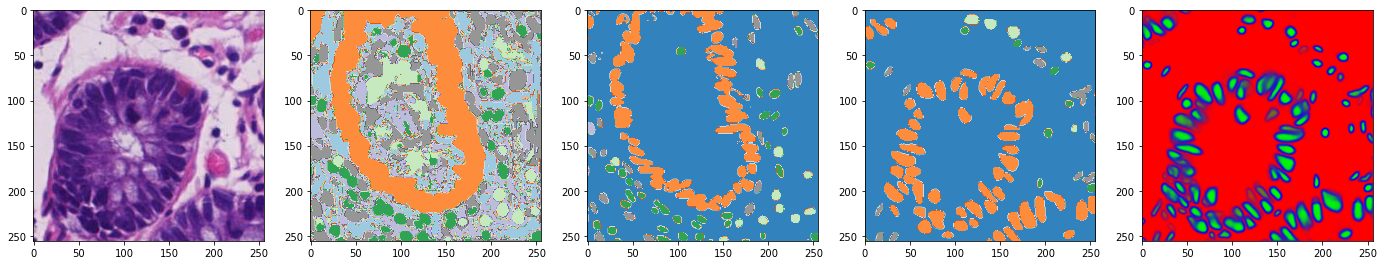

GT inst 89
PR inst 131


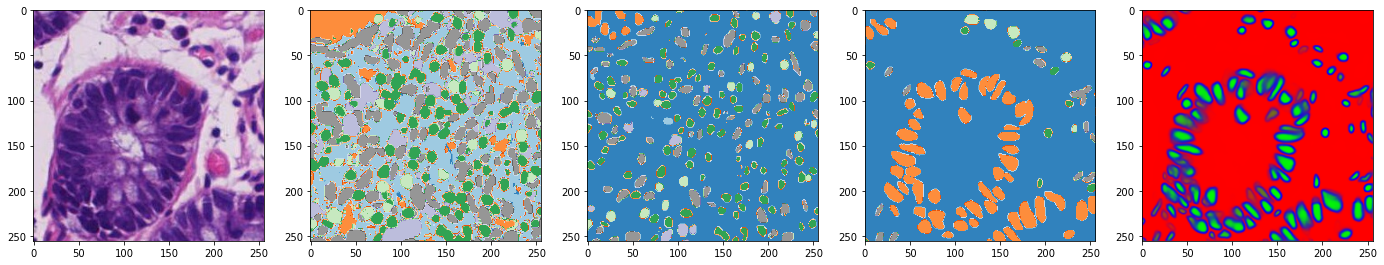

GT inst 89
PR inst 206


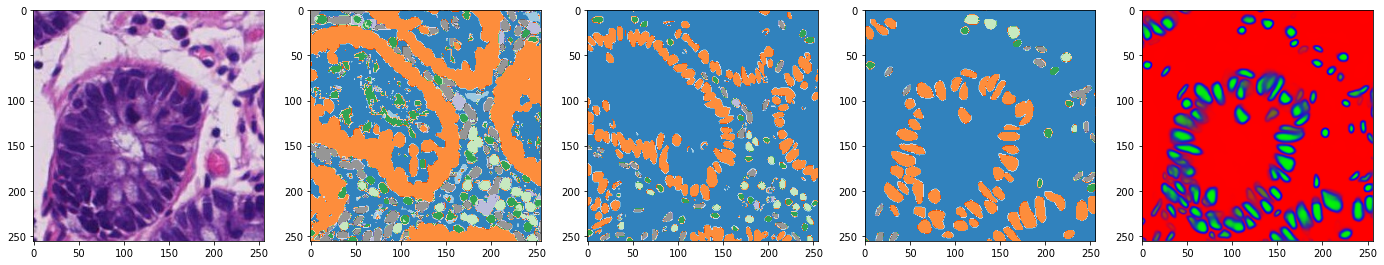

GT inst 89
PR inst 212


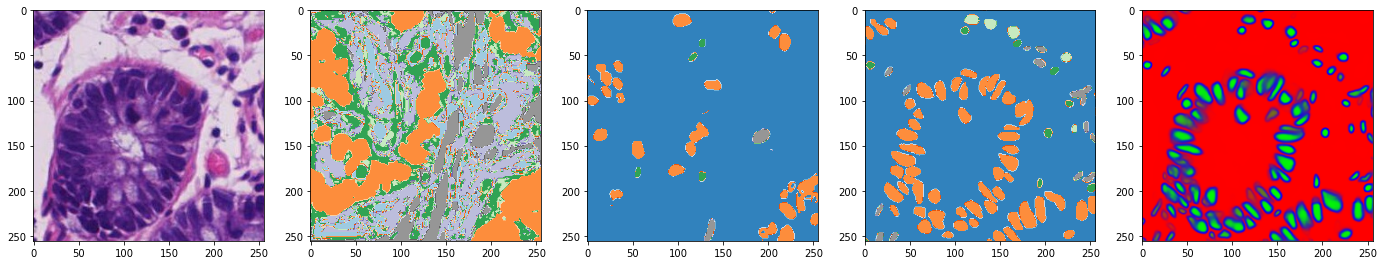

GT inst 89
PR inst 36


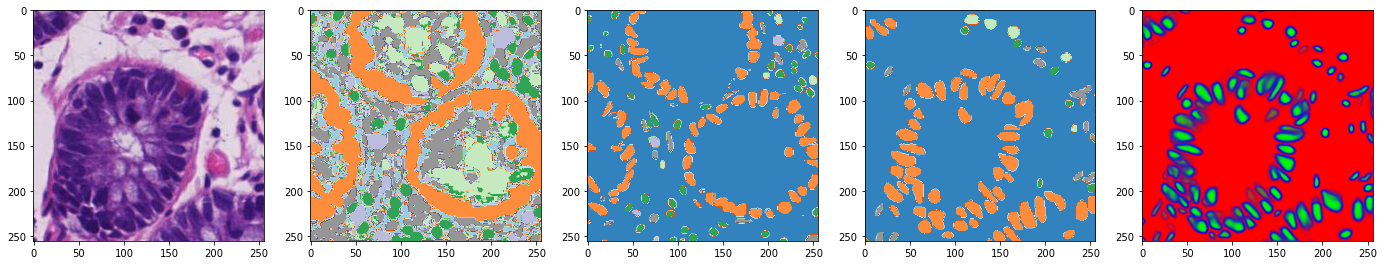

GT inst 89
PR inst 133


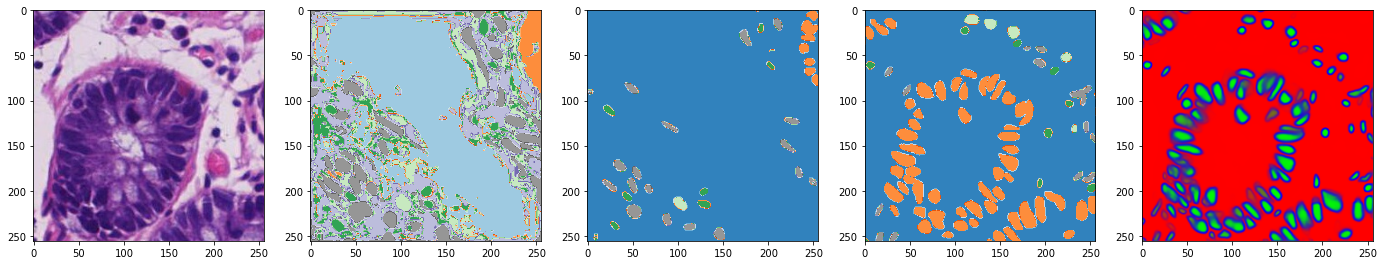

GT inst 89
PR inst 37


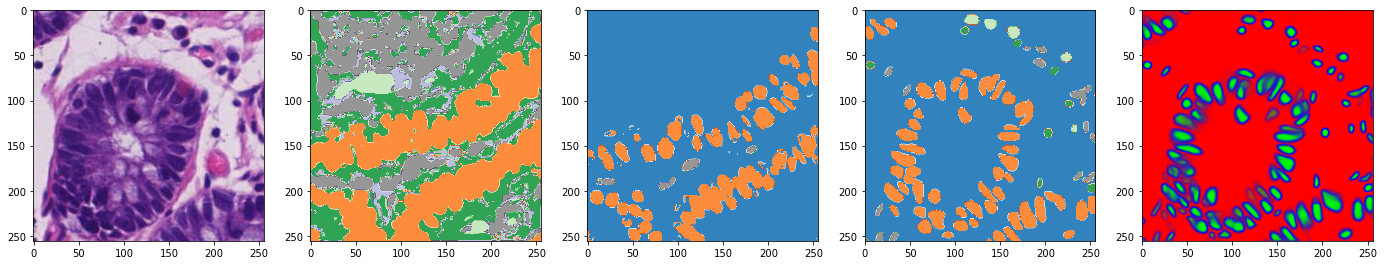

GT inst 89
PR inst 78


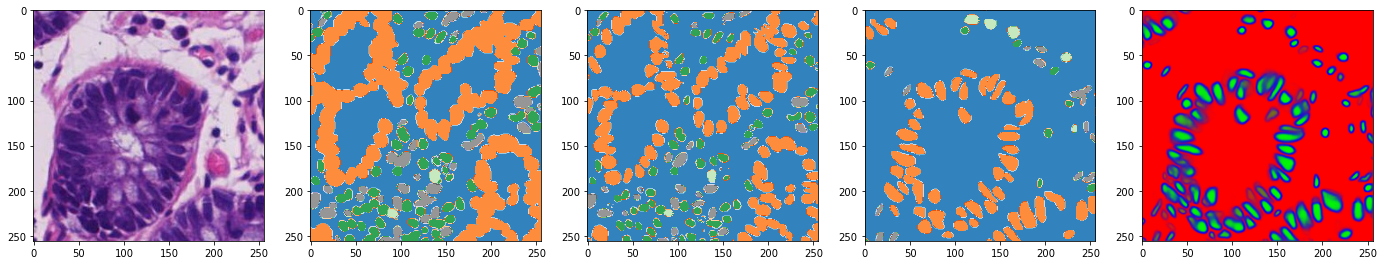

GT inst 89
PR inst 198


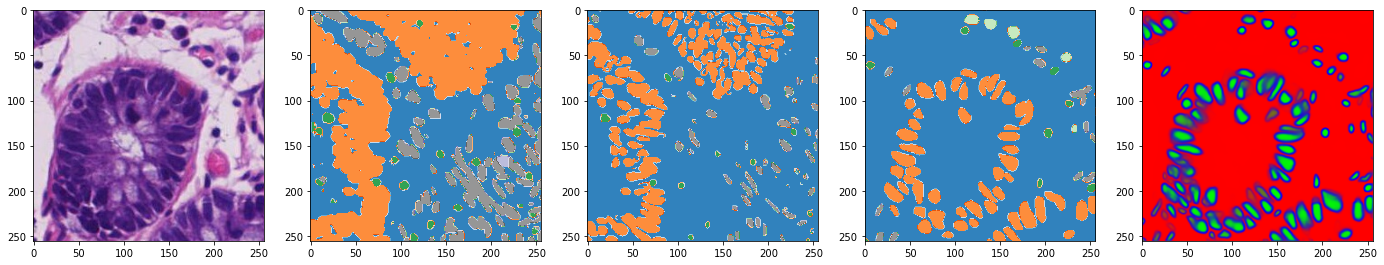

GT inst 89
PR inst 204


KeyboardInterrupt: 

In [224]:
for pred_3c, pred_class in tqdm(zip(pred_emb_list, pred_class_list)):
    pred_inst, _ = make_instance_segmentation(pred_3c, fg_thresh=best_fg_thresh, seed_thresh=best_seed_thresh)
    instance_map = torch.tensor(pred_inst.astype(np.int32)).long()
    pred_ct,_ = make_ct(pred_class, instance_map)
    
    fig, ax = plt.subplots(1,5, figsize=(24,24))
    ax[0].imshow(raw.squeeze().permute(1,2,0).cpu().detach().numpy())
    ax[1].imshow(pred_class.softmax(1).argmax(1).squeeze().detach().cpu().numpy(), vmin=0, vmax=7, cmap='tab20c')
    ax[2].imshow(pred_ct.cpu().detach().numpy(), vmin=0, vmax=7, cmap='tab20c')
    ax[3].imshow(gt[:,1].squeeze().cpu().detach().numpy(), vmin=0, vmax=7, cmap='tab20c')
    ax[4].imshow(pred_emb[:,2:].softmax(1).squeeze().permute(1,2,0).cpu().detach().numpy())
    plt.show()
    print('GT inst', len(np.unique((gt[:,0].cpu().numpy()))))
    print('PR inst', len(np.unique(instance_map.cpu().numpy())))
    i += 1
    if i>100:
        break

In [393]:
import pandas as pd
from tqdm.auto import tqdm
from src.metrics import *

mode = 'seg_class'
pred_array = np.stack(pred_list, axis=0)
true_array = np.stack(gt_list, axis=0)

seg_metrics_names = ["pq", "multi_pq+"]
reg_metrics_names = ["r2"]

all_metrics = {}
if mode == "seg_class":
    # check to make sure input is a single numpy array
#     pred_format = pred_path.split(".")[-1]
#     true_format = true_path.split(".")[-1]
#     if pred_format != "npy" or true_format != "npy":
#         raise ValueError("pred and true must be in npy format.")

    # initialise empty placeholder lists
    pq_list = []
    mpq_info_list = []
    # load the prediction and ground truth arrays
    #pred_array = np.load(pred_path)
    #true_array = np.load(true_path)

    nr_patches = pred_array.shape[0]

    for patch_idx in tqdm(range(nr_patches)):
        # get a single patch
        pred = pred_array[patch_idx]
        true = true_array[patch_idx]

        # instance segmentation map
        pred_inst = pred[..., 0]
        true_inst = true[..., 0]
        # classification map
        pred_class = pred[..., 1]
        true_class = true[..., 1]

        # ===============================================================

        for idx, metric in enumerate(seg_metrics_names):
            if metric == "pq":
                # get binary panoptic quality
                pq = get_pq(true_inst, pred_inst)
                pq = pq[0][2]
                pq_list.append(pq)
            elif metric == "multi_pq+":
                # get the multiclass pq stats info from single image
                mpq_info_single = get_multi_pq_info(true, pred)
                mpq_info = []
                # aggregate the stat info per class
                for single_class_pq in mpq_info_single:
                    tp = single_class_pq[0]
                    fp = single_class_pq[1]
                    fn = single_class_pq[2]
                    sum_iou = single_class_pq[3]
                    mpq_info.append([tp, fp, fn, sum_iou])
                mpq_info_list.append(mpq_info)
            else:
                raise ValueError("%s is not supported!" % metric)

    pq_metrics = np.array(pq_list)
    pq_metrics_avg = np.mean(pq_metrics, axis=-1)  # average over all images
    if "multi_pq+" in seg_metrics_names:
        mpq_info_metrics = np.array(mpq_info_list, dtype="float")
        # sum over all the images
        total_mpq_info_metrics = np.sum(mpq_info_metrics, axis=0)

    for idx, metric in enumerate(seg_metrics_names):
        if metric == "multi_pq+":
            mpq_list = []
            # for each class, get the multiclass PQ
            for cat_idx in range(total_mpq_info_metrics.shape[0]):
                total_tp = total_mpq_info_metrics[cat_idx][0]
                total_fp = total_mpq_info_metrics[cat_idx][1]
                total_fn = total_mpq_info_metrics[cat_idx][2]
                total_sum_iou = total_mpq_info_metrics[cat_idx][3]

                # get the F1-score i.e DQ
                dq = total_tp / (
                    (total_tp + 0.5 * total_fp + 0.5 * total_fn) + 1.0e-6
                )
                # get the SQ, when not paired, it has 0 IoU so does not impact
                sq = total_sum_iou / (total_tp + 1.0e-6)
                mpq_list.append(dq * sq)
            mpq_metrics = np.array(mpq_list)
            all_metrics[metric] = [np.mean(mpq_metrics)]
        else:
            all_metrics[metric] = [pq_metrics_avg]

else:
    # first check to make sure ground truth and prediction is in csv format
    if not os.path.isfile(true_path) or not os.path.isfile(pred_path):
        raise ValueError("pred and true must be in csv format.")

    pred_format = pred_path.split(".")[-1]
    true_format = true_path.split(".")[-1]
    if pred_format != "csv" or true_format != "csv":
        raise ValueError("pred and true must be in csv format.")

    pred_csv = pd.read_csv(pred_path)
    true_csv = pd.read_csv(true_path)

    for idx, metric in enumerate(reg_metrics_names):
        if metric == "r2":
            # calculate multiclass coefficient of determination
            r2 = get_multi_r2(true_csv, pred_csv)
            all_metrics["multi_r2"] = [r2]
        else:
            raise ValueError("%s is not supported!" % metric)

df = pd.DataFrame(all_metrics)
df = df.to_string(index=False)
print(df)
print(mpq_list)

  0%|          | 0/500 [00:00<?, ?it/s]

      pq  multi_pq+
0.609737   0.499159
[0.31183213691277606, 0.5976526860444384, 0.6707225152053008, 0.5124236151999054, 0.35790448964204913, 0.5444213156084633]


sum -> softmax
pq  multi_pq+
0.609737   0.499159
[0.31183213691277606, 0.5976526860444384, 0.6707225152053008, 0.5124236151999054, 0.35790448964204913, 0.5444213156084633]

softmax -> mean
pq  multi_pq+
0.608484   0.499811
[0.3106722340948785, 0.5977695534557917, 0.671663621195606, 0.510693530196291, 0.3677971863771149, 0.5402676481301754]


pseudo_label max reduction
pq  multi_pq+
0.538335   0.437698
[0.23727037815182844, 0.5355204566724193, 0.6426841961155405, 0.49511828299276744, 0.2686378377929015, 0.44695838731383725]

best_model checkpoint
      pq  multi_pq+

0.609524   0.501428

[0.3174894260262353, 0.5979962551985116, 0.6684580881793898, 0.5073588221876696, 0.3750911888803307, 0.5421767192953643]



129k steps no checkpoint

pq  multi_pq+

0.610329   0.502327

[0.3278243448839614, 0.5983176935491349, 0.672605489772026, 0.5183472990773729, 0.3531077489300705, 0.5437599064850065]


without spatial and without color aug

pq  multi_pq+

1.0   0.388554

[0.13605440631218632, 0.7116875367585904, 0.5265270997840394, 0.11836734237401099, 0.23952094323927073, 0.599164413074876]



without spatial and with color aug

pq  multi_pq+

1.0   0.336376

[0.04519773420792312, 0.6592147543218626, 0.4780814845394113, 0.114384744837488, 0.14754096479441225, 0.5738375055831182]



spatial and color aug

pq  multi_pq+

1.0   0.325883

[0.06575341881778995, 0.6849401380954822, 0.48942598087316147, 0.06849314580596769, 0.07777776580247085, 0.5689045927156039]